In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys 
sys.path.append("/glade/work/schreck/repos/HOLO/clean/holodec-ml")
from holodecml.data import *
from holodecml.losses import *
from holodecml.models import *
from holodecml.metrics import *
from holodecml.transforms import *
from holodecml.propagation import *

import os
import glob
import tqdm
import time
import yaml
import scipy
import torch
import pickle
import joblib
import random
import sklearn
import logging
import datetime

import torch.fft
import torchvision
import torchvision.models as models

import numpy as np
import pandas as pd
import xarray as xr
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from collections import defaultdict
from scipy.signal import convolve2d
from torch.optim.lr_scheduler import *
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple


from colour import Color
import multiprocessing as mp
from functools import partial

In [2]:
%matplotlib inline

### Set up a logger

In [3]:
root = logging.getLogger()
root.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s:%(name)s:%(message)s')

# Stream output to stdout
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
root.addHandler(ch)

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

In [5]:
with open("/glade/work/schreck/repos/HOLO/clean/holodec-ml/config/unet_propagation.yml") as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [6]:
n_bins = conf["data"]["n_bins"]
tile_size = conf["data"]["tile_size"]
step_size = conf["data"]["step_size"]
marker_size = conf["data"]["marker_size"]
synthetic_path = conf["data"]["data_path"]
raw_path = conf["data"]["raw_data"]

model_loc = conf["trainer"]["output_path"]
model_name = conf["model"]["name"]
color_dim = conf["model"]["color_dim"]
inference_mode = conf["model"]["mode"]

batch_size = conf["inference"]["batch_size"]
workers = conf["inference"]["workers"]
save_arrays = conf["inference"]["save_arrays"]
plot = conf["inference"]["plot"]
data_set = conf["inference"]["data_set"]["path"]
data_set_name = conf["inference"]["data_set"]["name"]

### Set up directories as children of the model_loc for saving inference results

In [7]:
prop_data_loc = os.path.join(model_loc, f"{data_set_name}/propagated")
roc_data_loc = os.path.join(model_loc, f"{data_set_name}/roc")
image_data_loc = os.path.join(model_loc, f"{data_set_name}/images")

for directory in [prop_data_loc, roc_data_loc, image_data_loc]:
    if not os.path.exists(directory):
        os.makedirs(directory)

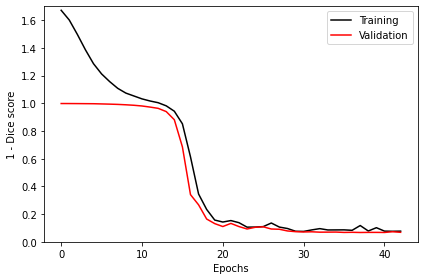

In [8]:
# Load a model
f = pd.read_csv(f"{model_loc}/training_log.csv")
plt.plot(f["epoch"], f["train_loss"], c = 'k')
plt.plot(f["epoch"], f["valid_loss"], c = 'r')
plt.ylim([0.0, 1.7])
plt.xlabel("Epochs")
plt.ylabel("1 - Dice score")
plt.legend(["Training", "Validation"], loc = "best")
plt.tight_layout()

In [9]:
### Initialize a unet
model = ResNetUNet(
    n_class = 1, 
    color_dim = color_dim
).to(device)


### Load the weights from the training location
checkpoint = torch.load(
    os.path.join(model_loc, "best.pt"), #"/glade/work/schreck/repos/HOLO/holodec-ml/holodecml/reader/models/unet_double_compare/best.pt"
    map_location=lambda storage, loc: storage
)
model.load_state_dict(checkpoint["model_state_dict"])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

logger.info(f"There are {total_params} total model parameters")

INFO:holodecml.transforms:There are 18313833 total model parameters


In [10]:
inference_transforms = LoadTransformations(conf["transforms"]["inference"])

INFO:holodecml.transforms:Loaded Normalize transformation that normalizes data color channel by dividing by 255.0 and phase pi


In [11]:
prop = InferencePropagator(
    data_set, 
    n_bins = n_bins,
    tile_size = tile_size,
    step_size = step_size,
    marker_size = marker_size,
    device = device,
    model = model,
    mode = inference_mode,
    transforms = inference_transforms
)

In [12]:
h_idx = 0
test_image = prop.h_ds['image'].isel(hologram_number=h_idx)

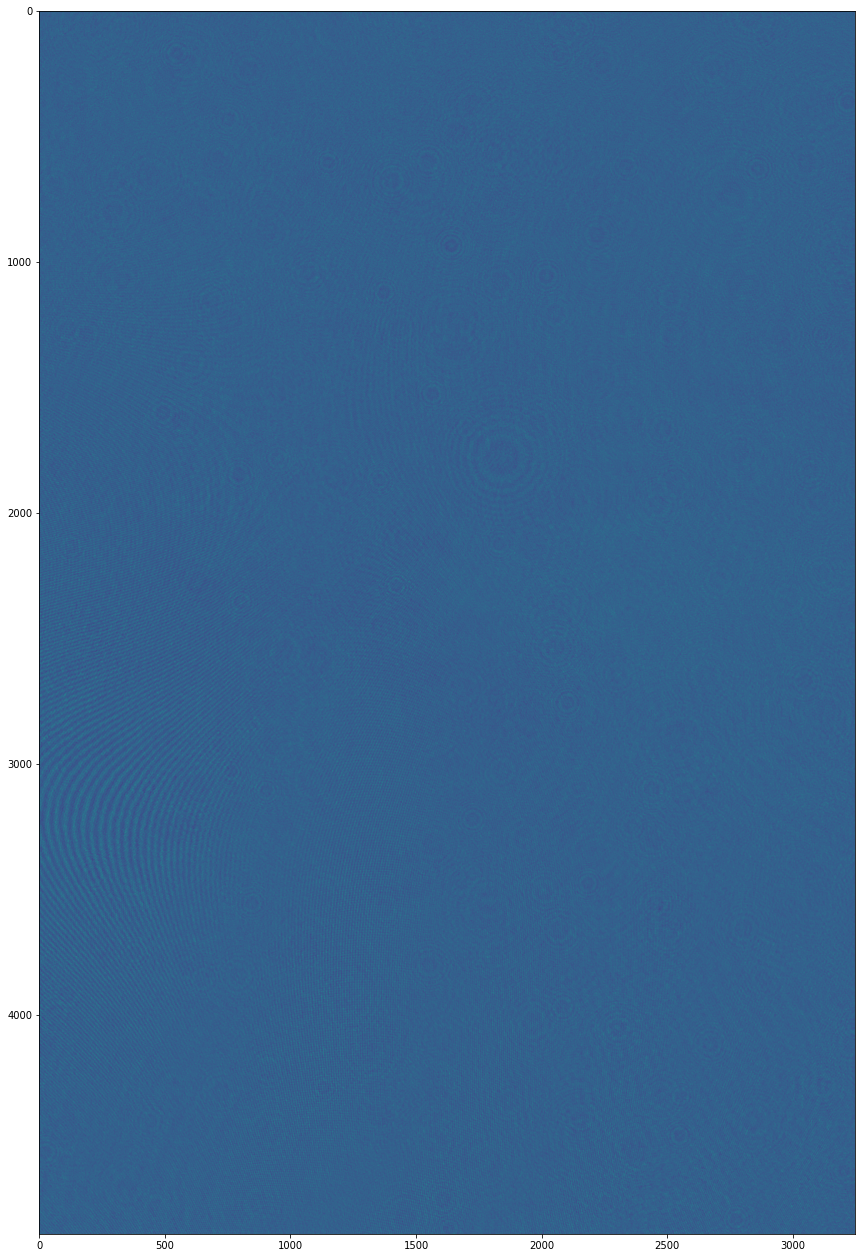

In [13]:
shape = test_image.values.shape
ratio = shape[0] / shape[1]

plt.figure(figsize = (15, 15 * ratio))
plt.imshow(test_image.values)

In [14]:
#min(prop.h_ds.isel(hologram_number=h_idx)["d"].values)

### Create a list of z-values to propagate to

In [15]:
z_list = prop.create_z_plane_lst(planes_per_call=1)

### Set up thresholds to use for computing ROC

In [16]:
obs_threshold = 1.0
thresholds = 1.0 - np.logspace(-5, 0, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
thresholds = thresholds[::-1]

### Initialize the generator

In [17]:
inference_generator = prop.get_next_z_planes_labeled(
    h_idx, 
    z_list, 
    batch_size = batch_size, 
    thresholds = thresholds,
    obs_threshold = obs_threshold
)

### Main loop to call the generator, predict with the model, and aggregate and save the results

  0%|          | 0/1000 [00:00<?, ?it/s]INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
Plane: 0 at z: 0.014072 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   0%|          | 1/1000 [00:23<6:25:17, 23.14s/it]

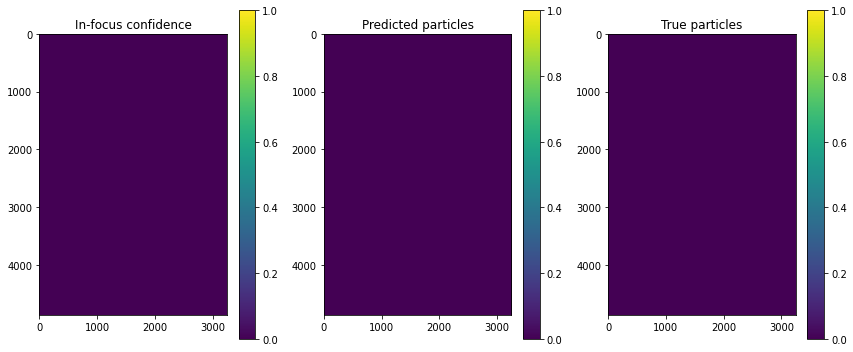

Plane: 1 at z: 0.014216 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   0%|          | 3/1000 [00:40<3:32:39, 12.80s/it]

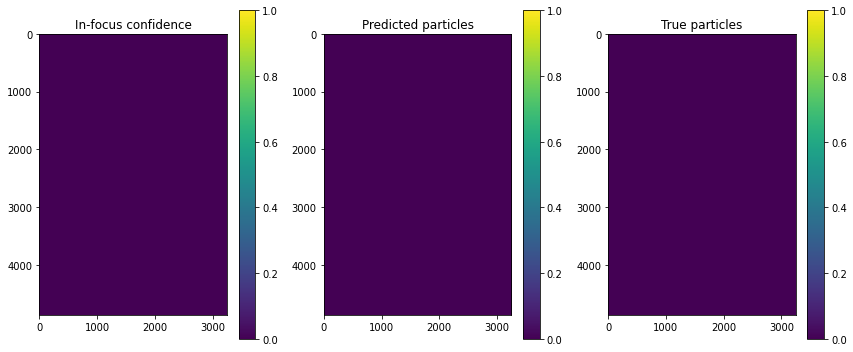

Plane: 2 at z: 0.01436 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   0%|          | 4/1000 [00:57<4:02:00, 14.58s/it] 

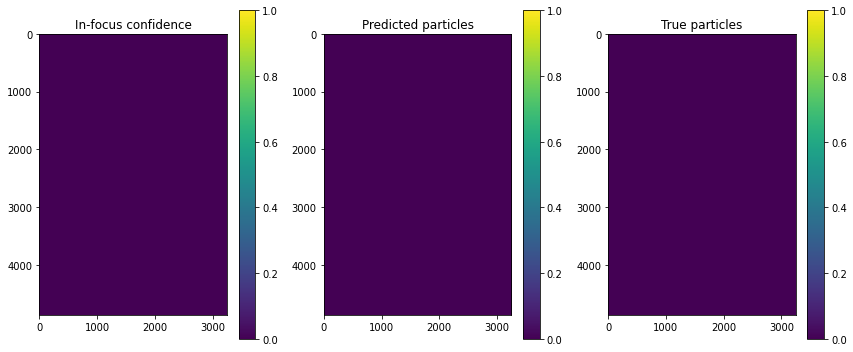

Plane: 3 at z: 0.014504 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   1%|          | 6/1000 [01:15<3:15:29, 11.80s/it]

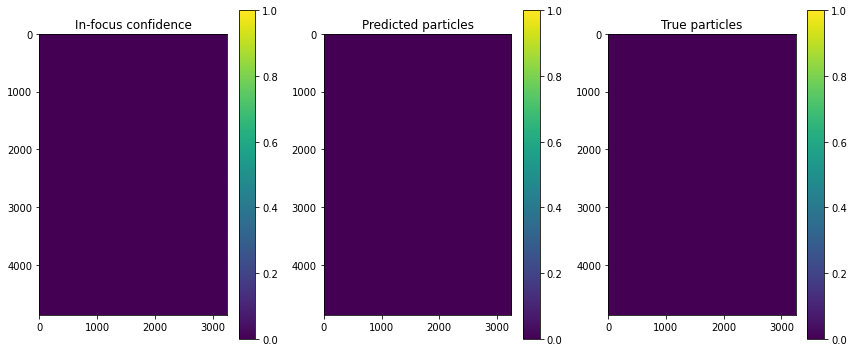

Plane: 4 at z: 0.014648 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   1%|          | 7/1000 [01:32<3:44:45, 13.58s/it]

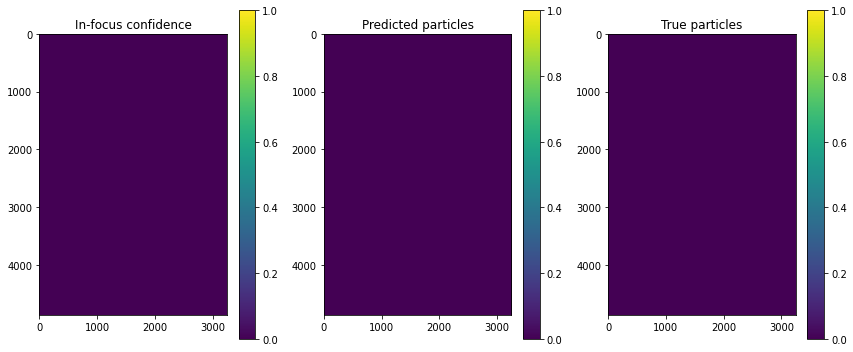

Plane: 5 at z: 0.014792 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   1%|          | 8/1000 [01:49<4:03:52, 14.75s/it]

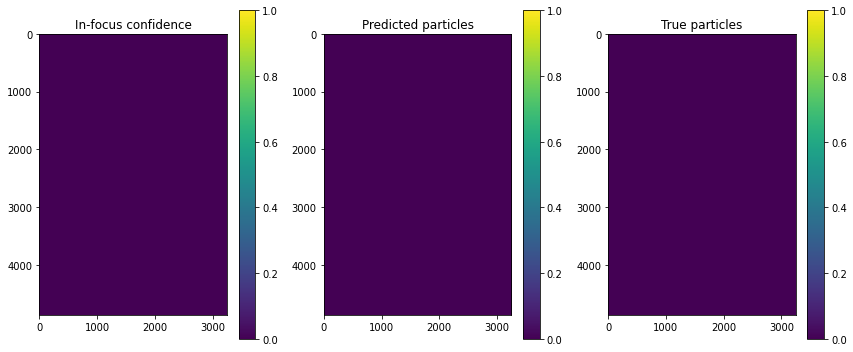

Plane: 6 at z: 0.014936 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   1%|          | 10/1000 [02:06<3:20:27, 12.15s/it]

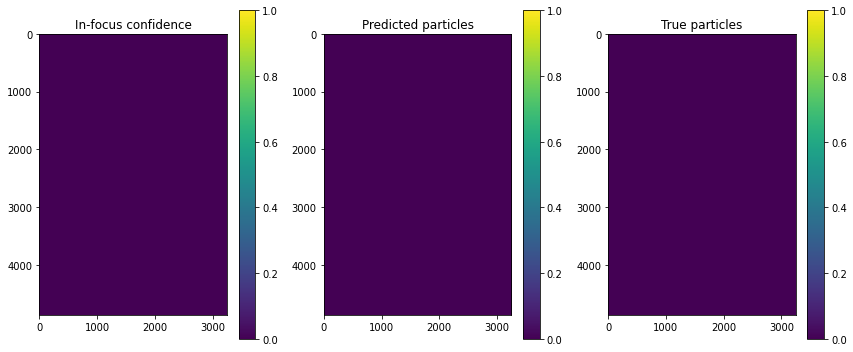

Plane: 7 at z: 0.01508 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   1%|          | 11/1000 [02:24<3:46:10, 13.72s/it] 

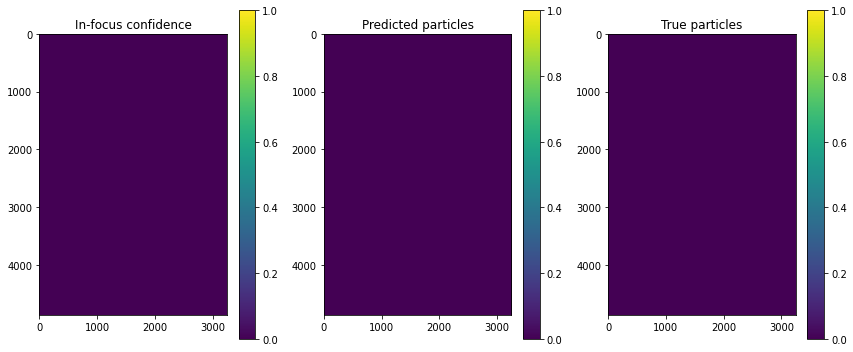

Plane: 8 at z: 0.015224 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   1%|          | 12/1000 [02:41<4:04:00, 14.82s/it]

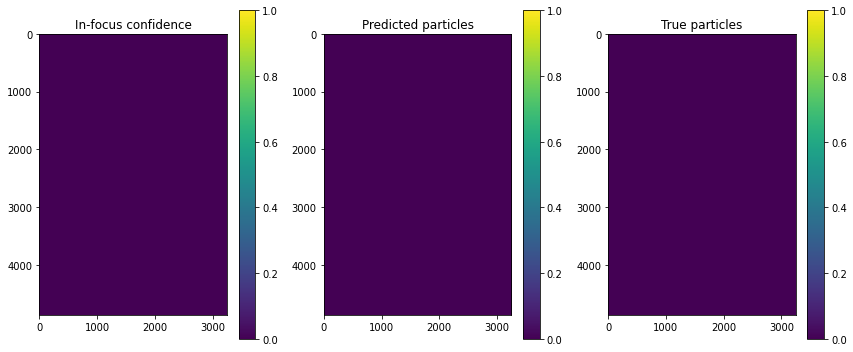

Plane: 9 at z: 0.015368 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   1%|▏         | 13/1000 [02:58<4:15:45, 15.55s/it]

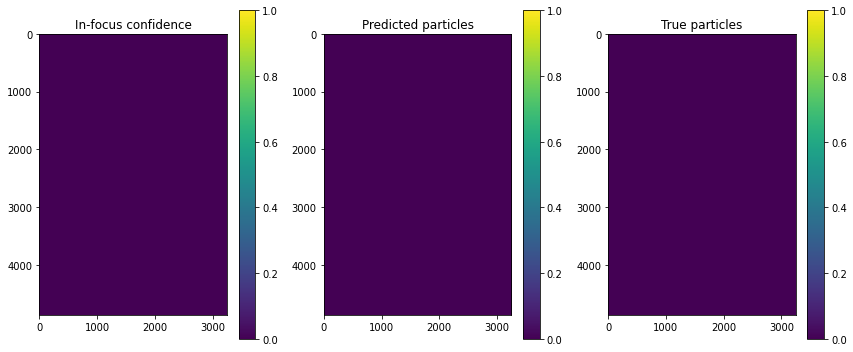

Plane: 10 at z: 0.015512 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   2%|▏         | 15/1000 [03:16<3:26:46, 12.60s/it]

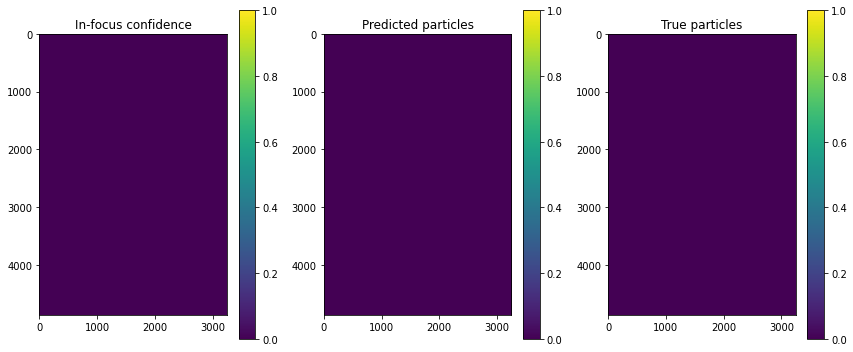

Plane: 11 at z: 0.015656 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   2%|▏         | 16/1000 [03:33<3:49:30, 13.99s/it]

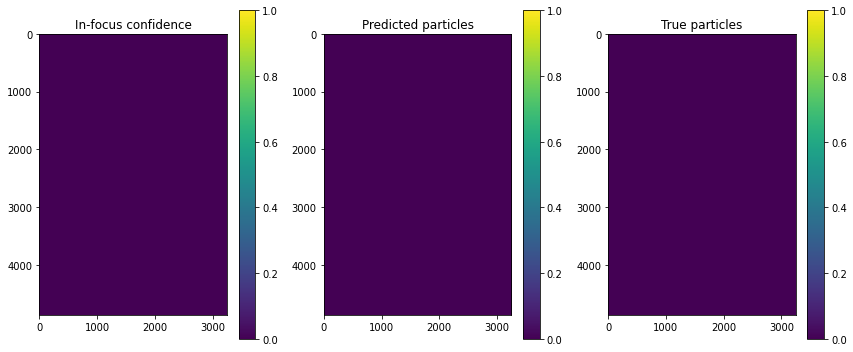

Plane: 12 at z: 0.015799999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   2%|▏         | 17/1000 [03:50<4:05:31, 14.99s/it]

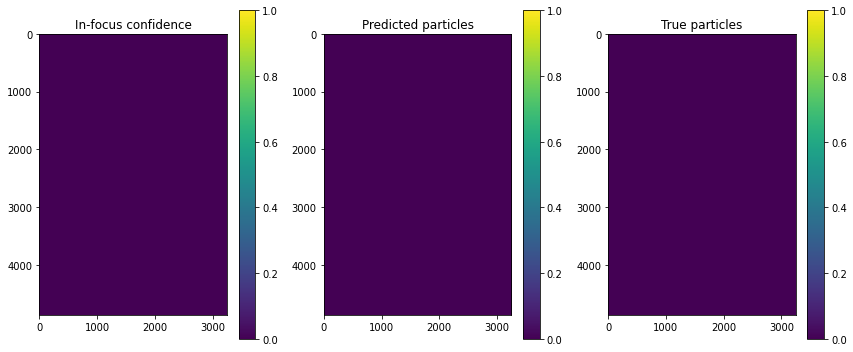

Plane: 13 at z: 0.015944 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   2%|▏         | 18/1000 [04:07<4:16:41, 15.68s/it]            

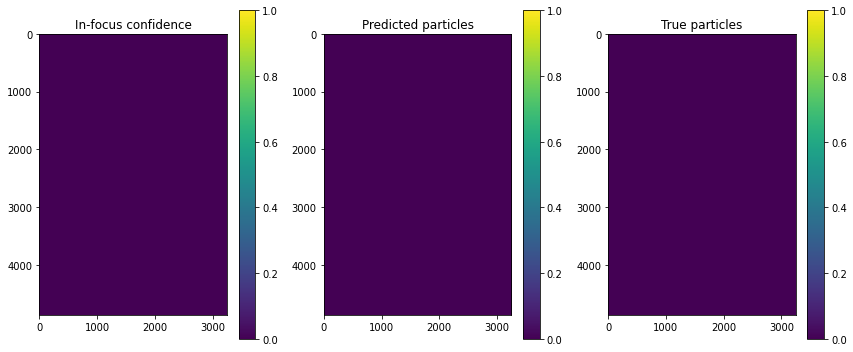

Plane: 14 at z: 0.016087999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   2%|▏         | 19/1000 [04:25<4:25:01, 16.21s/it]

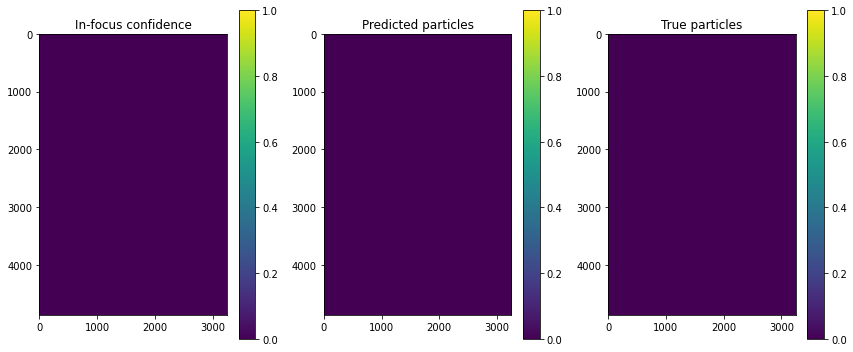

Plane: 15 at z: 0.016232 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   2%|▏         | 21/1000 [04:42<3:30:21, 12.89s/it]            

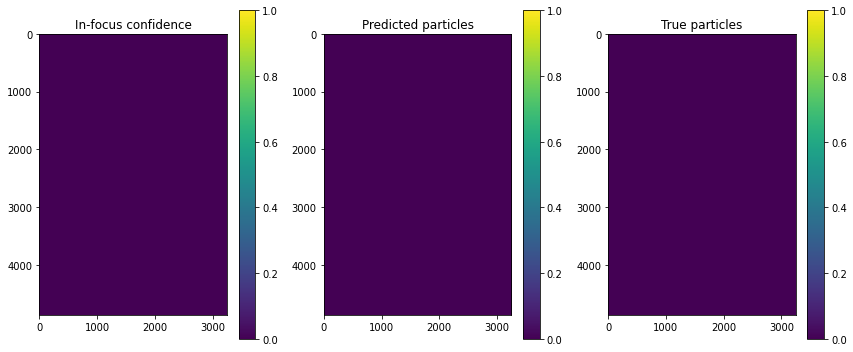

Plane: 16 at z: 0.016375999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   2%|▏         | 22/1000 [04:59<3:51:22, 14.20s/it]

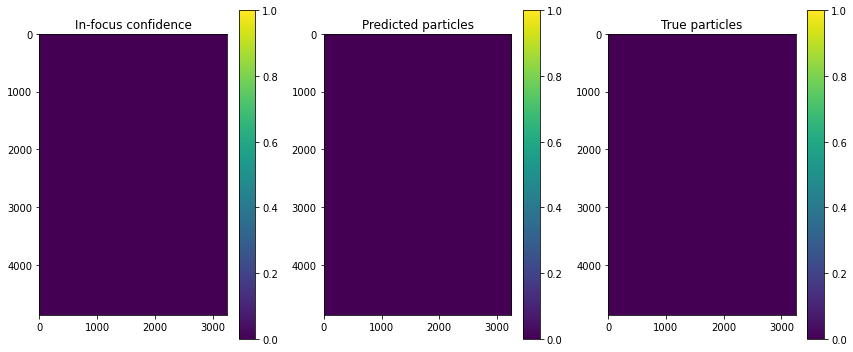

Plane: 17 at z: 0.01652 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   2%|▏         | 23/1000 [05:16<4:05:24, 15.07s/it]             

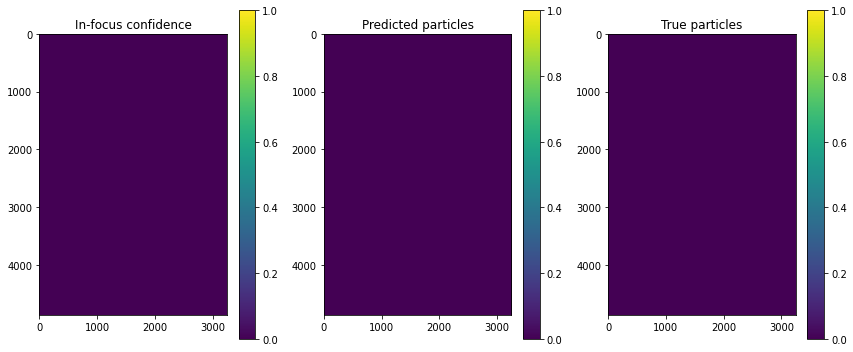

Plane: 18 at z: 0.016663999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   2%|▏         | 24/1000 [05:33<4:13:24, 15.58s/it]

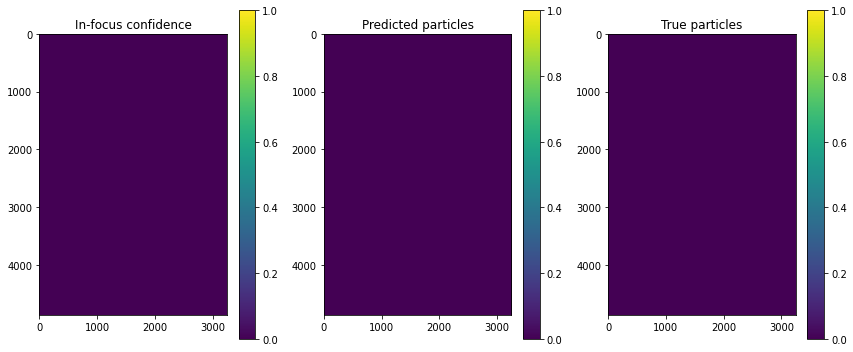

Plane: 19 at z: 0.016808 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   2%|▎         | 25/1000 [05:50<4:19:05, 15.94s/it]            

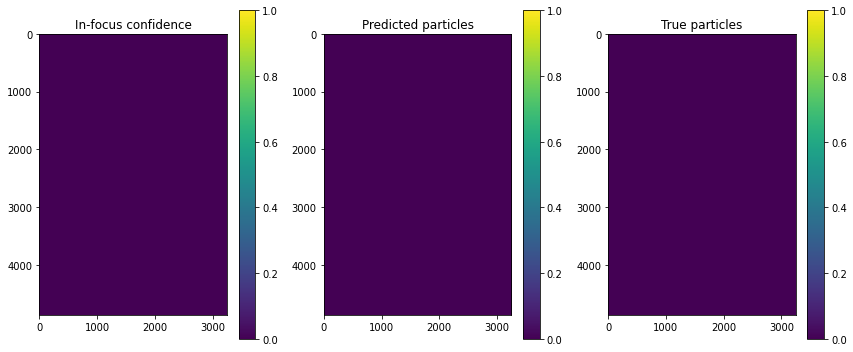

Plane: 20 at z: 0.016952 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   3%|▎         | 26/1000 [06:07<4:23:21, 16.22s/it]

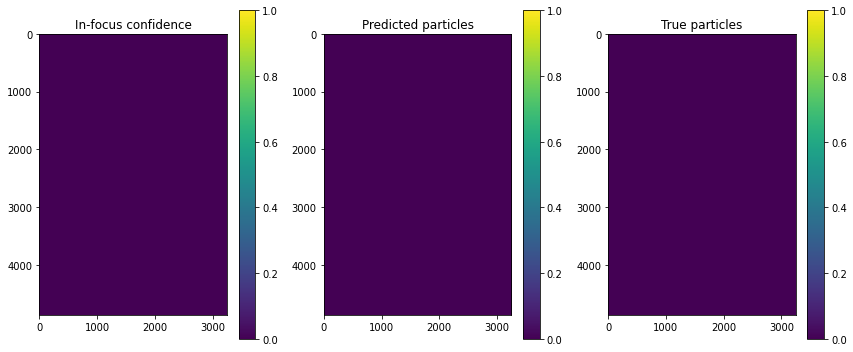

Plane: 21 at z: 0.017096 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   3%|▎         | 28/1000 [06:24<3:28:22, 12.86s/it]

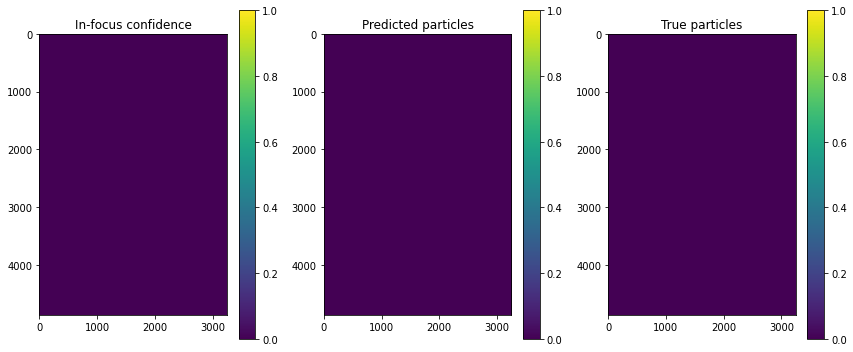

Plane: 22 at z: 0.01724 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   3%|▎         | 29/1000 [06:40<3:46:33, 14.00s/it] 

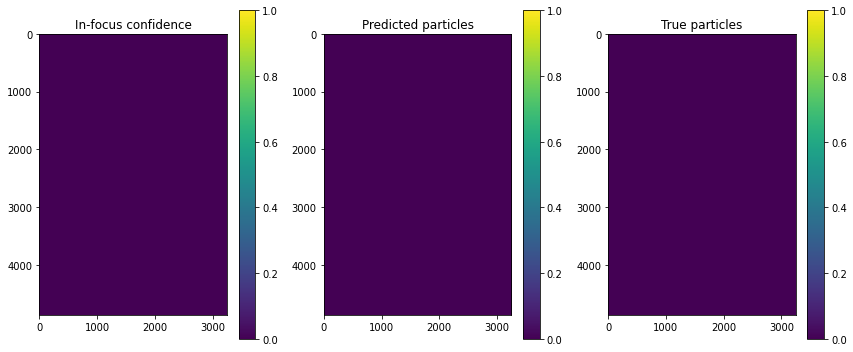

Plane: 23 at z: 0.017384 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   3%|▎         | 30/1000 [06:57<3:59:06, 14.79s/it]

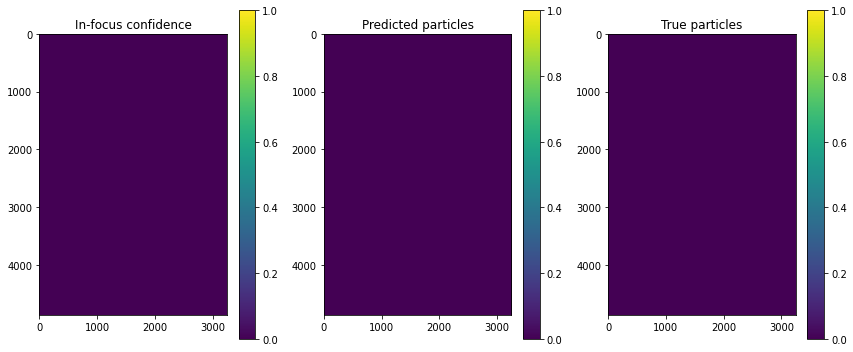

Plane: 24 at z: 0.017528 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   3%|▎         | 31/1000 [07:14<4:08:35, 15.39s/it]

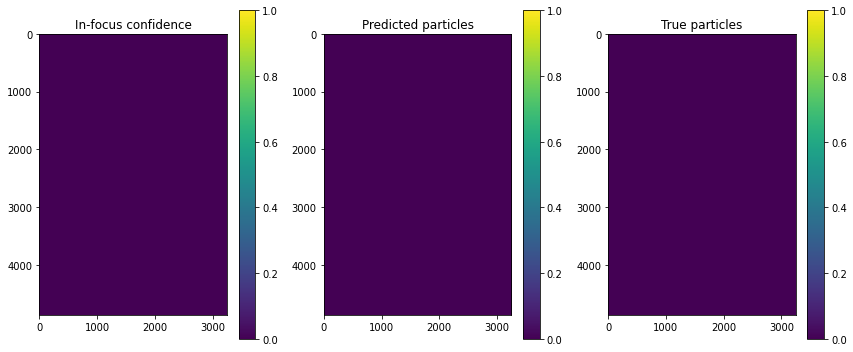

Plane: 25 at z: 0.017672 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   3%|▎         | 32/1000 [07:31<4:15:07, 15.81s/it]

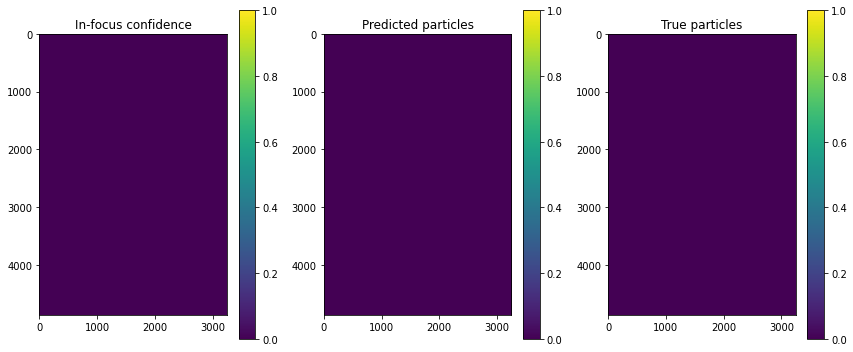

Plane: 26 at z: 0.017816 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   3%|▎         | 33/1000 [07:47<4:20:05, 16.14s/it]

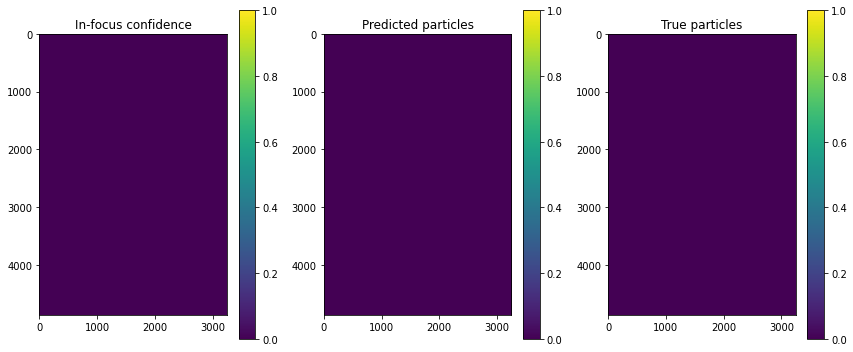

Plane: 27 at z: 0.01796 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   3%|▎         | 34/1000 [08:04<4:23:51, 16.39s/it] 

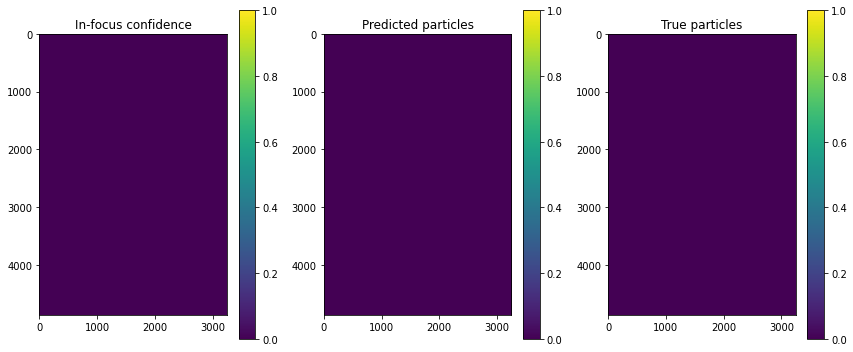

Plane: 28 at z: 0.018104 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   4%|▎         | 36/1000 [08:21<3:26:14, 12.84s/it]

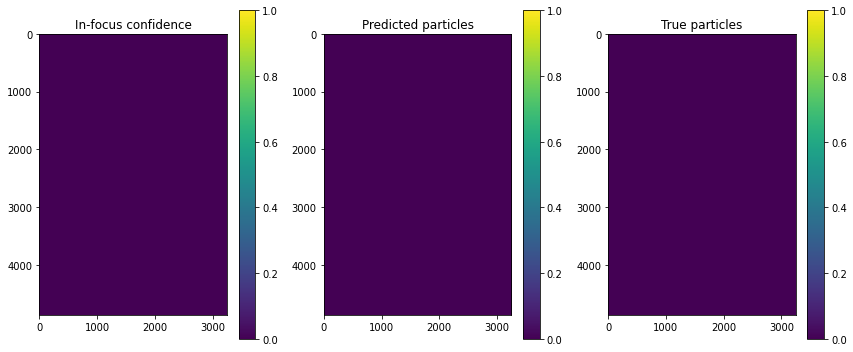

Plane: 29 at z: 0.018248 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   4%|▎         | 37/1000 [08:38<3:44:52, 14.01s/it]

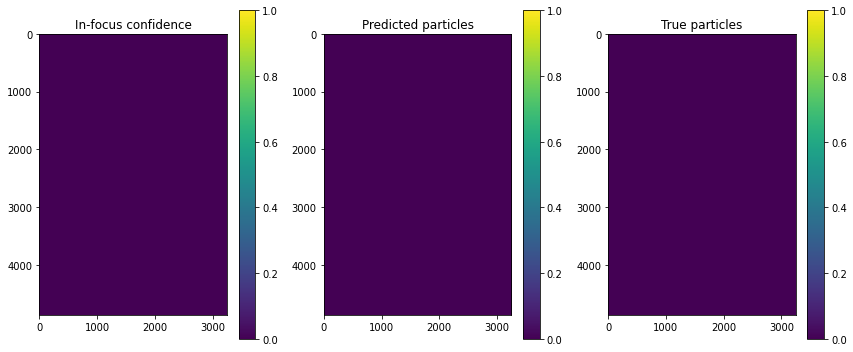

Plane: 30 at z: 0.018392 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   4%|▍         | 38/1000 [08:55<3:58:13, 14.86s/it]

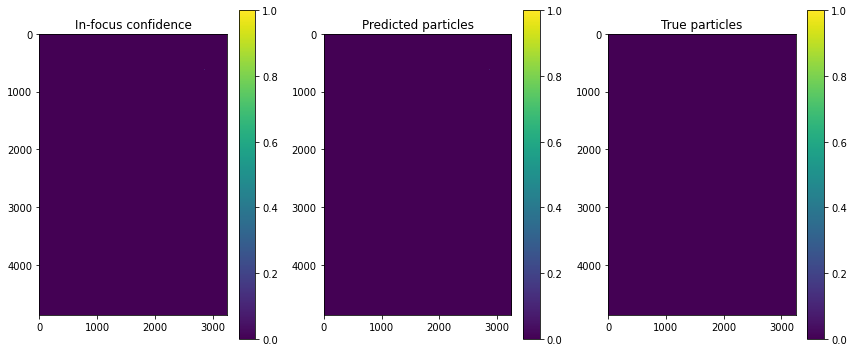

Plane: 31 at z: 0.018536 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   4%|▍         | 39/1000 [09:12<4:10:17, 15.63s/it]

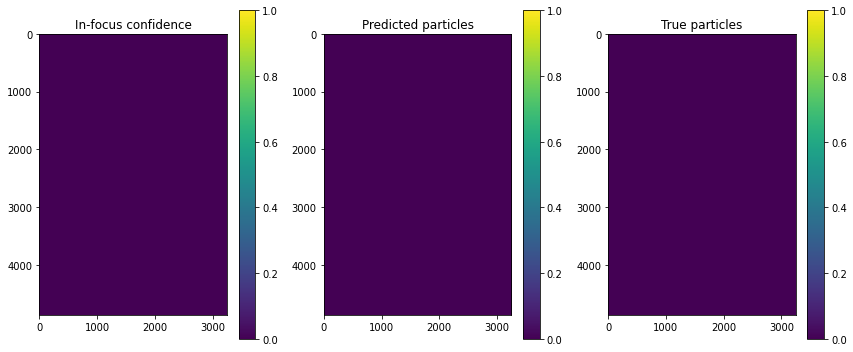

Plane: 32 at z: 0.01868 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   4%|▍         | 40/1000 [09:29<4:16:01, 16.00s/it] 

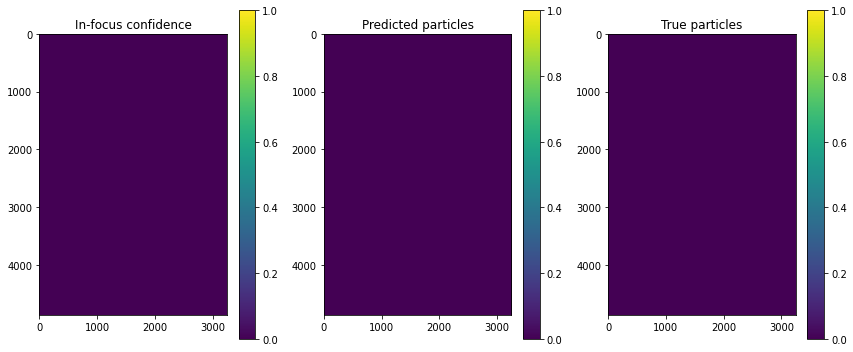

Plane: 33 at z: 0.018824 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   4%|▍         | 41/1000 [09:46<4:21:31, 16.36s/it]

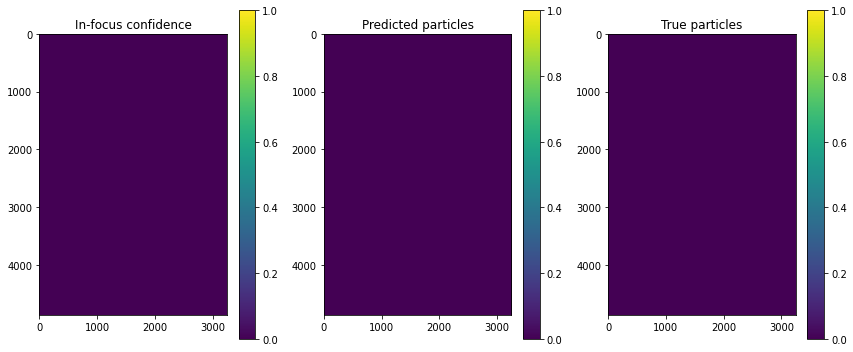

Plane: 34 at z: 0.018968 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   4%|▍         | 42/1000 [10:03<4:23:39, 16.51s/it]

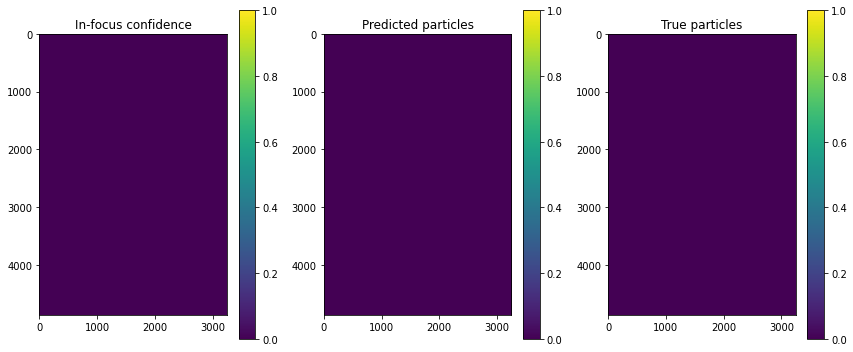

Plane: 35 at z: 0.019112 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   4%|▍         | 43/1000 [10:20<4:24:05, 16.56s/it]

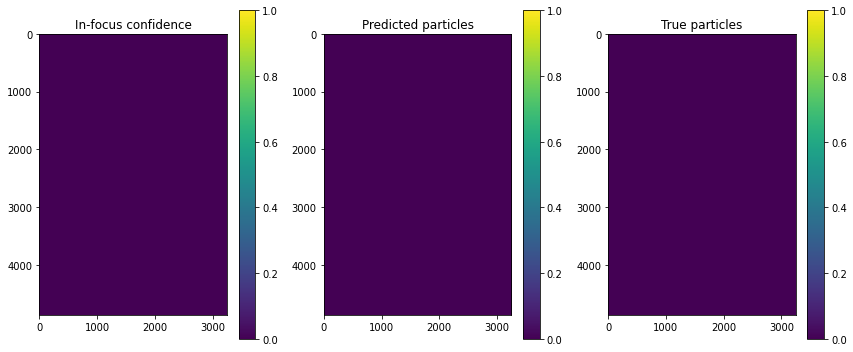

Plane: 36 at z: 0.019256 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   4%|▍         | 45/1000 [10:36<3:26:03, 12.95s/it]

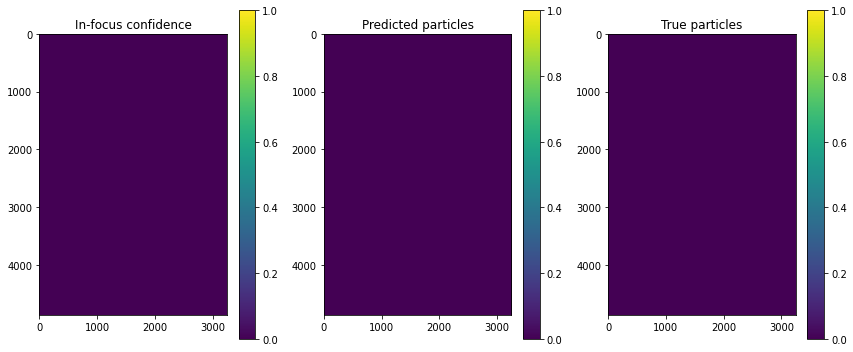

Plane: 37 at z: 0.0194 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   5%|▍         | 46/1000 [10:53<3:44:02, 14.09s/it]  

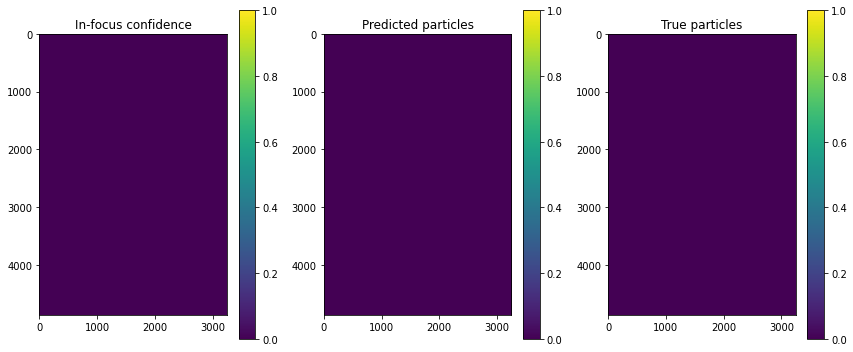

Plane: 38 at z: 0.019544 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   5%|▍         | 47/1000 [11:10<3:56:50, 14.91s/it]

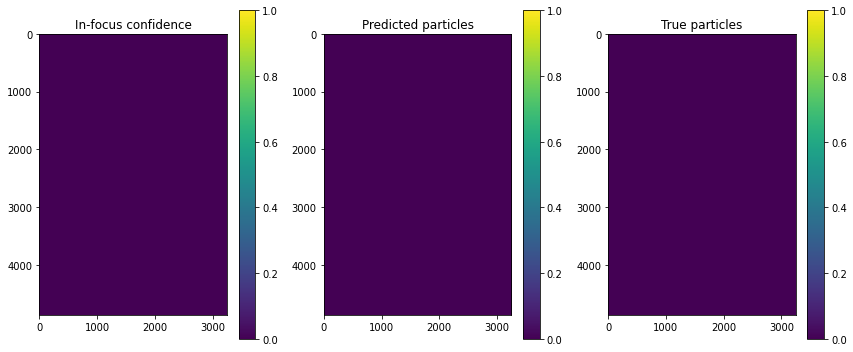

Plane: 39 at z: 0.019688 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   5%|▍         | 48/1000 [11:27<4:05:26, 15.47s/it]

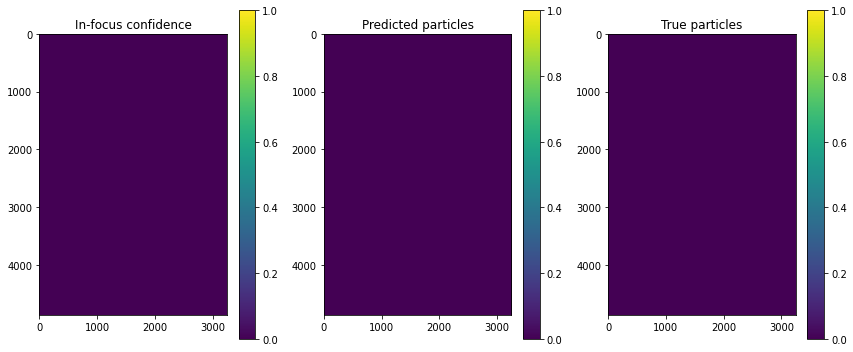

Plane: 40 at z: 0.019832 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   5%|▍         | 49/1000 [11:44<4:12:30, 15.93s/it]

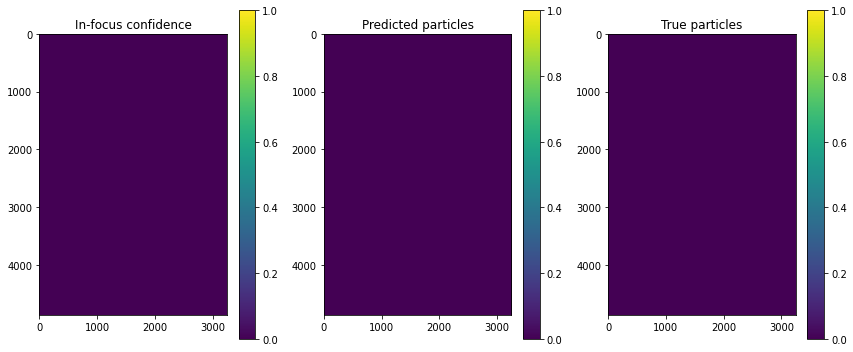

Plane: 41 at z: 0.019976 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   5%|▌         | 50/1000 [12:00<4:15:15, 16.12s/it]

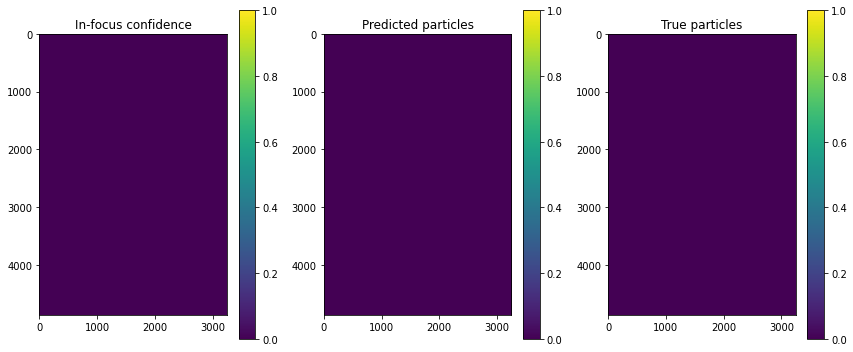

Plane: 42 at z: 0.02012 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   5%|▌         | 51/1000 [12:17<4:17:32, 16.28s/it] 

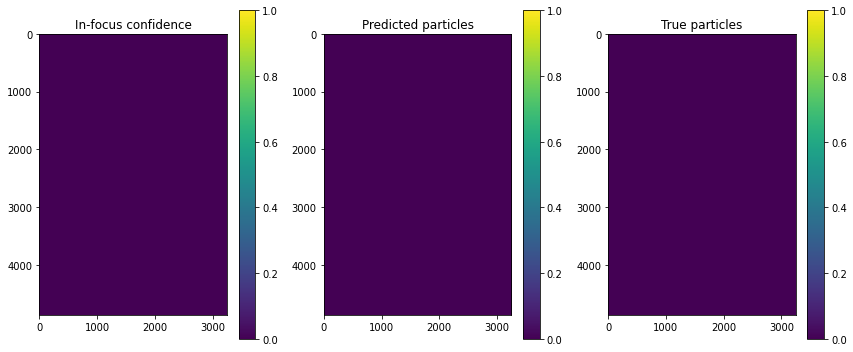

Plane: 43 at z: 0.020264 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   5%|▌         | 52/1000 [12:34<4:19:45, 16.44s/it]

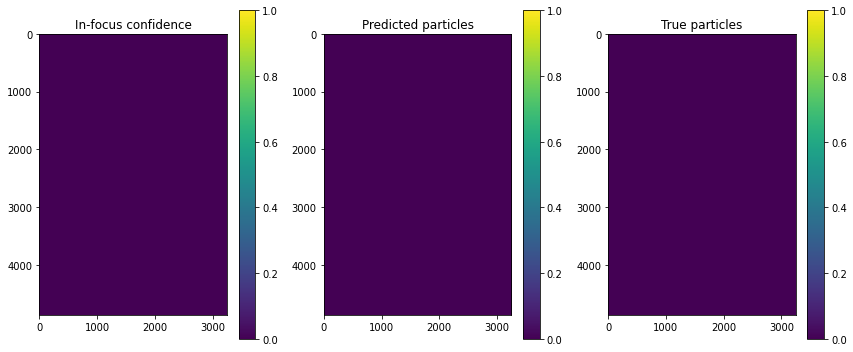

Plane: 44 at z: 0.020408 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   5%|▌         | 53/1000 [12:51<4:21:24, 16.56s/it]

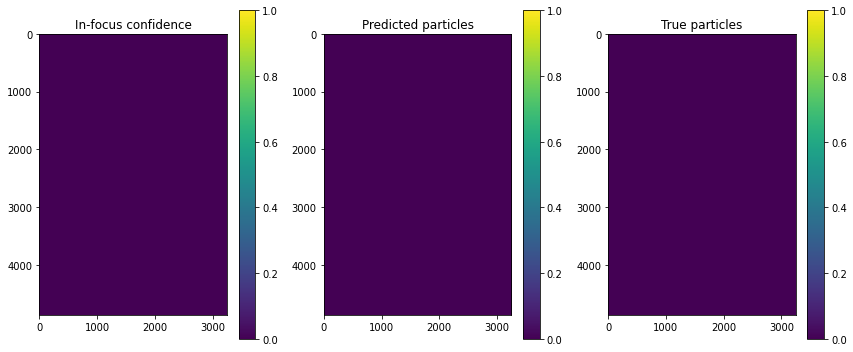

Plane: 45 at z: 0.020551999999999997 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   6%|▌         | 55/1000 [13:07<3:24:16, 12.97s/it]

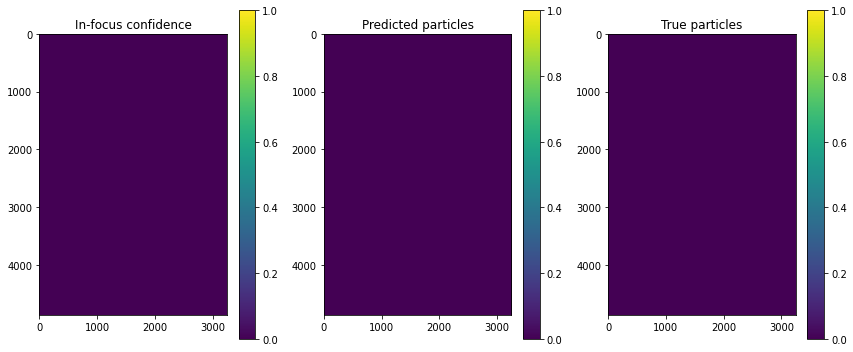

Plane: 46 at z: 0.020696 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   6%|▌         | 56/1000 [13:24<3:42:18, 14.13s/it]            

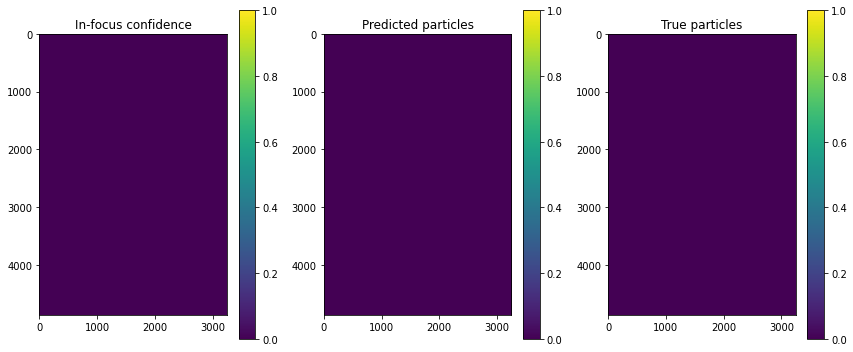

Plane: 47 at z: 0.020839999999999997 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   6%|▌         | 57/1000 [13:41<3:54:37, 14.93s/it]

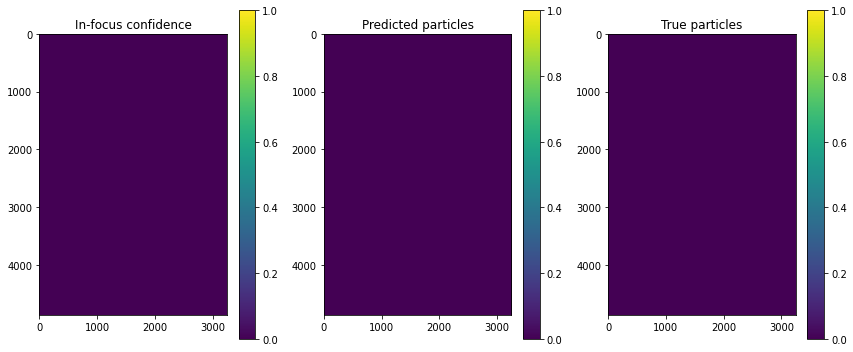

Plane: 48 at z: 0.020984 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   6%|▌         | 58/1000 [13:58<4:02:44, 15.46s/it]            

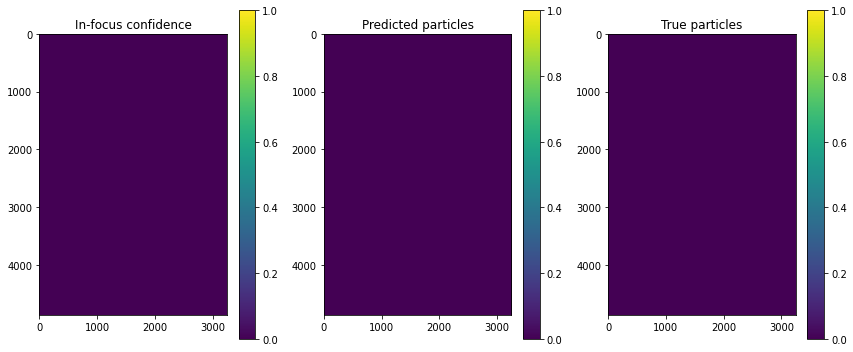

Plane: 49 at z: 0.021127999999999997 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   6%|▌         | 59/1000 [14:15<4:09:20, 15.90s/it]

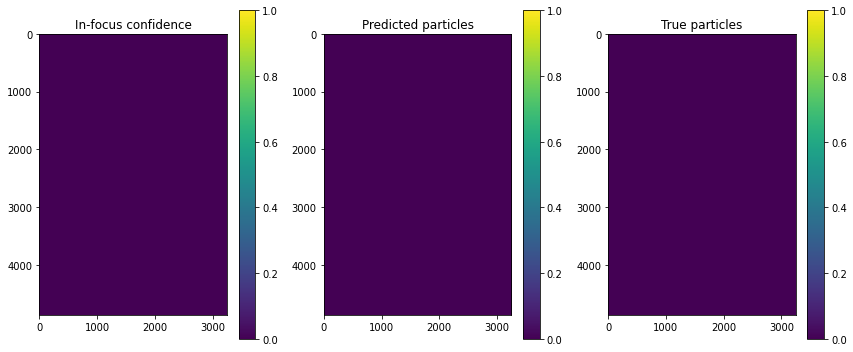

Plane: 50 at z: 0.021272 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   6%|▌         | 60/1000 [14:31<4:13:09, 16.16s/it]            

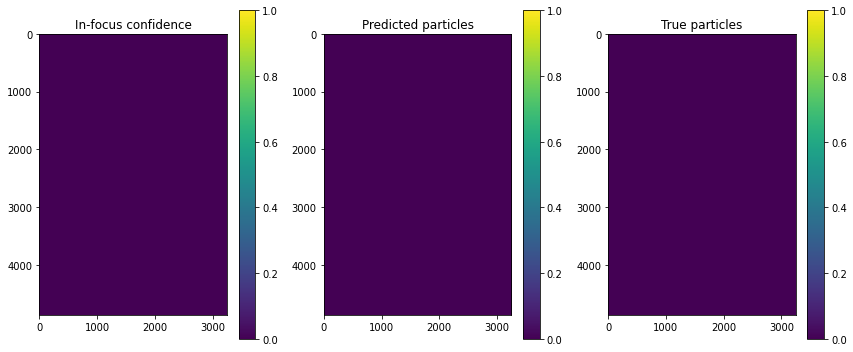

Plane: 51 at z: 0.021415999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   6%|▌         | 61/1000 [14:48<4:15:11, 16.31s/it]

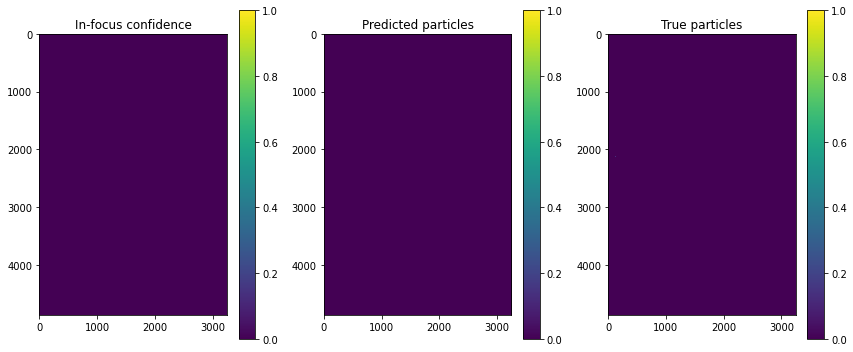

Plane: 52 at z: 0.02156 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   6%|▌         | 62/1000 [15:05<4:17:32, 16.47s/it]             

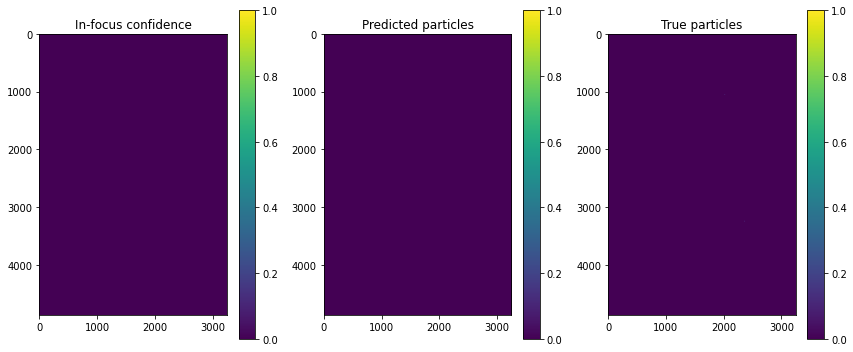

Plane: 53 at z: 0.021703999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   6%|▋         | 63/1000 [15:22<4:19:54, 16.64s/it]

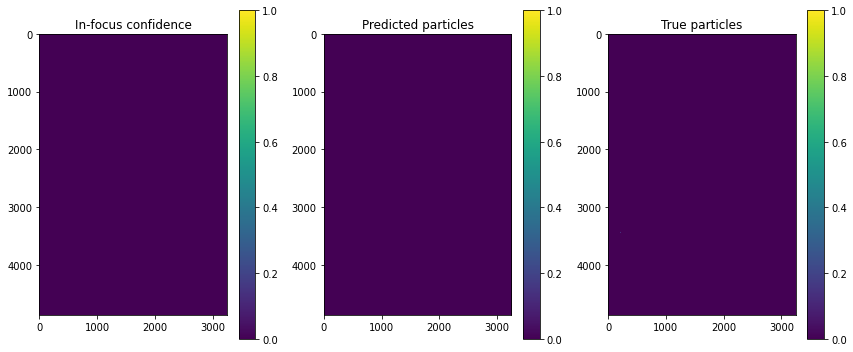

Plane: 54 at z: 0.021848 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   6%|▋         | 64/1000 [15:39<4:20:24, 16.69s/it]            

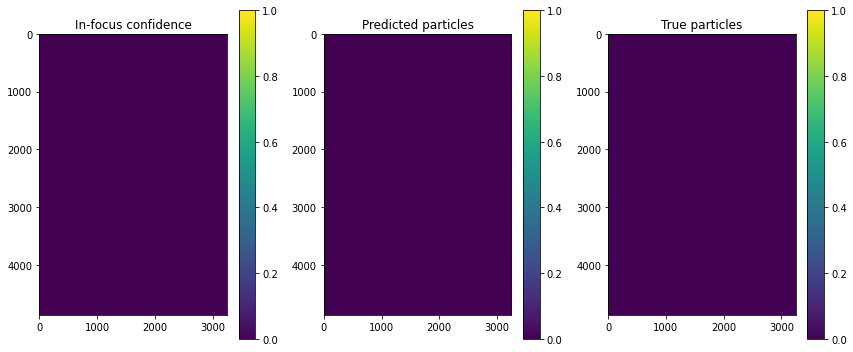

Plane: 55 at z: 0.021991999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   7%|▋         | 66/1000 [15:56<3:22:47, 13.03s/it]

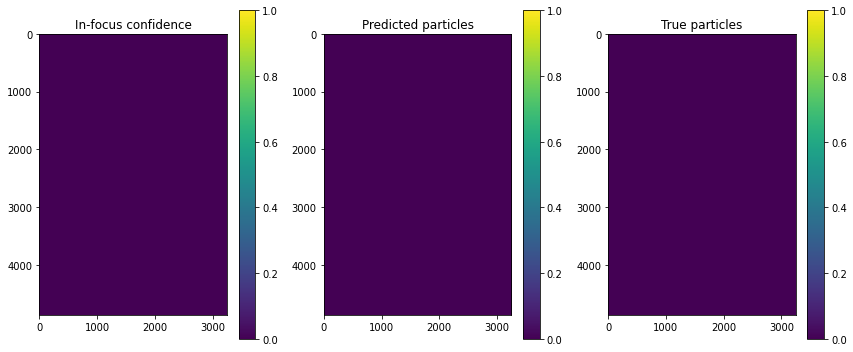

Plane: 56 at z: 0.022136 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   7%|▋         | 67/1000 [16:12<3:40:47, 14.20s/it]            

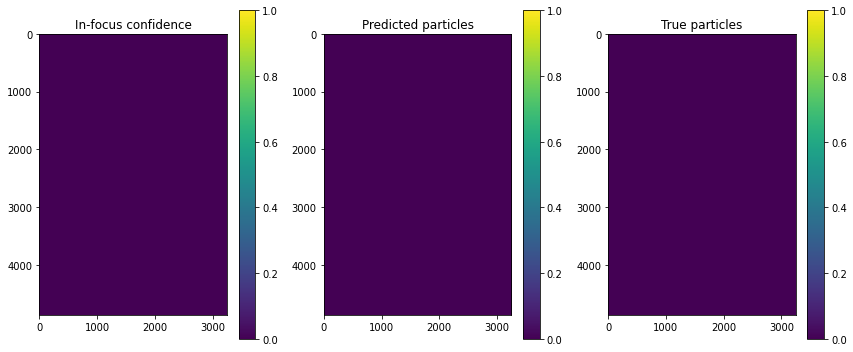

Plane: 57 at z: 0.022279999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   7%|▋         | 68/1000 [16:29<3:52:04, 14.94s/it]

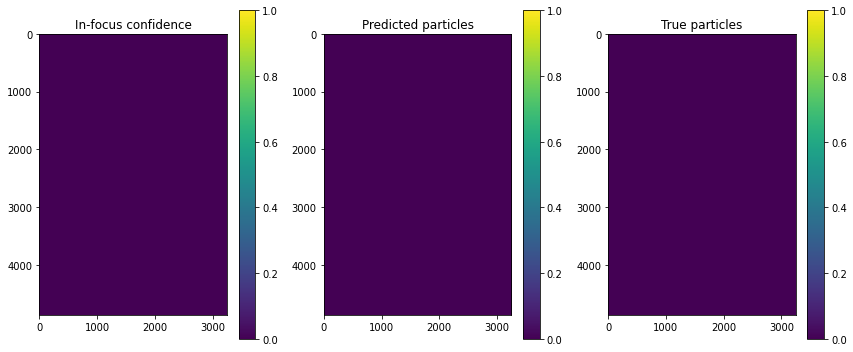

Plane: 58 at z: 0.022424 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   7%|▋         | 69/1000 [16:46<4:01:43, 15.58s/it]            

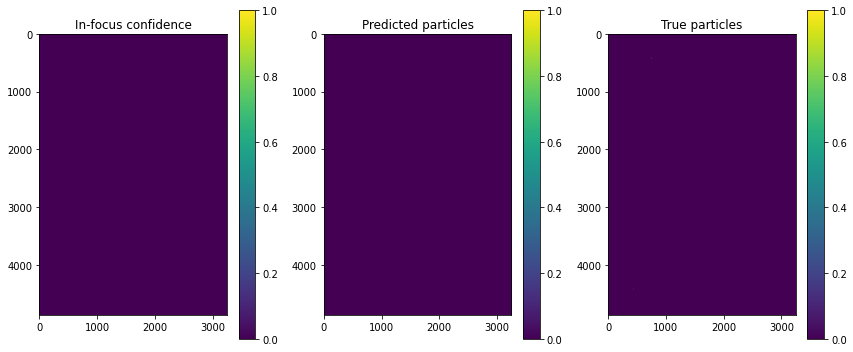

Plane: 59 at z: 0.022567999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   7%|▋         | 70/1000 [17:03<4:07:34, 15.97s/it]

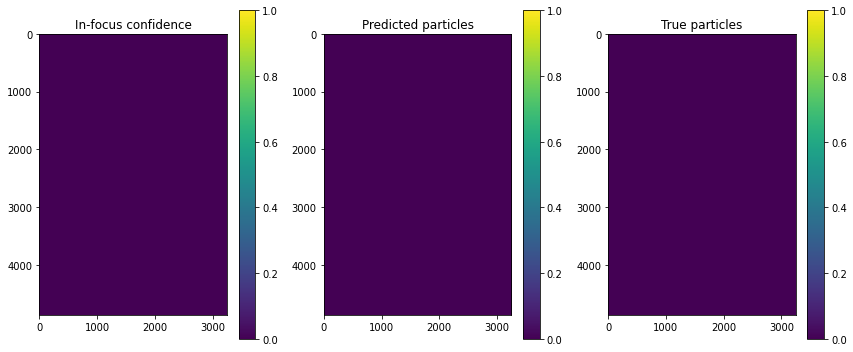

Plane: 60 at z: 0.022712 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   7%|▋         | 71/1000 [17:20<4:12:16, 16.29s/it]            

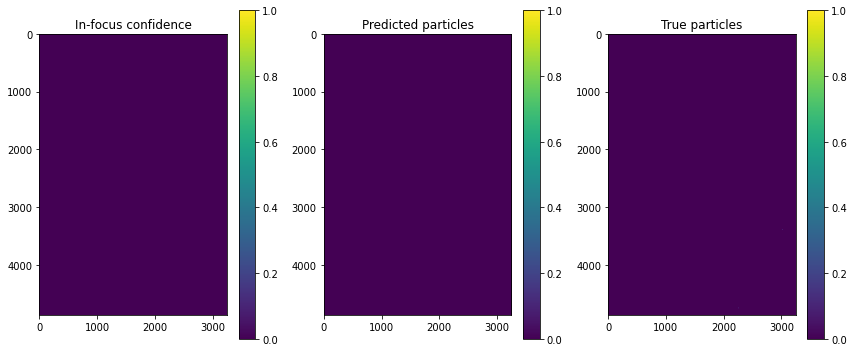

Plane: 61 at z: 0.022855999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   7%|▋         | 72/1000 [17:37<4:14:35, 16.46s/it]

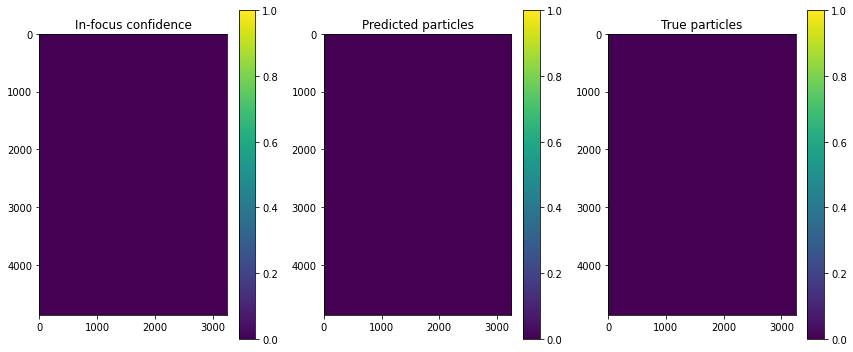

Plane: 62 at z: 0.023 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   7%|▋         | 73/1000 [17:54<4:15:23, 16.53s/it]               

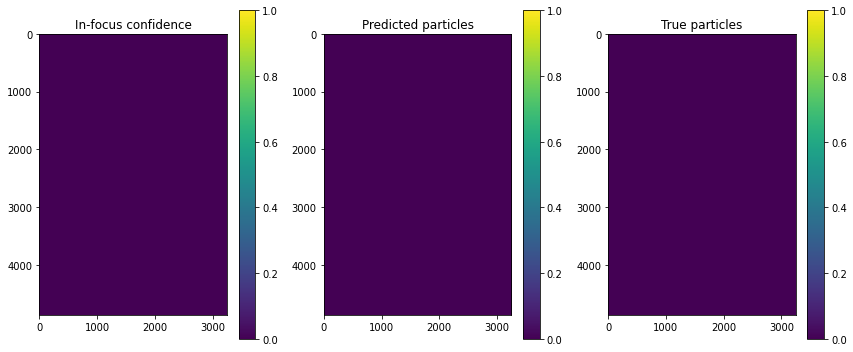

Plane: 63 at z: 0.023143999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   7%|▋         | 74/1000 [18:10<4:15:34, 16.56s/it]

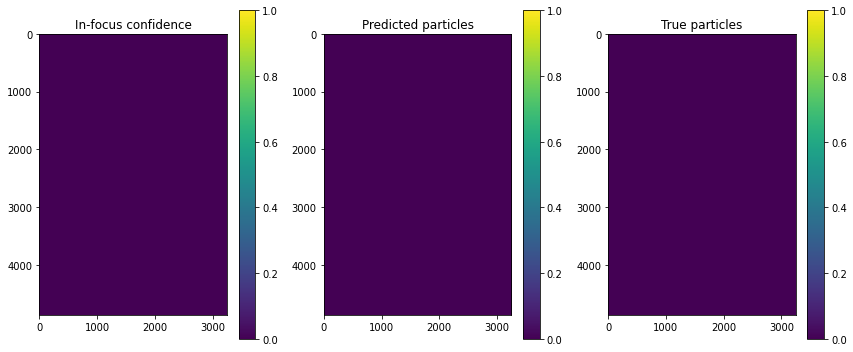

Plane: 64 at z: 0.023288 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0000:   8%|▊         | 75/1000 [18:27<4:17:13, 16.68s/it]            

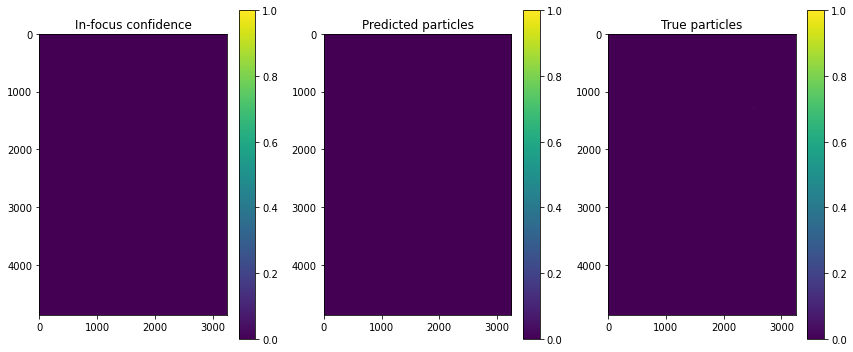

Plane: 65 at z: 0.023431999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0145 holo_csi: 0.0028:   8%|▊         | 76/1000 [18:44<4:18:40, 16.80s/it]

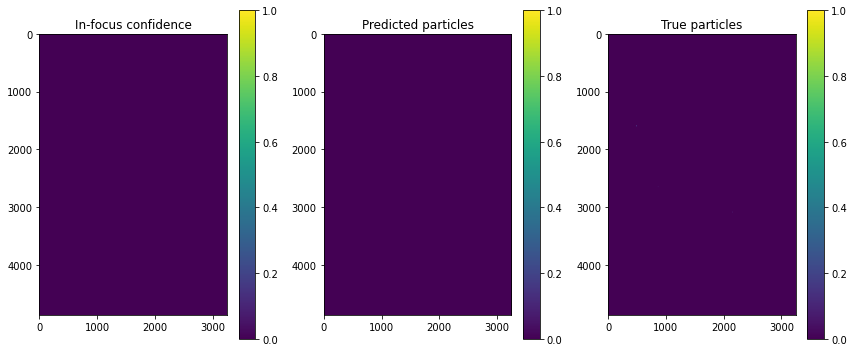

Plane: 66 at z: 0.023576 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0027:   8%|▊         | 78/1000 [19:01<3:22:10, 13.16s/it]            

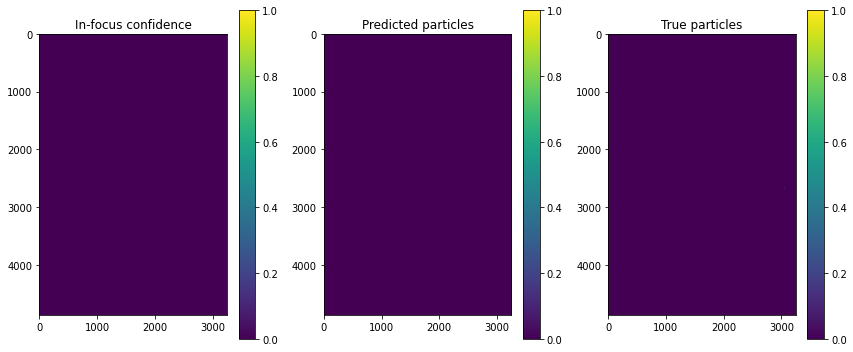

Plane: 67 at z: 0.023719999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0024:   8%|▊         | 79/1000 [19:19<3:39:54, 14.33s/it]

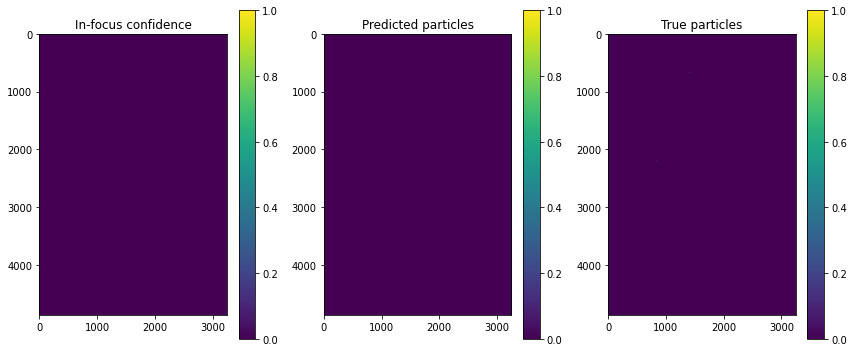

Plane: 68 at z: 0.023864 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0024:   8%|▊         | 80/1000 [19:35<3:51:22, 15.09s/it]            

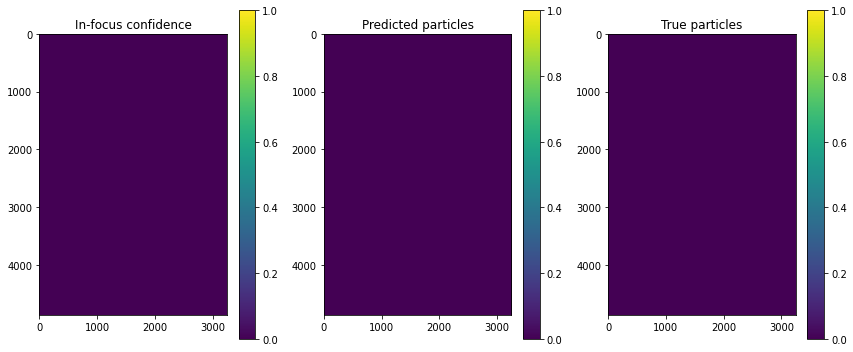

Plane: 69 at z: 0.024007999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0024:   8%|▊         | 81/1000 [19:52<3:58:54, 15.60s/it]

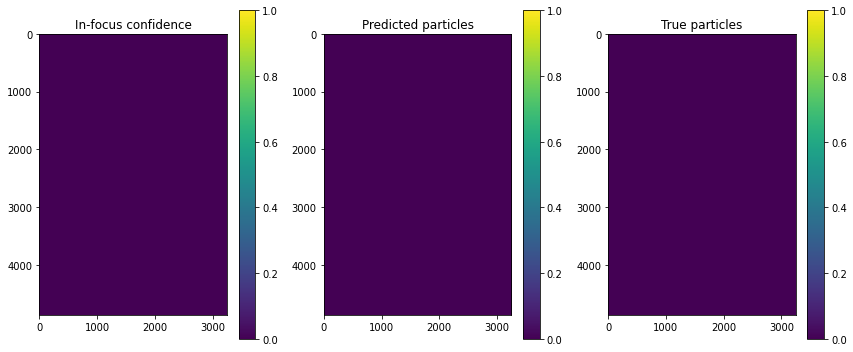

Plane: 70 at z: 0.024152 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0023:   8%|▊         | 82/1000 [20:09<4:04:57, 16.01s/it]            

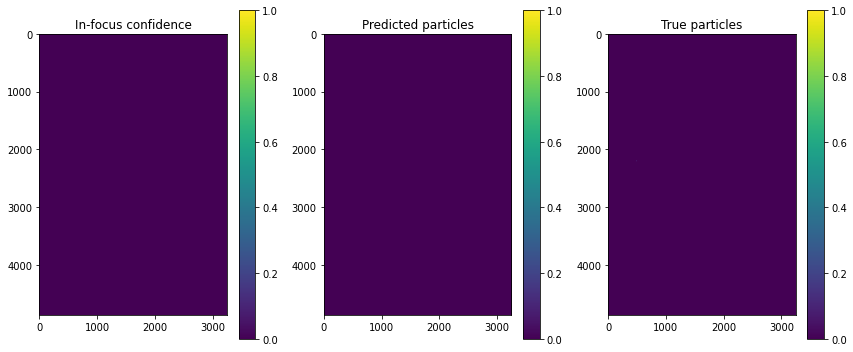

Plane: 71 at z: 0.024295999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0022:   8%|▊         | 83/1000 [20:26<4:08:56, 16.29s/it]

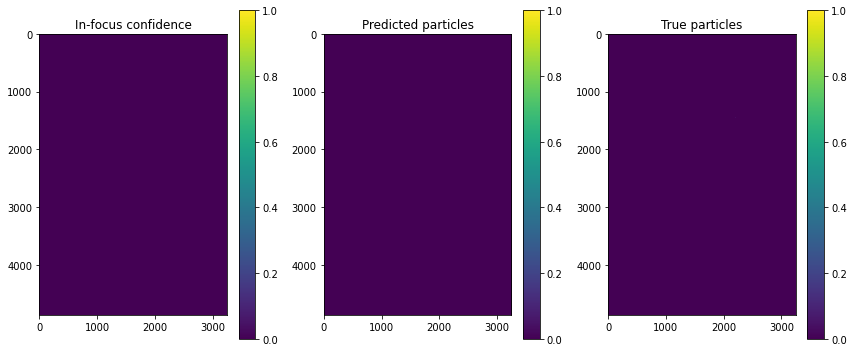

Plane: 72 at z: 0.02444 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0022:   8%|▊         | 84/1000 [20:43<4:10:40, 16.42s/it]             

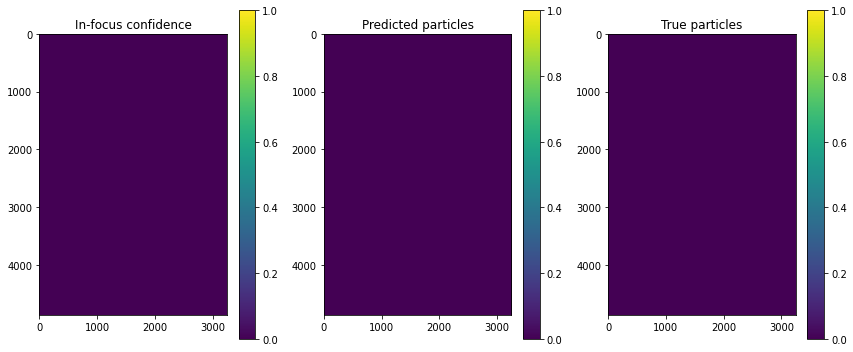

Plane: 73 at z: 0.024583999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0021:   8%|▊         | 85/1000 [21:00<4:13:22, 16.61s/it]

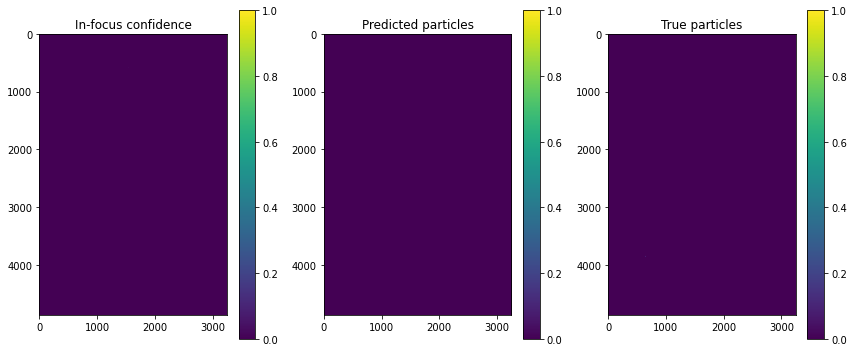

Plane: 74 at z: 0.024728 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0020:   9%|▊         | 86/1000 [21:17<4:14:28, 16.70s/it]            

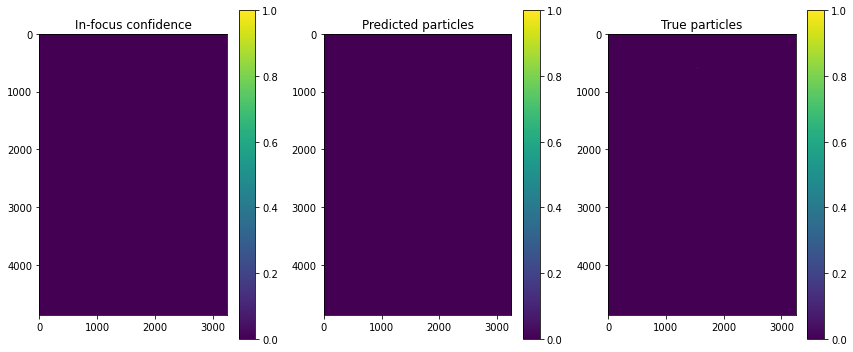

Plane: 75 at z: 0.024872 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0019:   9%|▊         | 87/1000 [21:34<4:15:00, 16.76s/it]

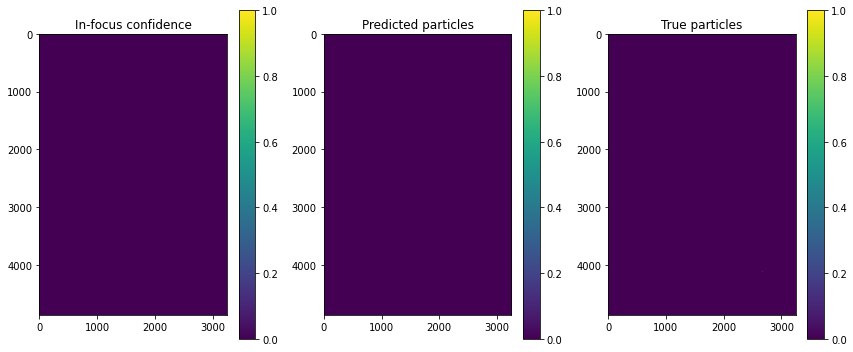

Plane: 76 at z: 0.025016 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0017:   9%|▉         | 88/1000 [21:51<4:16:17, 16.86s/it]

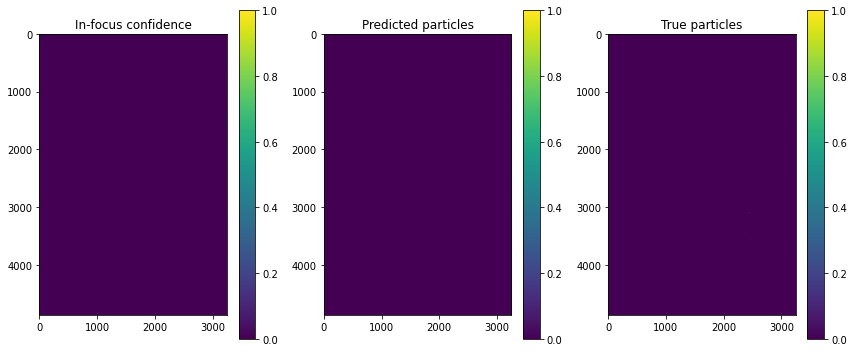

Plane: 77 at z: 0.02516 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0015:   9%|▉         | 89/1000 [22:08<4:16:45, 16.91s/it] 

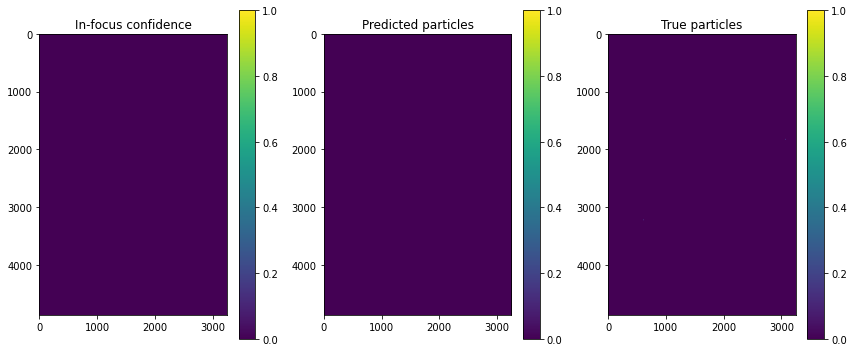

Plane: 78 at z: 0.025304 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0015:   9%|▉         | 91/1000 [22:25<3:19:31, 13.17s/it]

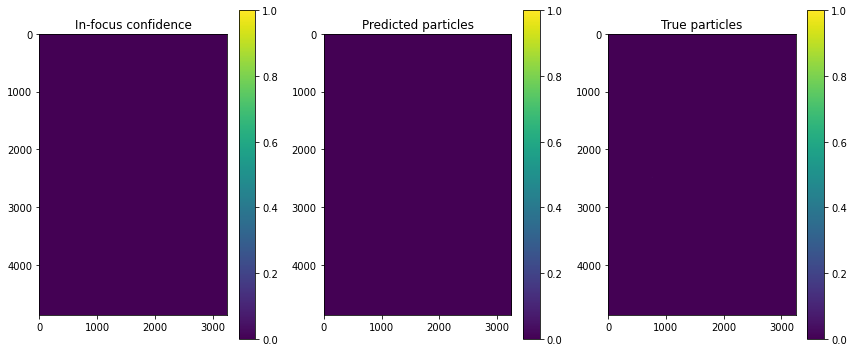

Plane: 79 at z: 0.025448 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0015:   9%|▉         | 92/1000 [22:42<3:36:30, 14.31s/it]

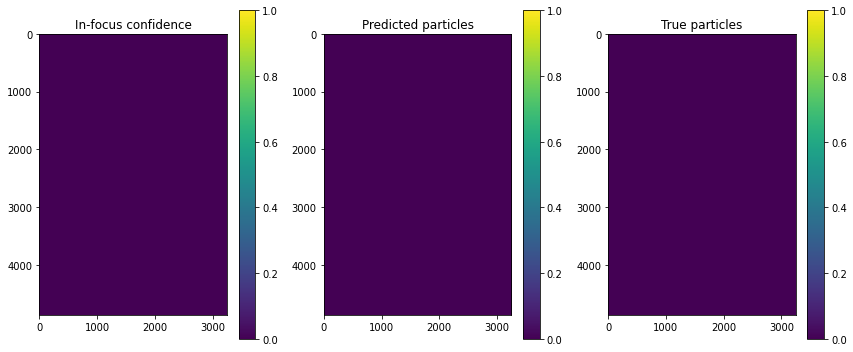

Plane: 80 at z: 0.025592 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0015:   9%|▉         | 93/1000 [22:58<3:45:57, 14.95s/it]

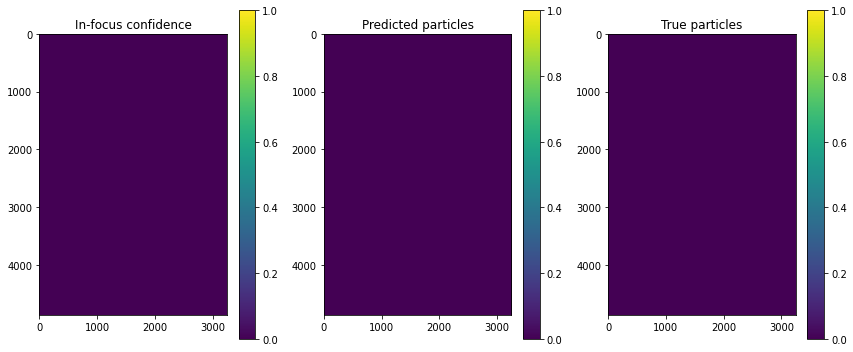

Plane: 81 at z: 0.025736 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0015:   9%|▉         | 94/1000 [23:15<3:53:21, 15.45s/it]

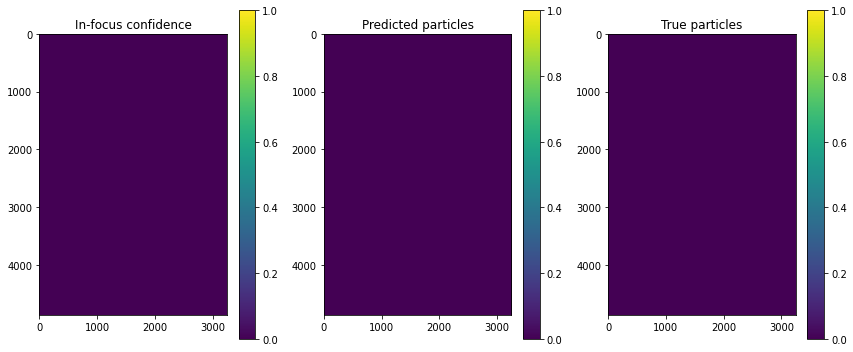

Plane: 82 at z: 0.025879 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0015:  10%|▉         | 95/1000 [23:32<3:59:38, 15.89s/it]

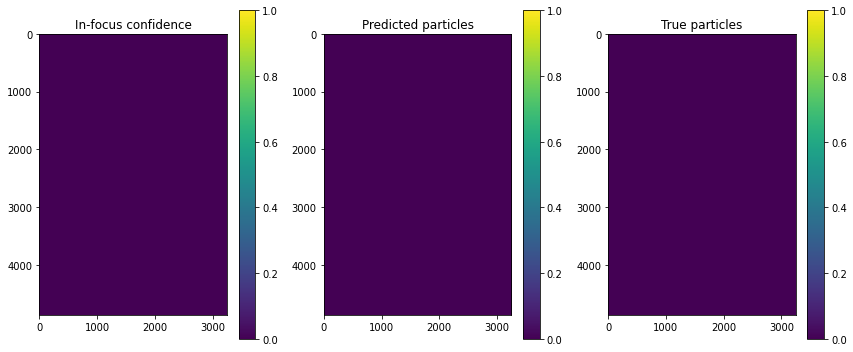

Plane: 83 at z: 0.026022999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0015:  10%|▉         | 96/1000 [23:48<4:03:21, 16.15s/it]

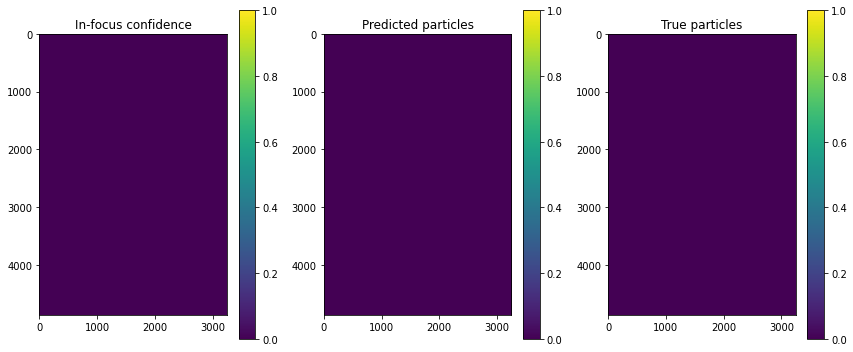

Plane: 84 at z: 0.026168 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0014:  10%|▉         | 97/1000 [24:05<4:07:16, 16.43s/it]            

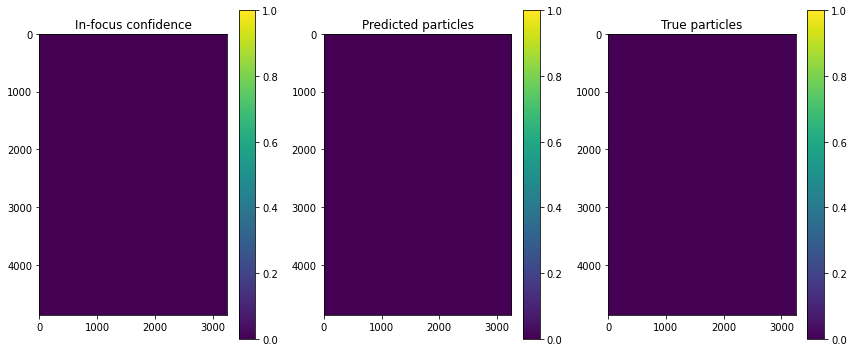

Plane: 85 at z: 0.026312 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0014:  10%|▉         | 98/1000 [24:22<4:09:02, 16.57s/it]

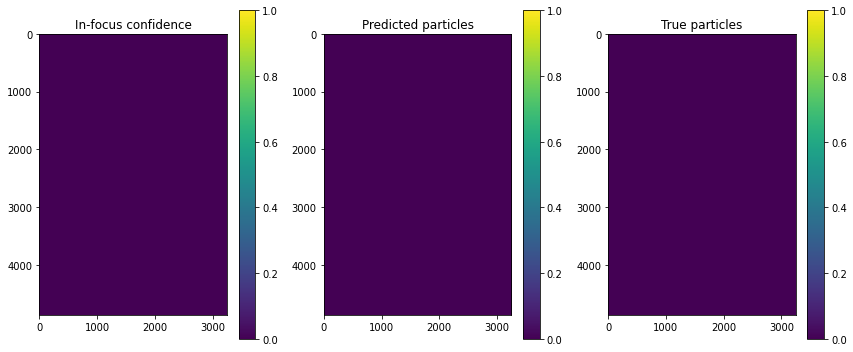

Plane: 86 at z: 0.026455 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0014:  10%|▉         | 99/1000 [24:39<4:09:47, 16.63s/it]

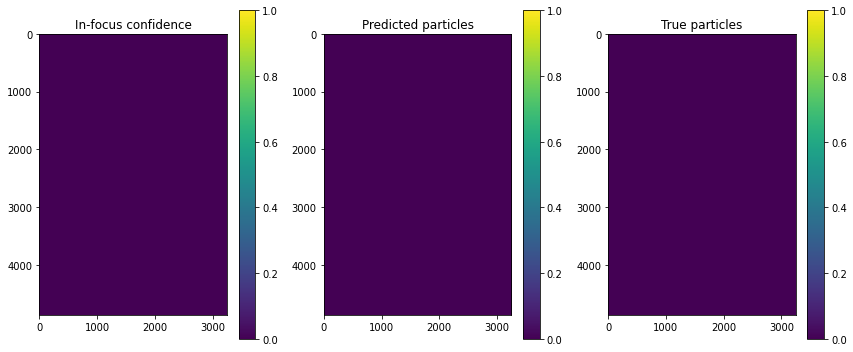

Plane: 87 at z: 0.026598999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0014:  10%|█         | 100/1000 [24:56<4:09:00, 16.60s/it]

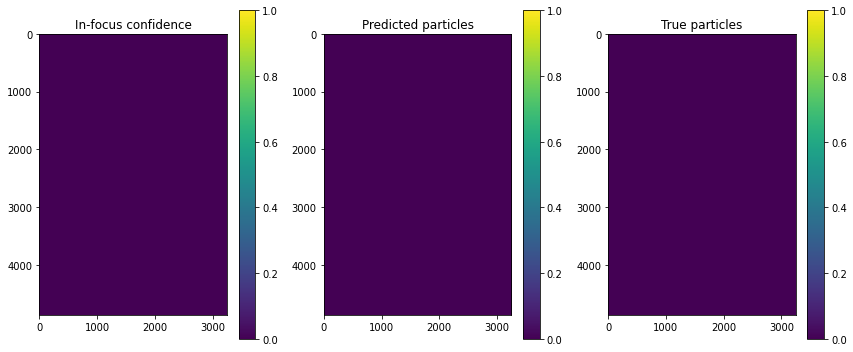

Plane: 88 at z: 0.026744 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0013:  10%|█         | 101/1000 [25:13<4:09:52, 16.68s/it]            

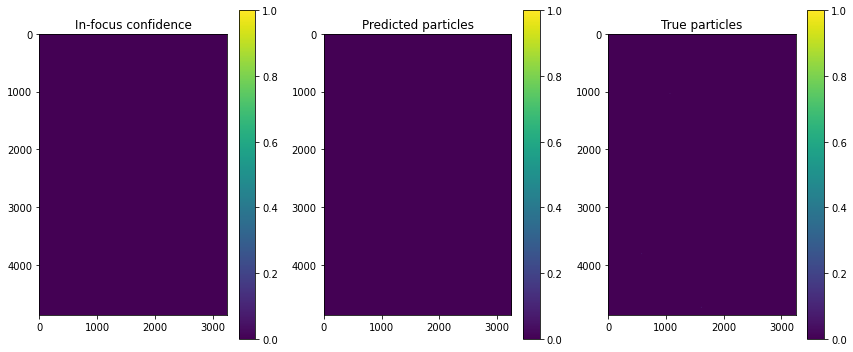

Plane: 89 at z: 0.026888 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0013:  10%|█         | 102/1000 [25:29<4:09:40, 16.68s/it]

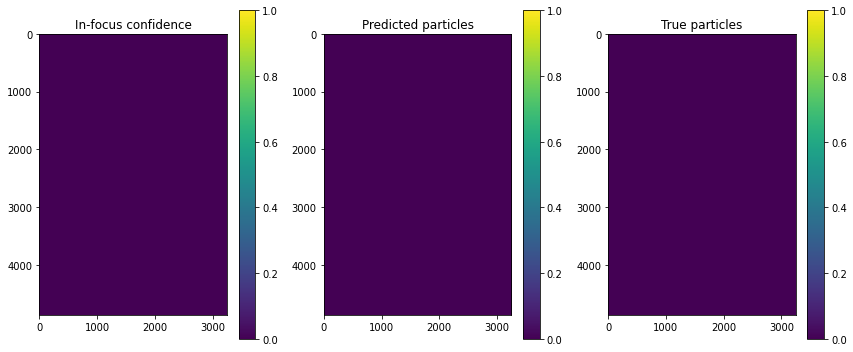

Plane: 90 at z: 0.027031 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0013:  10%|█         | 103/1000 [25:46<4:10:40, 16.77s/it]

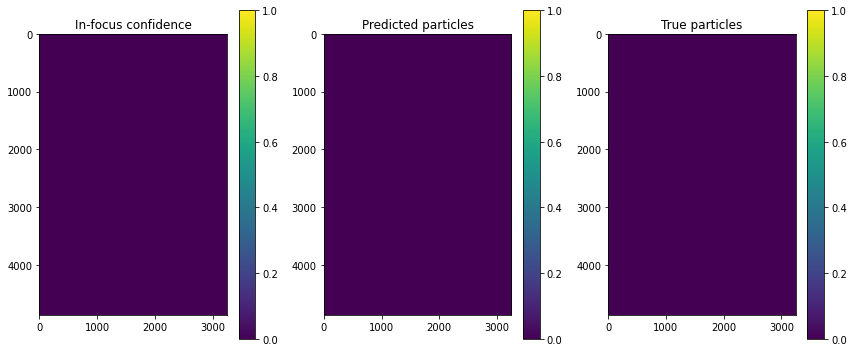

Plane: 91 at z: 0.027174999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0012:  10%|█         | 105/1000 [26:03<3:16:06, 13.15s/it]

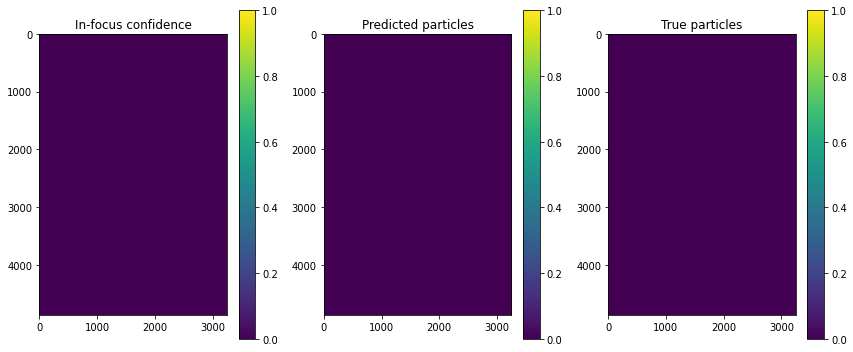

Plane: 92 at z: 0.027319999999999997 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0012:  11%|█         | 106/1000 [26:20<3:33:24, 14.32s/it]

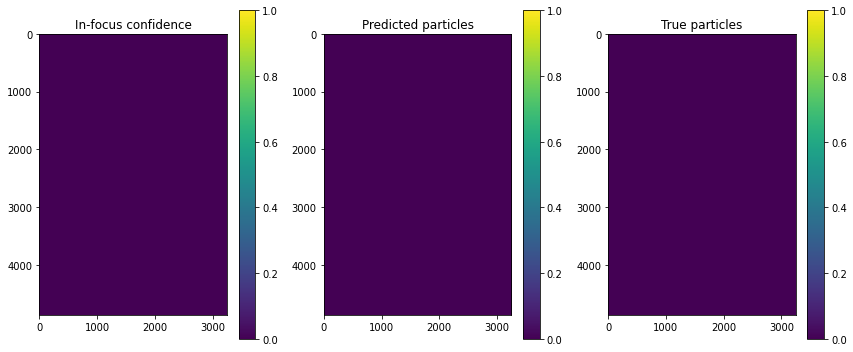

Plane: 93 at z: 0.027464 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0011:  11%|█         | 107/1000 [26:37<3:44:56, 15.11s/it]            

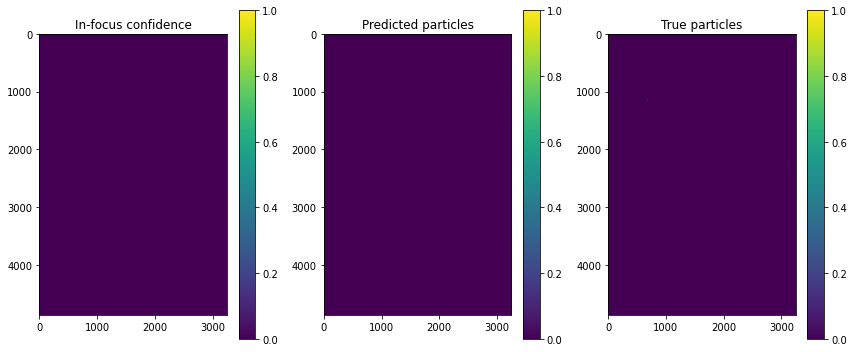

Plane: 94 at z: 0.027607 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0011:  11%|█         | 108/1000 [26:54<3:51:46, 15.59s/it]

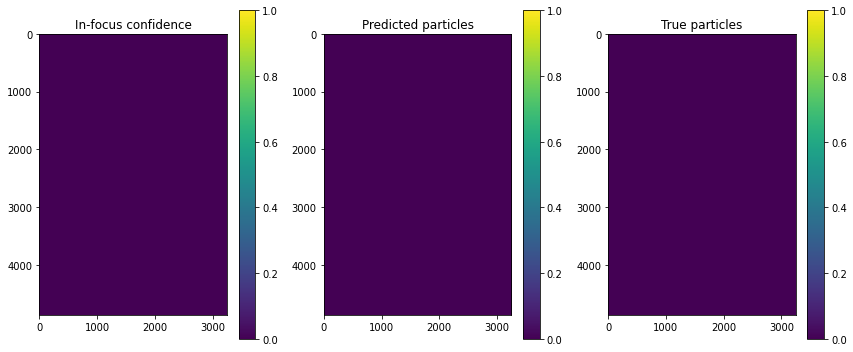

Plane: 95 at z: 0.027750999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0011:  11%|█         | 109/1000 [27:11<3:57:12, 15.97s/it]

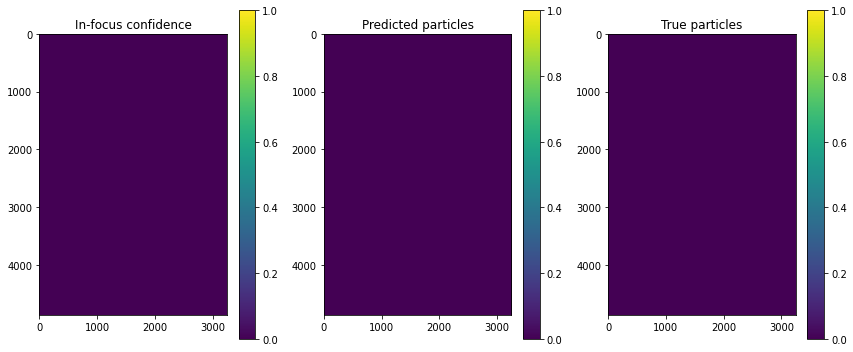

Plane: 96 at z: 0.027895999999999997 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0011:  11%|█         | 110/1000 [27:28<4:01:12, 16.26s/it]

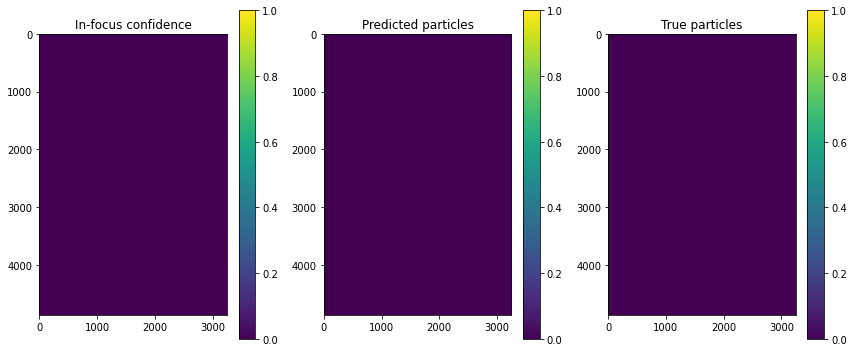

Plane: 97 at z: 0.02804 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0010:  11%|█         | 111/1000 [27:45<4:04:31, 16.50s/it]             

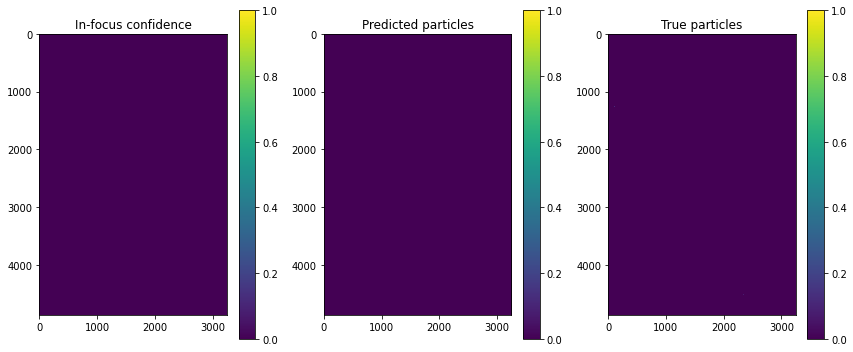

Plane: 98 at z: 0.028183 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0010:  11%|█         | 112/1000 [28:02<4:05:59, 16.62s/it]

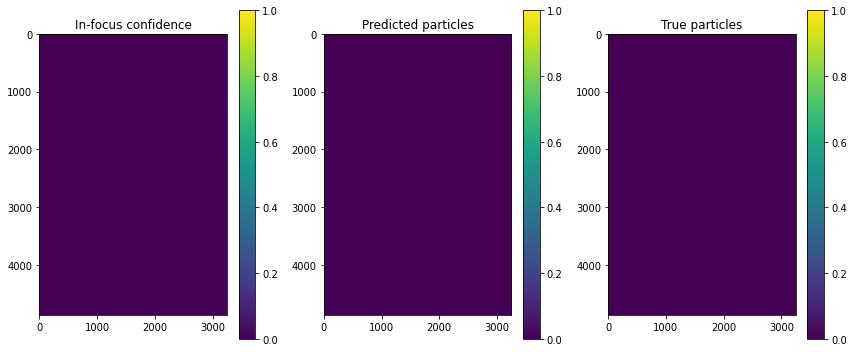

Plane: 99 at z: 0.028326999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0010:  11%|█▏        | 113/1000 [28:19<4:07:04, 16.71s/it]

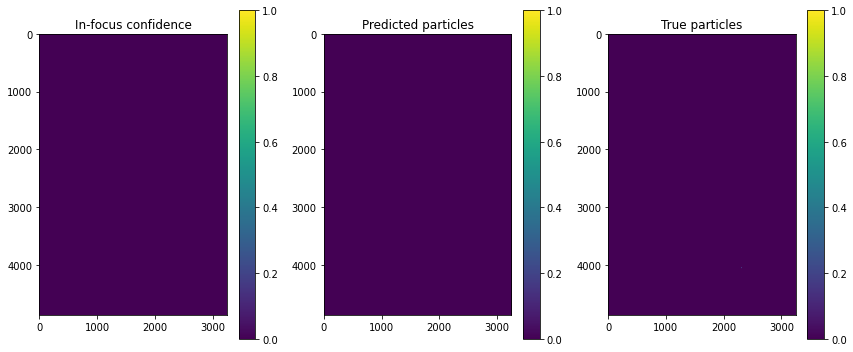

Plane: 100 at z: 0.028471999999999997 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0010:  11%|█▏        | 114/1000 [28:35<4:07:10, 16.74s/it]

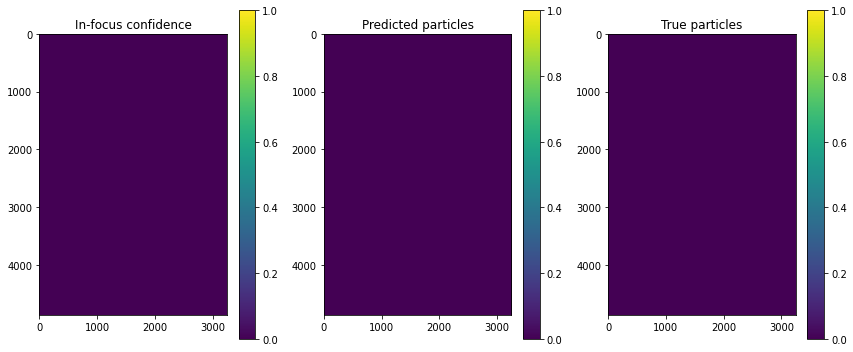

Plane: 101 at z: 0.028616 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0010:  12%|█▏        | 115/1000 [28:52<4:06:54, 16.74s/it]            

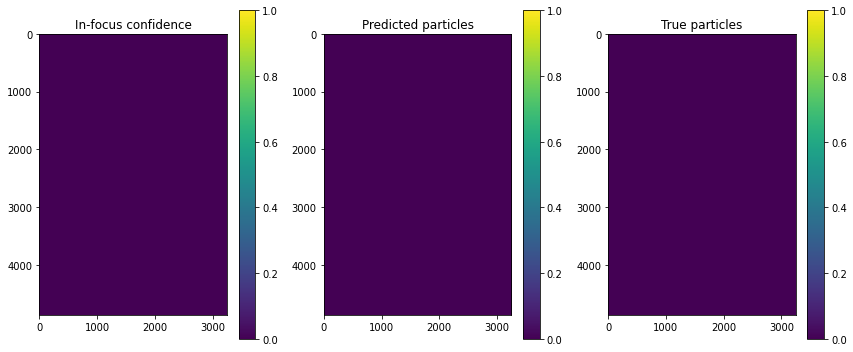

Plane: 102 at z: 0.028759999999999997 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0010:  12%|█▏        | 116/1000 [29:09<4:06:44, 16.75s/it]

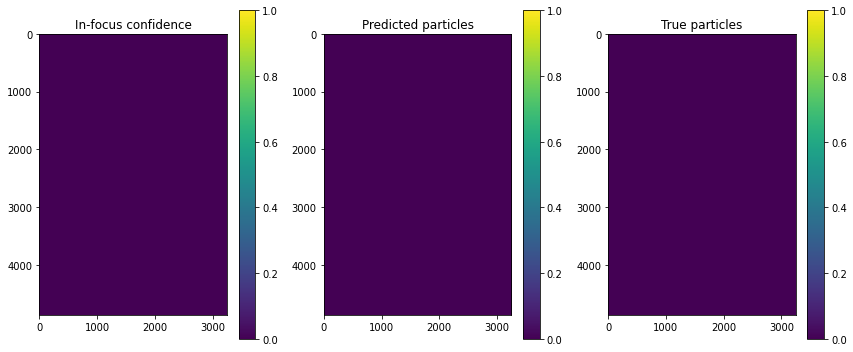

Plane: 103 at z: 0.028904 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0010:  12%|█▏        | 117/1000 [29:26<4:06:34, 16.75s/it]            

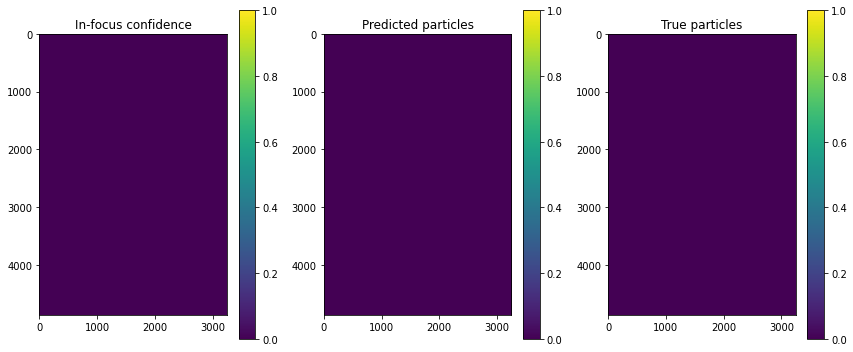

Plane: 104 at z: 0.029047999999999997 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0010:  12%|█▏        | 118/1000 [29:43<4:07:16, 16.82s/it]

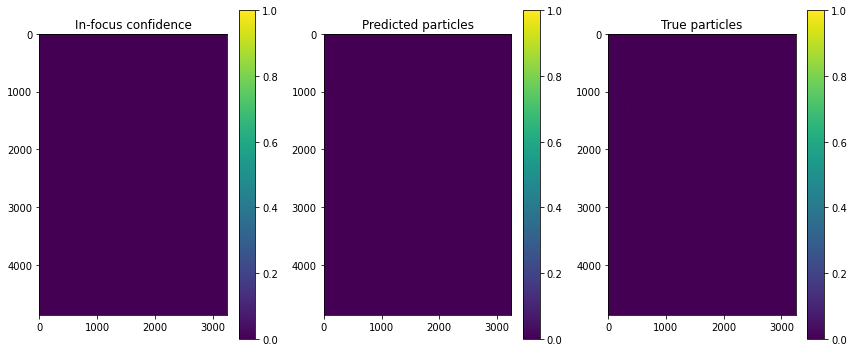

Plane: 105 at z: 0.029192 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0010:  12%|█▏        | 120/1000 [30:00<3:12:31, 13.13s/it]            

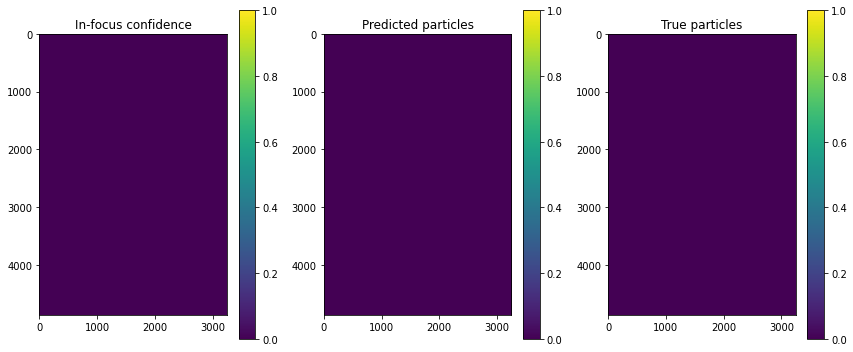

Plane: 106 at z: 0.029335999999999997 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0009:  12%|█▏        | 121/1000 [30:16<3:27:58, 14.20s/it]

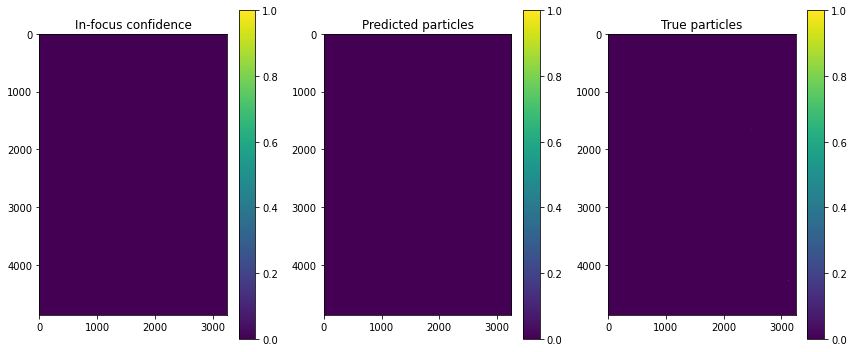

Plane: 107 at z: 0.02948 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0009:  12%|█▏        | 122/1000 [30:33<3:38:36, 14.94s/it]             

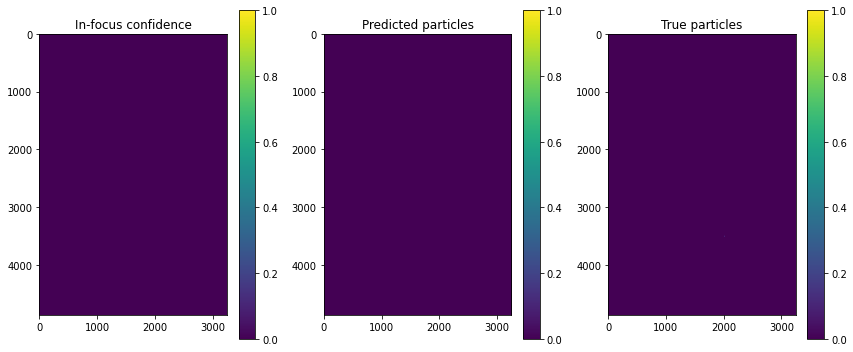

Plane: 108 at z: 0.029623999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0009:  12%|█▏        | 123/1000 [30:50<3:46:27, 15.49s/it]

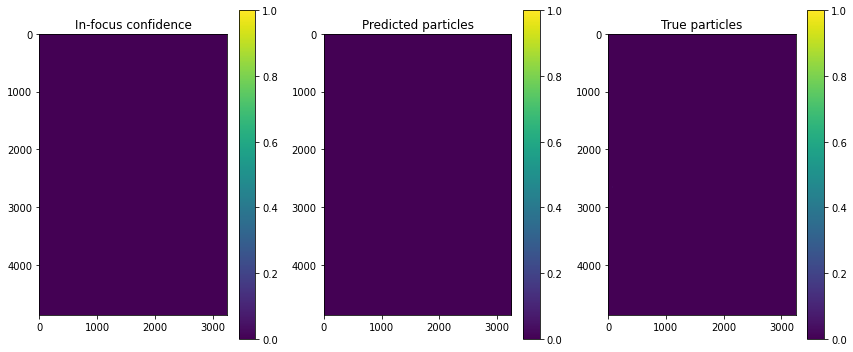

Plane: 109 at z: 0.029768 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0008:  12%|█▏        | 124/1000 [31:07<3:52:41, 15.94s/it]            

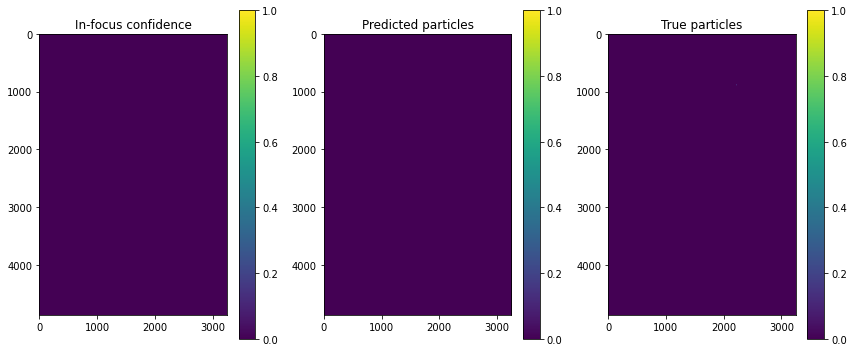

Plane: 110 at z: 0.029911999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0008:  12%|█▎        | 125/1000 [31:24<3:56:43, 16.23s/it]

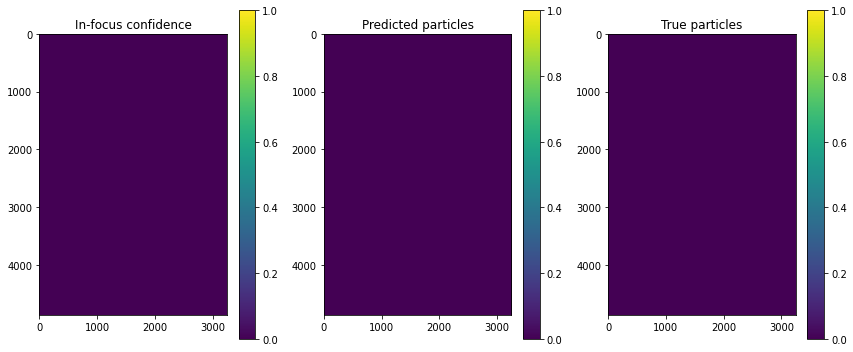

Plane: 111 at z: 0.030055 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0008:  13%|█▎        | 126/1000 [31:41<3:59:34, 16.45s/it]            

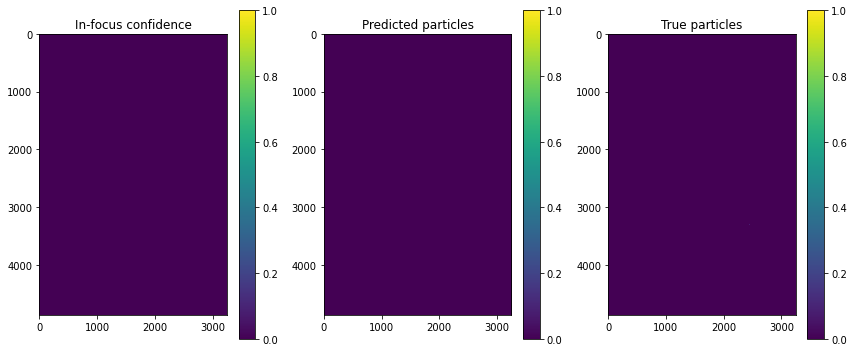

Plane: 112 at z: 0.030199999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0008:  13%|█▎        | 127/1000 [31:58<4:01:10, 16.58s/it]

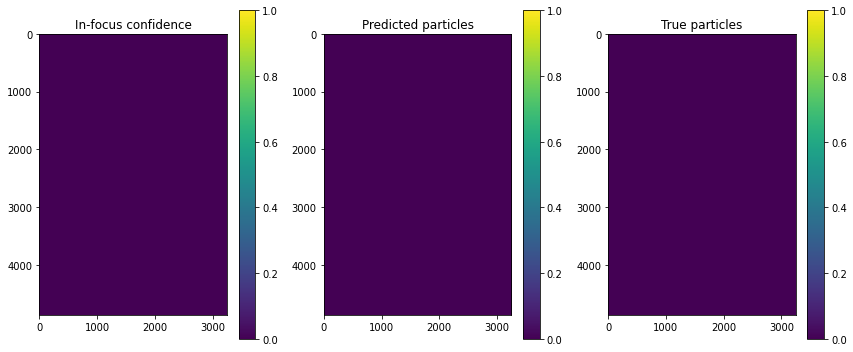

Plane: 113 at z: 0.030344 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0008:  13%|█▎        | 128/1000 [32:14<4:01:07, 16.59s/it]            

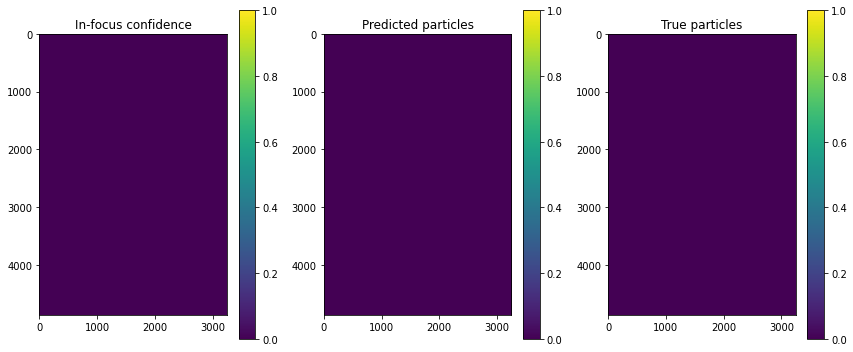

Plane: 114 at z: 0.030487999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0008:  13%|█▎        | 129/1000 [32:31<4:01:27, 16.63s/it]

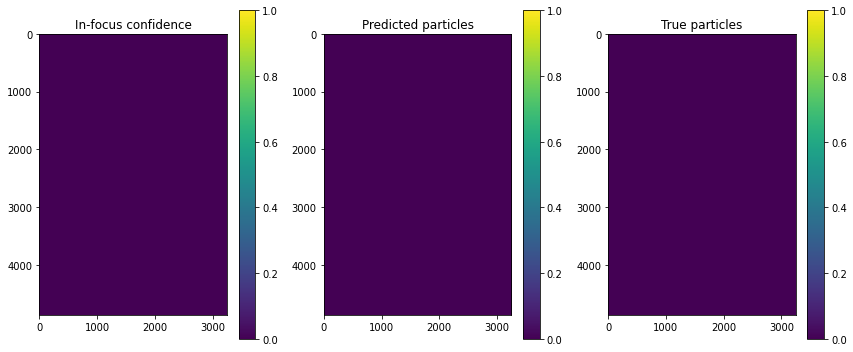

Plane: 115 at z: 0.030631 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0008:  13%|█▎        | 130/1000 [32:48<4:02:34, 16.73s/it]            

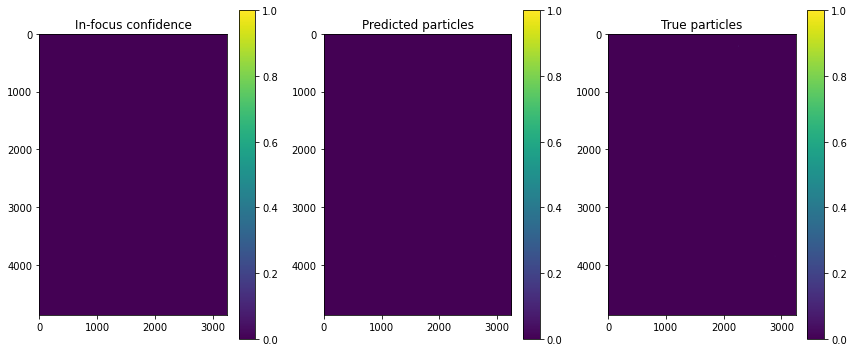

Plane: 116 at z: 0.030775999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0008:  13%|█▎        | 131/1000 [33:05<4:02:50, 16.77s/it]

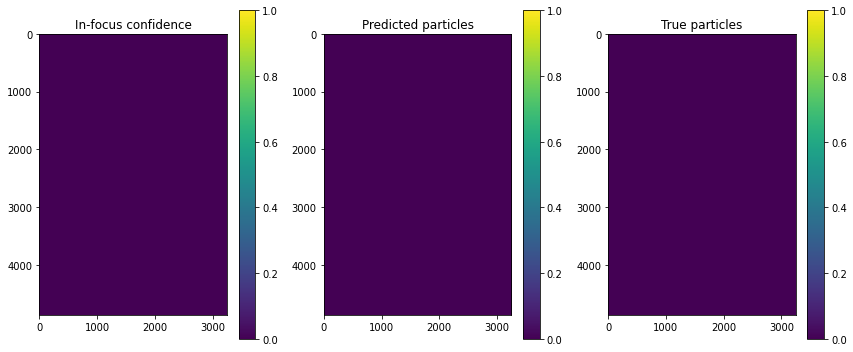

Plane: 117 at z: 0.03092 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0008:  13%|█▎        | 132/1000 [33:21<4:02:25, 16.76s/it]             

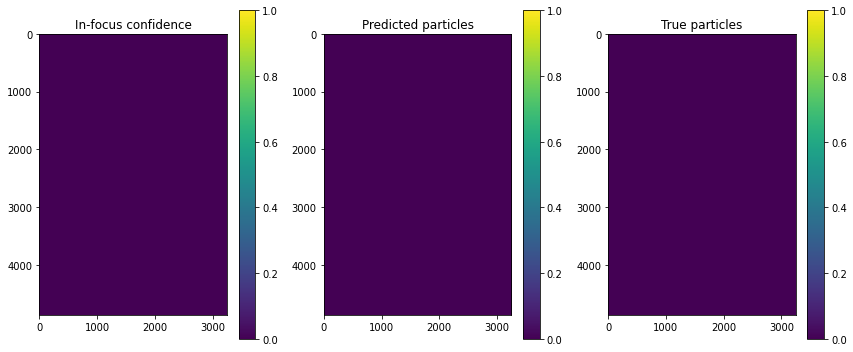

Plane: 118 at z: 0.031063999999999998 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.1304 holo_csi: 0.0031:  13%|█▎        | 133/1000 [33:39<4:03:44, 16.87s/it]

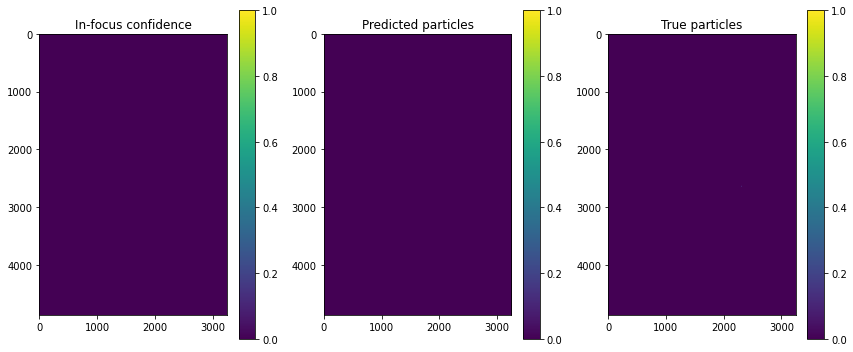

Plane: 119 at z: 0.031207 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0031:  13%|█▎        | 134/1000 [33:55<4:02:41, 16.82s/it]            

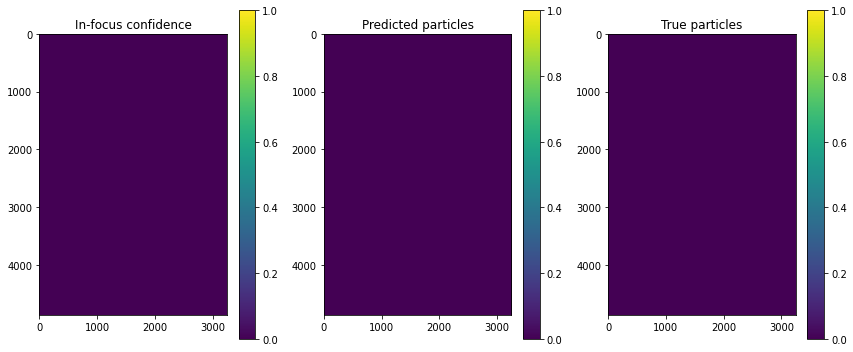

Plane: 120 at z: 0.031352 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0030:  14%|█▎        | 136/1000 [34:12<3:08:42, 13.10s/it]

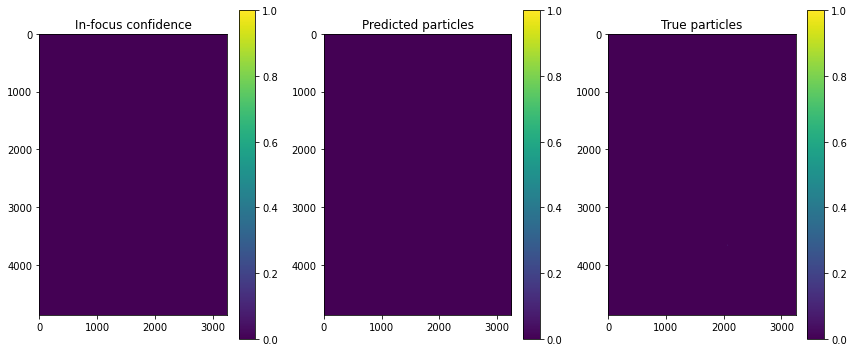

Plane: 121 at z: 0.031495999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0030:  14%|█▎        | 137/1000 [34:29<3:24:11, 14.20s/it]

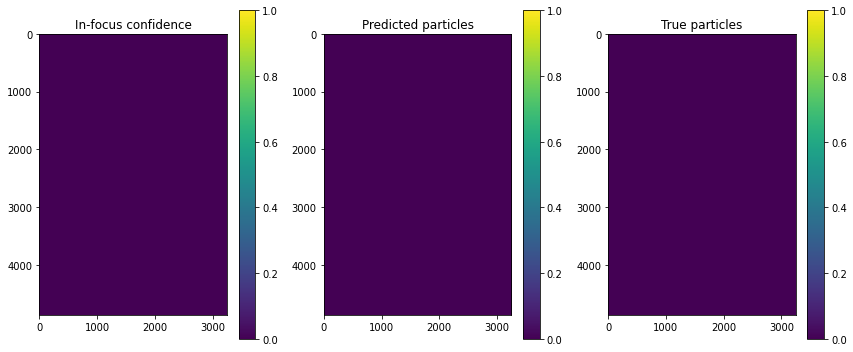

Plane: 122 at z: 0.03164 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0222 holo_csi: 0.0036:  14%|█▍        | 138/1000 [34:46<3:36:02, 15.04s/it]             

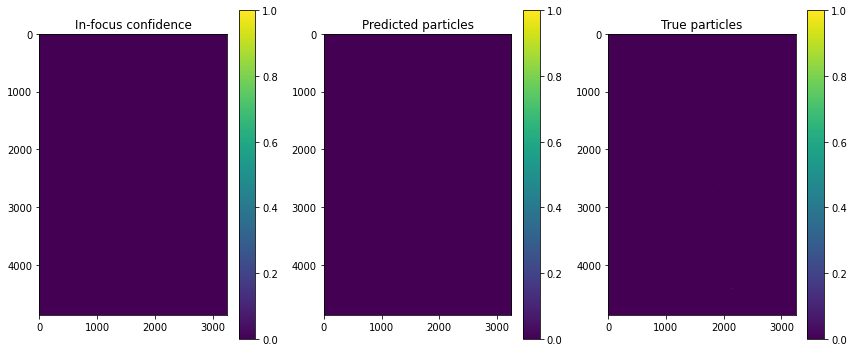

Plane: 123 at z: 0.031783 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0036:  14%|█▍        | 139/1000 [35:03<3:43:38, 15.59s/it]

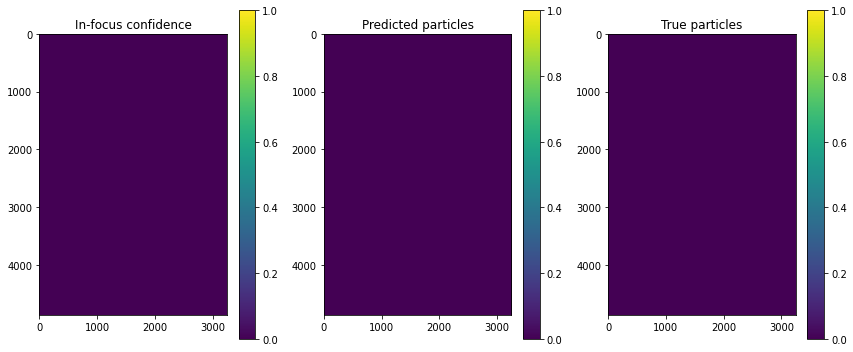

Plane: 124 at z: 0.031928 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0036:  14%|█▍        | 140/1000 [35:20<3:49:22, 16.00s/it]

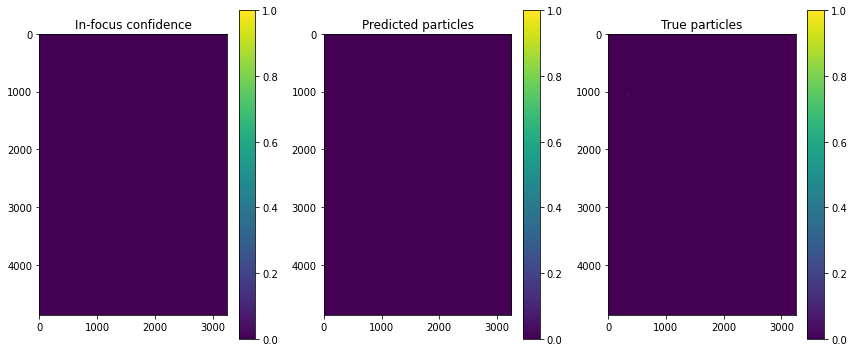

Plane: 125 at z: 0.032071999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0035:  14%|█▍        | 141/1000 [35:37<3:52:59, 16.27s/it]

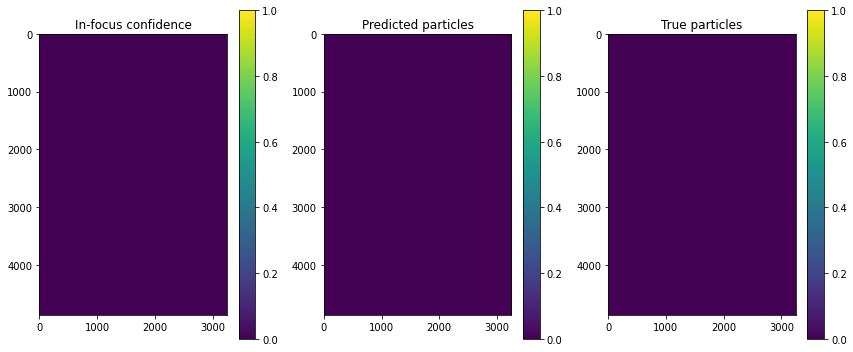

Plane: 126 at z: 0.032216 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0035:  14%|█▍        | 142/1000 [35:53<3:54:40, 16.41s/it]            

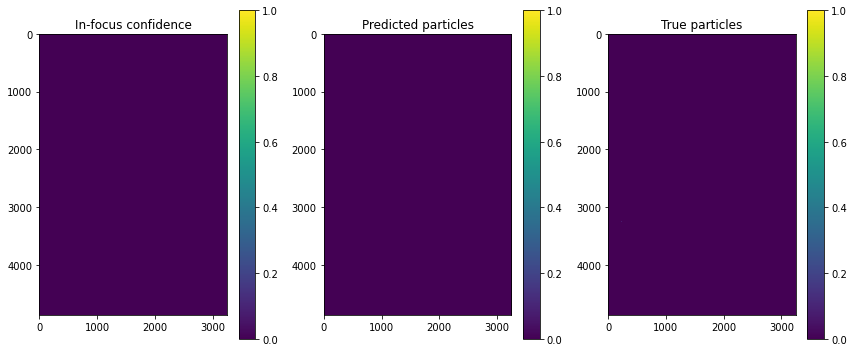

Plane: 127 at z: 0.032359 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0034:  14%|█▍        | 143/1000 [36:10<3:53:28, 16.35s/it]

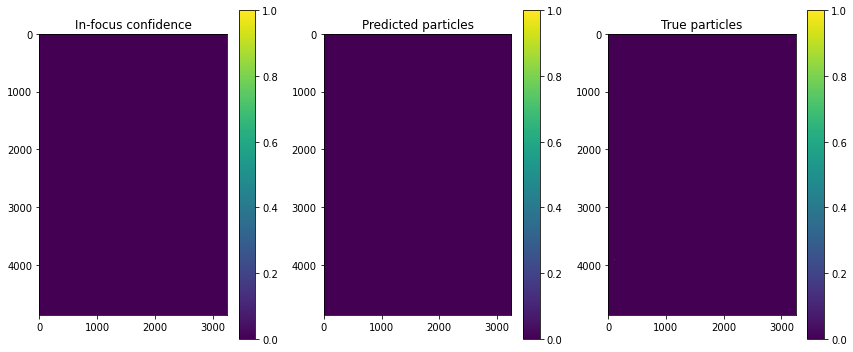

Plane: 128 at z: 0.032503 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0034:  14%|█▍        | 144/1000 [36:26<3:53:58, 16.40s/it]

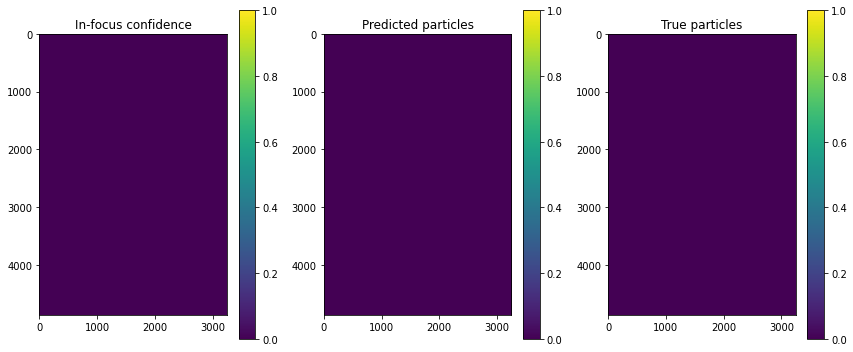

Plane: 129 at z: 0.032646999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0033:  14%|█▍        | 145/1000 [36:43<3:55:11, 16.51s/it]

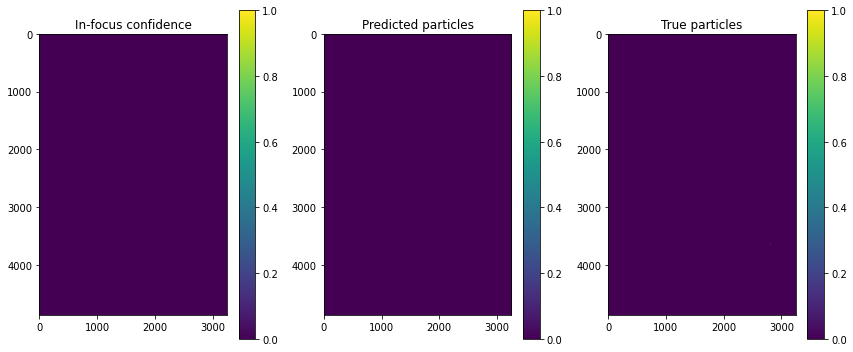

Plane: 130 at z: 0.032792 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0033:  15%|█▍        | 146/1000 [36:59<3:55:21, 16.54s/it]            

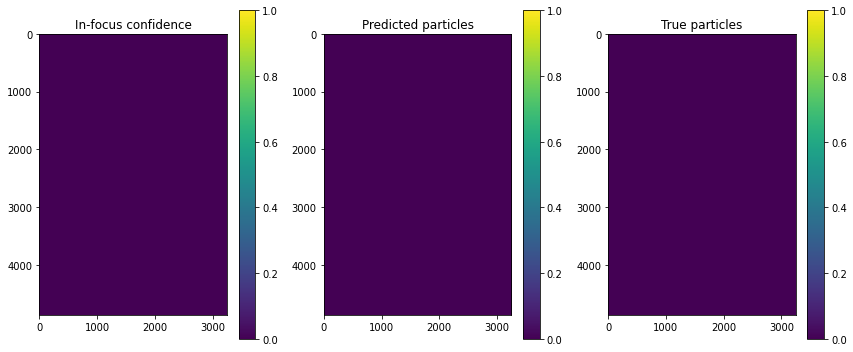

Plane: 131 at z: 0.032936 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0031:  15%|█▍        | 147/1000 [37:17<3:58:52, 16.80s/it]

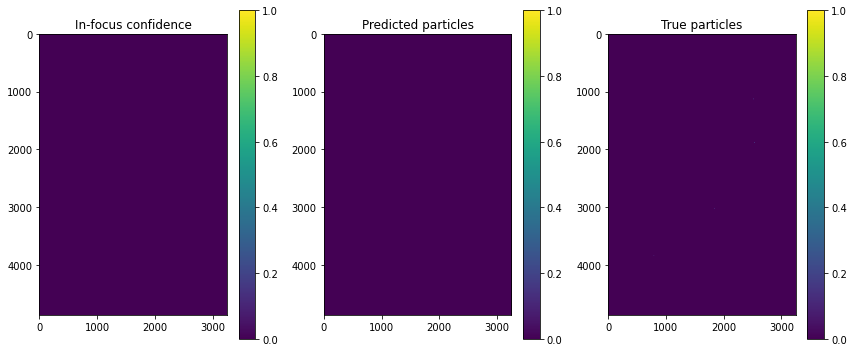

Plane: 132 at z: 0.033079 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0030:  15%|█▍        | 148/1000 [37:34<4:00:02, 16.90s/it]

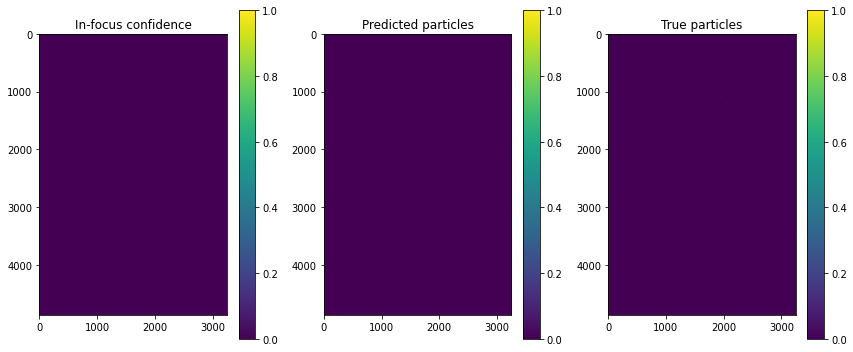

Plane: 133 at z: 0.033224 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0029:  15%|█▍        | 149/1000 [37:51<4:01:49, 17.05s/it]

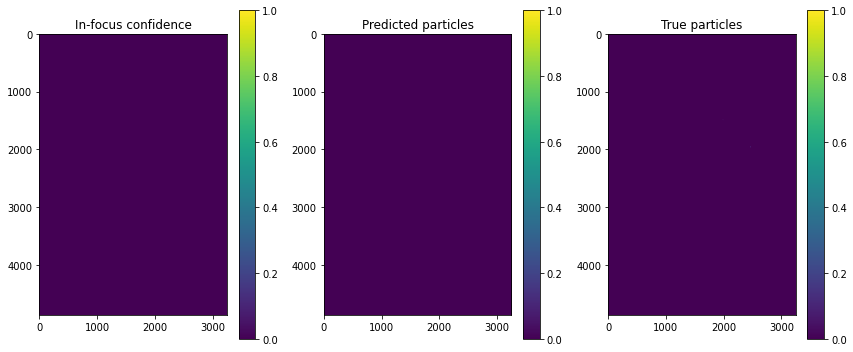

Plane: 134 at z: 0.033368 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0029:  15%|█▌        | 150/1000 [38:09<4:02:52, 17.14s/it]

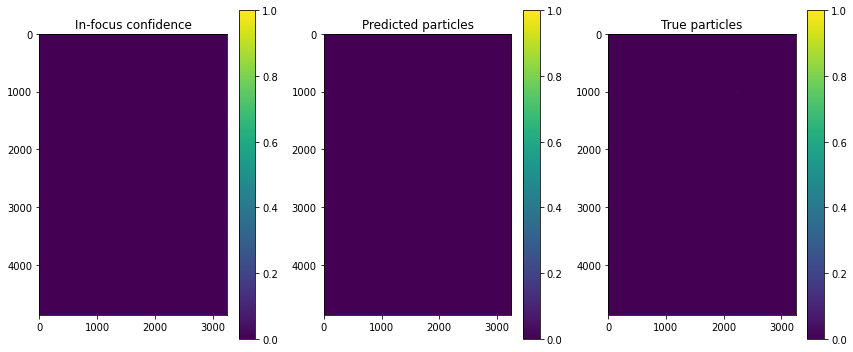

Plane: 135 at z: 0.033512 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0029:  15%|█▌        | 151/1000 [38:26<4:03:03, 17.18s/it]

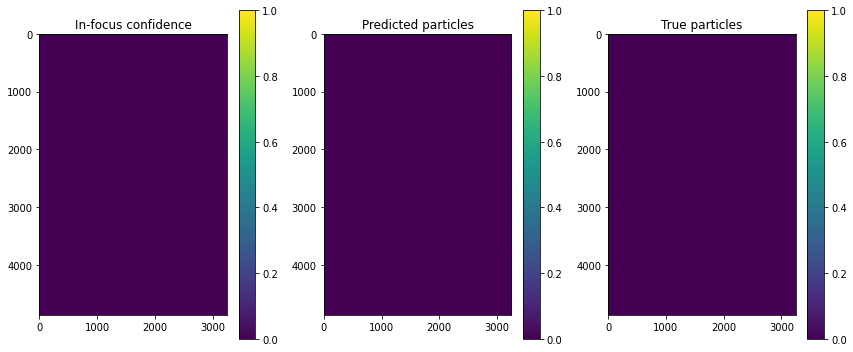

Plane: 136 at z: 0.033655 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0029:  15%|█▌        | 153/1000 [38:43<3:09:25, 13.42s/it]

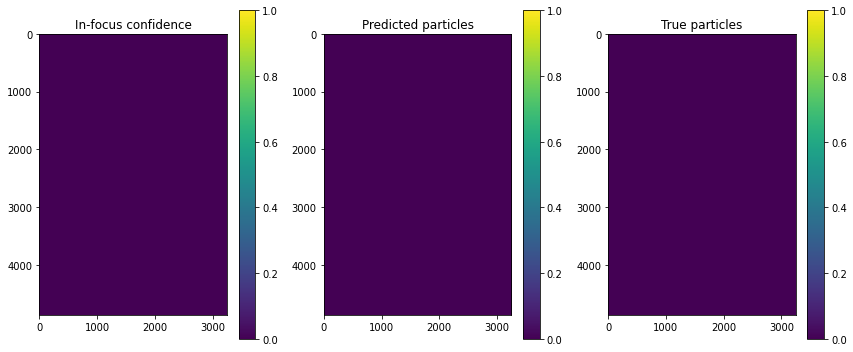

Plane: 137 at z: 0.0338 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0029:  15%|█▌        | 154/1000 [39:01<3:26:30, 14.65s/it]  

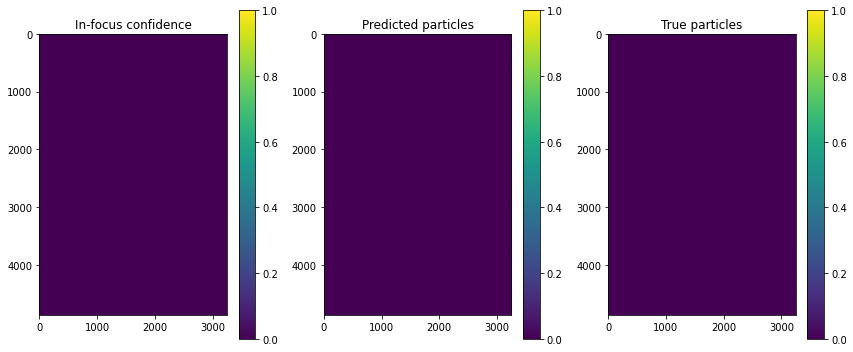

Plane: 138 at z: 0.033943999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0028:  16%|█▌        | 155/1000 [39:18<3:38:04, 15.49s/it]

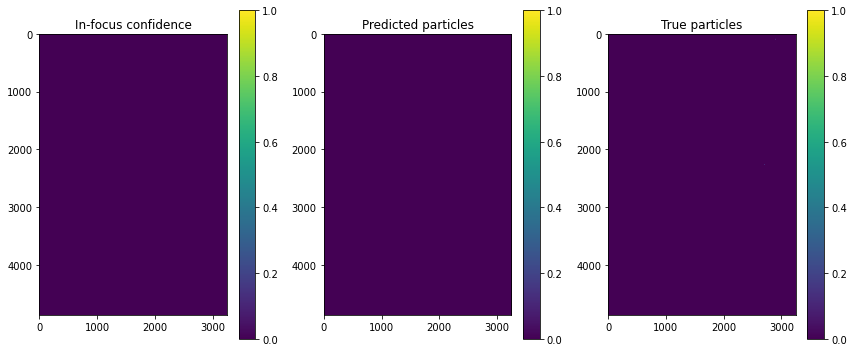

Plane: 139 at z: 0.034088 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0027:  16%|█▌        | 156/1000 [39:36<3:45:18, 16.02s/it]            

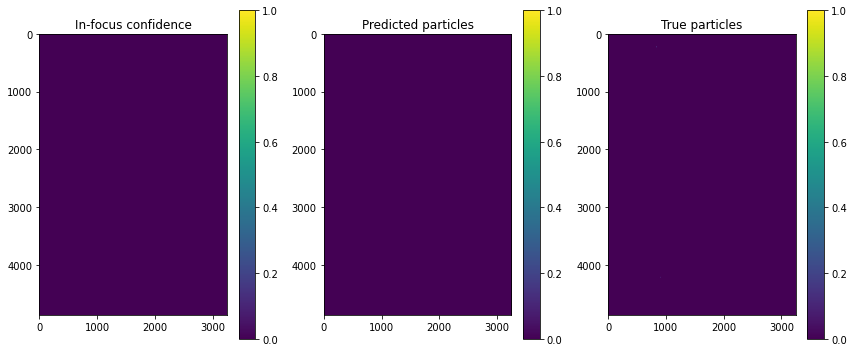

Plane: 140 at z: 0.034231 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0027:  16%|█▌        | 157/1000 [39:53<3:49:55, 16.37s/it]

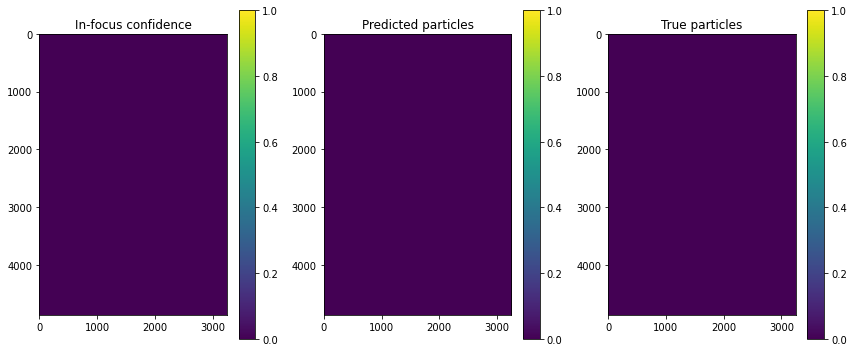

Plane: 141 at z: 0.034376 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0026:  16%|█▌        | 158/1000 [40:10<3:53:15, 16.62s/it]

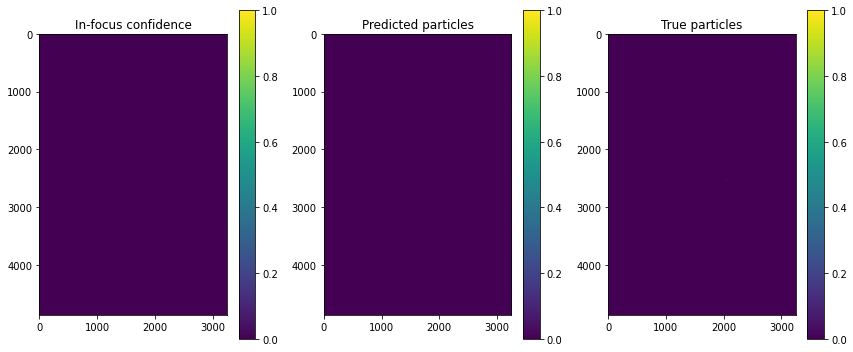

Plane: 142 at z: 0.034519999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0026:  16%|█▌        | 159/1000 [40:27<3:55:56, 16.83s/it]

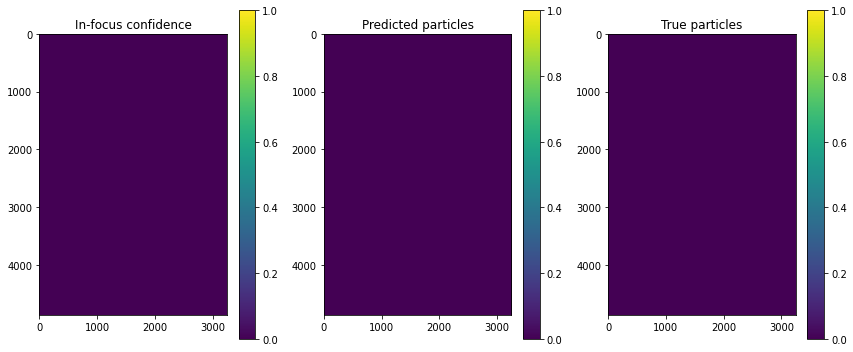

Plane: 143 at z: 0.034664 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0026:  16%|█▌        | 160/1000 [40:45<3:58:14, 17.02s/it]            

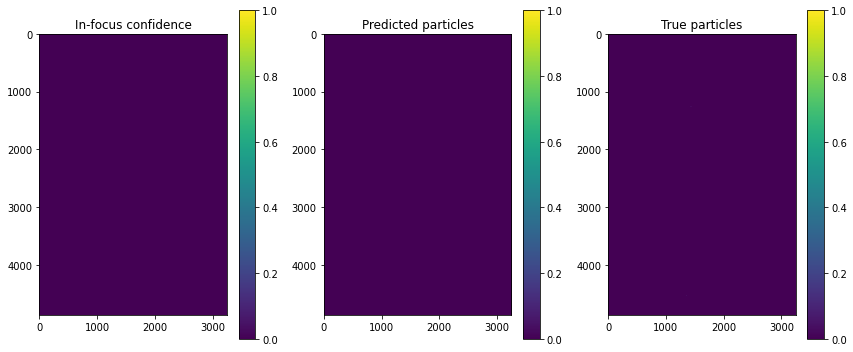

Plane: 144 at z: 0.034807 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0026:  16%|█▌        | 161/1000 [41:02<3:59:37, 17.14s/it]

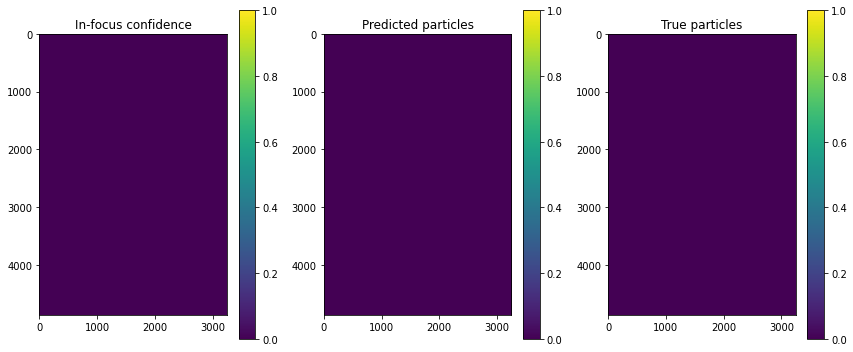

Plane: 145 at z: 0.034952 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0025:  16%|█▌        | 162/1000 [41:19<3:59:41, 17.16s/it]

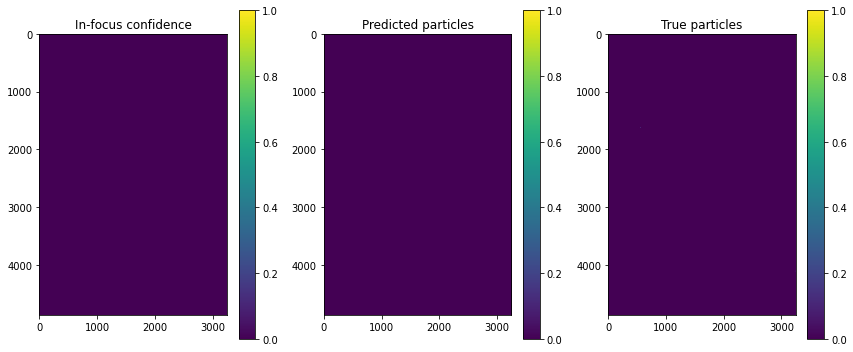

Plane: 146 at z: 0.035095999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0025:  16%|█▋        | 163/1000 [41:36<3:59:23, 17.16s/it]

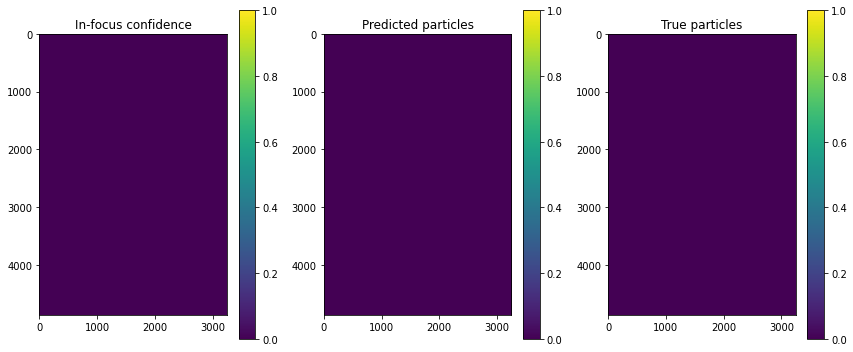

Plane: 147 at z: 0.03524 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0025:  16%|█▋        | 164/1000 [41:54<3:59:04, 17.16s/it]             

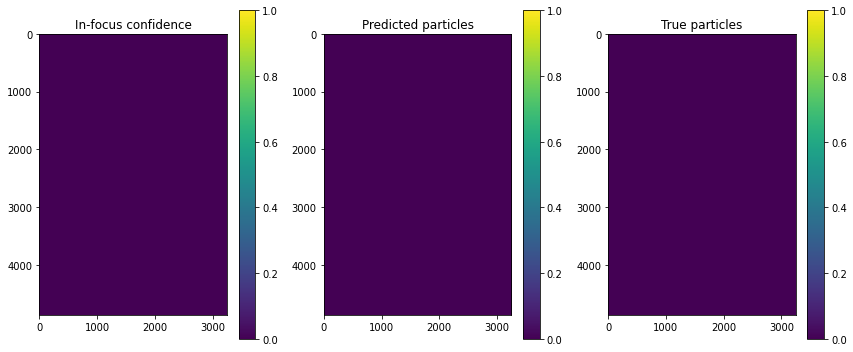

Plane: 148 at z: 0.035383 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0025:  16%|█▋        | 165/1000 [42:11<3:59:38, 17.22s/it]

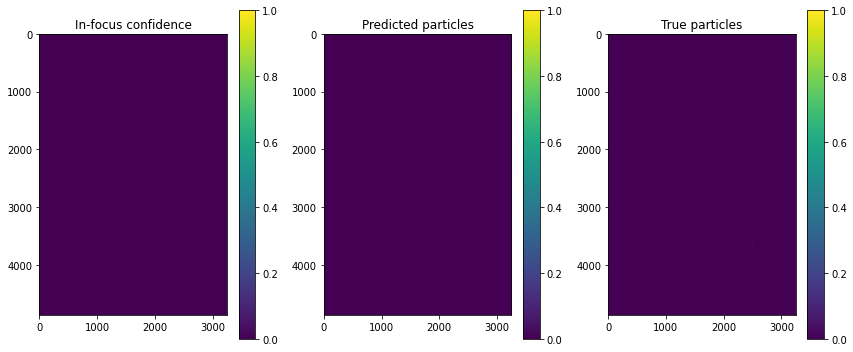

Plane: 149 at z: 0.035528 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0024:  17%|█▋        | 166/1000 [42:28<3:59:52, 17.26s/it]

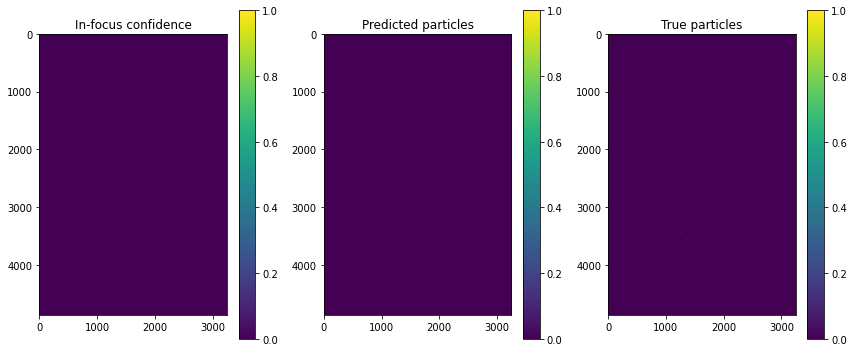

Plane: 150 at z: 0.035671999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0024:  17%|█▋        | 167/1000 [42:46<4:00:13, 17.30s/it]

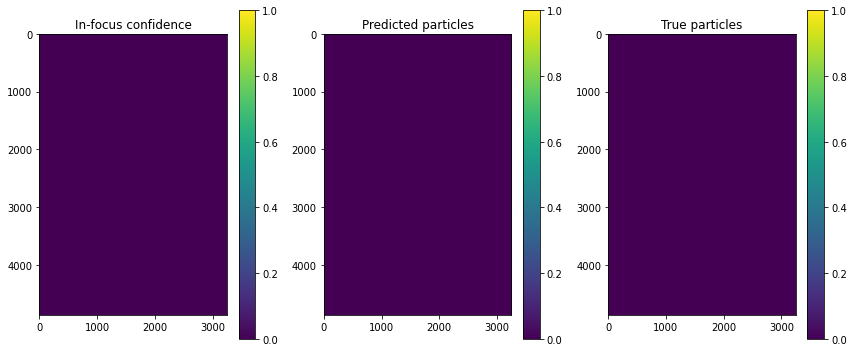

Plane: 151 at z: 0.035816 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.1923 holo_csi: 0.0047:  17%|█▋        | 168/1000 [43:03<4:00:04, 17.31s/it]            

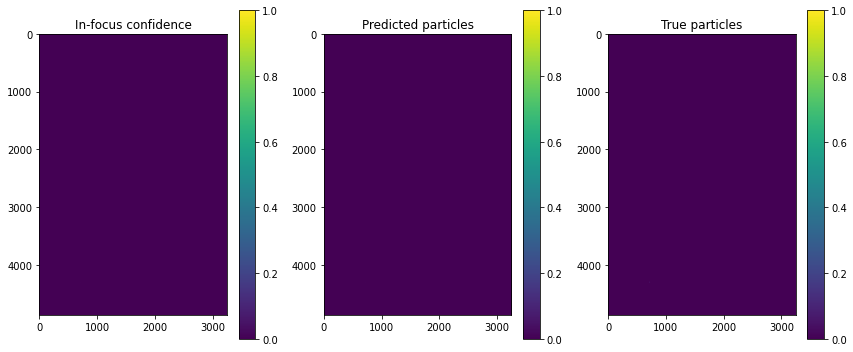

Plane: 152 at z: 0.035959 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0047:  17%|█▋        | 169/1000 [43:20<3:58:48, 17.24s/it]

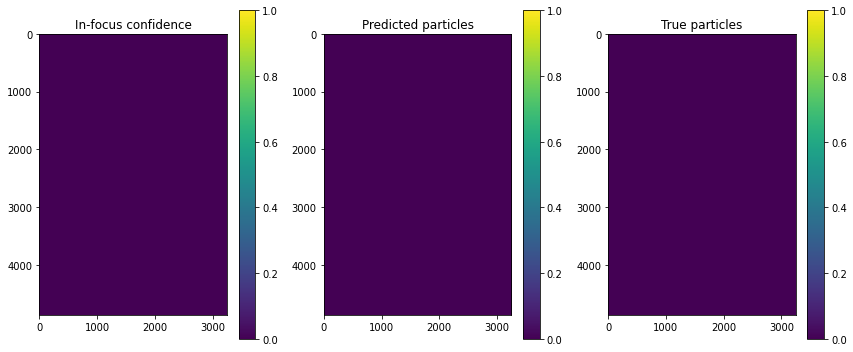

Plane: 153 at z: 0.036104 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.4483 holo_csi: 0.0107:  17%|█▋        | 171/1000 [43:37<3:05:07, 13.40s/it]

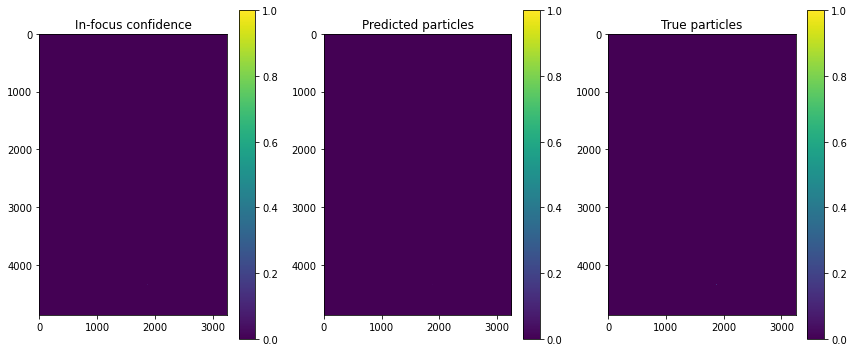

Plane: 154 at z: 0.036247999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0107:  17%|█▋        | 172/1000 [43:54<3:20:16, 14.51s/it]

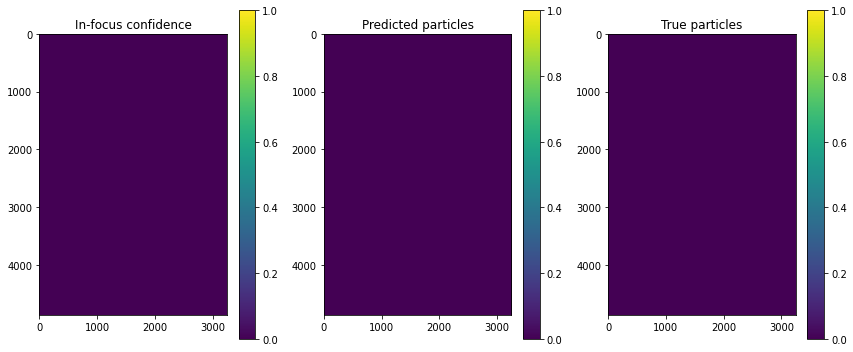

Plane: 155 at z: 0.036392 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0107:  17%|█▋        | 173/1000 [44:12<3:31:01, 15.31s/it]            

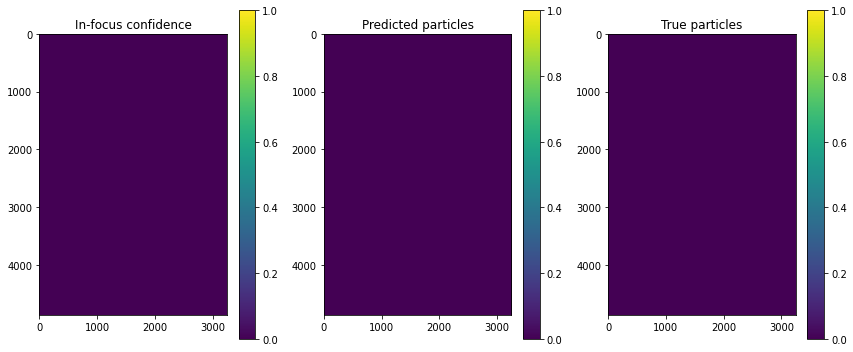

Plane: 156 at z: 0.036536 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0106:  17%|█▋        | 174/1000 [44:29<3:39:28, 15.94s/it]

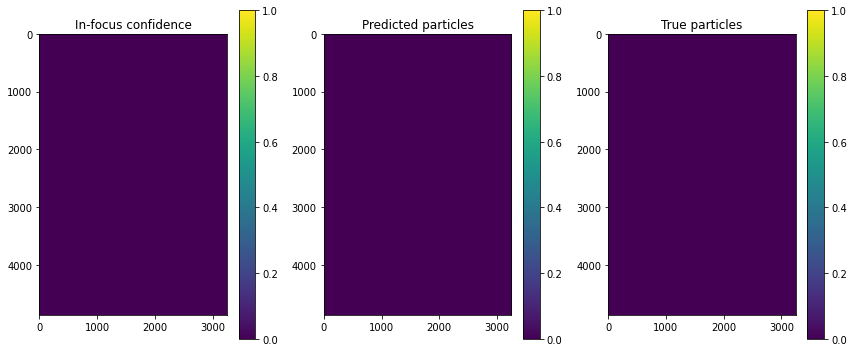

Plane: 157 at z: 0.03668 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0106:  18%|█▊        | 175/1000 [44:46<3:42:30, 16.18s/it] 

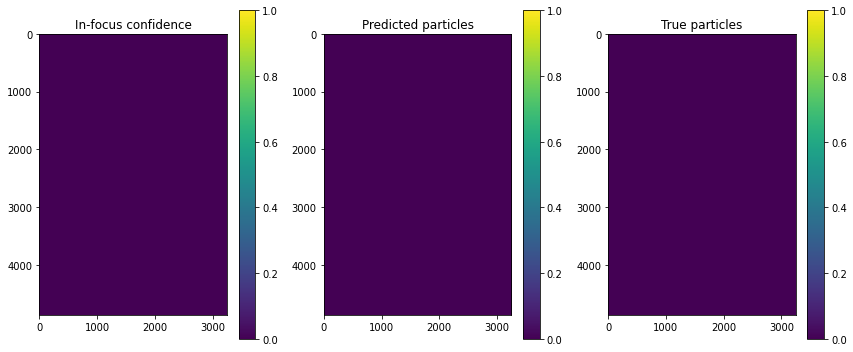

Plane: 158 at z: 0.036823999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0106:  18%|█▊        | 176/1000 [45:02<3:42:59, 16.24s/it]

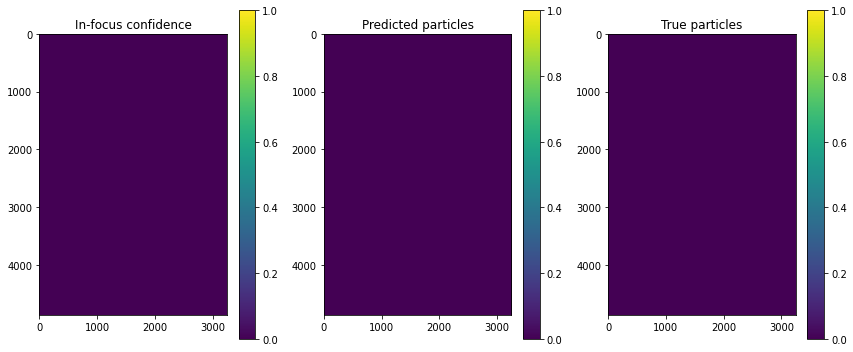

Plane: 159 at z: 0.036968 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0104:  18%|█▊        | 177/1000 [45:19<3:44:09, 16.34s/it]            

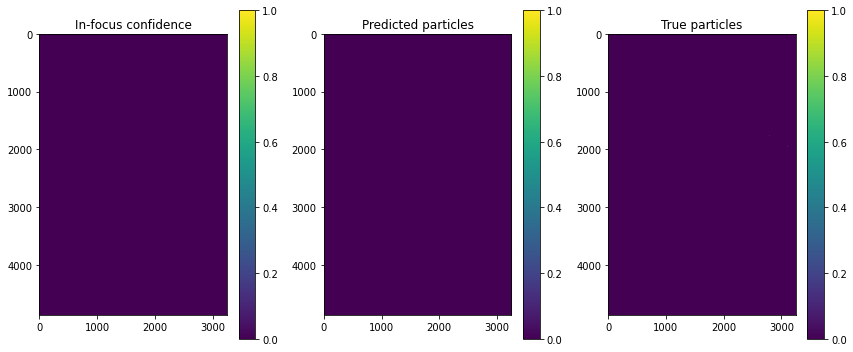

Plane: 160 at z: 0.037112 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0103:  18%|█▊        | 178/1000 [45:35<3:45:18, 16.45s/it]

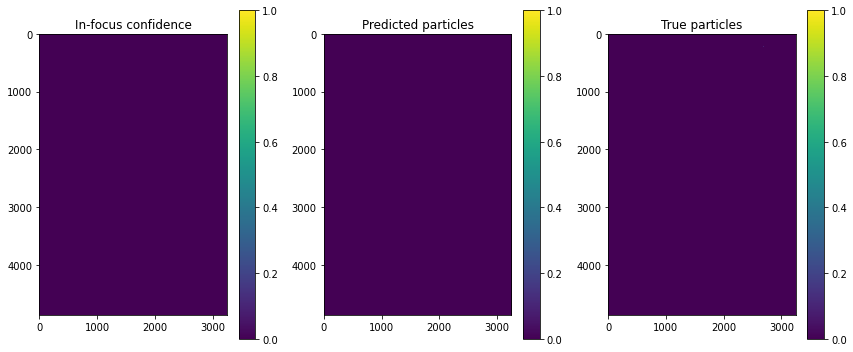

Plane: 161 at z: 0.037254999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0102:  18%|█▊        | 179/1000 [45:52<3:45:51, 16.51s/it]

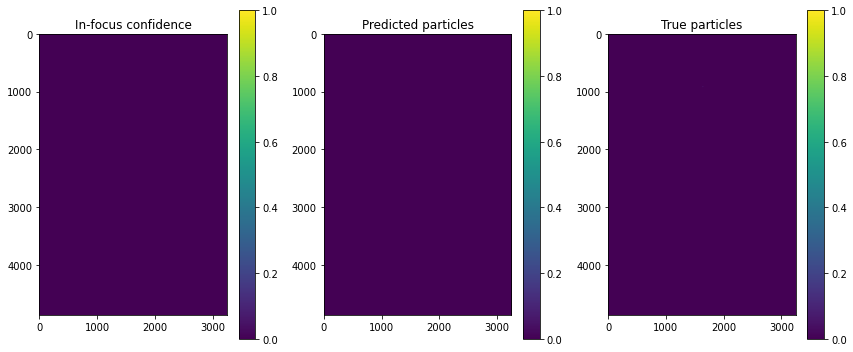

Plane: 162 at z: 0.037399999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0101:  18%|█▊        | 180/1000 [46:09<3:47:00, 16.61s/it]

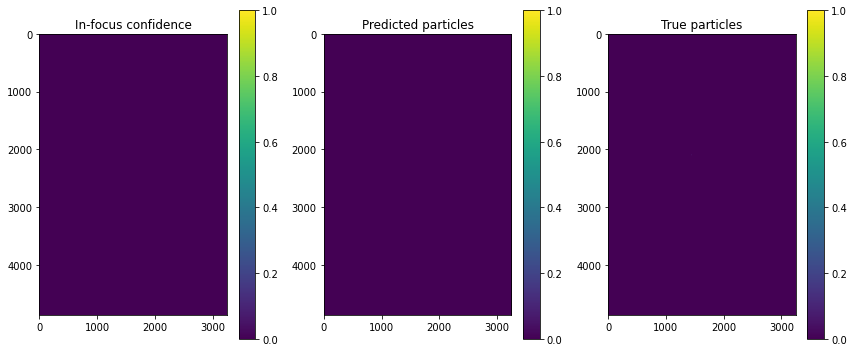

Plane: 163 at z: 0.037544 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0101:  18%|█▊        | 181/1000 [46:26<3:47:09, 16.64s/it]            

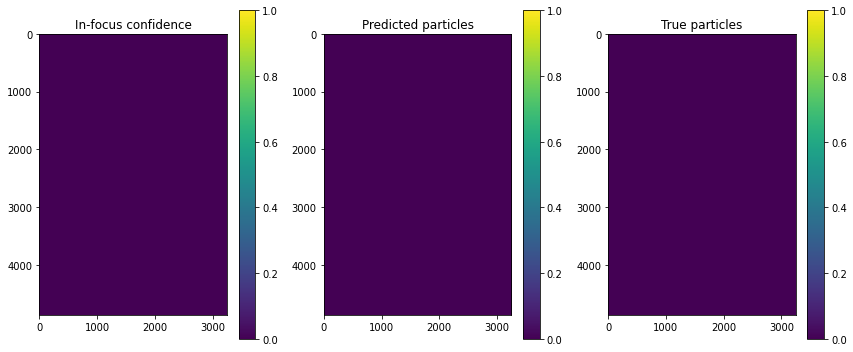

Plane: 164 at z: 0.037688 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0101:  18%|█▊        | 182/1000 [46:42<3:47:00, 16.65s/it]

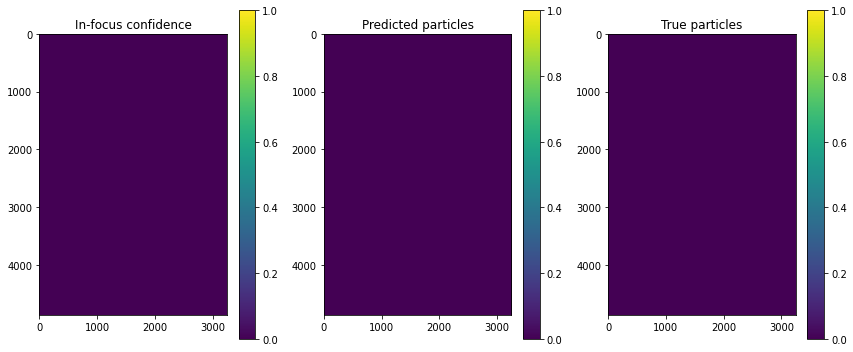

Plane: 165 at z: 0.037831 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0100:  18%|█▊        | 183/1000 [46:59<3:46:41, 16.65s/it]

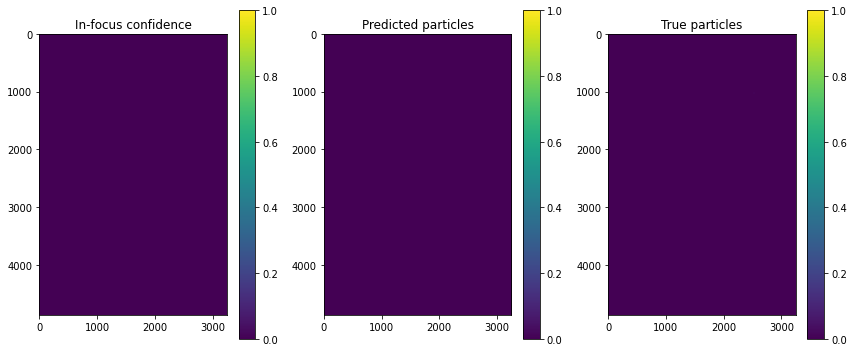

Plane: 166 at z: 0.037975999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0100:  18%|█▊        | 184/1000 [47:15<3:45:41, 16.60s/it]

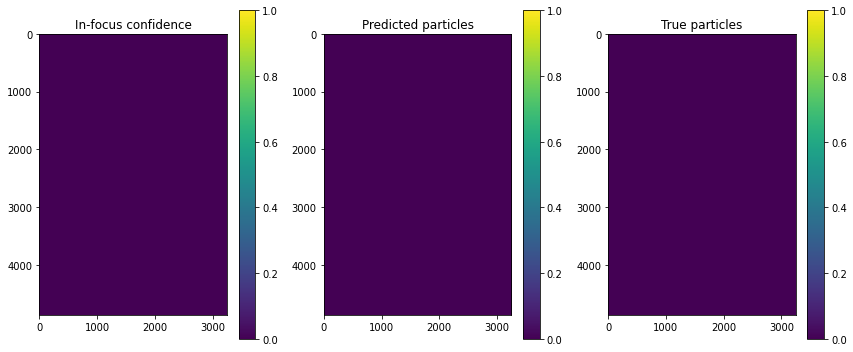

Plane: 167 at z: 0.03812 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0100:  18%|█▊        | 185/1000 [47:32<3:44:49, 16.55s/it]             

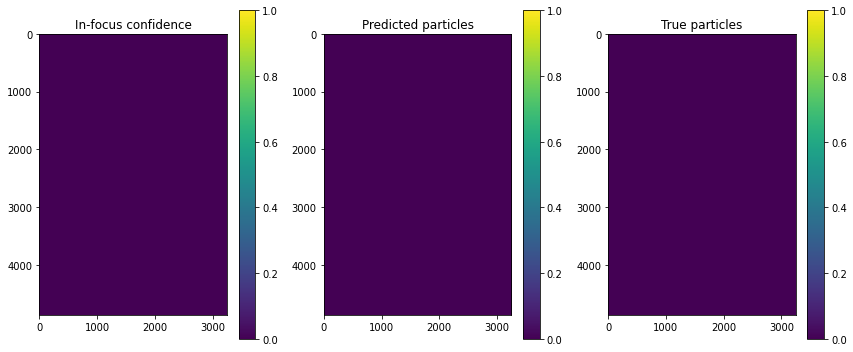

Plane: 168 at z: 0.038264 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0098:  19%|█▊        | 186/1000 [47:48<3:44:54, 16.58s/it]

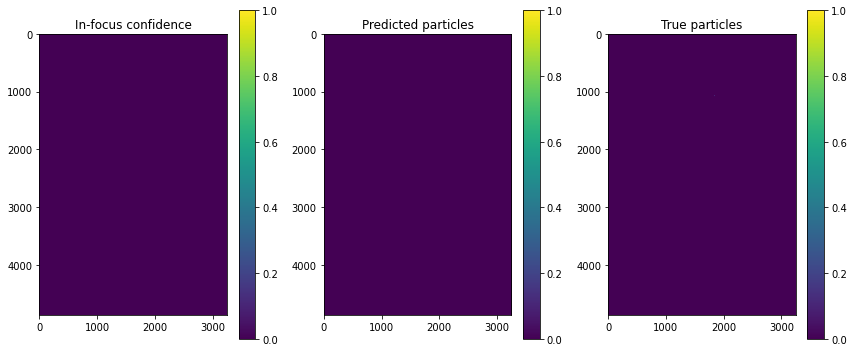

Plane: 169 at z: 0.038407 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0097:  19%|█▊        | 187/1000 [48:05<3:44:40, 16.58s/it]

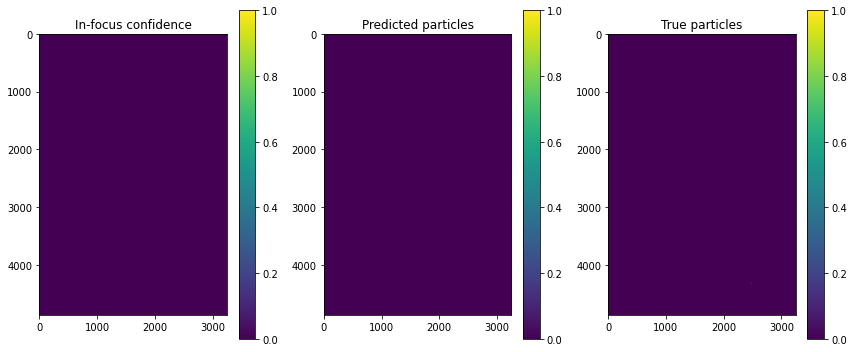

Plane: 170 at z: 0.038551999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0097:  19%|█▉        | 188/1000 [48:22<3:45:01, 16.63s/it]

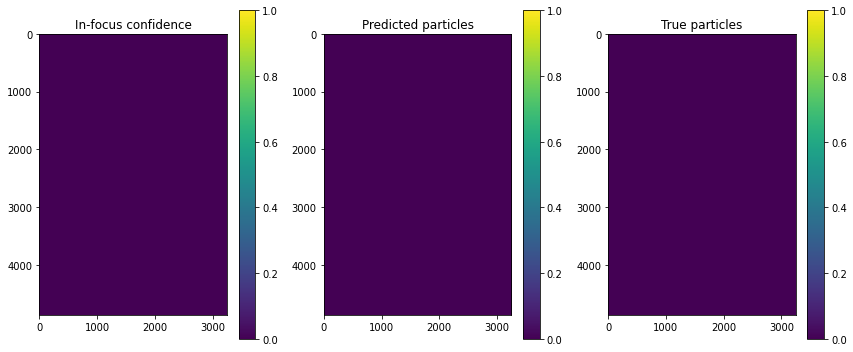

Plane: 171 at z: 0.038696 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0097:  19%|█▉        | 190/1000 [48:38<2:54:39, 12.94s/it]            

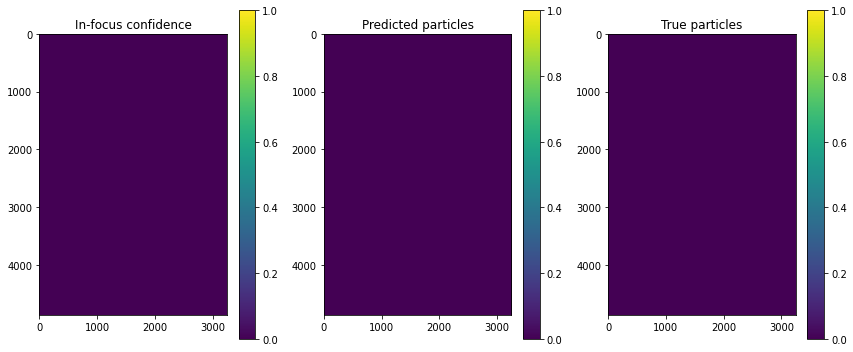

Plane: 172 at z: 0.03884 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0395 holo_csi: 0.0106:  19%|█▉        | 191/1000 [48:55<3:09:23, 14.05s/it] 

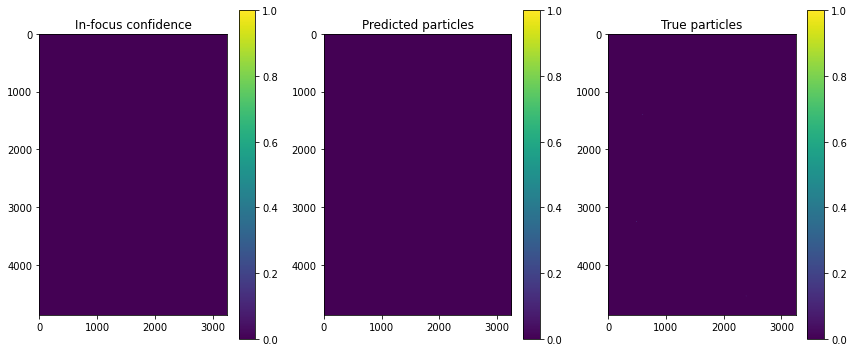

Plane: 173 at z: 0.038983 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0106:  19%|█▉        | 192/1000 [49:11<3:18:16, 14.72s/it]

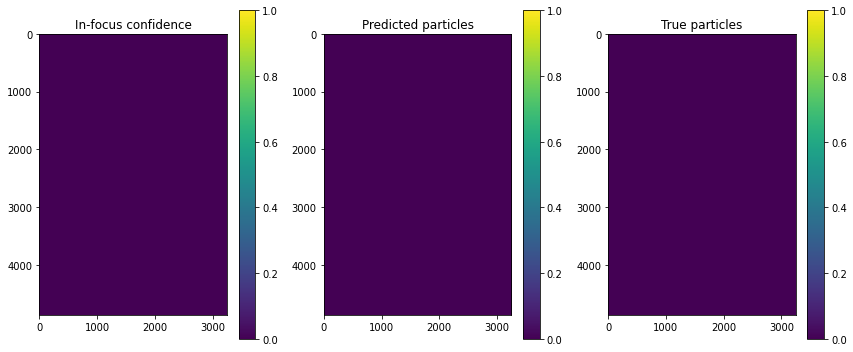

Plane: 174 at z: 0.039127999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0104:  19%|█▉        | 193/1000 [49:28<3:25:36, 15.29s/it]

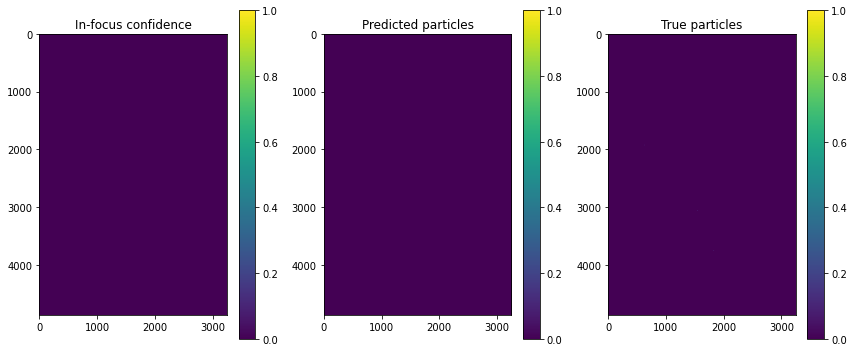

Plane: 175 at z: 0.039272 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0104:  19%|█▉        | 194/1000 [49:44<3:28:53, 15.55s/it]            

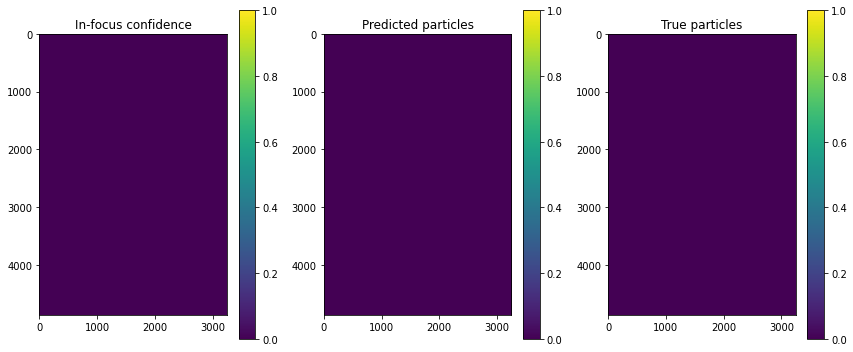

Plane: 176 at z: 0.039416 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0104:  20%|█▉        | 195/1000 [50:01<3:32:31, 15.84s/it]

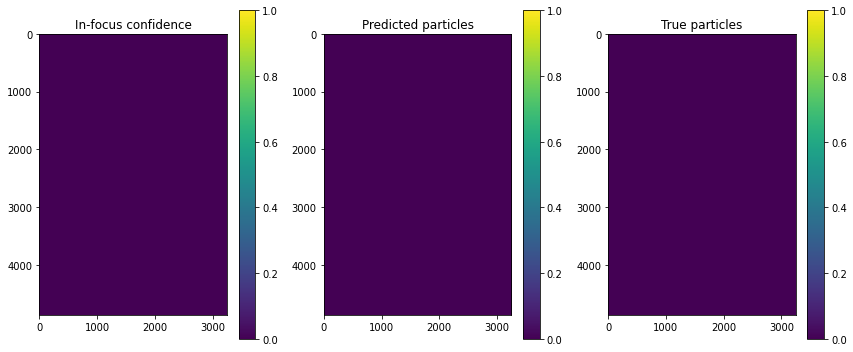

Plane: 177 at z: 0.039559 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0103:  20%|█▉        | 196/1000 [50:17<3:36:08, 16.13s/it]

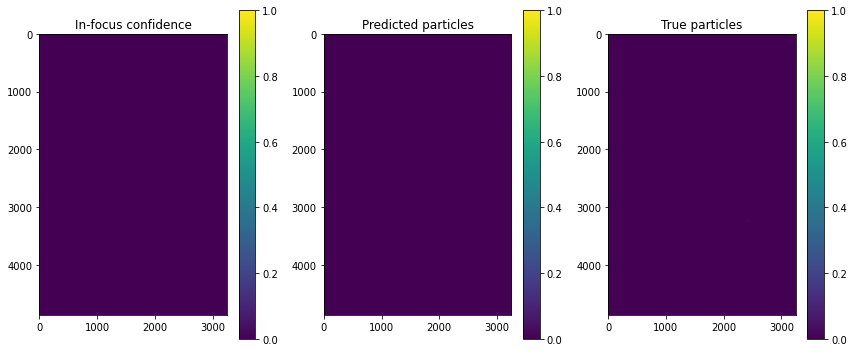

Plane: 178 at z: 0.039703999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0103:  20%|█▉        | 197/1000 [50:34<3:37:57, 16.29s/it]

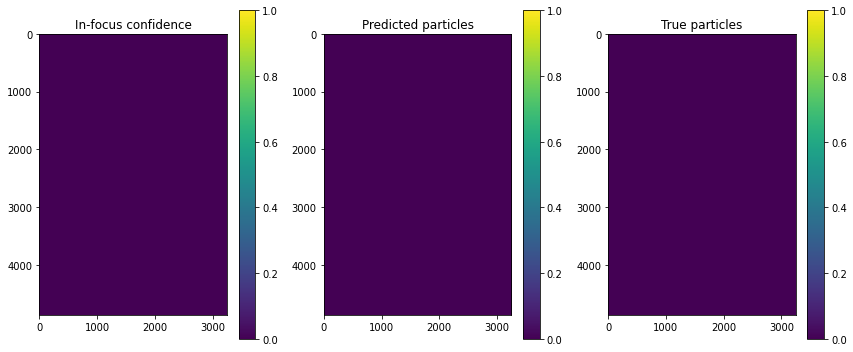

Plane: 179 at z: 0.039848 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0103:  20%|█▉        | 198/1000 [50:51<3:39:02, 16.39s/it]            

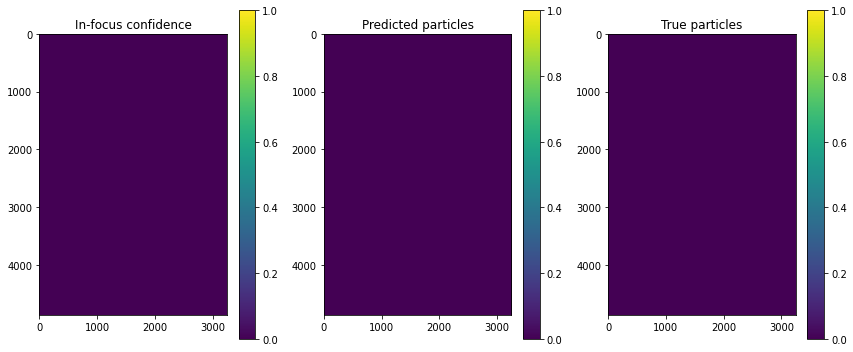

Plane: 180 at z: 0.039992 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0102:  20%|█▉        | 199/1000 [51:07<3:40:16, 16.50s/it]

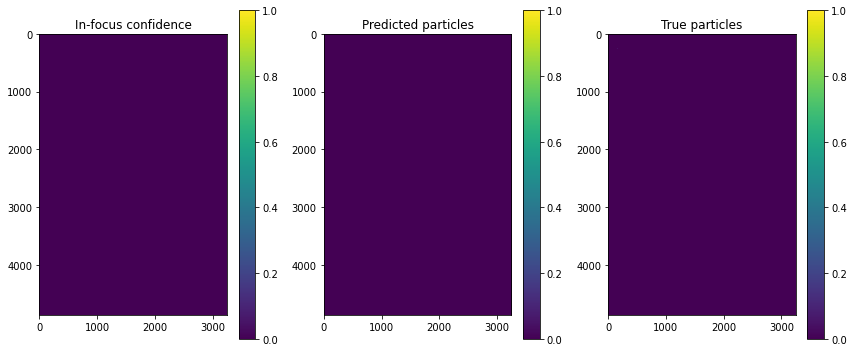

Plane: 181 at z: 0.040135 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0101:  20%|██        | 200/1000 [51:24<3:41:01, 16.58s/it]

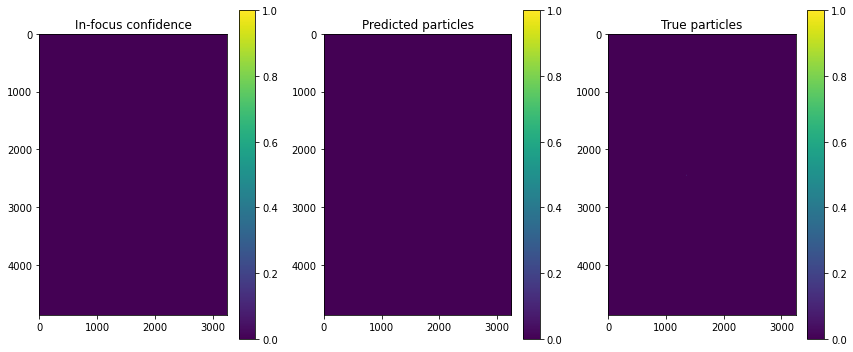

Plane: 182 at z: 0.040279999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0101:  20%|██        | 201/1000 [51:41<3:41:29, 16.63s/it]

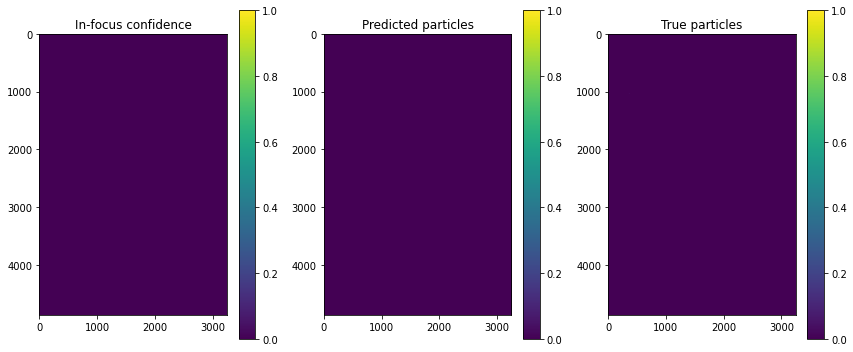

Plane: 183 at z: 0.040424 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0100:  20%|██        | 202/1000 [51:58<3:42:12, 16.71s/it]            

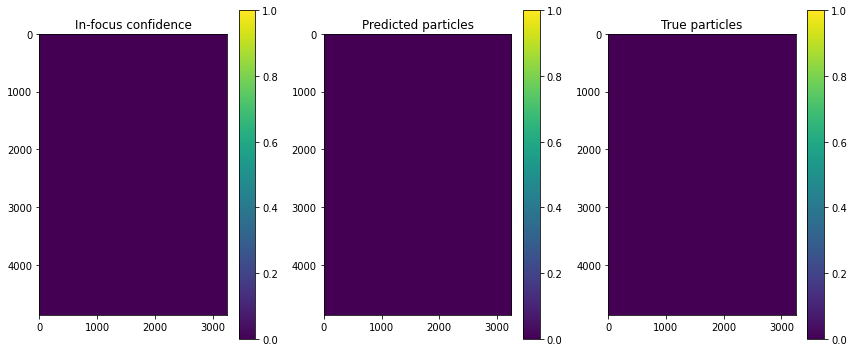

Plane: 184 at z: 0.040568 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0100:  20%|██        | 203/1000 [52:14<3:41:04, 16.64s/it]

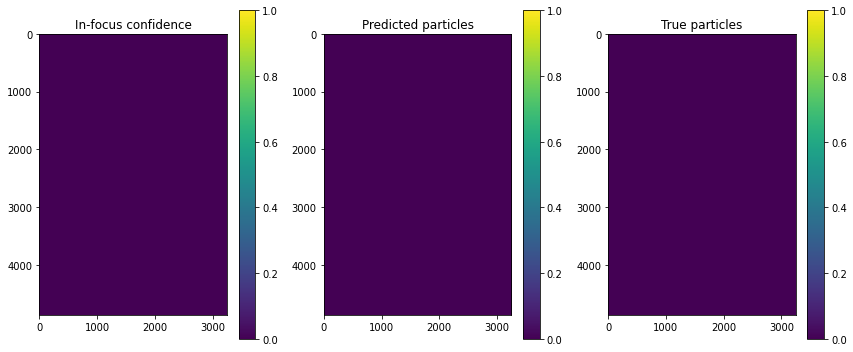

Plane: 185 at z: 0.040711 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0099:  20%|██        | 204/1000 [52:31<3:40:31, 16.62s/it]

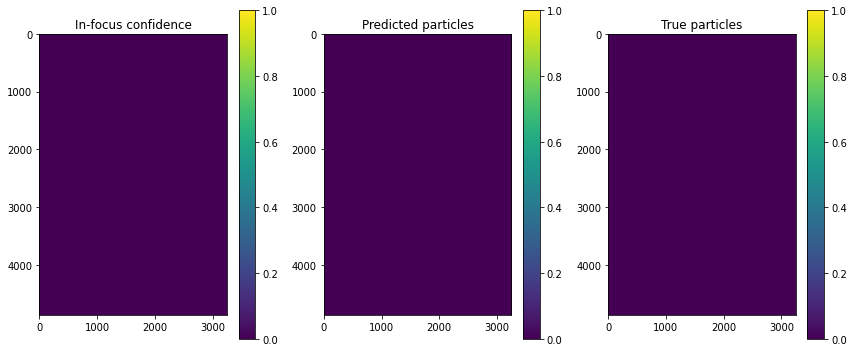

Plane: 186 at z: 0.040855999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0098:  20%|██        | 205/1000 [52:48<3:40:37, 16.65s/it]

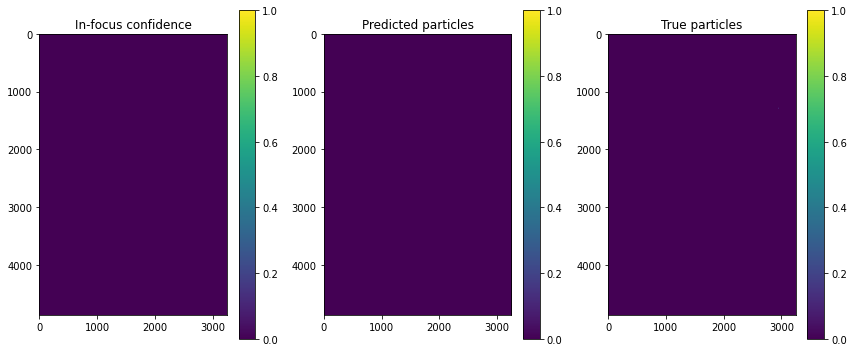

Plane: 187 at z: 0.040999999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0098:  21%|██        | 206/1000 [53:04<3:40:27, 16.66s/it]

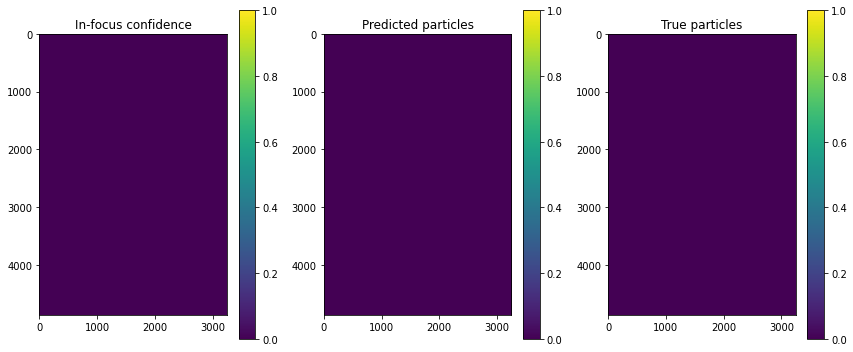

Plane: 188 at z: 0.041144 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0345 holo_csi: 0.0101:  21%|██        | 207/1000 [53:21<3:41:17, 16.74s/it]            

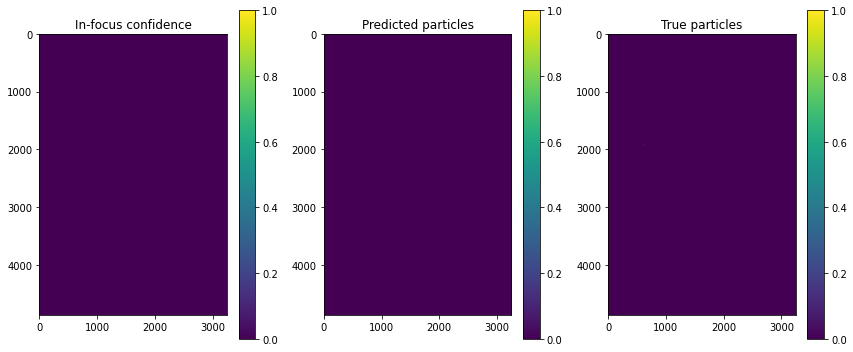

Plane: 189 at z: 0.041287 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0101:  21%|██        | 208/1000 [53:38<3:40:37, 16.71s/it]

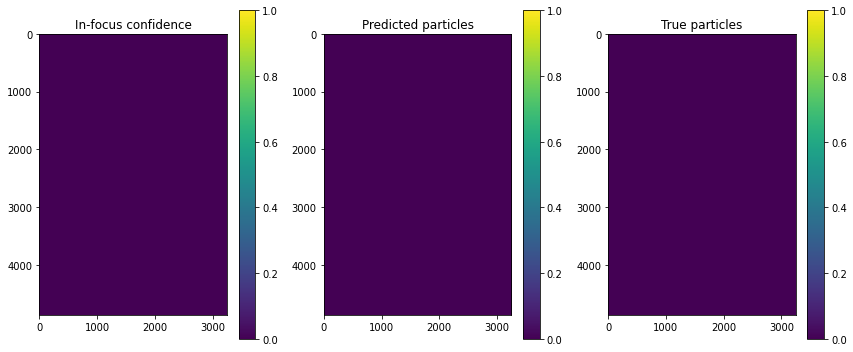

Plane: 190 at z: 0.041432 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0100:  21%|██        | 210/1000 [53:55<2:51:45, 13.04s/it]

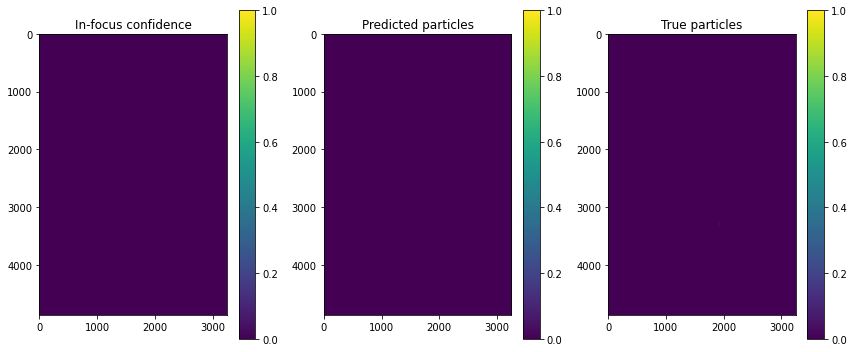

Plane: 191 at z: 0.041575999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0100:  21%|██        | 211/1000 [54:11<3:05:15, 14.09s/it]

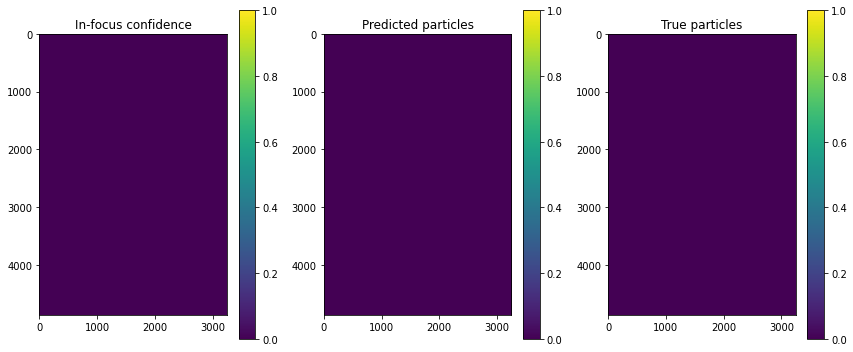

Plane: 192 at z: 0.04172 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0100:  21%|██        | 212/1000 [54:28<3:14:43, 14.83s/it]             

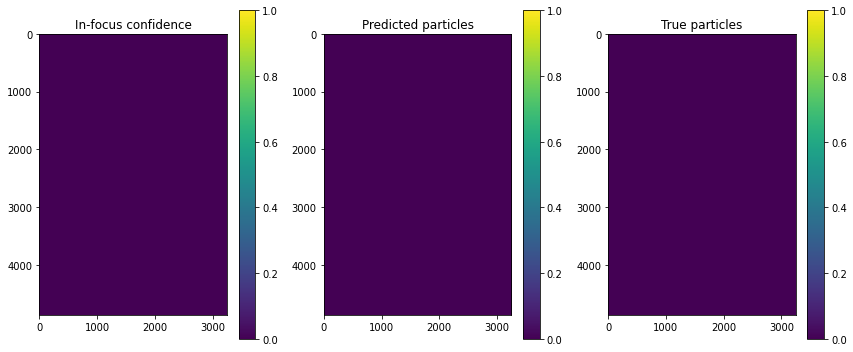

Plane: 193 at z: 0.041863 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0100:  21%|██▏       | 213/1000 [54:44<3:20:10, 15.26s/it]

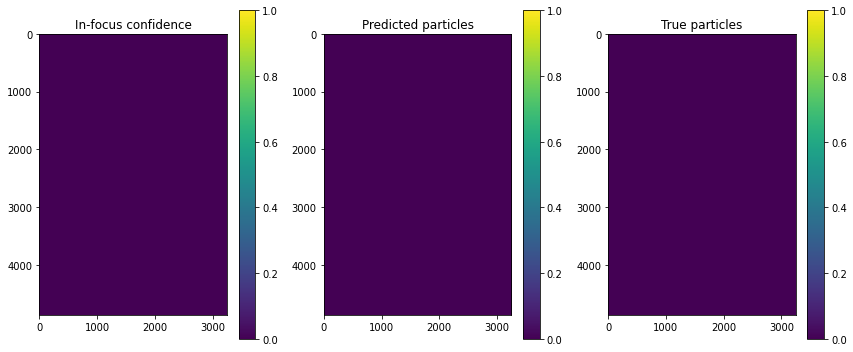

Plane: 194 at z: 0.042006999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0099:  21%|██▏       | 214/1000 [55:01<3:25:07, 15.66s/it]

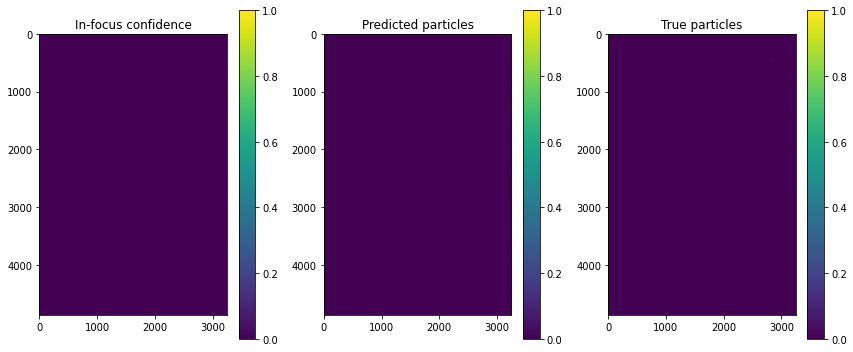

Plane: 195 at z: 0.042151999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0099:  22%|██▏       | 215/1000 [55:17<3:28:26, 15.93s/it]

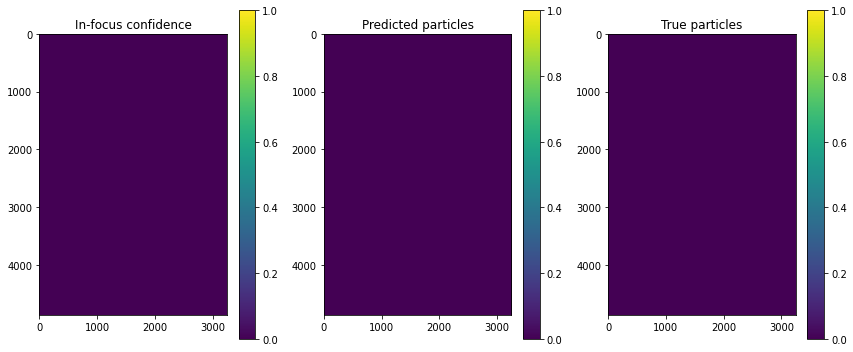

Plane: 196 at z: 0.042296 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0099:  22%|██▏       | 216/1000 [55:34<3:31:22, 16.18s/it]            

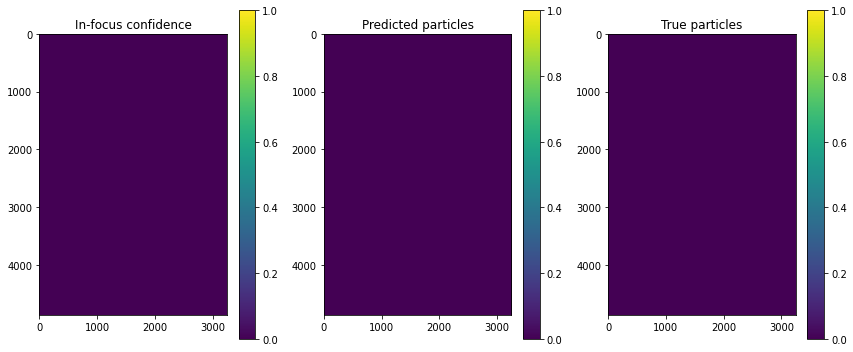

Plane: 197 at z: 0.042439 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0099:  22%|██▏       | 217/1000 [55:50<3:32:14, 16.26s/it]

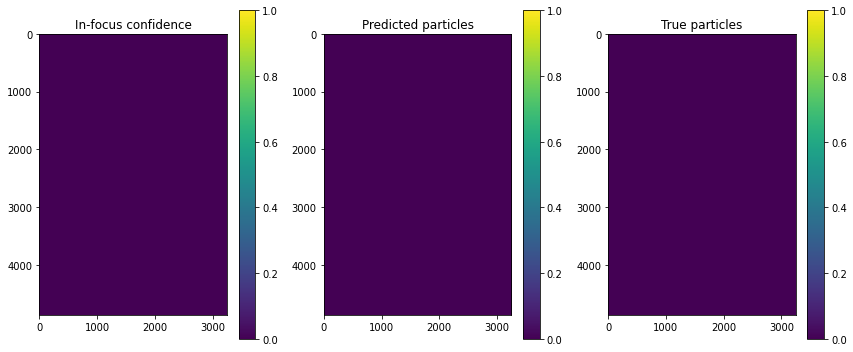

Plane: 198 at z: 0.042582999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0097:  22%|██▏       | 218/1000 [56:07<3:32:23, 16.30s/it]

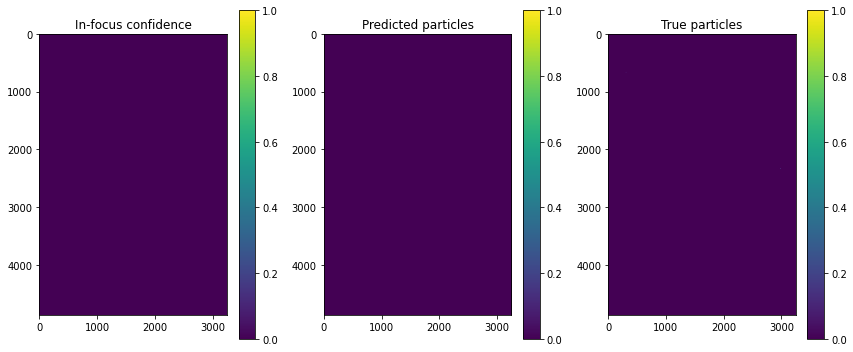

Plane: 199 at z: 0.042727999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0097:  22%|██▏       | 219/1000 [56:23<3:33:20, 16.39s/it]

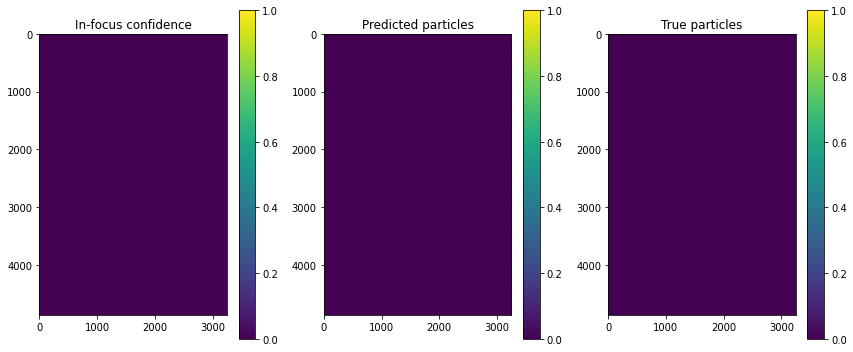

Plane: 200 at z: 0.042872 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0096:  22%|██▏       | 220/1000 [56:40<3:34:23, 16.49s/it]            

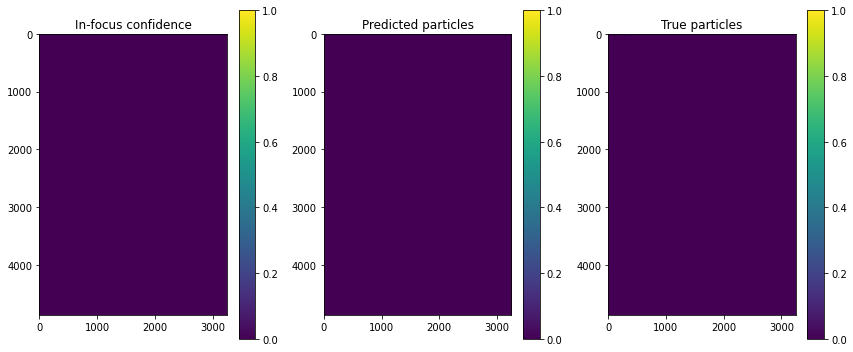

Plane: 201 at z: 0.043015 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0096:  22%|██▏       | 221/1000 [56:57<3:34:18, 16.51s/it]

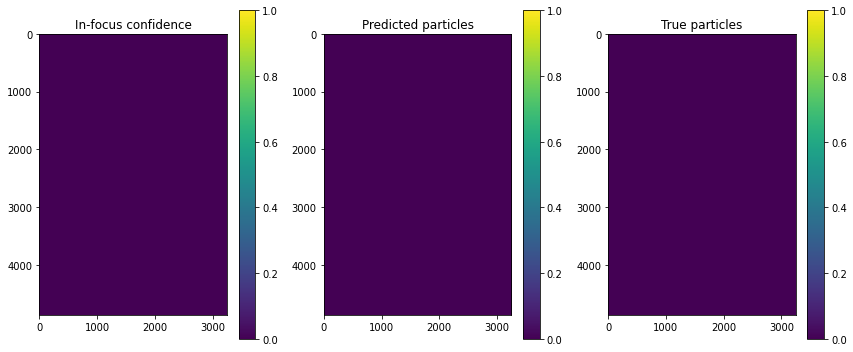

Plane: 202 at z: 0.043158999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0096:  22%|██▏       | 222/1000 [57:13<3:33:39, 16.48s/it]

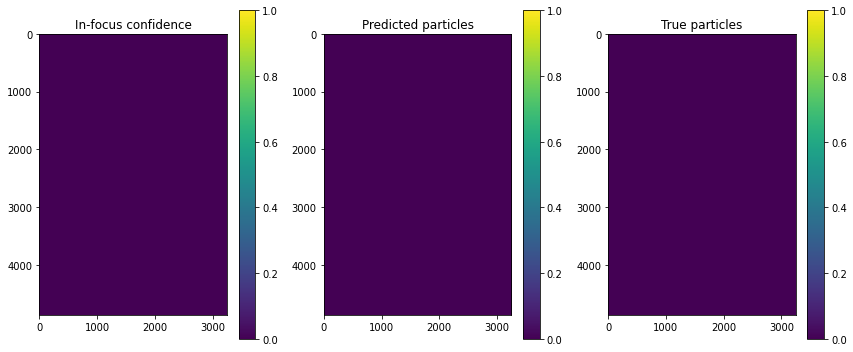

Plane: 203 at z: 0.043303999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0096:  22%|██▏       | 223/1000 [57:30<3:33:21, 16.48s/it]

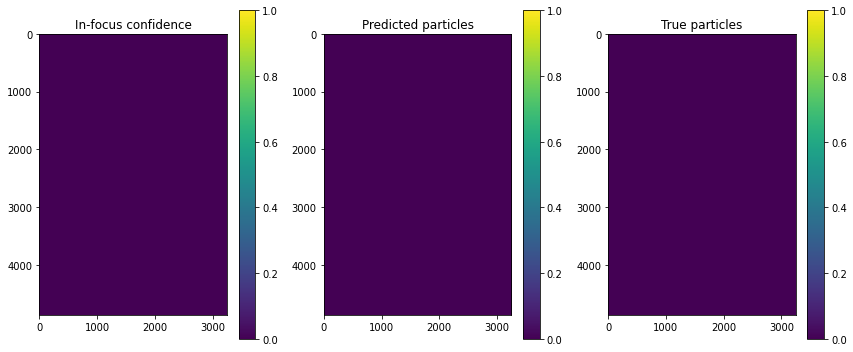

Plane: 204 at z: 0.043448 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0096:  22%|██▏       | 224/1000 [57:46<3:32:27, 16.43s/it]            

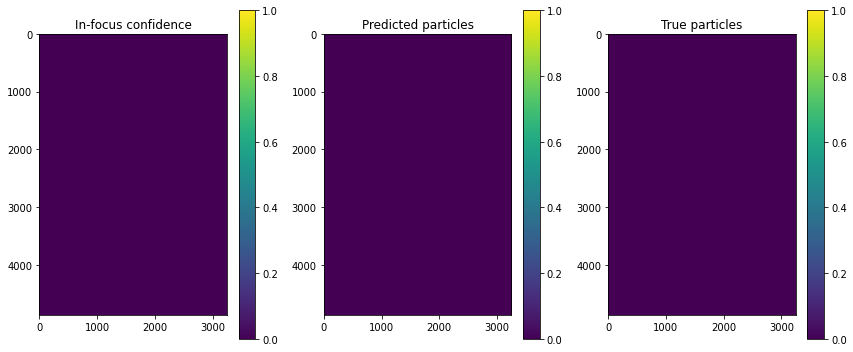

Plane: 205 at z: 0.043591 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0096:  22%|██▎       | 225/1000 [58:02<3:32:09, 16.43s/it]

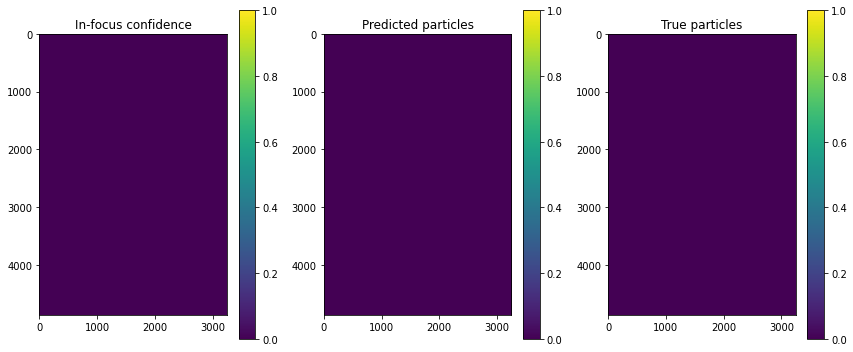

Plane: 206 at z: 0.043734999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0096:  23%|██▎       | 226/1000 [58:19<3:31:30, 16.40s/it]

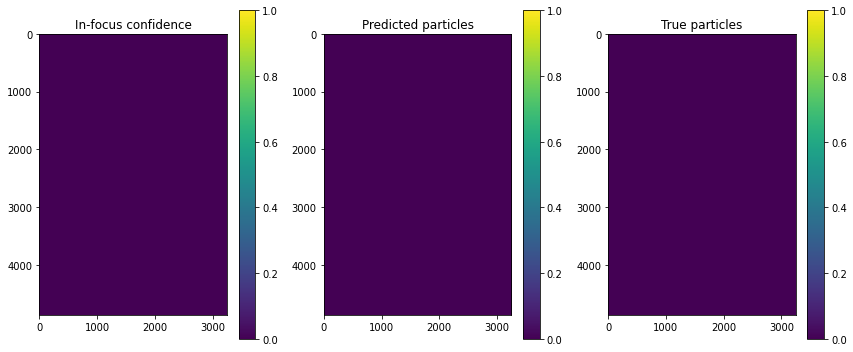

Plane: 207 at z: 0.043879999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0095:  23%|██▎       | 227/1000 [58:35<3:32:45, 16.51s/it]

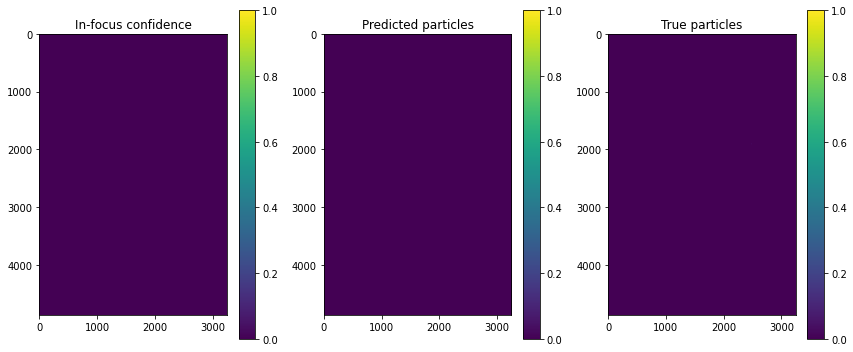

Plane: 208 at z: 0.044024 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0095:  23%|██▎       | 228/1000 [58:52<3:33:04, 16.56s/it]            

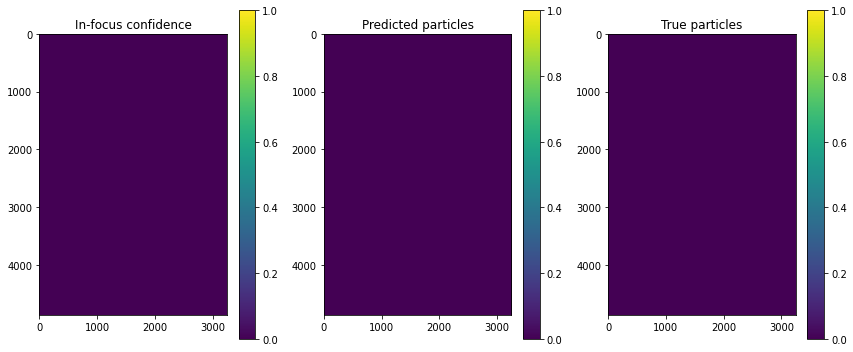

Plane: 209 at z: 0.044167 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0095:  23%|██▎       | 229/1000 [59:08<3:32:24, 16.53s/it]

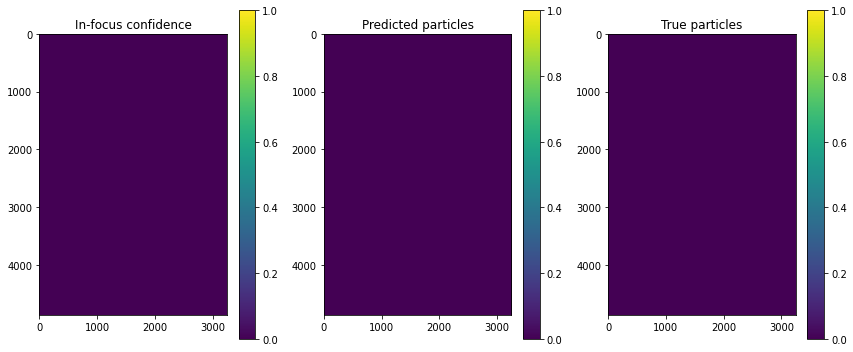

Plane: 210 at z: 0.044310999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0095:  23%|██▎       | 231/1000 [59:25<2:44:37, 12.84s/it]

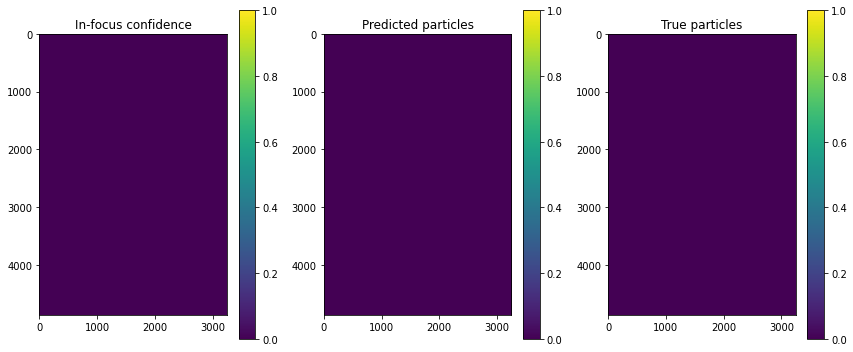

Plane: 211 at z: 0.044455999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0172 holo_csi: 0.0097:  23%|██▎       | 232/1000 [59:41<2:58:56, 13.98s/it]

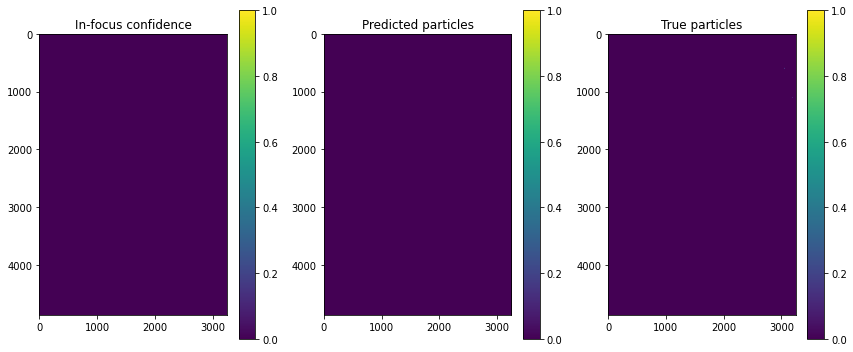

Plane: 212 at z: 0.0446 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0097:  23%|██▎       | 233/1000 [59:58<3:08:15, 14.73s/it]              

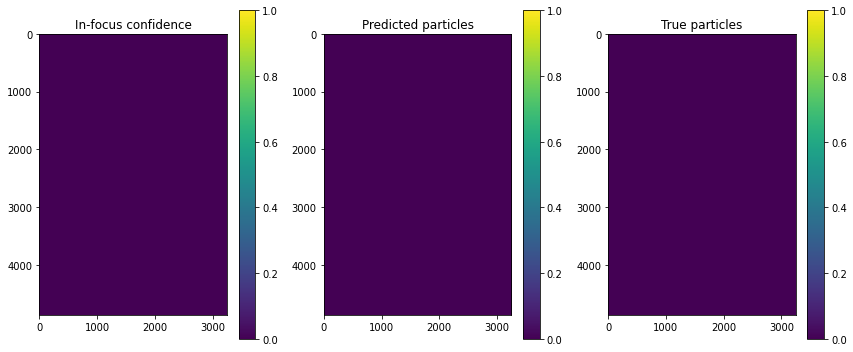

Plane: 213 at z: 0.044744 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.2619 holo_csi: 0.0133:  23%|██▎       | 234/1000 [1:00:14<3:14:27, 15.23s/it]

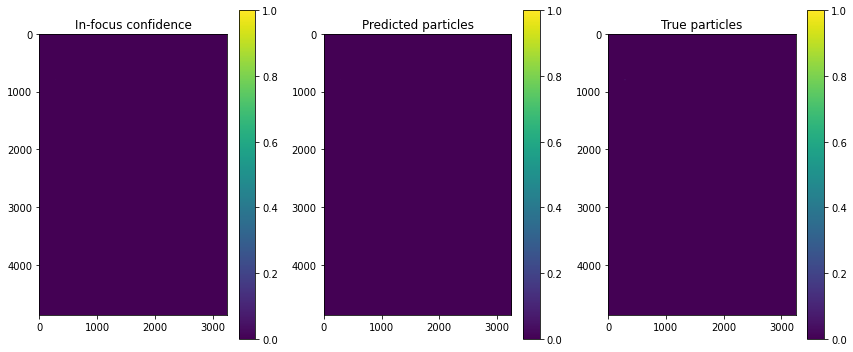

Plane: 214 at z: 0.044886999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0133:  24%|██▎       | 235/1000 [1:00:31<3:19:39, 15.66s/it]

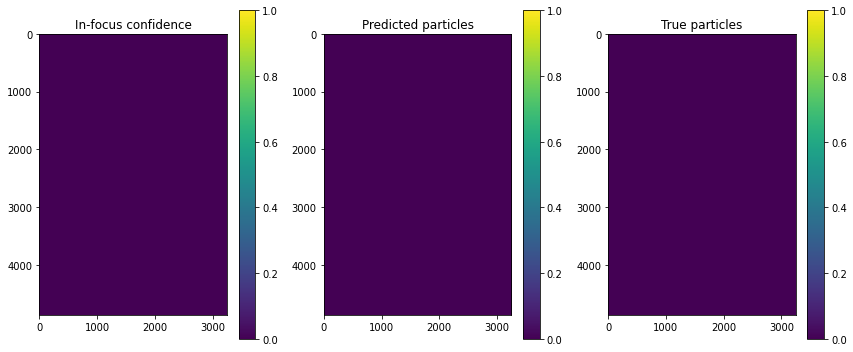

Plane: 215 at z: 0.045031999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0133:  24%|██▎       | 236/1000 [1:00:48<3:22:54, 15.94s/it]

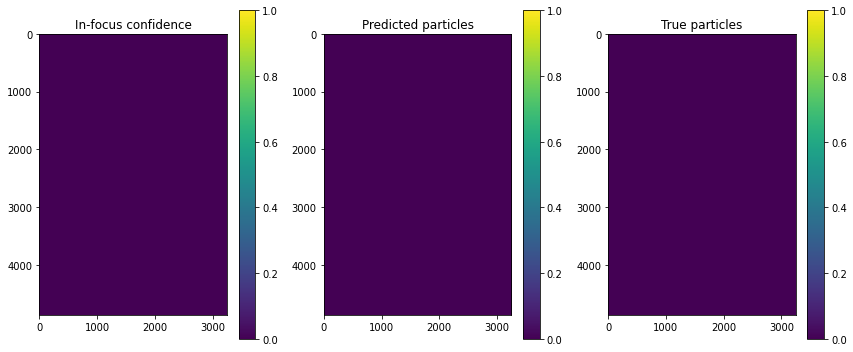

Plane: 216 at z: 0.045176 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.2143 holo_csi: 0.0152:  24%|██▎       | 237/1000 [1:01:04<3:25:33, 16.16s/it]            

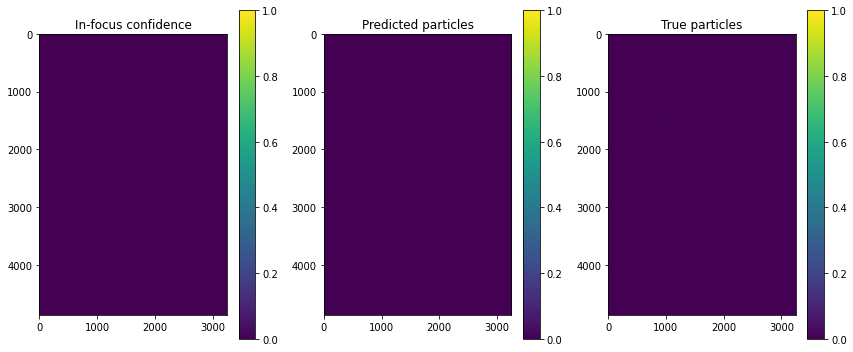

Plane: 217 at z: 0.04532 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0150:  24%|██▍       | 238/1000 [1:01:21<3:27:03, 16.30s/it] 

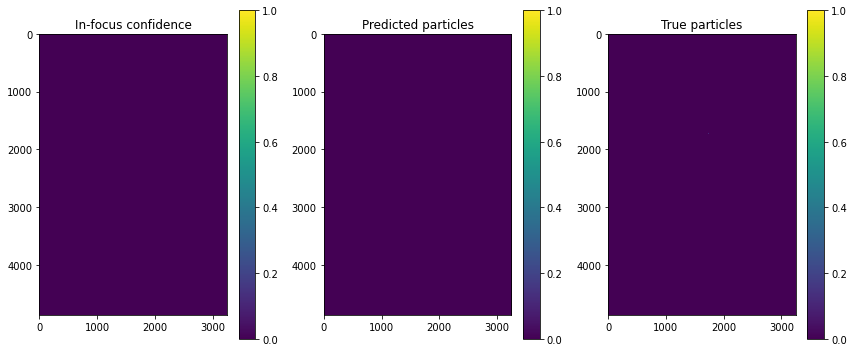

Plane: 218 at z: 0.045462999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0150:  24%|██▍       | 239/1000 [1:01:37<3:27:42, 16.38s/it]

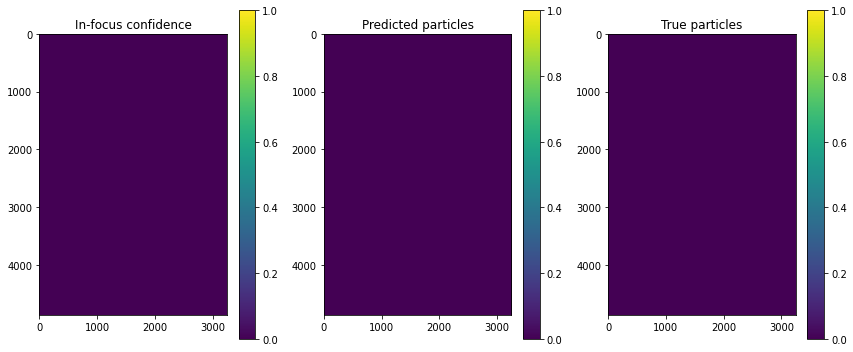

Plane: 219 at z: 0.045606999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0150:  24%|██▍       | 240/1000 [1:01:54<3:28:33, 16.47s/it]

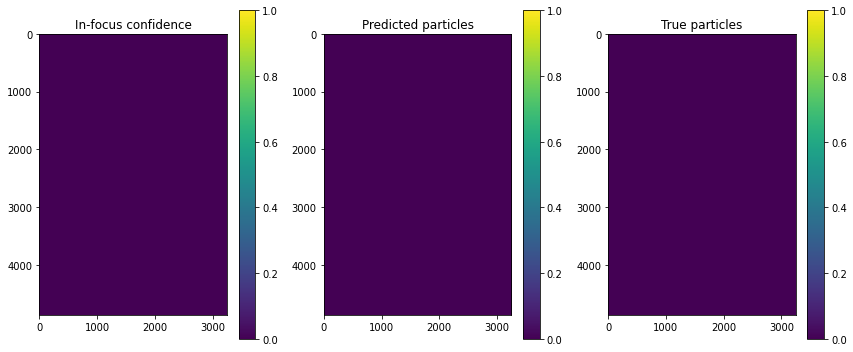

Plane: 220 at z: 0.045752 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0150:  24%|██▍       | 241/1000 [1:02:11<3:29:15, 16.54s/it]            

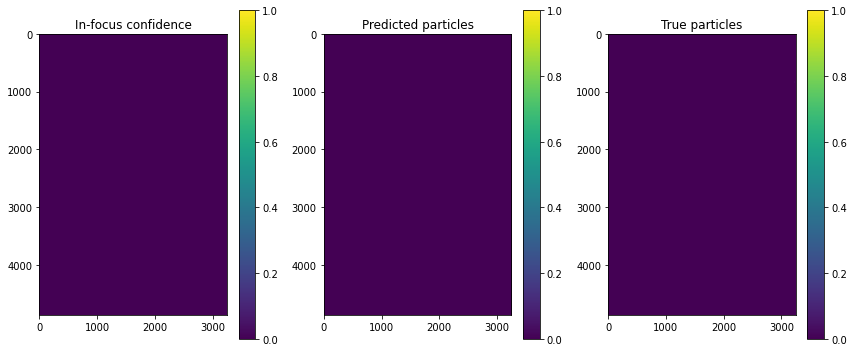

Plane: 221 at z: 0.045896 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0148:  24%|██▍       | 242/1000 [1:02:28<3:29:19, 16.57s/it]

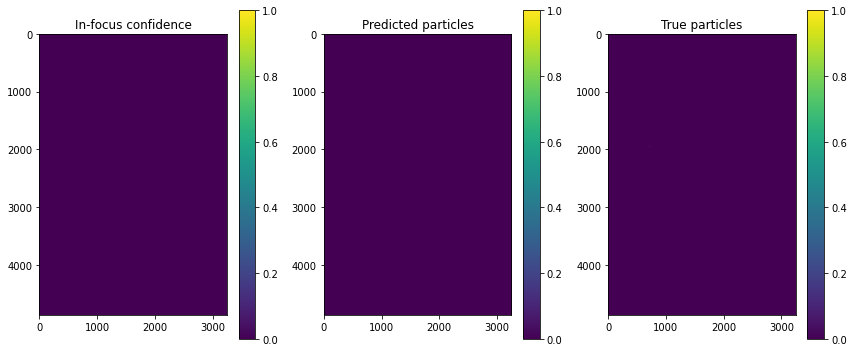

Plane: 222 at z: 0.046039 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0147:  24%|██▍       | 243/1000 [1:02:44<3:30:27, 16.68s/it]

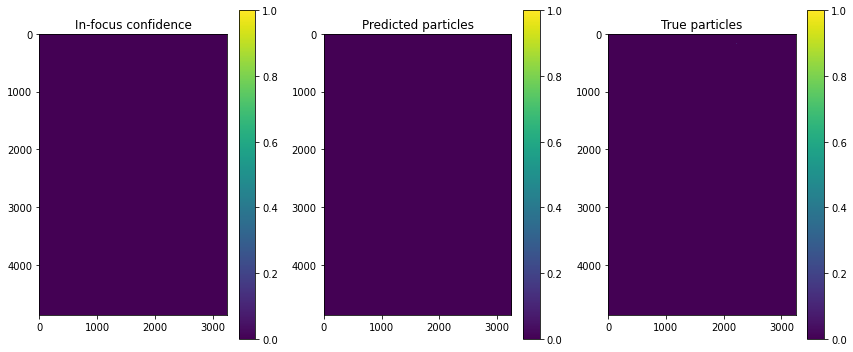

Plane: 223 at z: 0.046182999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0147:  24%|██▍       | 244/1000 [1:03:01<3:29:28, 16.63s/it]

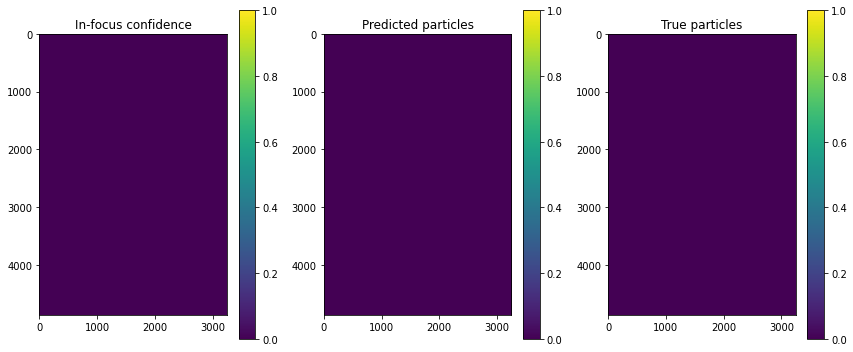

Plane: 224 at z: 0.046327 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0147:  24%|██▍       | 245/1000 [1:03:17<3:27:57, 16.53s/it]            

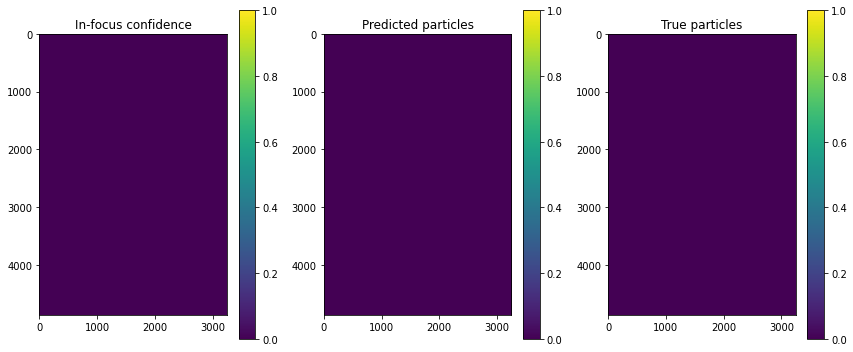

Plane: 225 at z: 0.046471 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0143:  25%|██▍       | 246/1000 [1:03:34<3:28:38, 16.60s/it]

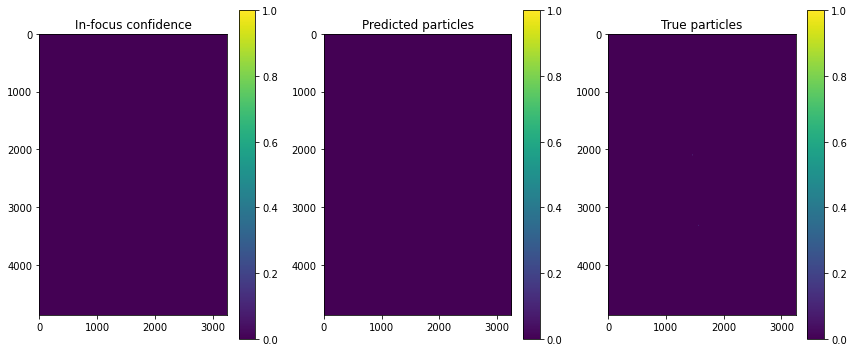

Plane: 226 at z: 0.046615 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0143:  25%|██▍       | 247/1000 [1:03:51<3:28:46, 16.64s/it]

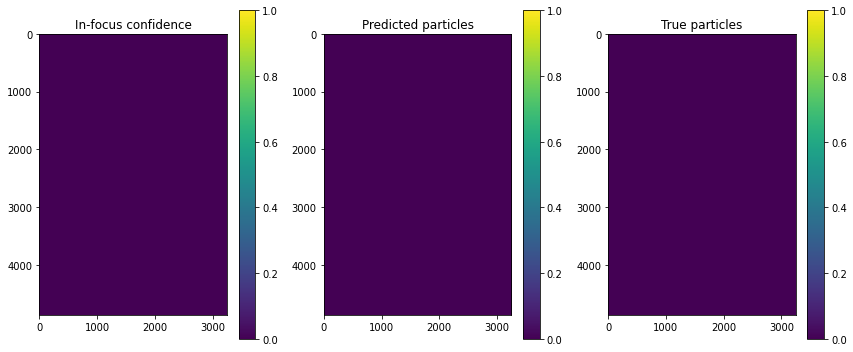

Plane: 227 at z: 0.046758999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0139:  25%|██▍       | 248/1000 [1:04:08<3:29:26, 16.71s/it]

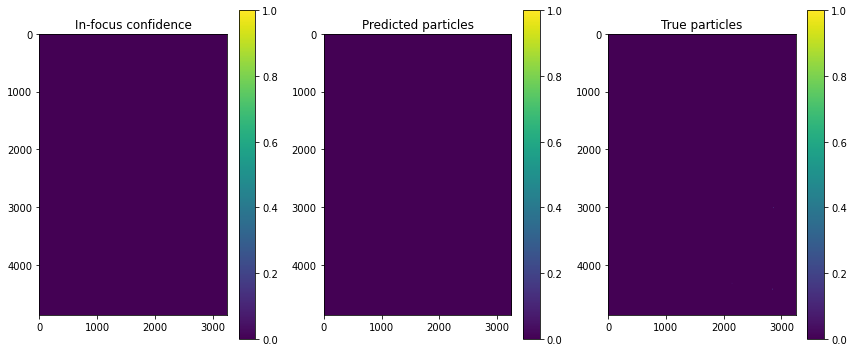

Plane: 228 at z: 0.046903 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0136:  25%|██▍       | 249/1000 [1:04:24<3:29:31, 16.74s/it]            

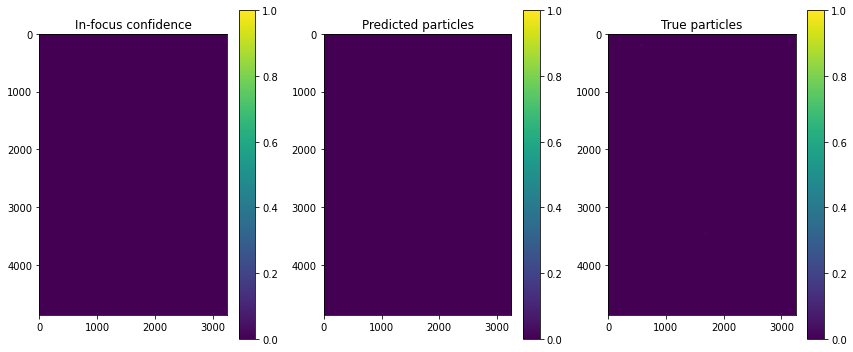

Plane: 229 at z: 0.047047 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0136:  25%|██▌       | 250/1000 [1:04:41<3:28:47, 16.70s/it]

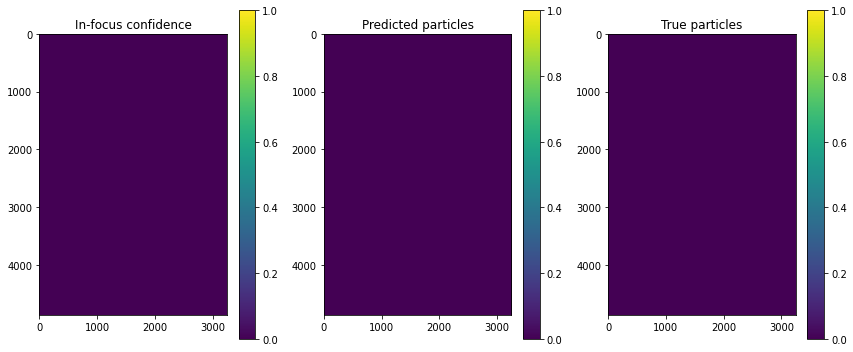

Plane: 230 at z: 0.047191 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0132:  25%|██▌       | 251/1000 [1:04:58<3:27:53, 16.65s/it]

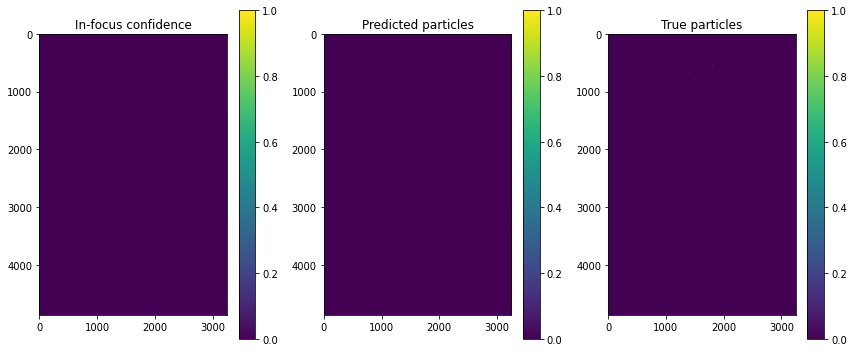

Plane: 231 at z: 0.047334999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0132:  25%|██▌       | 253/1000 [1:05:14<2:40:39, 12.90s/it]

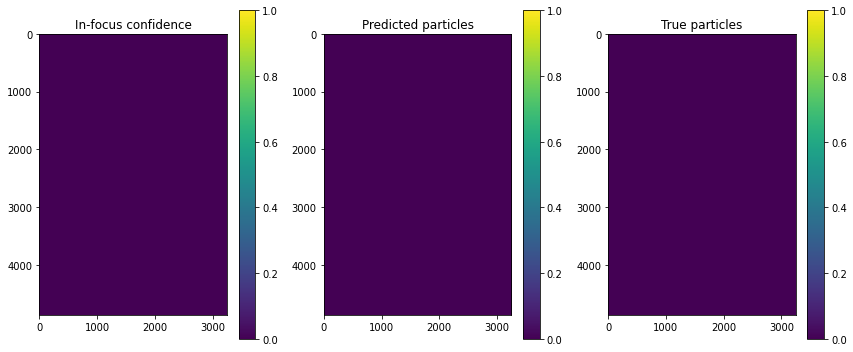

Plane: 232 at z: 0.047479 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0132:  25%|██▌       | 254/1000 [1:05:30<2:53:44, 13.97s/it]            

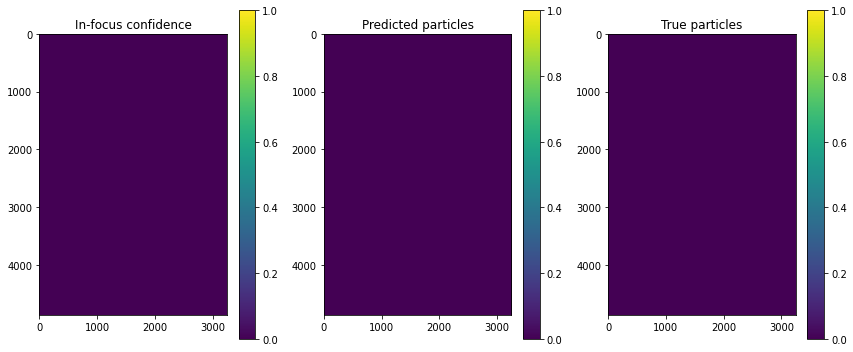

Plane: 233 at z: 0.047623 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0131:  26%|██▌       | 255/1000 [1:05:47<3:02:48, 14.72s/it]

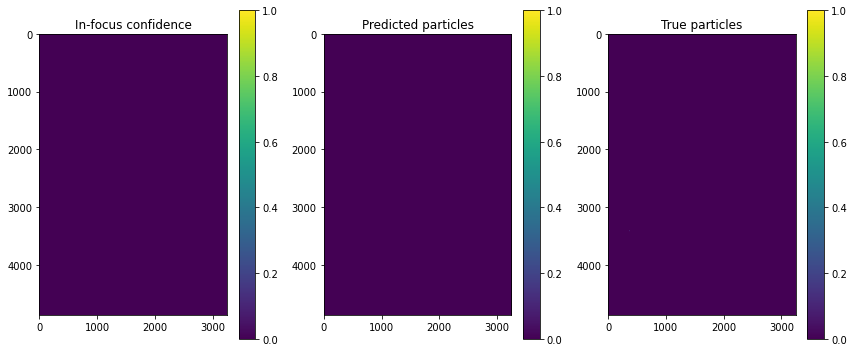

Plane: 234 at z: 0.047767 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0130:  26%|██▌       | 256/1000 [1:06:04<3:10:03, 15.33s/it]

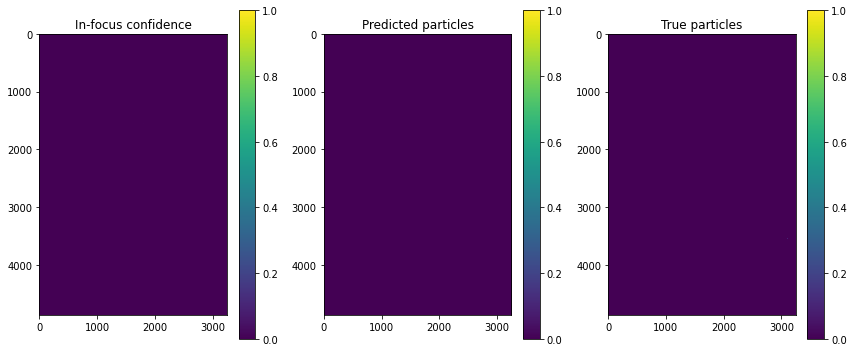

Plane: 235 at z: 0.047910999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0129:  26%|██▌       | 257/1000 [1:06:21<3:15:41, 15.80s/it]

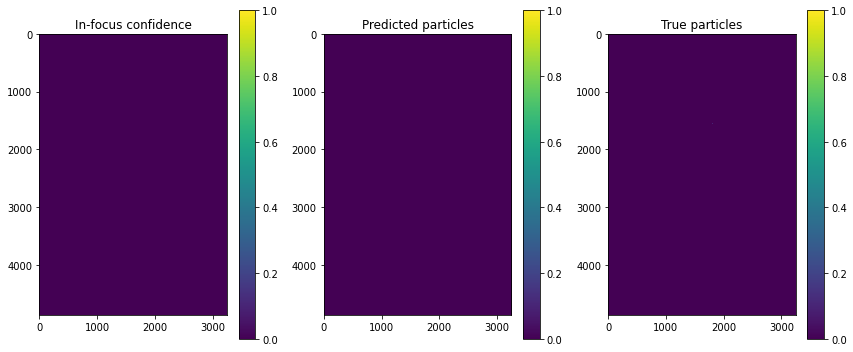

Plane: 236 at z: 0.048055 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.1091 holo_csi: 0.0144:  26%|██▌       | 258/1000 [1:06:37<3:18:23, 16.04s/it]            

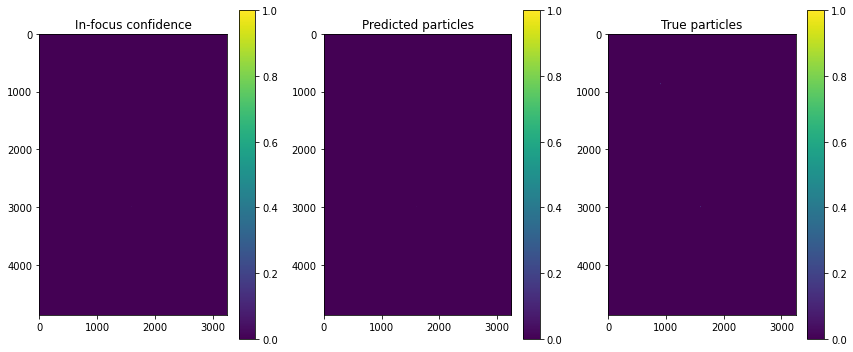

Plane: 237 at z: 0.048199 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0141:  26%|██▌       | 259/1000 [1:06:54<3:20:51, 16.26s/it]

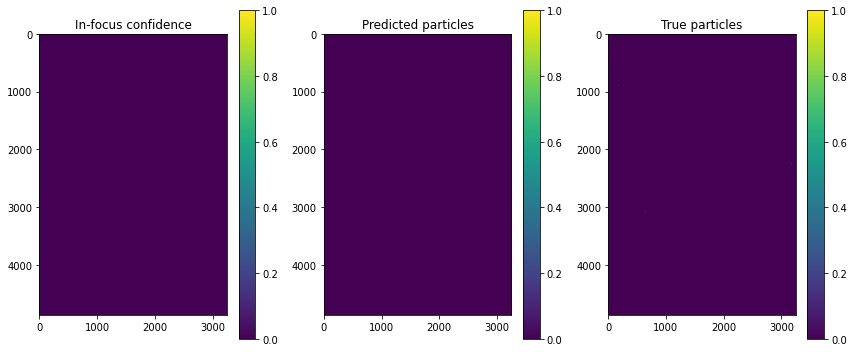

Plane: 238 at z: 0.048343 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  26%|██▌       | 260/1000 [1:07:10<3:21:09, 16.31s/it]

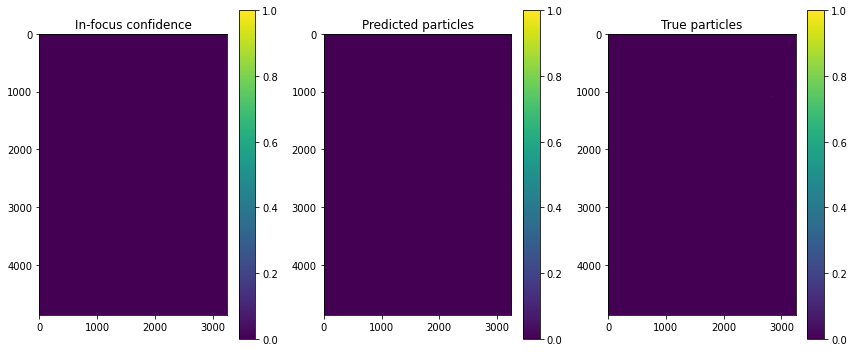

Plane: 239 at z: 0.048486999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  26%|██▌       | 261/1000 [1:07:27<3:21:30, 16.36s/it]

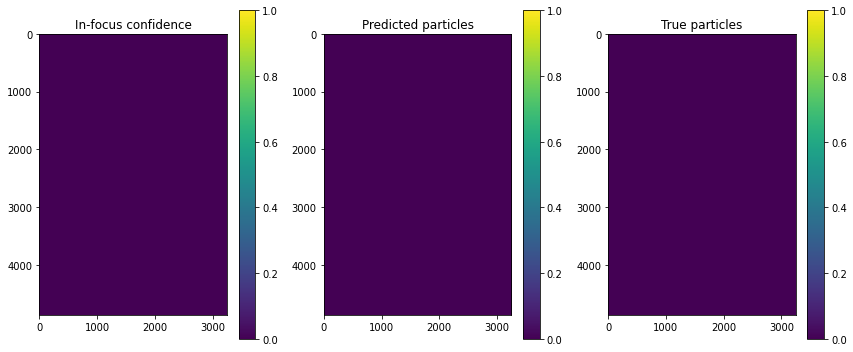

Plane: 240 at z: 0.048631 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0137:  26%|██▌       | 262/1000 [1:07:44<3:23:14, 16.52s/it]            

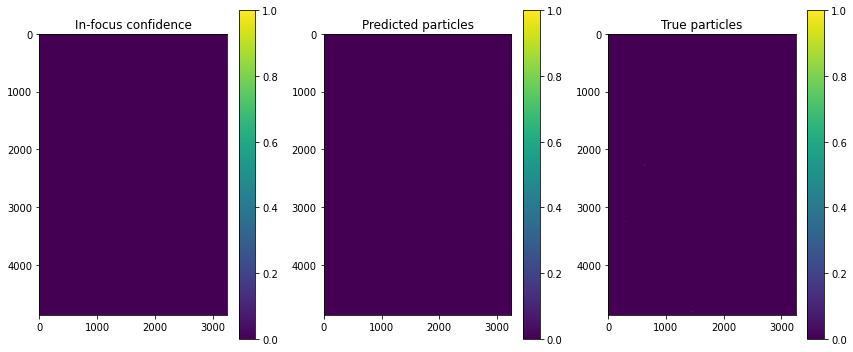

Plane: 241 at z: 0.048775 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0137:  26%|██▋       | 263/1000 [1:08:00<3:23:16, 16.55s/it]

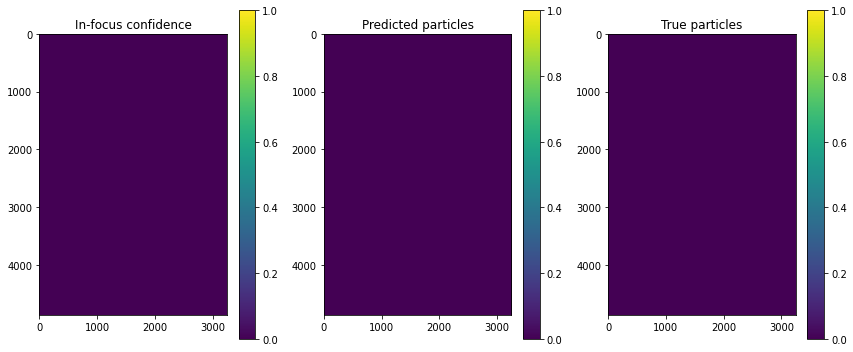

Plane: 242 at z: 0.048919 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0137:  26%|██▋       | 264/1000 [1:08:17<3:23:27, 16.59s/it]

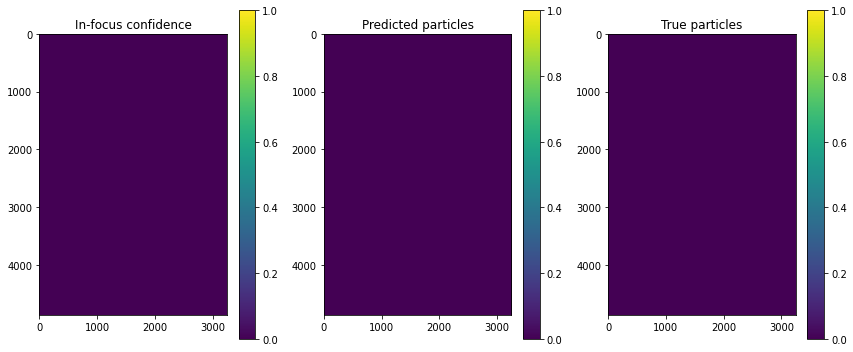

Plane: 243 at z: 0.049062999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0135:  26%|██▋       | 265/1000 [1:08:34<3:23:05, 16.58s/it]

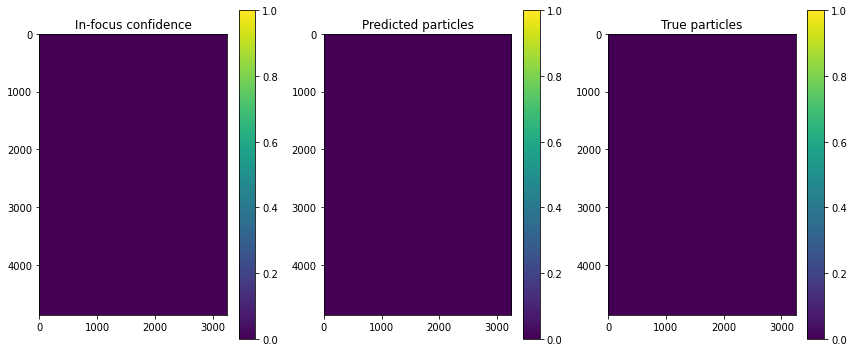

Plane: 244 at z: 0.049207 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0134:  27%|██▋       | 266/1000 [1:08:50<3:23:14, 16.61s/it]            

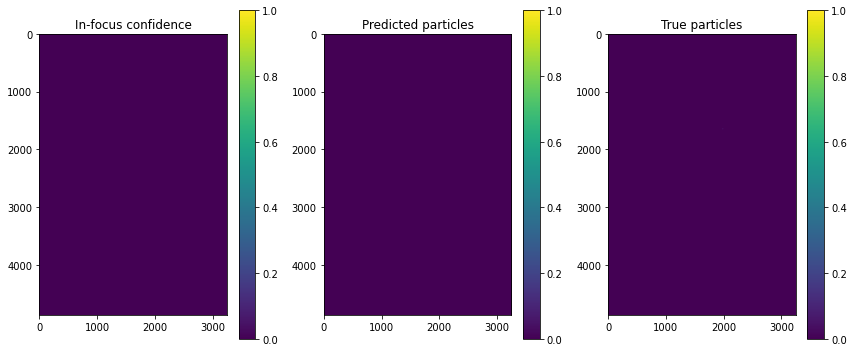

Plane: 245 at z: 0.049351 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0133:  27%|██▋       | 267/1000 [1:09:07<3:23:06, 16.63s/it]

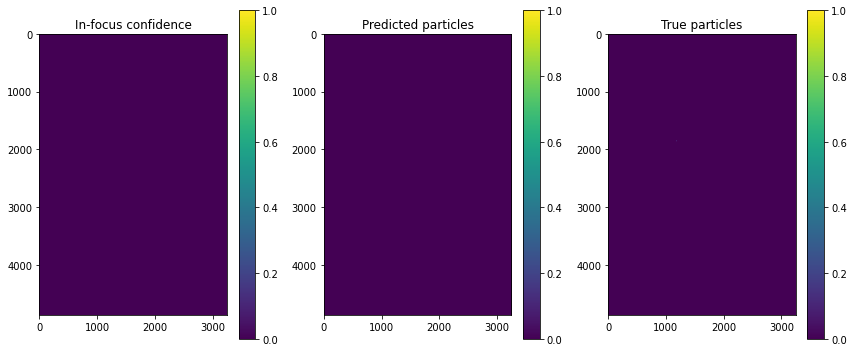

Plane: 246 at z: 0.049495 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0133:  27%|██▋       | 268/1000 [1:09:24<3:23:21, 16.67s/it]

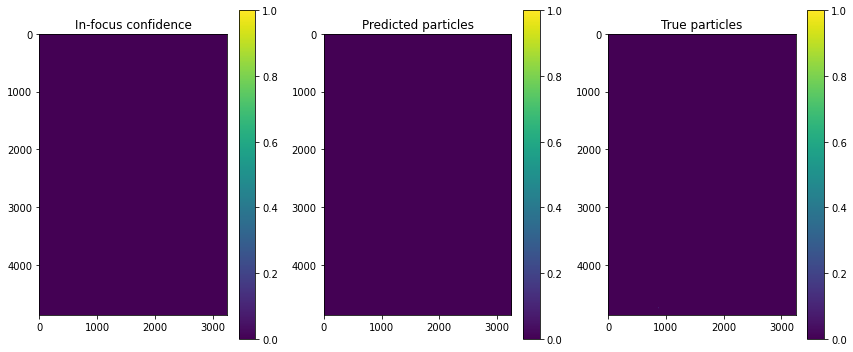

Plane: 247 at z: 0.049638999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0131:  27%|██▋       | 269/1000 [1:09:40<3:23:12, 16.68s/it]

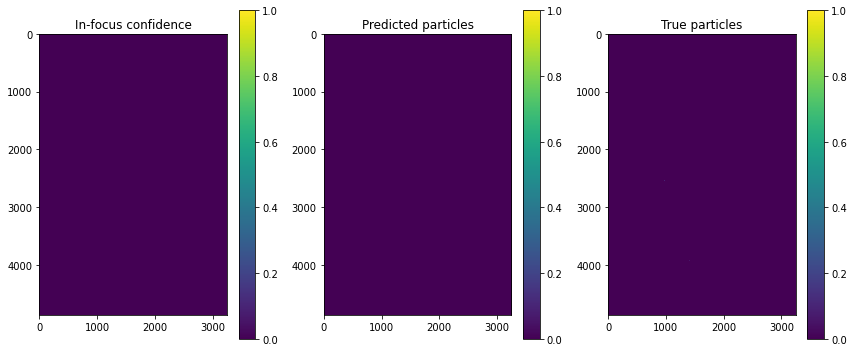

Plane: 248 at z: 0.049783 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0130:  27%|██▋       | 270/1000 [1:09:57<3:23:57, 16.76s/it]            

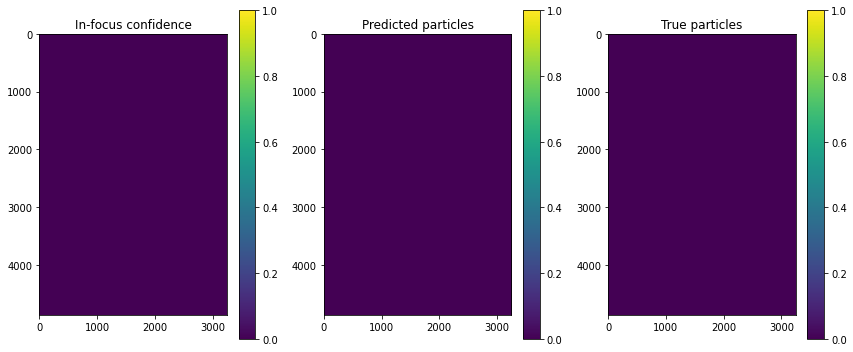

Plane: 249 at z: 0.049927 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0130:  27%|██▋       | 271/1000 [1:10:14<3:22:38, 16.68s/it]

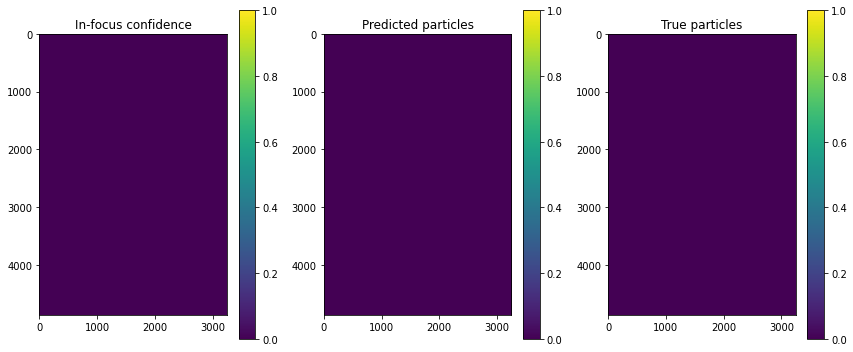

Plane: 250 at z: 0.050071 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0128:  27%|██▋       | 272/1000 [1:10:30<3:21:10, 16.58s/it]

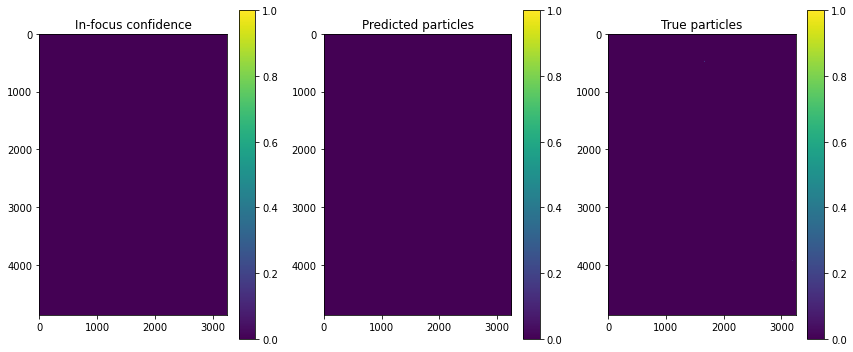

Plane: 251 at z: 0.050214999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0128:  27%|██▋       | 273/1000 [1:10:46<3:19:44, 16.48s/it]

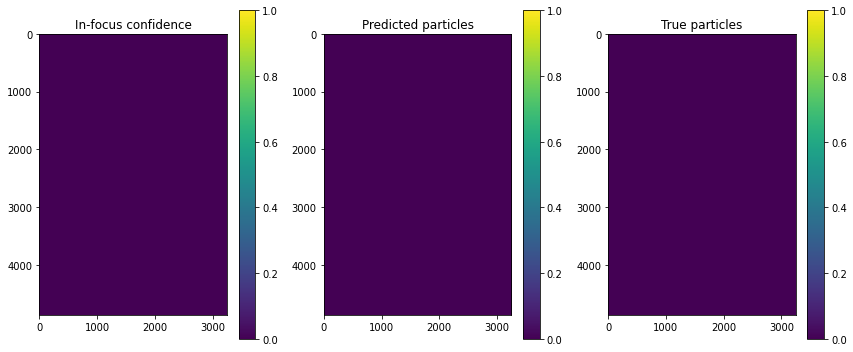

Plane: 252 at z: 0.050359 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0127:  27%|██▋       | 274/1000 [1:11:03<3:19:37, 16.50s/it]            

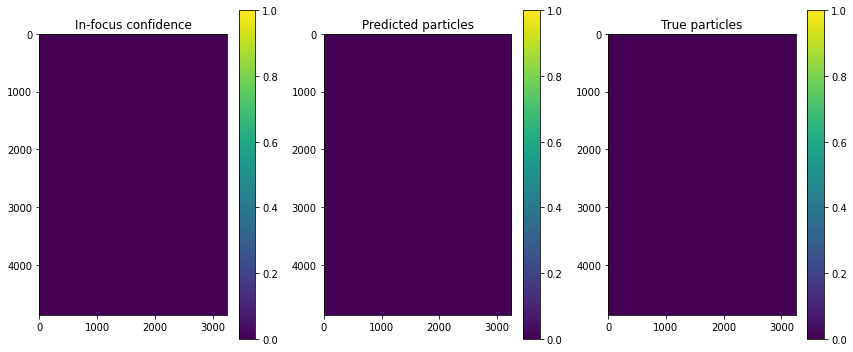

Plane: 253 at z: 0.050503 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0127:  28%|██▊       | 276/1000 [1:11:20<2:35:46, 12.91s/it]

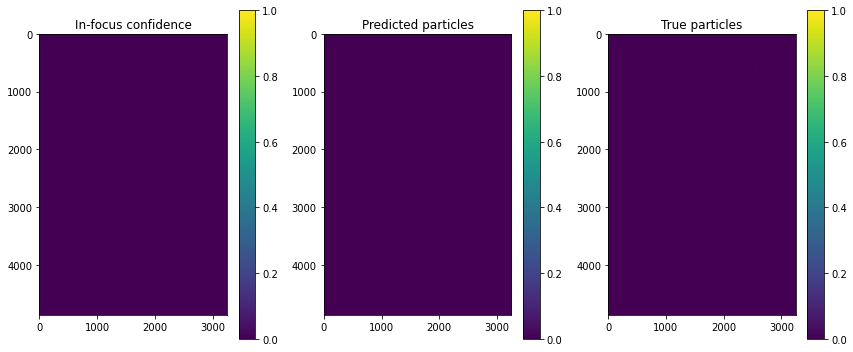

Plane: 254 at z: 0.050647 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0125:  28%|██▊       | 277/1000 [1:11:37<2:49:54, 14.10s/it]

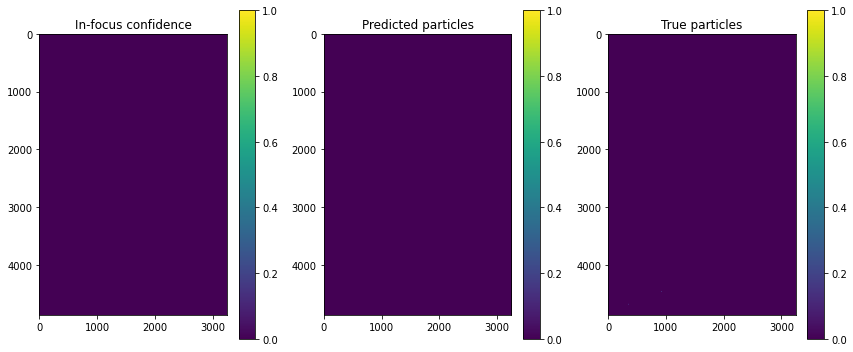

Plane: 255 at z: 0.050790999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0124:  28%|██▊       | 278/1000 [1:11:53<2:59:48, 14.94s/it]

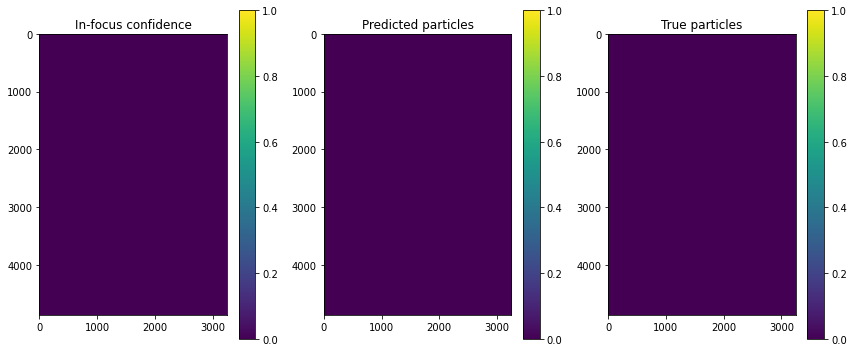

Plane: 256 at z: 0.050935 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0124:  28%|██▊       | 279/1000 [1:12:10<3:05:10, 15.41s/it]            

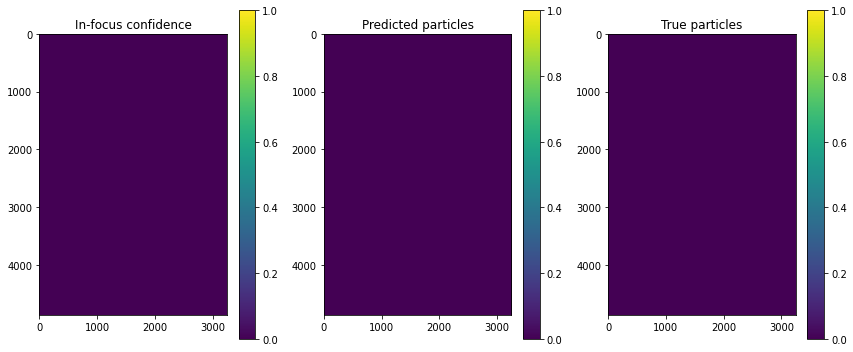

Plane: 257 at z: 0.051079 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0124:  28%|██▊       | 280/1000 [1:12:26<3:08:36, 15.72s/it]

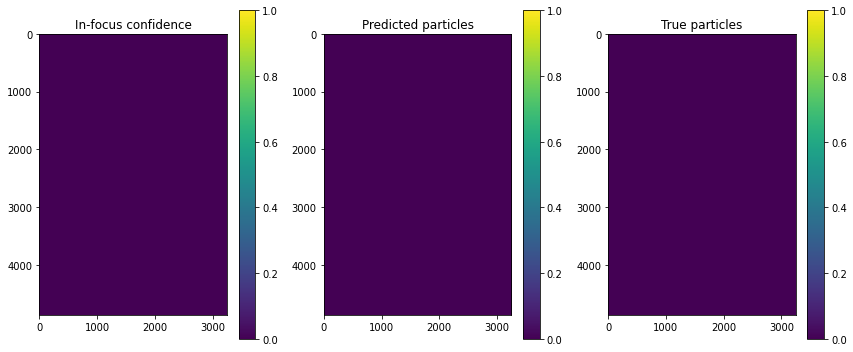

Plane: 258 at z: 0.051223 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.3438 holo_csi: 0.0150:  28%|██▊       | 281/1000 [1:12:43<3:11:19, 15.97s/it]

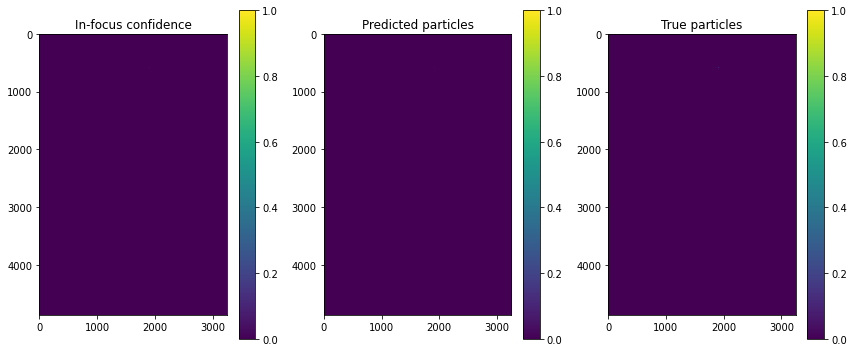

Plane: 259 at z: 0.051366999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0149:  28%|██▊       | 282/1000 [1:13:00<3:13:33, 16.17s/it]

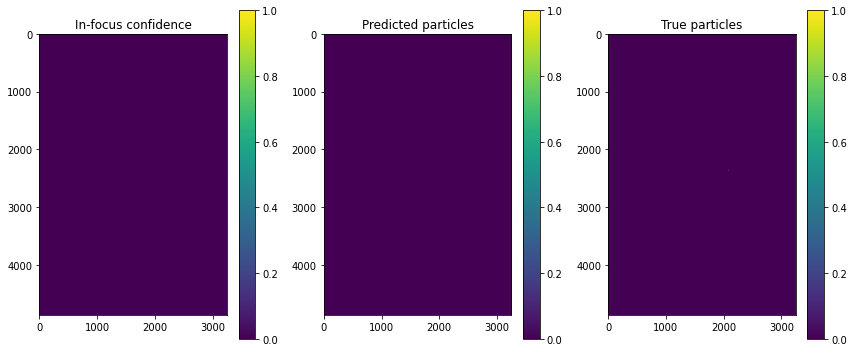

Plane: 260 at z: 0.051510999999999994 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0149:  28%|██▊       | 283/1000 [1:13:16<3:15:15, 16.34s/it]

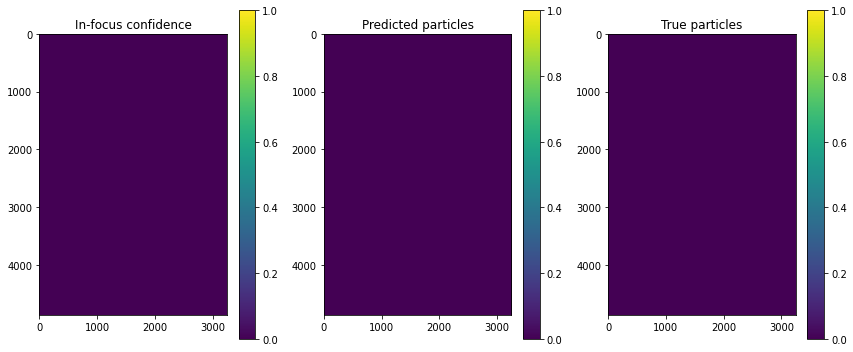

Plane: 261 at z: 0.051655 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0148:  28%|██▊       | 284/1000 [1:13:34<3:19:17, 16.70s/it]            

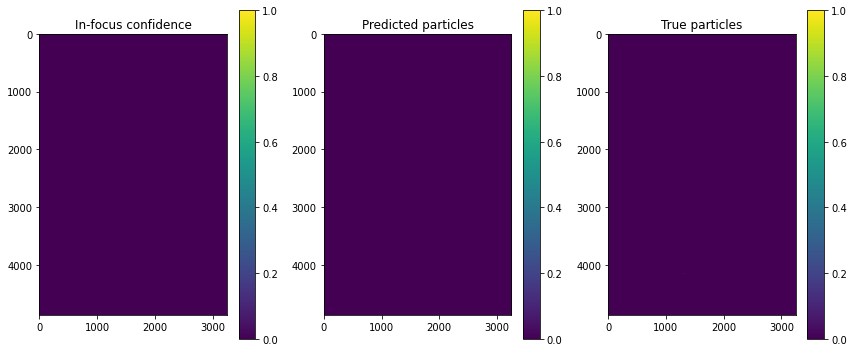

Plane: 262 at z: 0.051799 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0147:  28%|██▊       | 285/1000 [1:13:51<3:19:53, 16.77s/it]

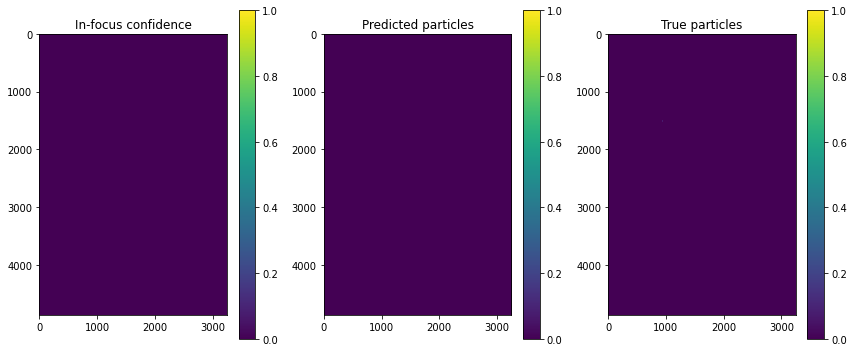

Plane: 263 at z: 0.051942999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0145:  29%|██▊       | 286/1000 [1:14:08<3:20:48, 16.87s/it]

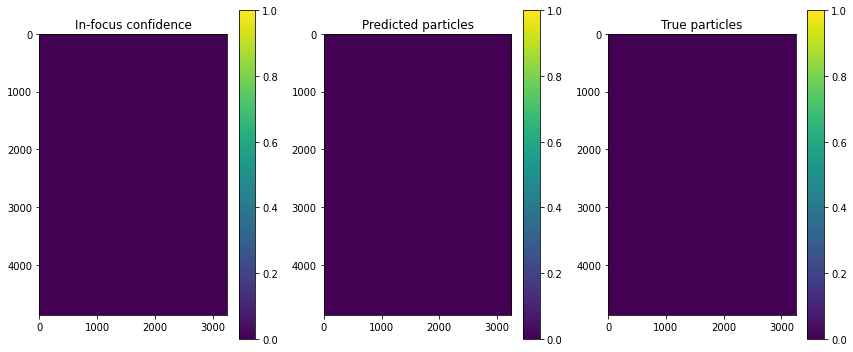

Plane: 264 at z: 0.052086999999999994 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0145:  29%|██▊       | 287/1000 [1:14:25<3:22:13, 17.02s/it]

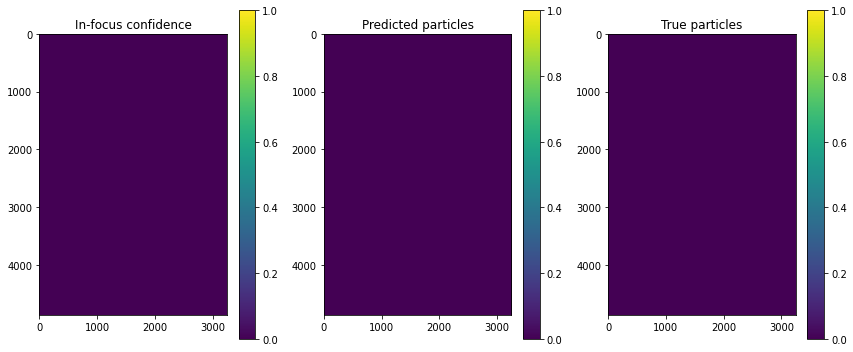

Plane: 265 at z: 0.052231 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0142:  29%|██▉       | 288/1000 [1:14:43<3:22:55, 17.10s/it]            

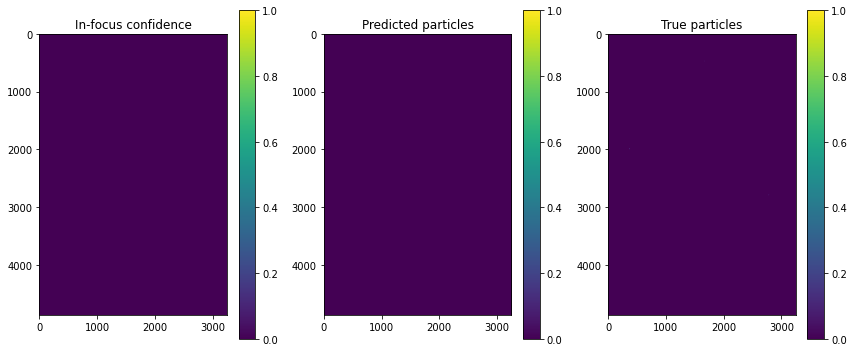

Plane: 266 at z: 0.052375 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0142:  29%|██▉       | 289/1000 [1:15:00<3:23:16, 17.15s/it]

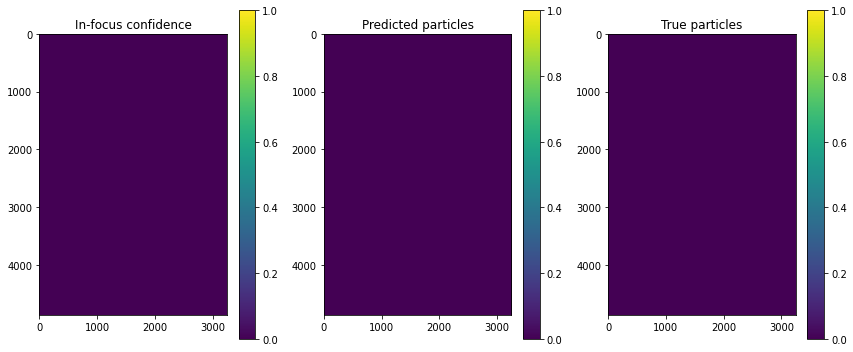

Plane: 267 at z: 0.052518999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0142:  29%|██▉       | 290/1000 [1:15:17<3:23:07, 17.17s/it]

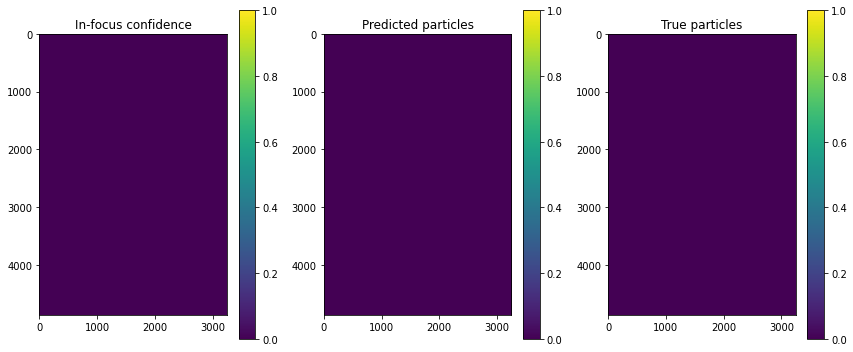

Plane: 268 at z: 0.052662999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0142:  29%|██▉       | 291/1000 [1:15:34<3:22:49, 17.16s/it]

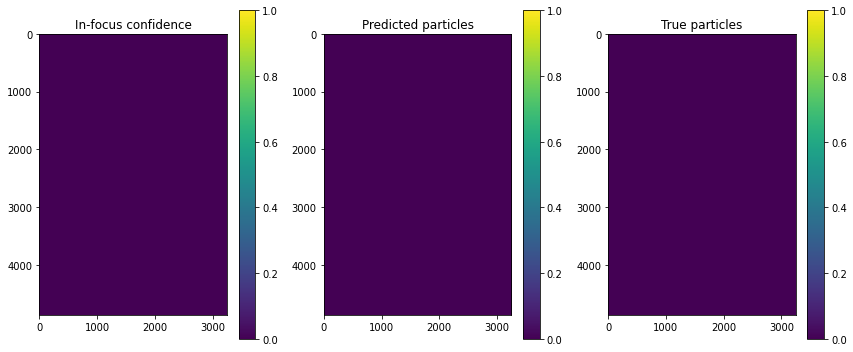

Plane: 269 at z: 0.052807 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0142:  29%|██▉       | 292/1000 [1:15:51<3:23:02, 17.21s/it]            

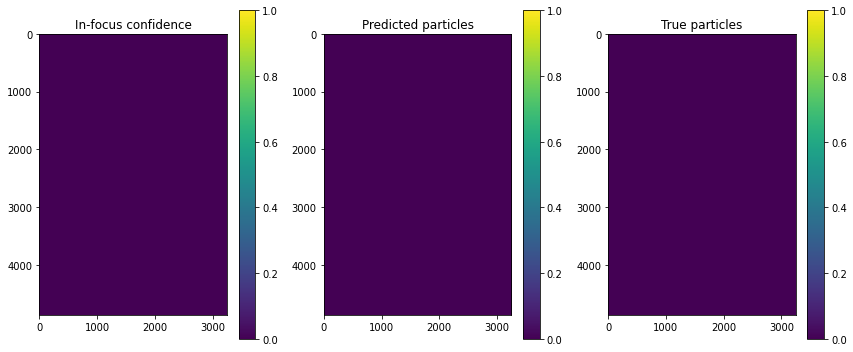

Plane: 270 at z: 0.052951 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0141:  29%|██▉       | 293/1000 [1:16:09<3:22:06, 17.15s/it]

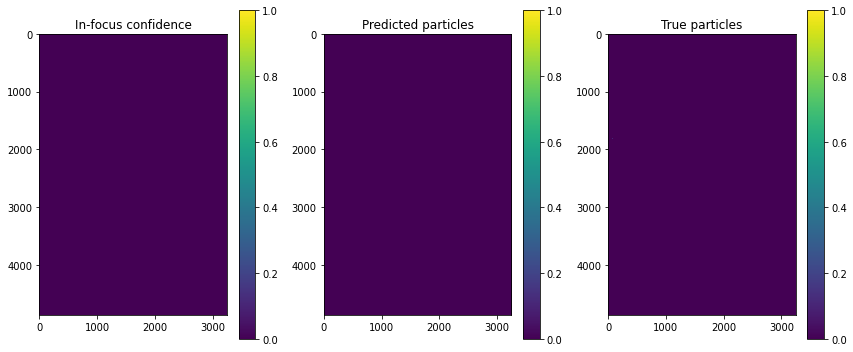

Plane: 271 at z: 0.053094999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0141:  29%|██▉       | 294/1000 [1:16:25<3:20:51, 17.07s/it]

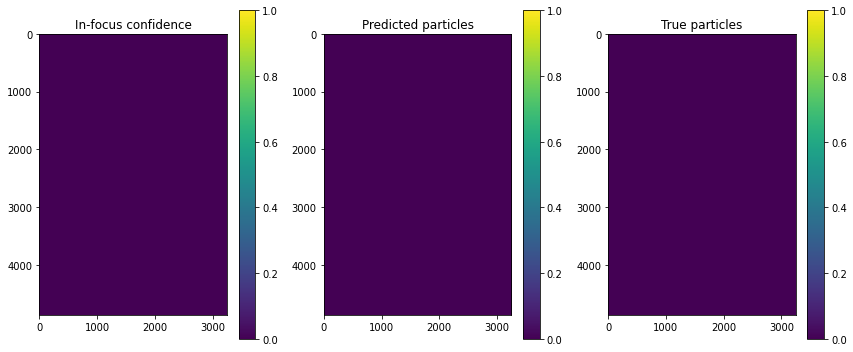

Plane: 272 at z: 0.053238999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  30%|██▉       | 295/1000 [1:16:43<3:21:53, 17.18s/it]

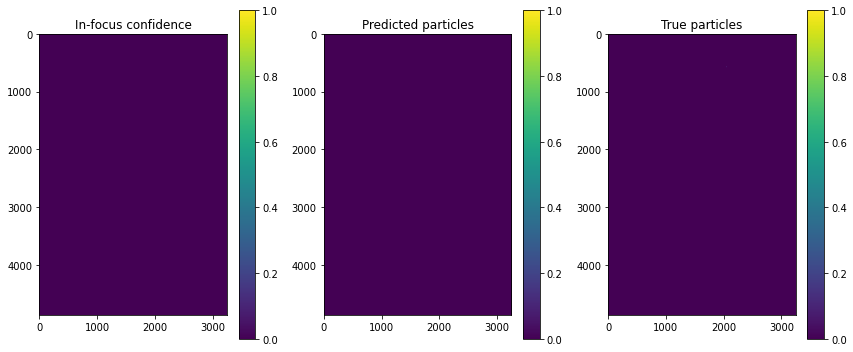

Plane: 273 at z: 0.053383 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  30%|██▉       | 296/1000 [1:17:00<3:21:26, 17.17s/it]            

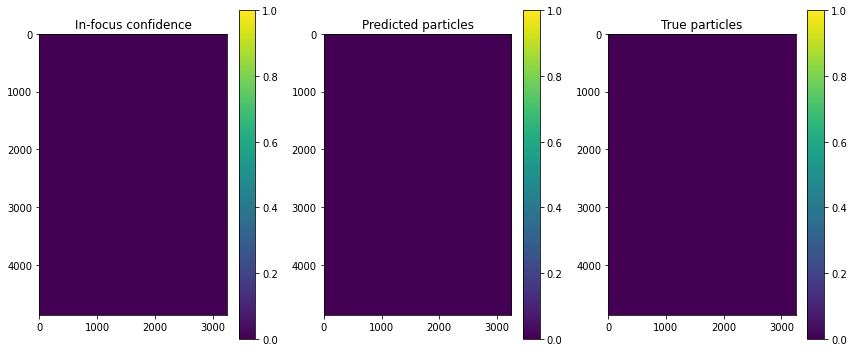

Plane: 274 at z: 0.053527 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0138:  30%|██▉       | 297/1000 [1:17:18<3:22:39, 17.30s/it]

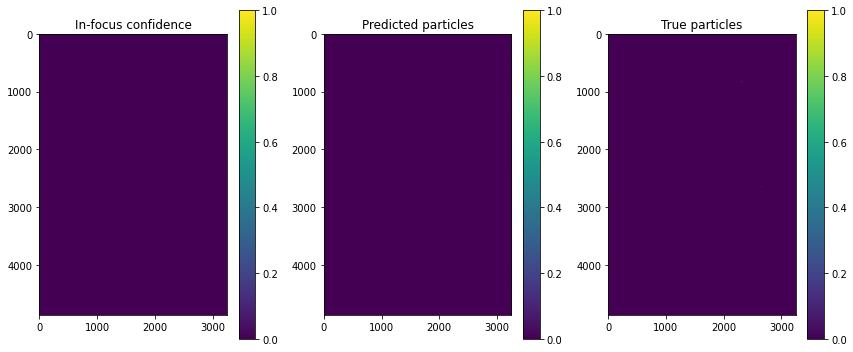

Plane: 275 at z: 0.053670999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0469 holo_csi: 0.0142:  30%|██▉       | 298/1000 [1:17:35<3:23:06, 17.36s/it]

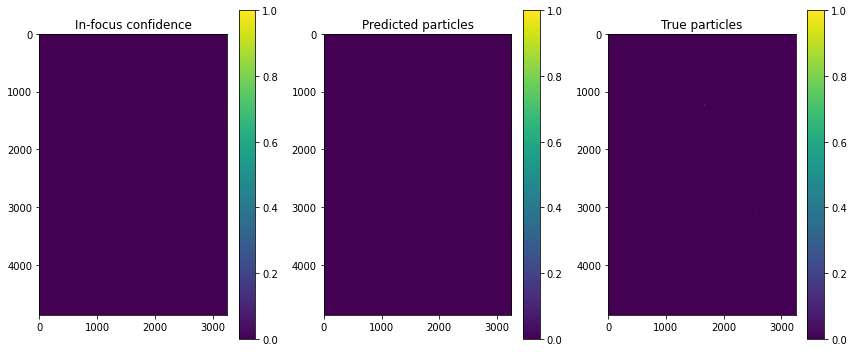

Plane: 276 at z: 0.053814999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0142:  30%|███       | 300/1000 [1:17:52<2:36:36, 13.42s/it]

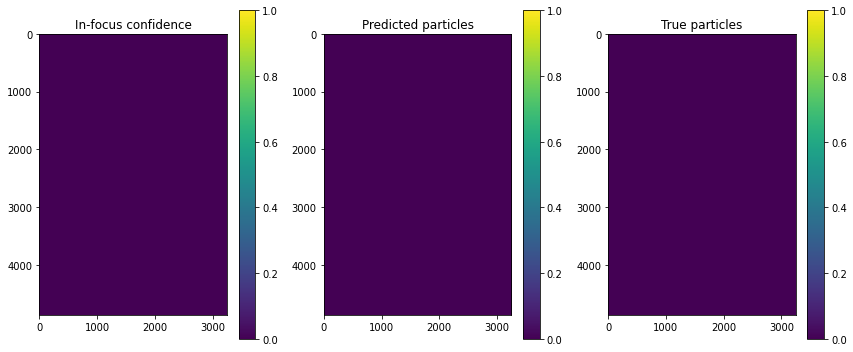

Plane: 277 at z: 0.053959 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0141:  30%|███       | 301/1000 [1:18:09<2:50:17, 14.62s/it]            

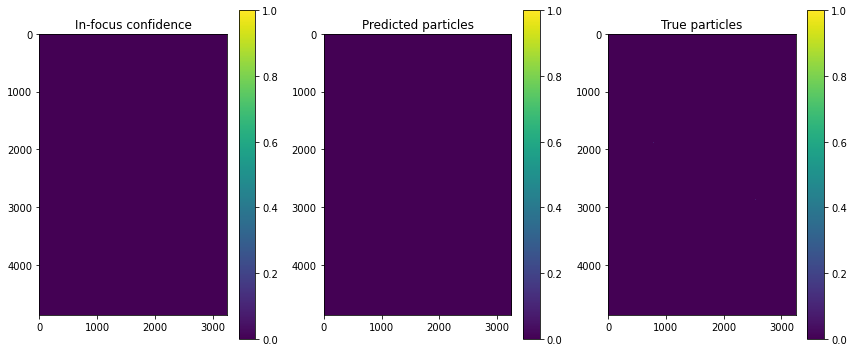

Plane: 278 at z: 0.054103 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0141:  30%|███       | 302/1000 [1:18:27<2:58:49, 15.37s/it]

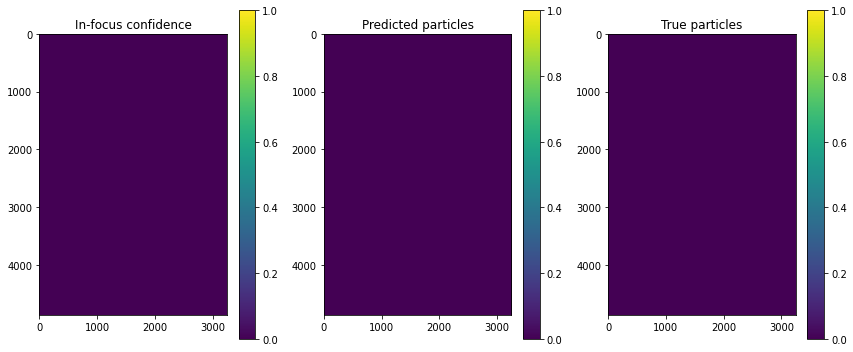

Plane: 279 at z: 0.054247 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0139:  30%|███       | 303/1000 [1:18:44<3:05:06, 15.94s/it]

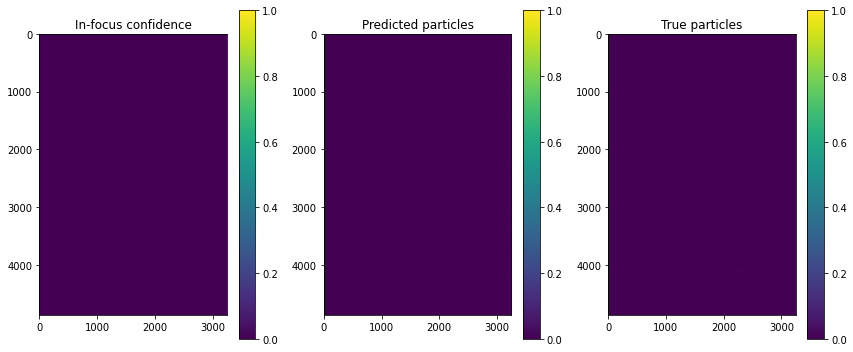

Plane: 280 at z: 0.054390999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0139:  30%|███       | 304/1000 [1:19:01<3:09:44, 16.36s/it]

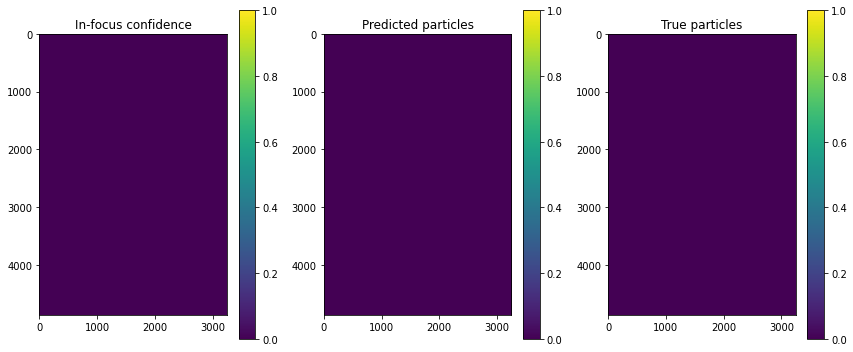

Plane: 281 at z: 0.054535 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0139:  30%|███       | 305/1000 [1:19:18<3:12:37, 16.63s/it]            

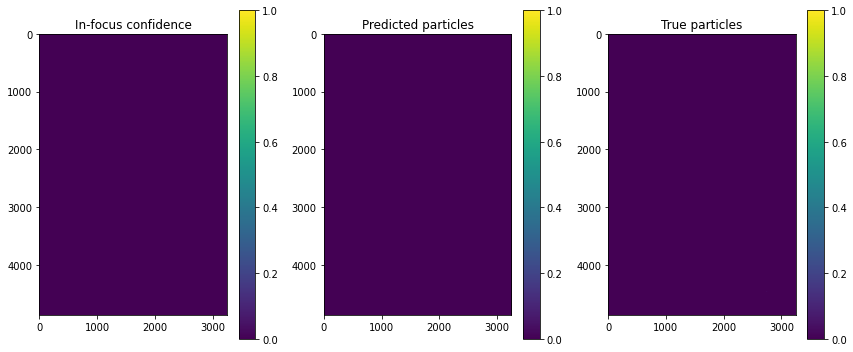

Plane: 282 at z: 0.054679 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0139:  31%|███       | 306/1000 [1:19:35<3:13:30, 16.73s/it]

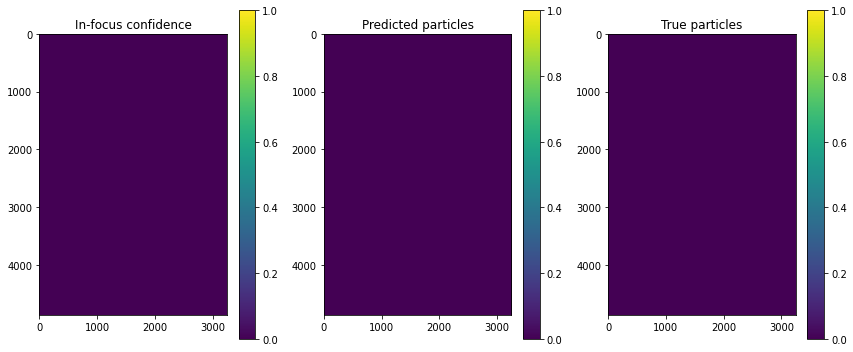

Plane: 283 at z: 0.054823 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0139:  31%|███       | 307/1000 [1:19:53<3:14:55, 16.88s/it]

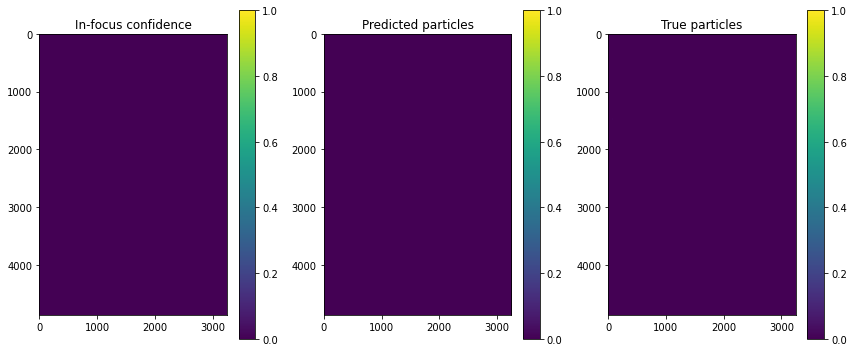

Plane: 284 at z: 0.054966999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.1053 holo_csi: 0.0142:  31%|███       | 308/1000 [1:20:10<3:15:11, 16.92s/it]

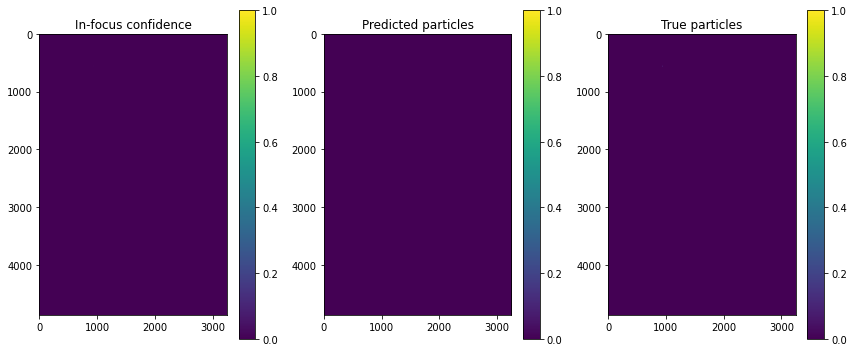

Plane: 285 at z: 0.055111 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0141:  31%|███       | 309/1000 [1:20:27<3:16:03, 17.02s/it]            

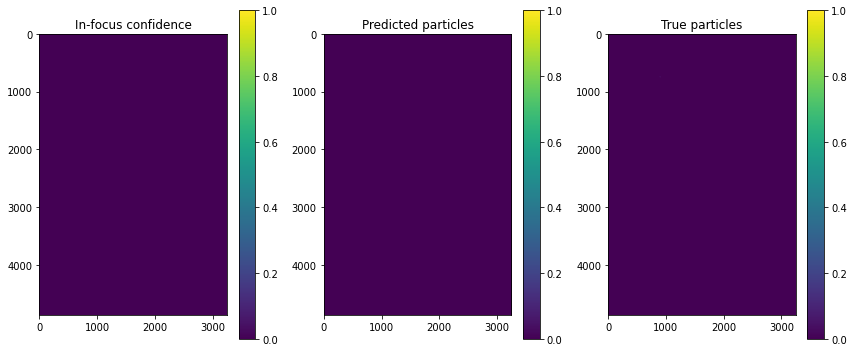

Plane: 286 at z: 0.055255 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0141:  31%|███       | 310/1000 [1:20:44<3:17:11, 17.15s/it]

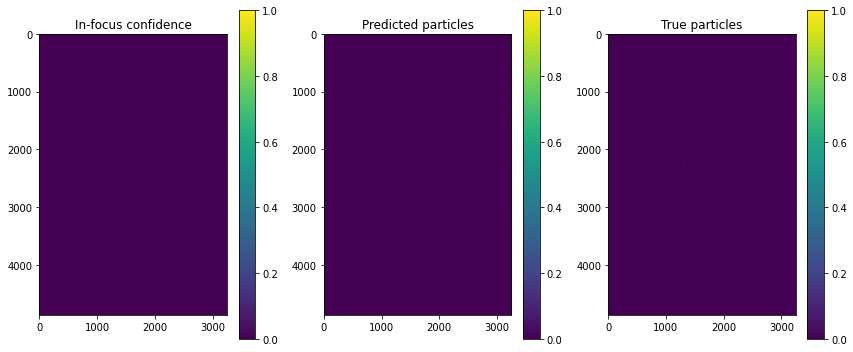

Plane: 287 at z: 0.055399 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  31%|███       | 311/1000 [1:21:02<3:17:10, 17.17s/it]

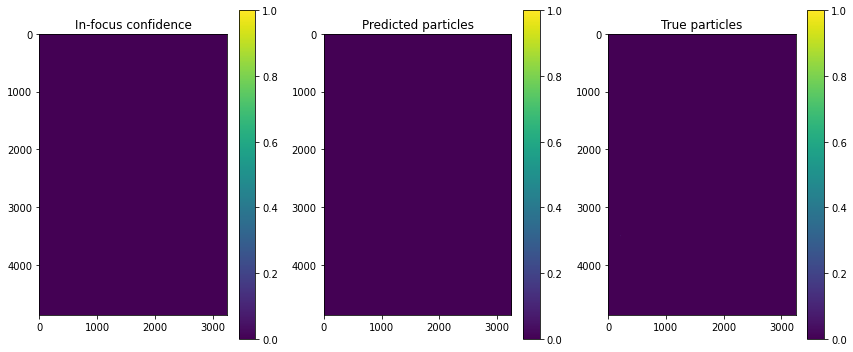

Plane: 288 at z: 0.055542999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  31%|███       | 312/1000 [1:21:19<3:16:16, 17.12s/it]

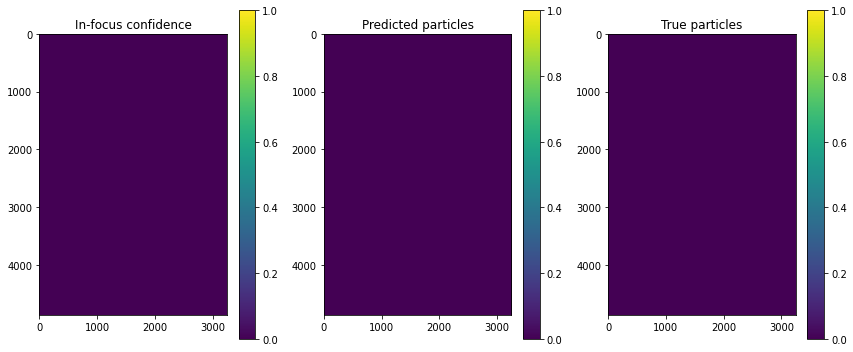

Plane: 289 at z: 0.055687 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0139:  31%|███▏      | 313/1000 [1:21:36<3:16:15, 17.14s/it]            

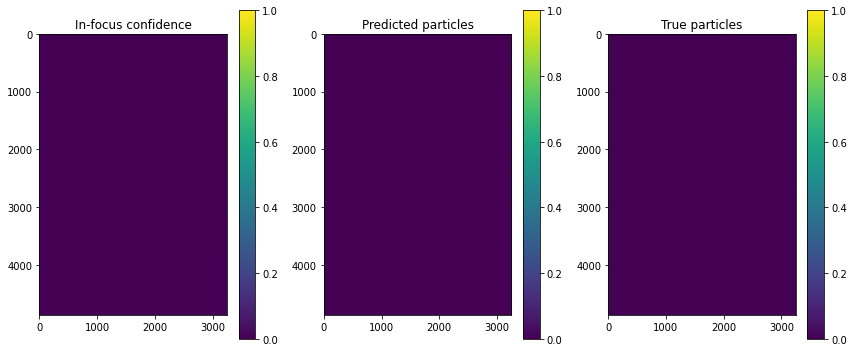

Plane: 290 at z: 0.055831 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0139:  31%|███▏      | 314/1000 [1:21:53<3:15:10, 17.07s/it]

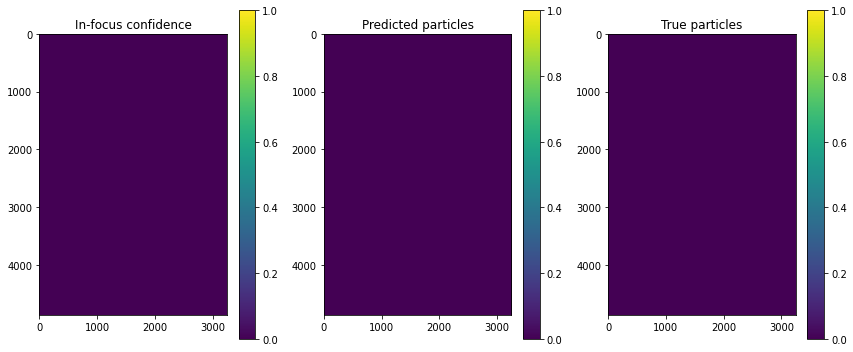

Plane: 291 at z: 0.055975 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0139:  32%|███▏      | 315/1000 [1:22:10<3:15:05, 17.09s/it]

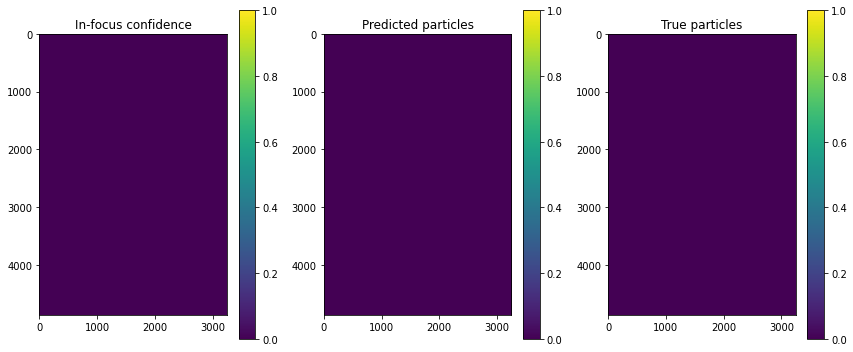

Plane: 292 at z: 0.056118999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0138:  32%|███▏      | 316/1000 [1:22:27<3:15:16, 17.13s/it]

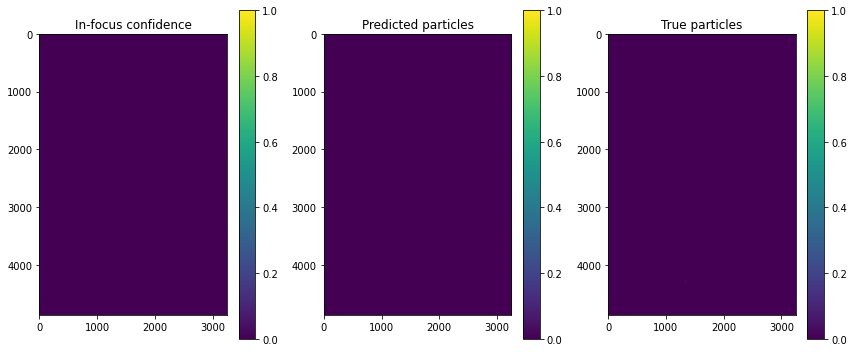

Plane: 293 at z: 0.056263 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0138:  32%|███▏      | 317/1000 [1:22:44<3:14:28, 17.08s/it]            

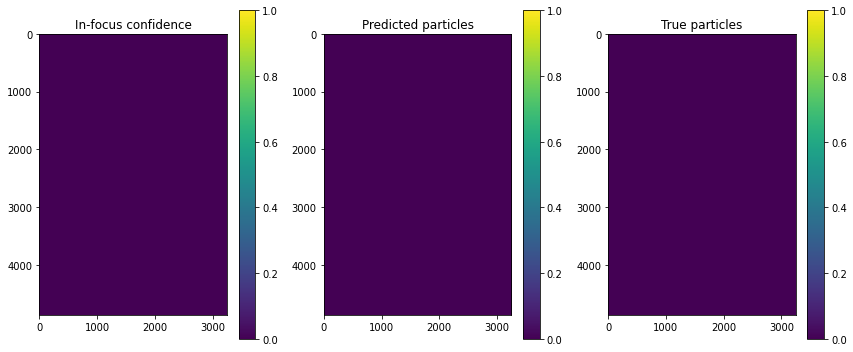

Plane: 294 at z: 0.056407 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0138:  32%|███▏      | 318/1000 [1:23:01<3:15:22, 17.19s/it]

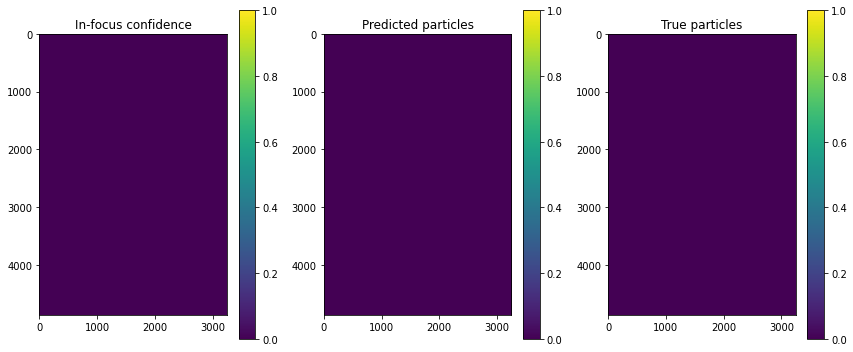

Plane: 295 at z: 0.056551 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0137:  32%|███▏      | 319/1000 [1:23:19<3:14:48, 17.16s/it]

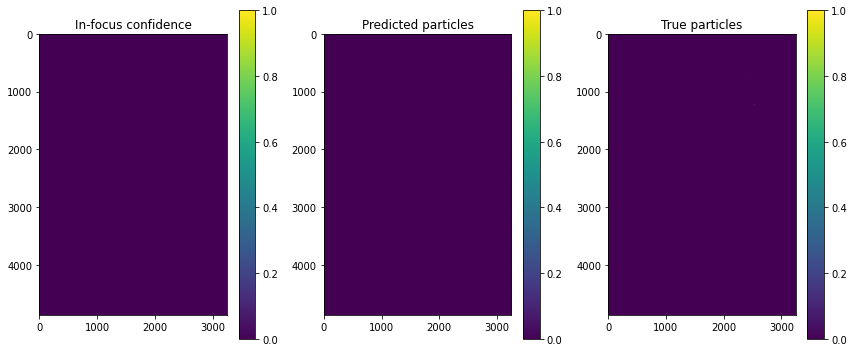

Plane: 296 at z: 0.056694999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0137:  32%|███▏      | 320/1000 [1:23:36<3:13:46, 17.10s/it]

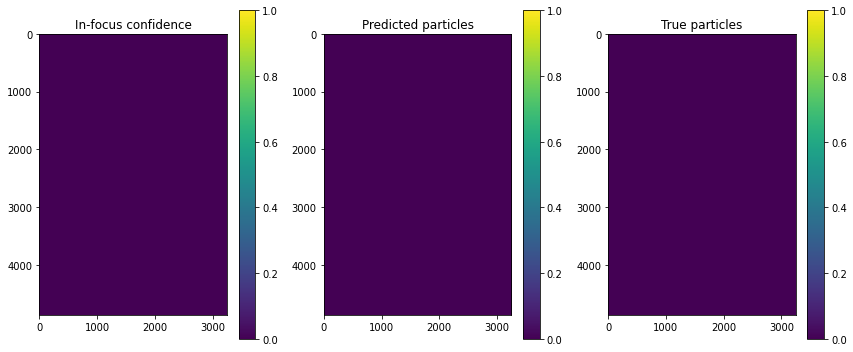

Plane: 297 at z: 0.056839 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.1000 holo_csi: 0.0142:  32%|███▏      | 321/1000 [1:23:53<3:13:54, 17.14s/it]            

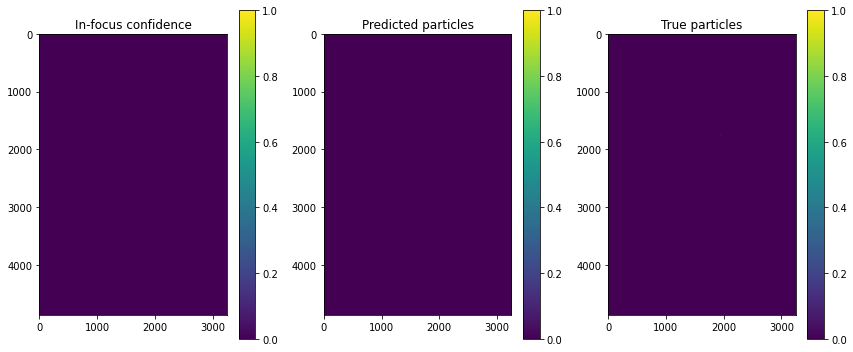

Plane: 298 at z: 0.056983 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0142:  32%|███▏      | 322/1000 [1:24:10<3:12:42, 17.05s/it]

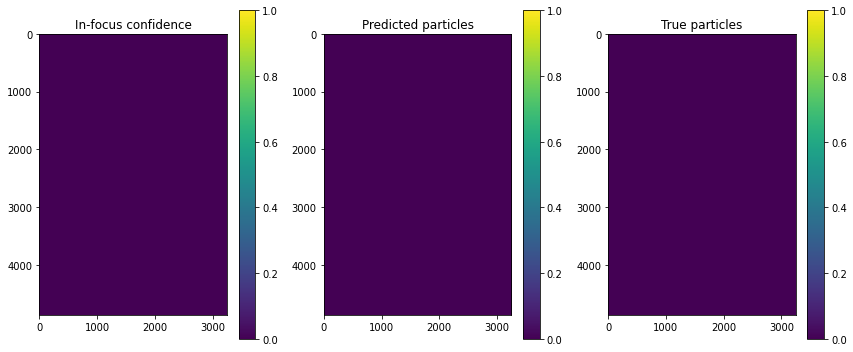

Plane: 299 at z: 0.057127 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0141:  32%|███▏      | 323/1000 [1:24:27<3:13:04, 17.11s/it]

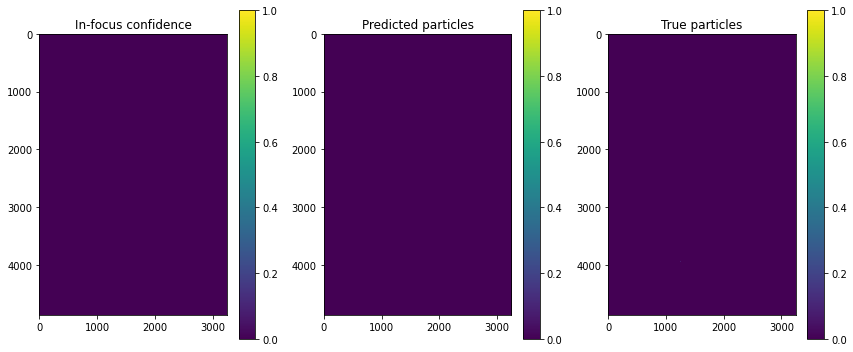

Plane: 300 at z: 0.057270999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0141:  32%|███▎      | 325/1000 [1:24:44<2:30:50, 13.41s/it]

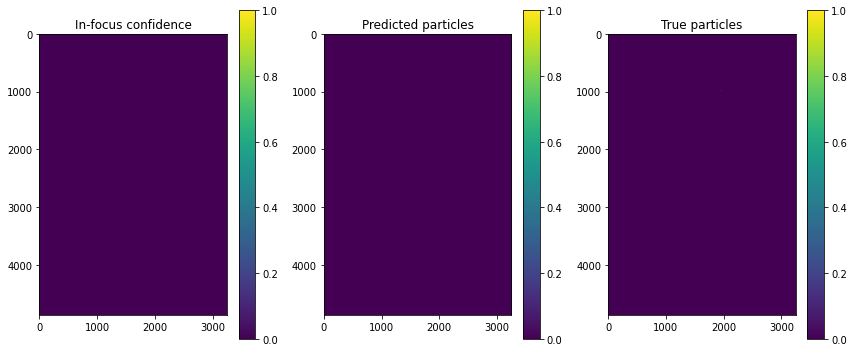

Plane: 301 at z: 0.057415 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  33%|███▎      | 326/1000 [1:25:01<2:42:31, 14.47s/it]            

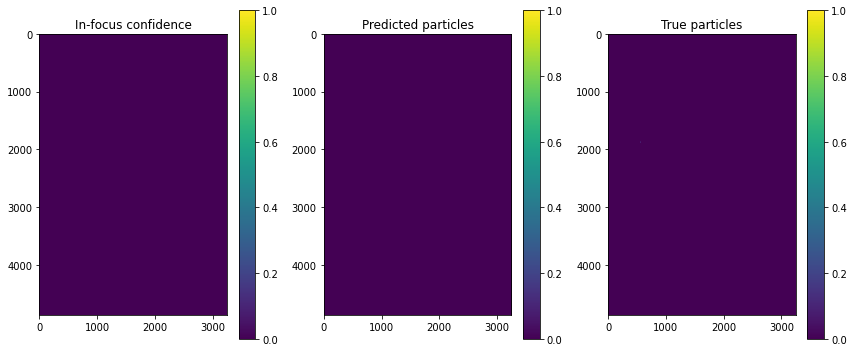

Plane: 302 at z: 0.057559 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  33%|███▎      | 327/1000 [1:25:18<2:51:23, 15.28s/it]

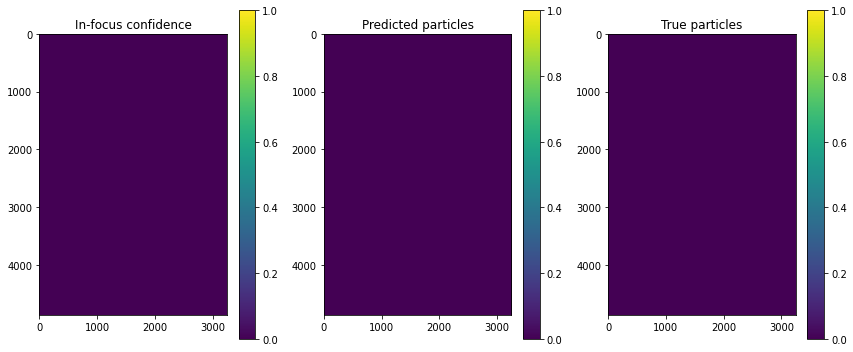

Plane: 303 at z: 0.057703 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  33%|███▎      | 328/1000 [1:25:36<2:57:19, 15.83s/it]

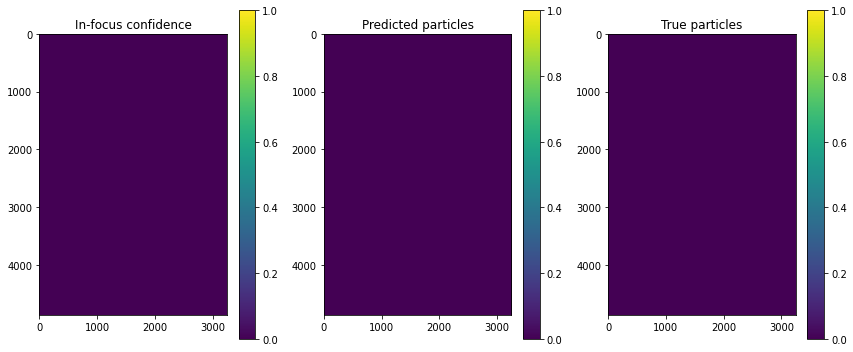

Plane: 304 at z: 0.057846999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0139:  33%|███▎      | 329/1000 [1:25:53<3:02:37, 16.33s/it]

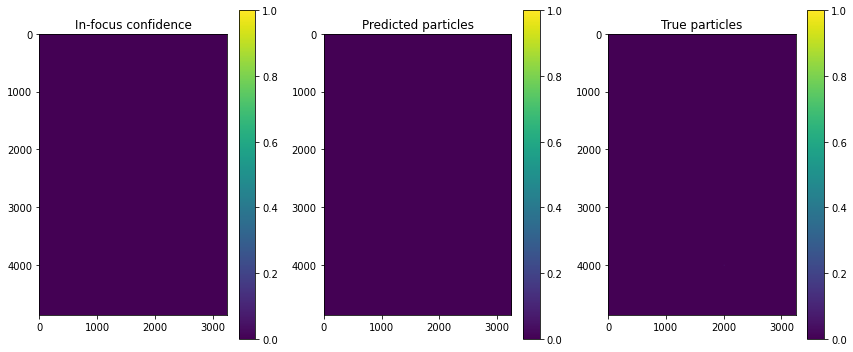

Plane: 305 at z: 0.057990999999999994 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0366 holo_csi: 0.0143:  33%|███▎      | 330/1000 [1:26:11<3:06:52, 16.74s/it]

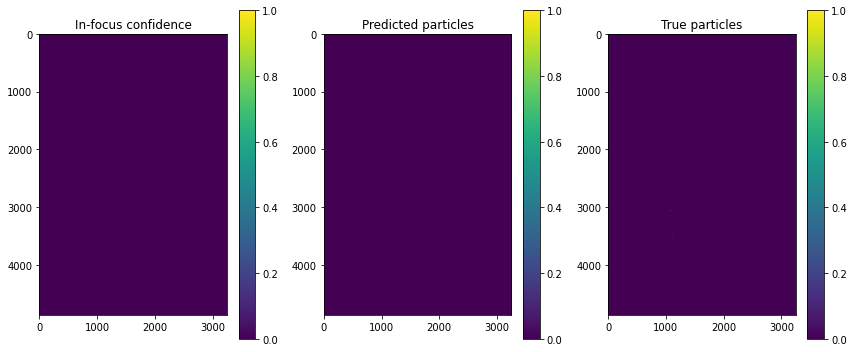

Plane: 306 at z: 0.058135 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0141:  33%|███▎      | 331/1000 [1:26:28<3:08:32, 16.91s/it]            

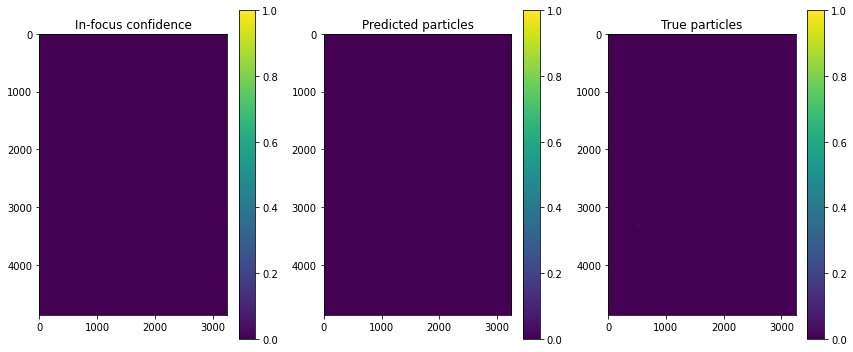

Plane: 307 at z: 0.058279 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0141:  33%|███▎      | 332/1000 [1:26:45<3:09:35, 17.03s/it]

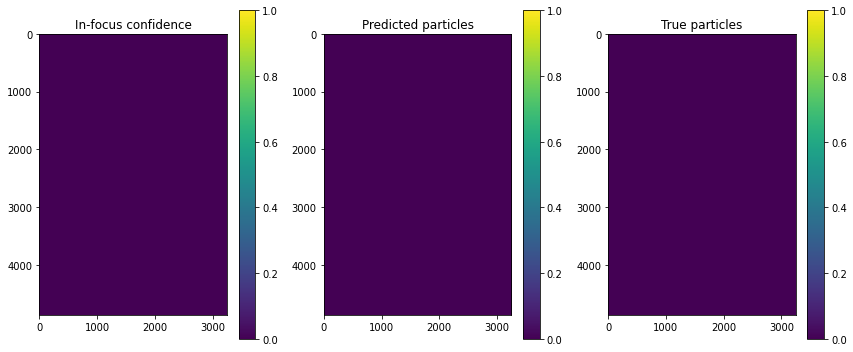

Plane: 308 at z: 0.058422999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0141:  33%|███▎      | 333/1000 [1:27:03<3:09:43, 17.07s/it]

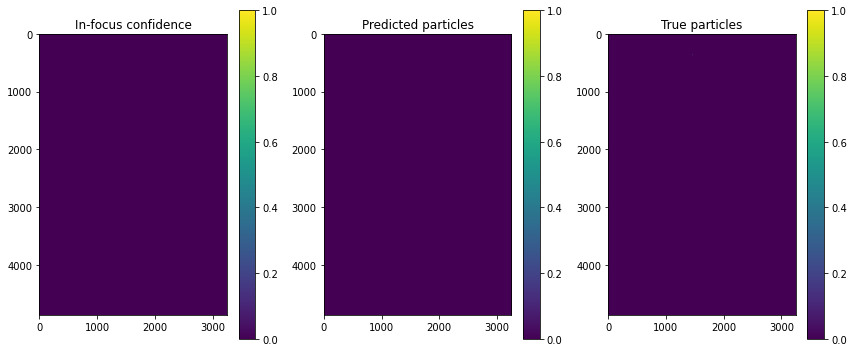

Plane: 309 at z: 0.058566999999999994 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0141:  33%|███▎      | 334/1000 [1:27:19<3:08:58, 17.03s/it]

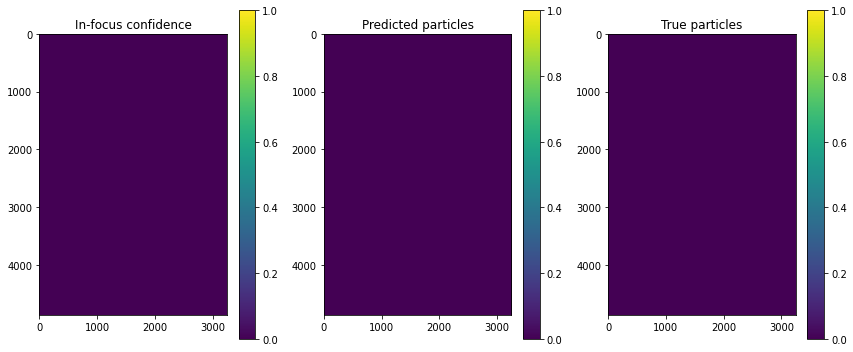

Plane: 310 at z: 0.058711 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  34%|███▎      | 335/1000 [1:27:37<3:09:53, 17.13s/it]            

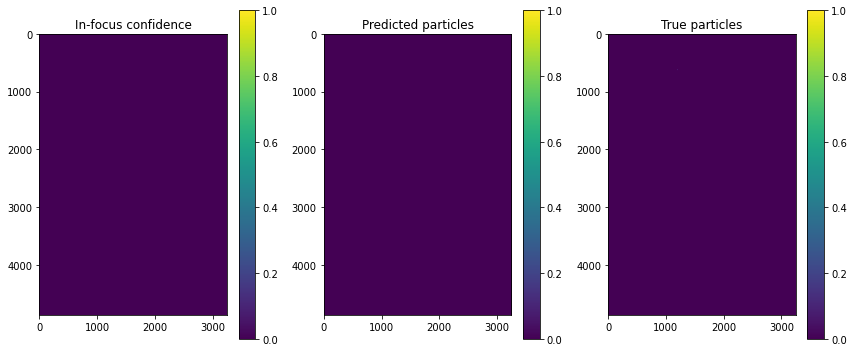

Plane: 311 at z: 0.058855 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  34%|███▎      | 336/1000 [1:27:54<3:09:24, 17.12s/it]

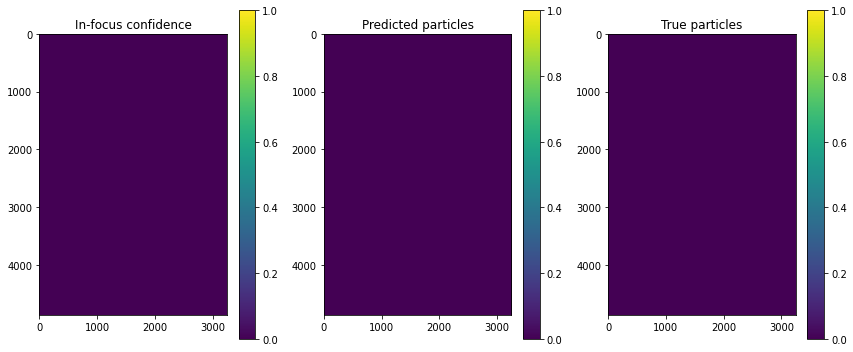

Plane: 312 at z: 0.058998999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  34%|███▎      | 337/1000 [1:28:11<3:09:02, 17.11s/it]

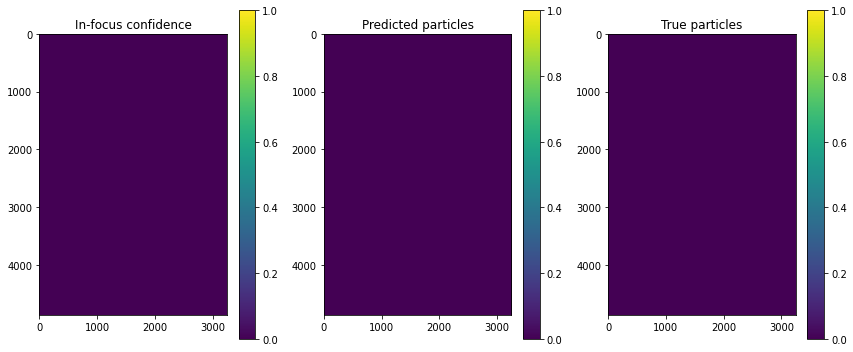

Plane: 313 at z: 0.059142999999999994 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0138:  34%|███▍      | 338/1000 [1:28:29<3:10:50, 17.30s/it]

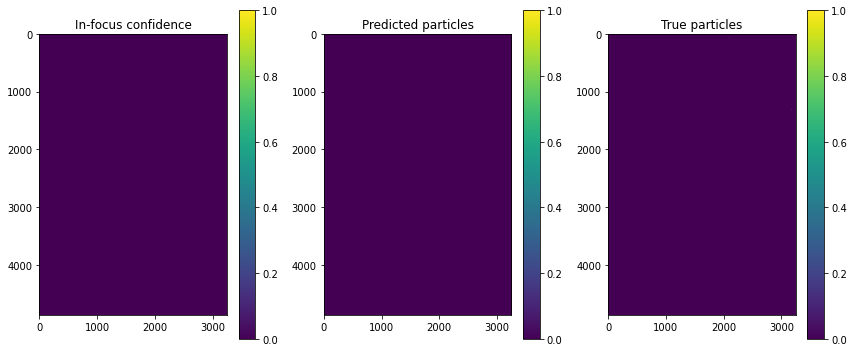

Plane: 314 at z: 0.059287 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0138:  34%|███▍      | 339/1000 [1:28:46<3:09:36, 17.21s/it]            

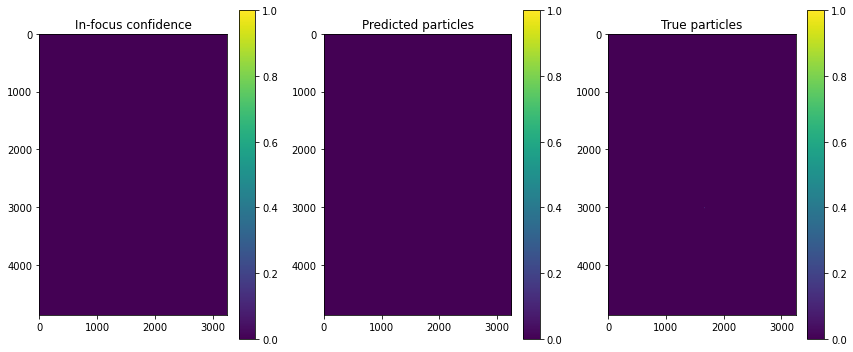

Plane: 315 at z: 0.059431 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0137:  34%|███▍      | 340/1000 [1:29:03<3:09:16, 17.21s/it]

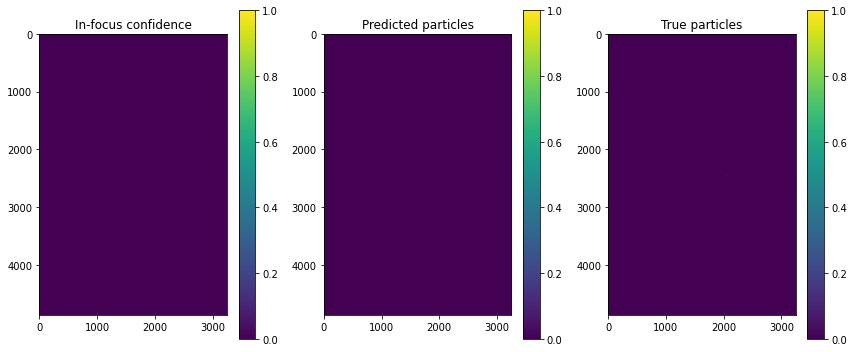

Plane: 316 at z: 0.059574999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0137:  34%|███▍      | 341/1000 [1:29:20<3:09:24, 17.24s/it]

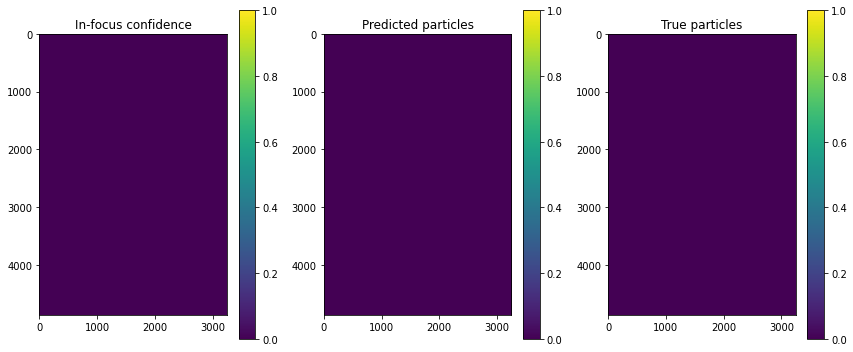

Plane: 317 at z: 0.059718999999999994 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0137:  34%|███▍      | 342/1000 [1:29:37<3:08:30, 17.19s/it]

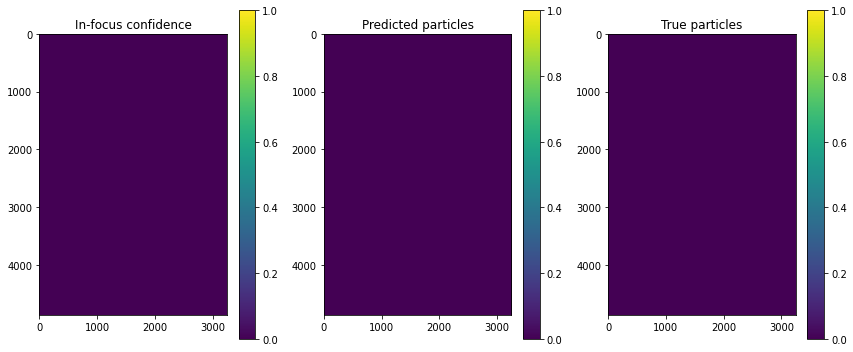

Plane: 318 at z: 0.059863 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.1905 holo_csi: 0.0151:  34%|███▍      | 343/1000 [1:29:55<3:09:02, 17.26s/it]            

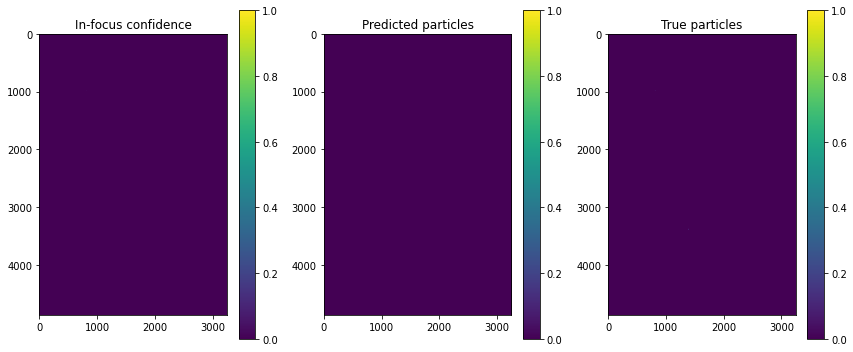

Plane: 319 at z: 0.060007 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0151:  34%|███▍      | 344/1000 [1:30:12<3:09:34, 17.34s/it]

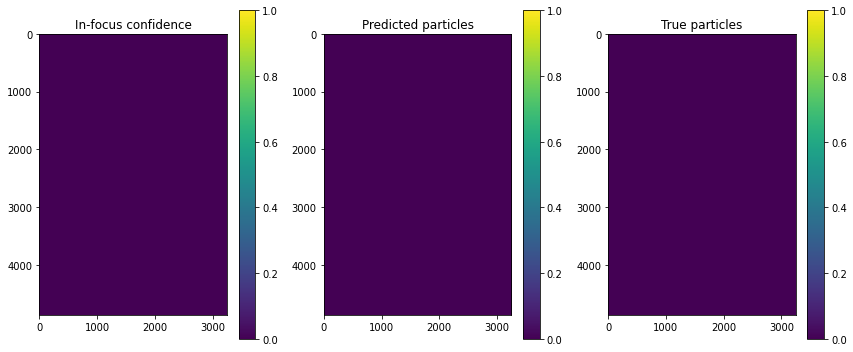

Plane: 320 at z: 0.060150999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0151:  34%|███▍      | 345/1000 [1:30:30<3:10:02, 17.41s/it]

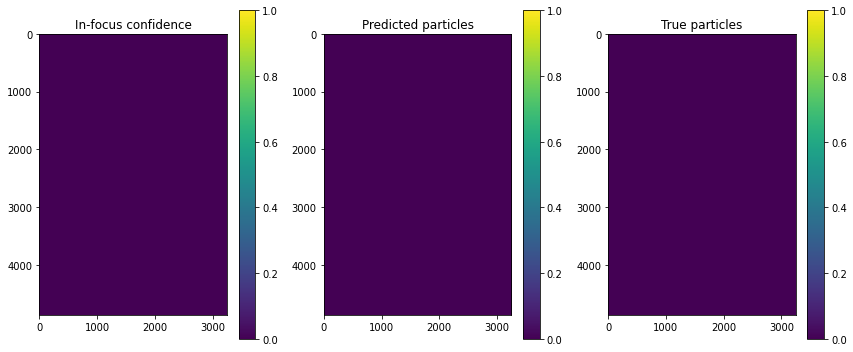

Plane: 321 at z: 0.060294999999999994 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0151:  35%|███▍      | 346/1000 [1:30:47<3:09:17, 17.37s/it]

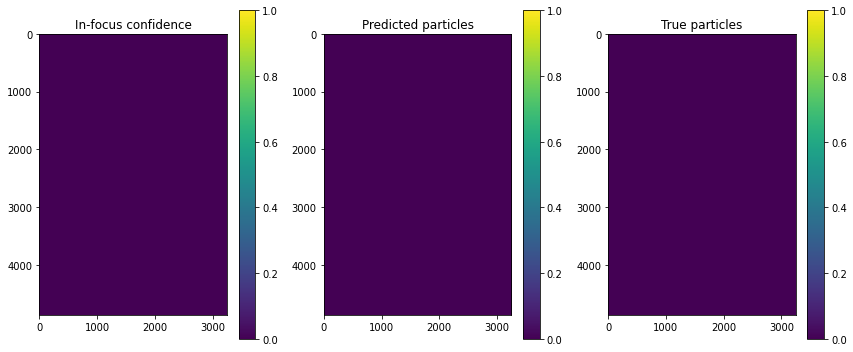

Plane: 322 at z: 0.060439 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0150:  35%|███▍      | 347/1000 [1:31:04<3:08:54, 17.36s/it]            

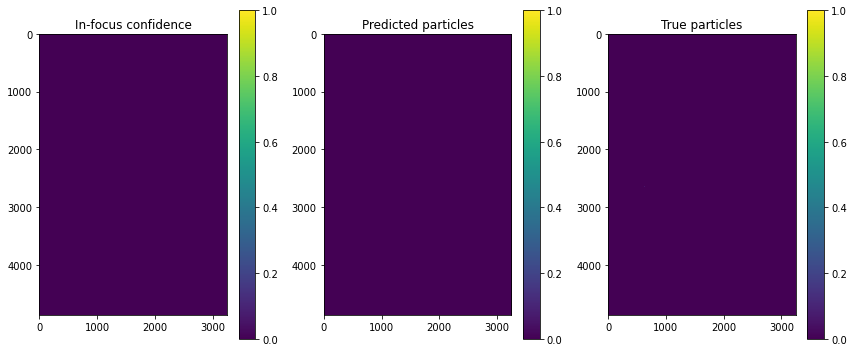

Plane: 323 at z: 0.060583 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0150:  35%|███▍      | 348/1000 [1:31:22<3:08:26, 17.34s/it]

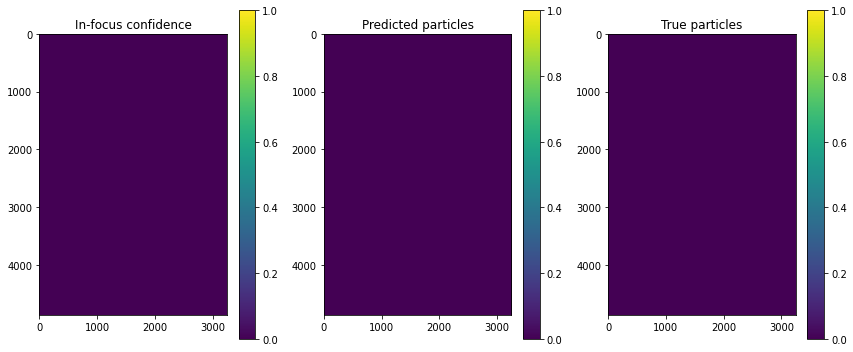

Plane: 324 at z: 0.060726999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0150:  35%|███▍      | 349/1000 [1:31:39<3:09:04, 17.43s/it]

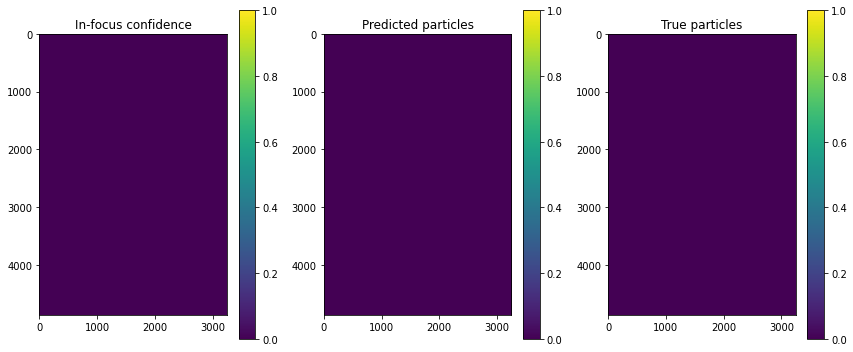

Plane: 325 at z: 0.060870999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0150:  35%|███▌      | 351/1000 [1:31:57<2:26:22, 13.53s/it]

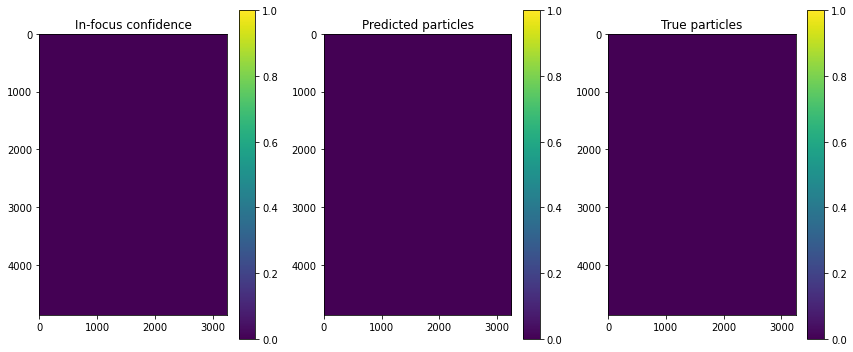

Plane: 326 at z: 0.061015 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0150:  35%|███▌      | 352/1000 [1:32:14<2:39:09, 14.74s/it]            

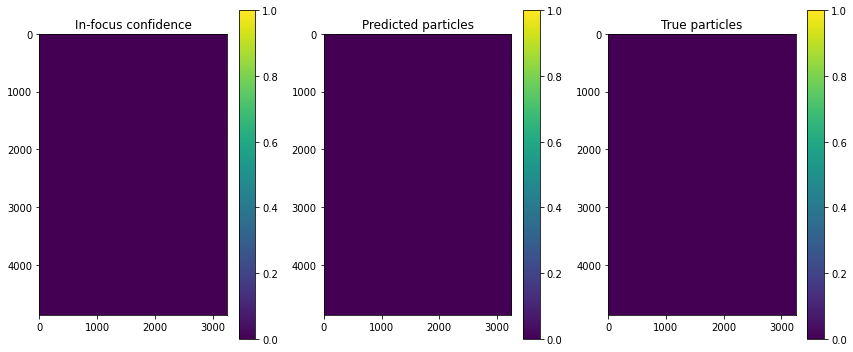

Plane: 327 at z: 0.061159 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0149:  35%|███▌      | 353/1000 [1:32:31<2:47:01, 15.49s/it]

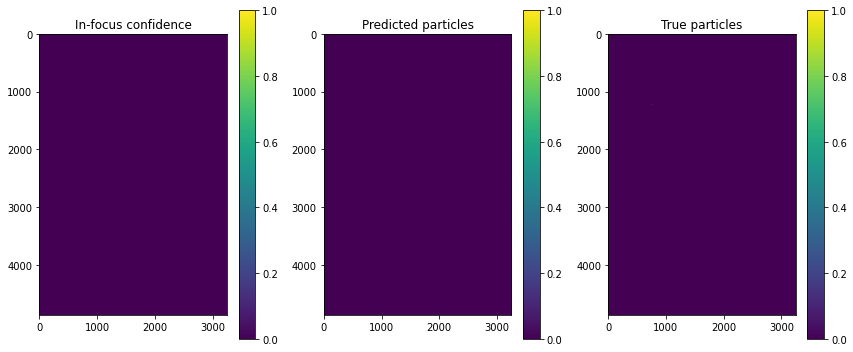

Plane: 328 at z: 0.061302999999999996 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0149:  35%|███▌      | 354/1000 [1:32:48<2:51:38, 15.94s/it]

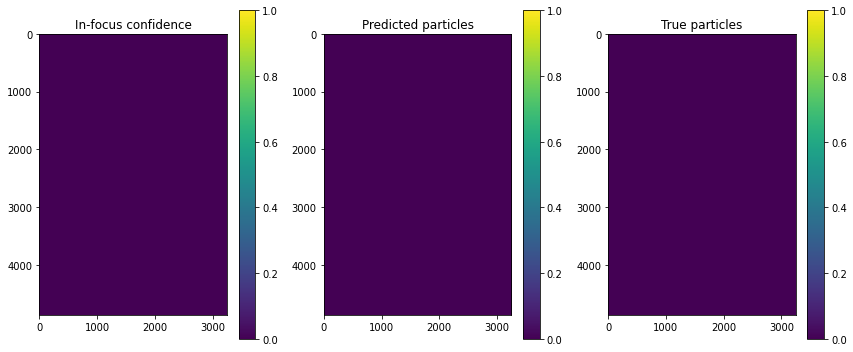

Plane: 329 at z: 0.061446999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0149:  36%|███▌      | 355/1000 [1:33:06<2:55:15, 16.30s/it]

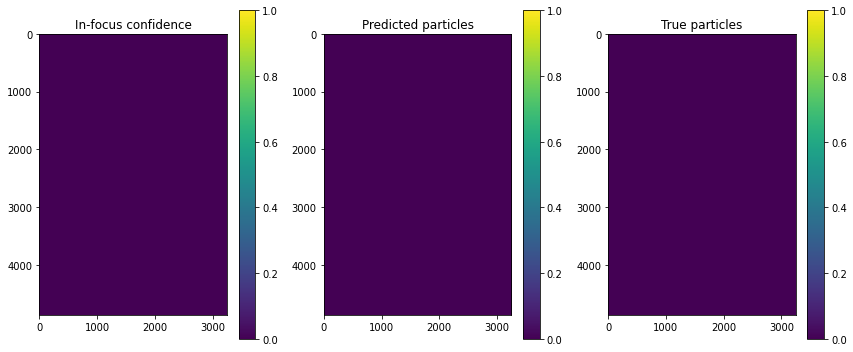

Plane: 330 at z: 0.061591 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0149:  36%|███▌      | 356/1000 [1:33:23<2:58:31, 16.63s/it]            

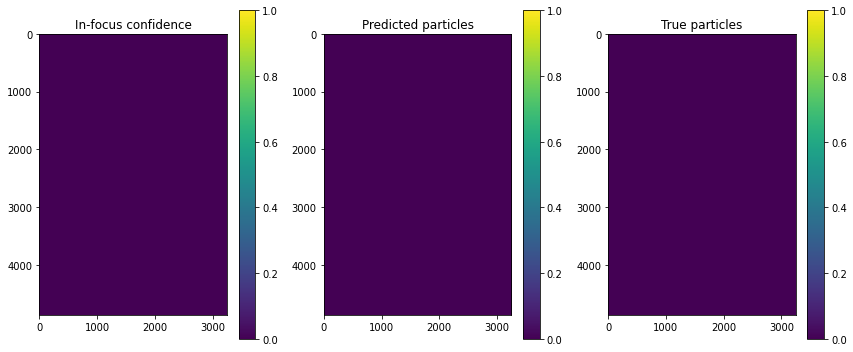

Plane: 331 at z: 0.061735 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0148:  36%|███▌      | 357/1000 [1:33:40<3:00:08, 16.81s/it]

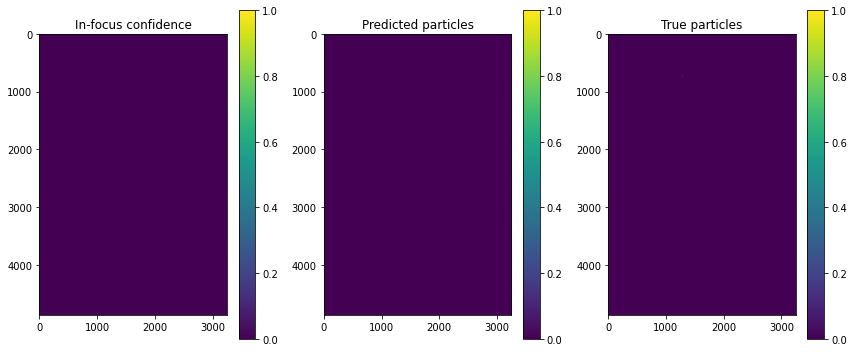

Plane: 332 at z: 0.061878999999999997 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0148:  36%|███▌      | 358/1000 [1:33:58<3:01:51, 17.00s/it]

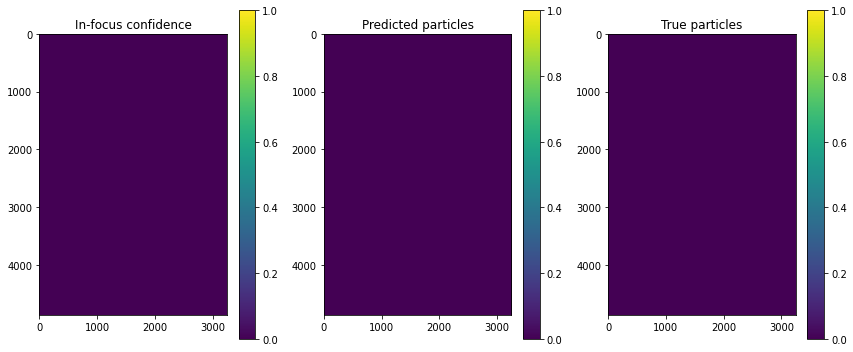

Plane: 333 at z: 0.062022999999999995 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0148:  36%|███▌      | 359/1000 [1:34:15<3:02:53, 17.12s/it]

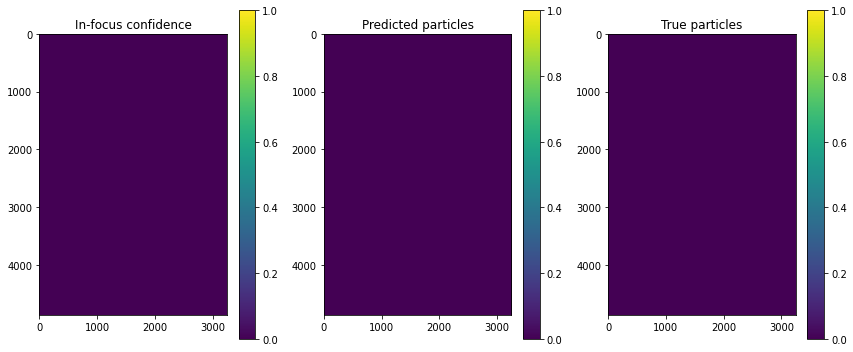

Plane: 334 at z: 0.062167 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0093 holo_csi: 0.0147:  36%|███▌      | 360/1000 [1:34:32<3:03:09, 17.17s/it]            

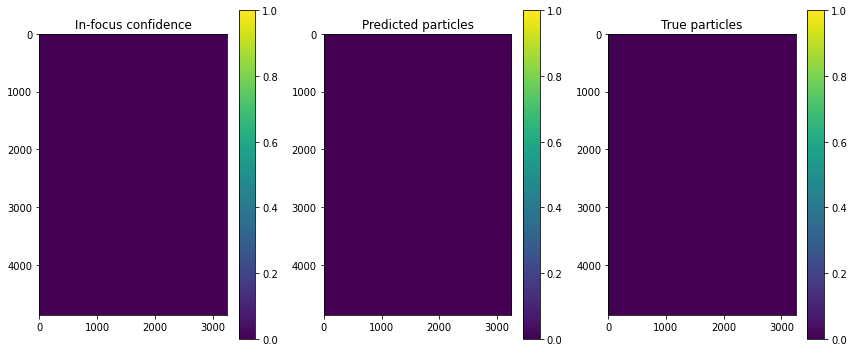

Plane: 335 at z: 0.062311 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0147:  36%|███▌      | 361/1000 [1:34:50<3:02:56, 17.18s/it]

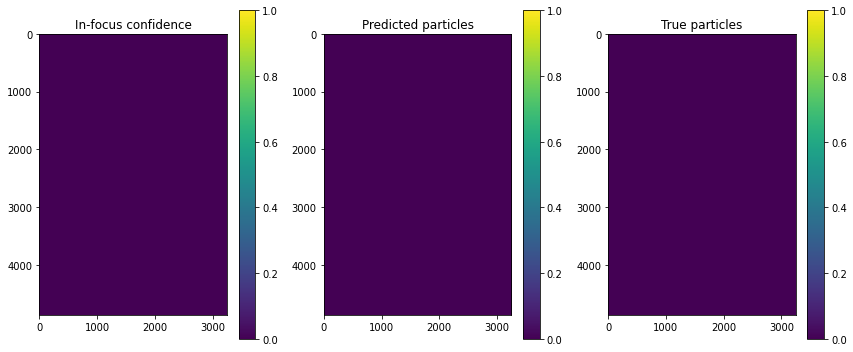

Plane: 336 at z: 0.062455 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0146:  36%|███▌      | 362/1000 [1:35:07<3:02:32, 17.17s/it]

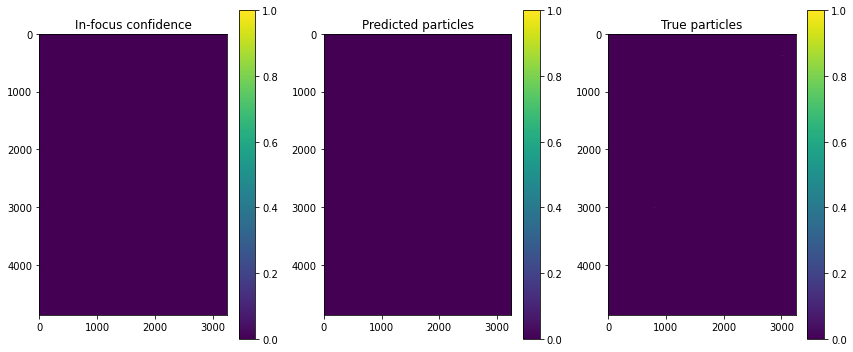

Plane: 337 at z: 0.0626 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0145:  36%|███▋      | 363/1000 [1:35:24<3:02:47, 17.22s/it]  

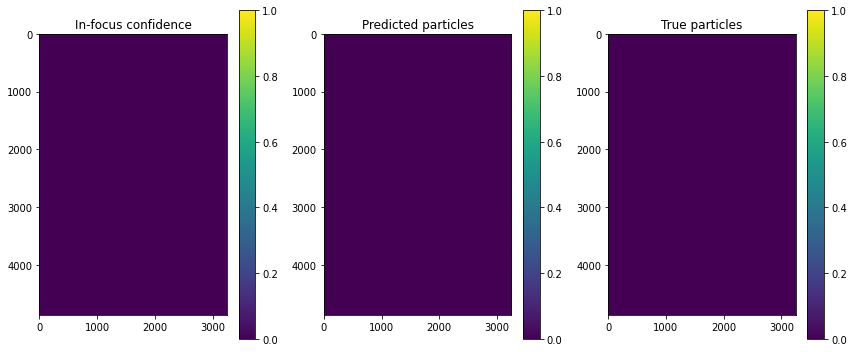

Plane: 338 at z: 0.062744 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0145:  36%|███▋      | 364/1000 [1:35:41<3:03:08, 17.28s/it]

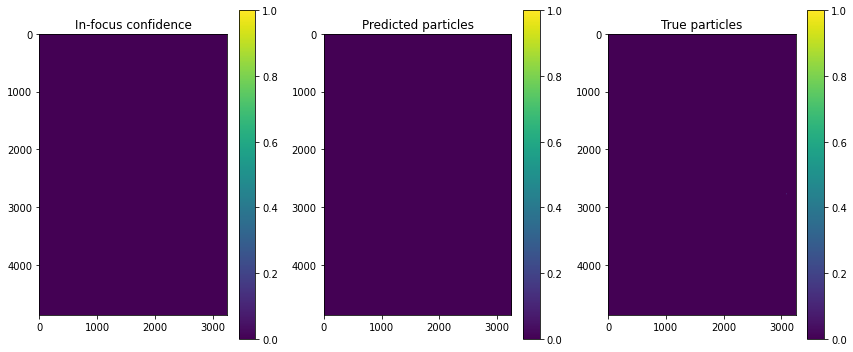

Plane: 339 at z: 0.062887 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0144:  36%|███▋      | 365/1000 [1:35:59<3:03:15, 17.32s/it]

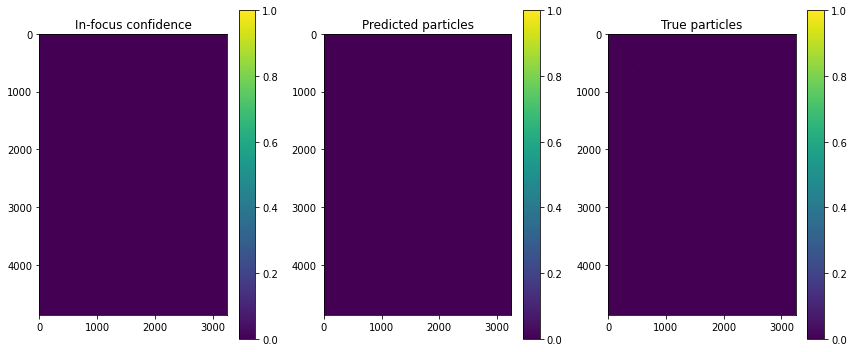

Plane: 340 at z: 0.063031 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0143:  37%|███▋      | 366/1000 [1:36:16<3:03:12, 17.34s/it]

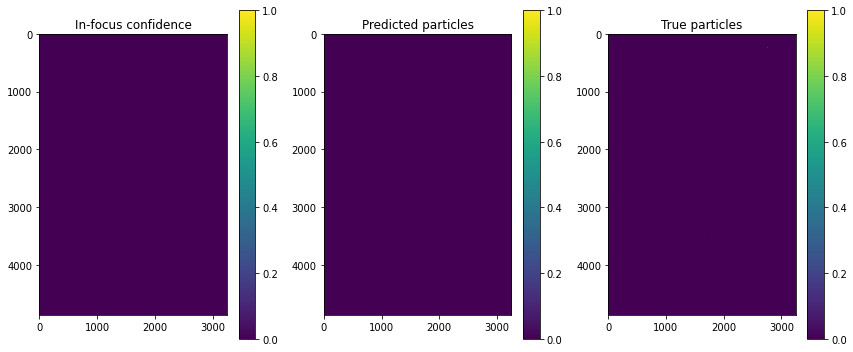

Plane: 341 at z: 0.063176 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0143:  37%|███▋      | 367/1000 [1:36:33<3:02:34, 17.31s/it]

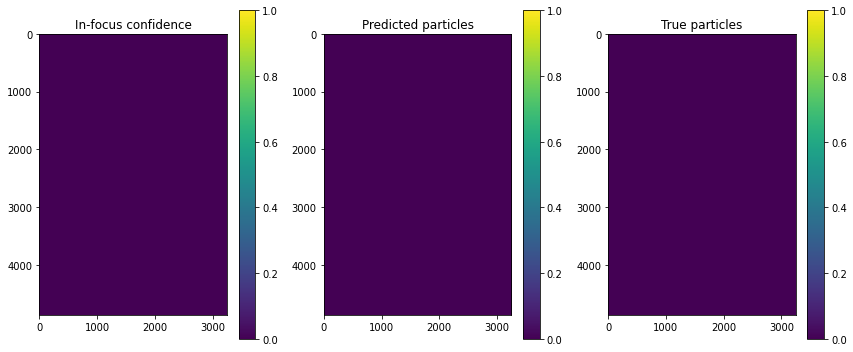

Plane: 342 at z: 0.06332 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0143:  37%|███▋      | 368/1000 [1:36:51<3:02:05, 17.29s/it] 

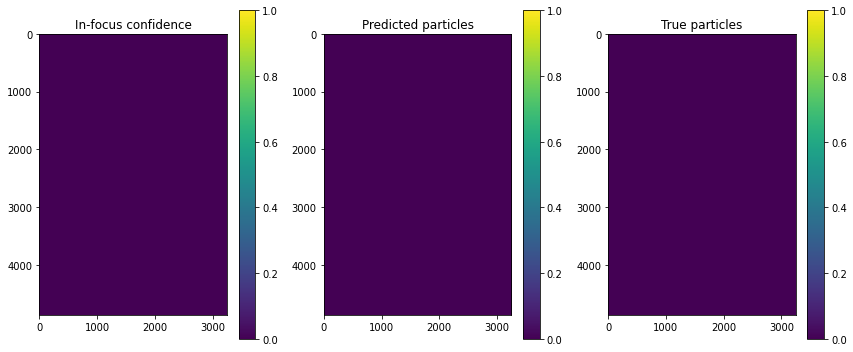

Plane: 343 at z: 0.06346299999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0142:  37%|███▋      | 369/1000 [1:37:08<3:02:16, 17.33s/it]

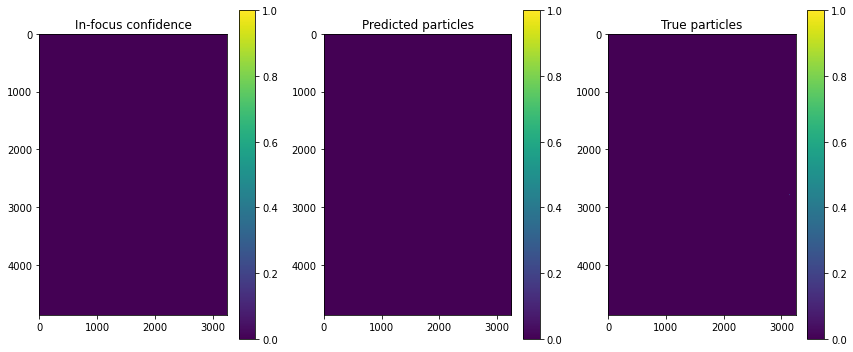

Plane: 344 at z: 0.063608 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0142:  37%|███▋      | 370/1000 [1:37:26<3:02:14, 17.36s/it]           

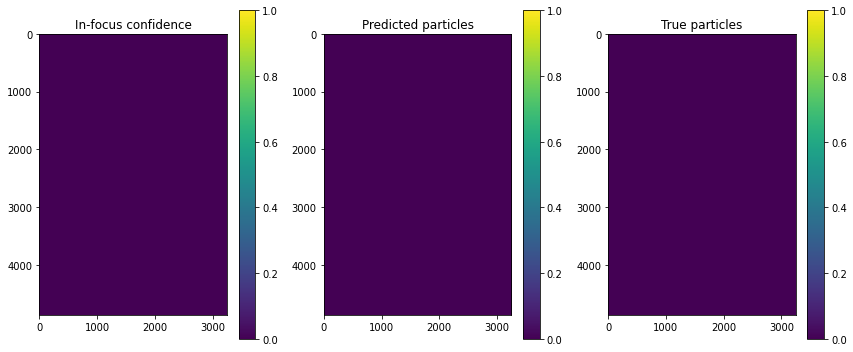

Plane: 345 at z: 0.063752 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  37%|███▋      | 371/1000 [1:37:43<3:02:45, 17.43s/it]

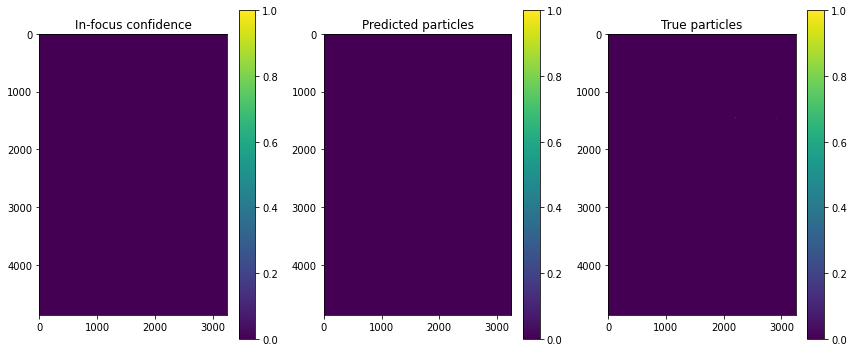

Plane: 346 at z: 0.063896 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  37%|███▋      | 372/1000 [1:38:01<3:02:24, 17.43s/it]

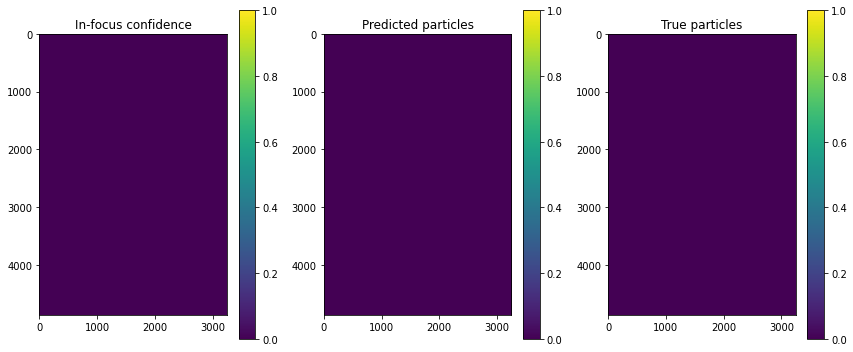

Plane: 347 at z: 0.064039 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  37%|███▋      | 373/1000 [1:38:18<3:00:42, 17.29s/it]

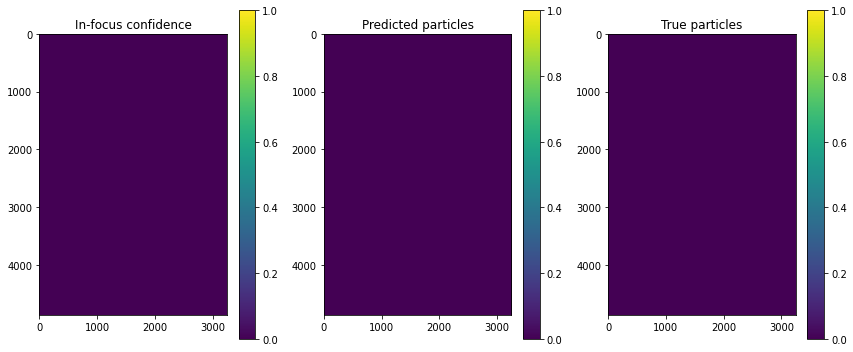

Plane: 348 at z: 0.064183 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  37%|███▋      | 374/1000 [1:38:35<2:59:42, 17.22s/it]

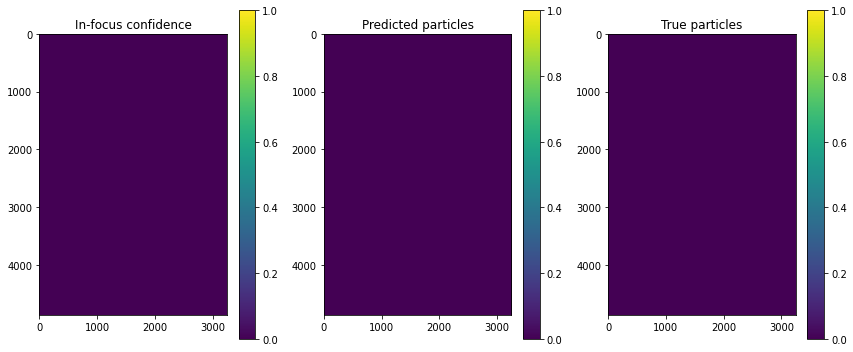

Plane: 349 at z: 0.064328 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  38%|███▊      | 375/1000 [1:38:52<2:59:03, 17.19s/it]

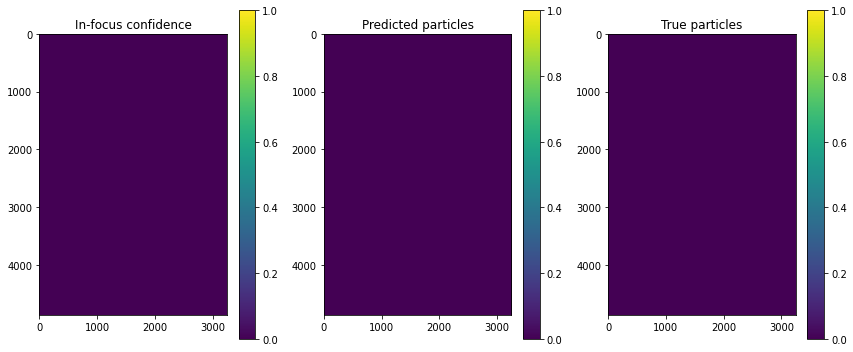

Plane: 350 at z: 0.064472 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  38%|███▊      | 376/1000 [1:39:09<2:58:17, 17.14s/it]

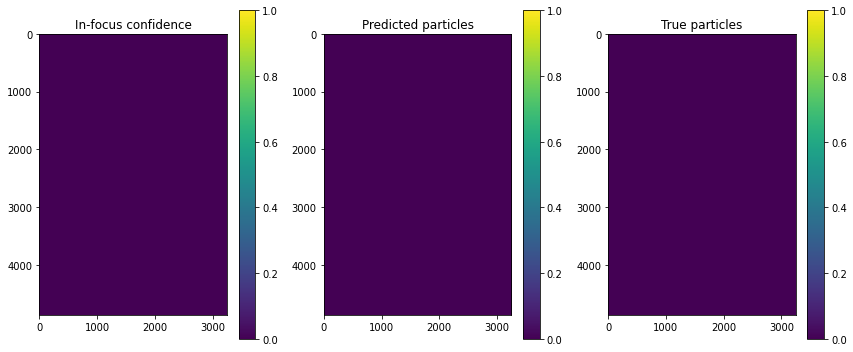

Plane: 351 at z: 0.06461499999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0139:  38%|███▊      | 378/1000 [1:39:26<2:19:24, 13.45s/it]

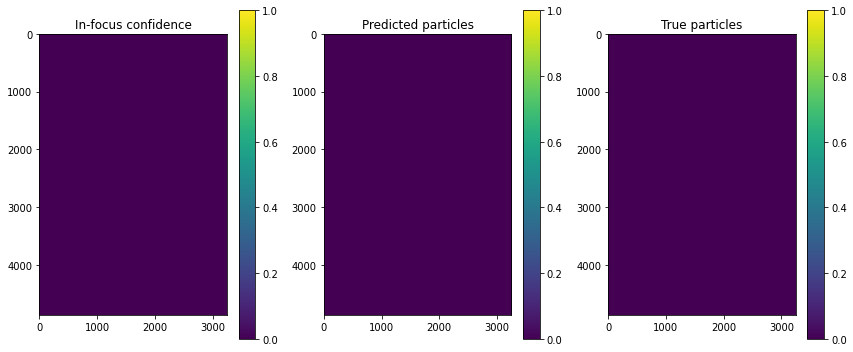

Plane: 352 at z: 0.064759 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0139:  38%|███▊      | 379/1000 [1:39:44<2:32:07, 14.70s/it]           

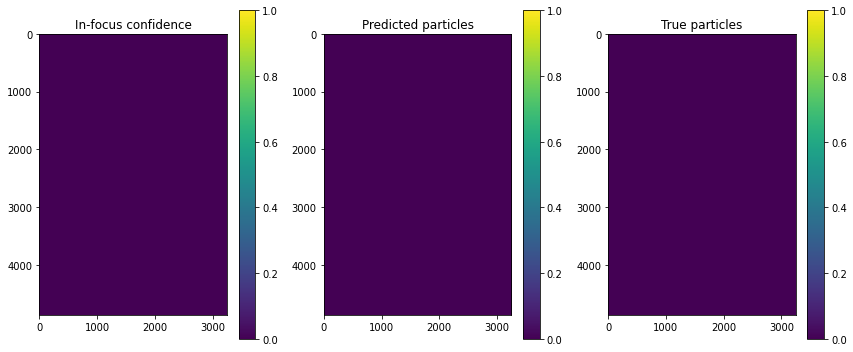

Plane: 353 at z: 0.064903 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0139:  38%|███▊      | 380/1000 [1:40:01<2:39:14, 15.41s/it]

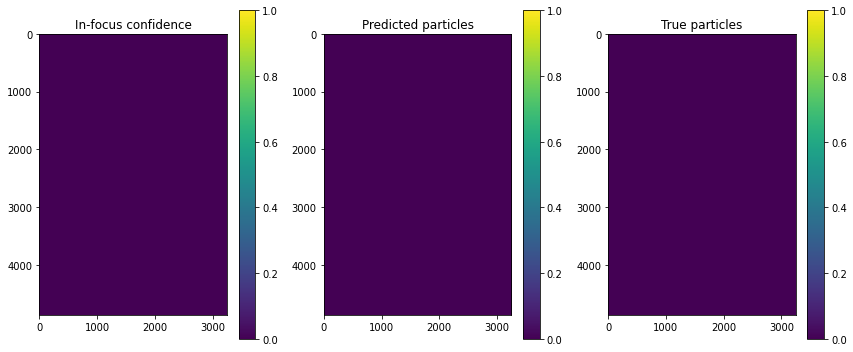

Plane: 354 at z: 0.065048 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0139:  38%|███▊      | 381/1000 [1:40:18<2:45:33, 16.05s/it]

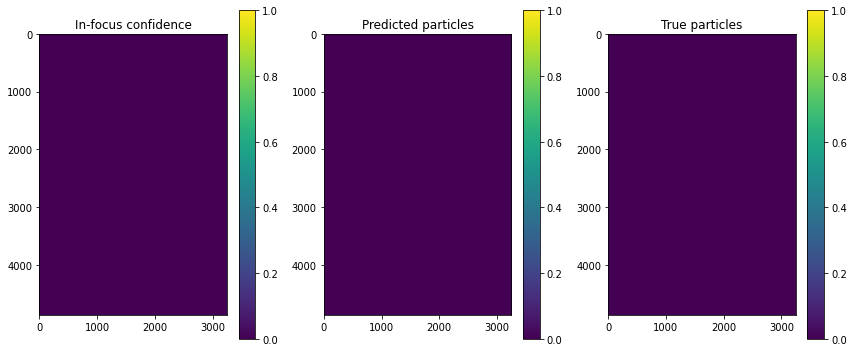

Plane: 355 at z: 0.065191 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0139:  38%|███▊      | 382/1000 [1:40:36<2:49:26, 16.45s/it]

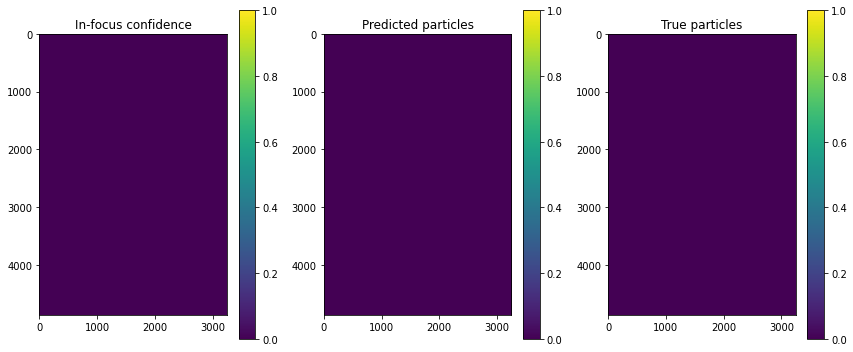

Plane: 356 at z: 0.06533499999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0139:  38%|███▊      | 383/1000 [1:40:53<2:52:12, 16.75s/it]

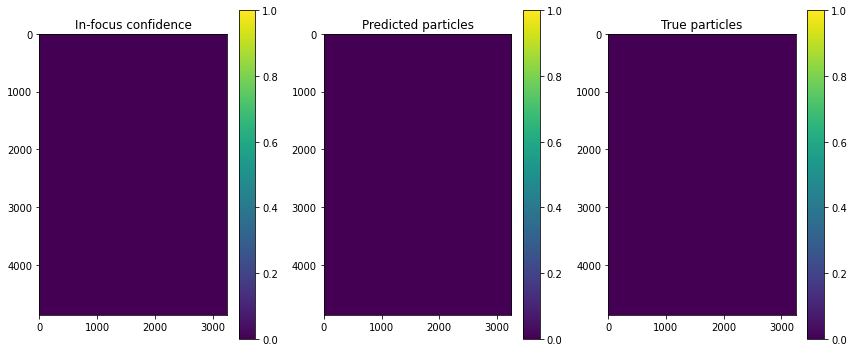

Plane: 357 at z: 0.06548 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0138:  38%|███▊      | 384/1000 [1:41:11<2:54:37, 17.01s/it]            

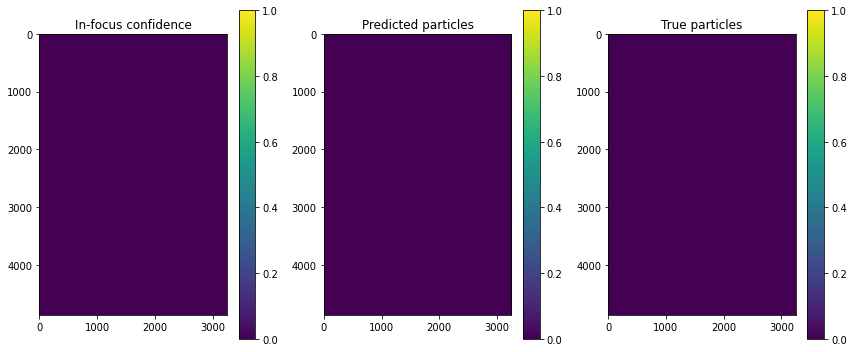

Plane: 358 at z: 0.065624 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0138:  38%|███▊      | 385/1000 [1:41:28<2:54:56, 17.07s/it]

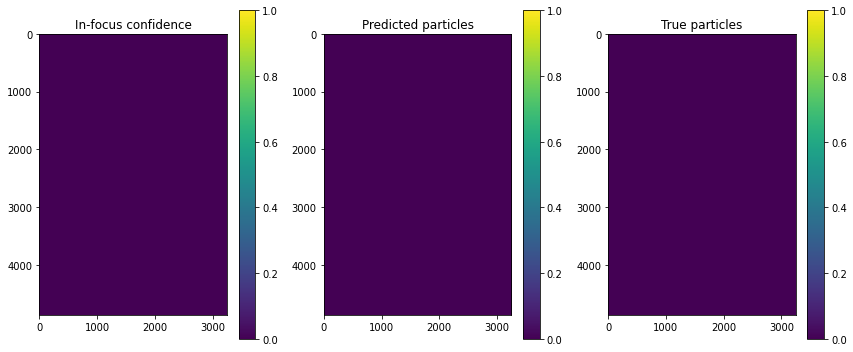

Plane: 359 at z: 0.065768 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0138:  39%|███▊      | 386/1000 [1:41:45<2:55:43, 17.17s/it]

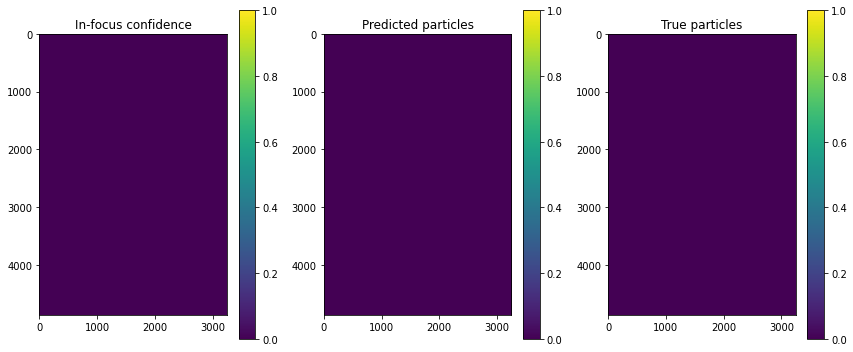

Plane: 360 at z: 0.065912 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0138:  39%|███▊      | 387/1000 [1:42:03<2:55:06, 17.14s/it]

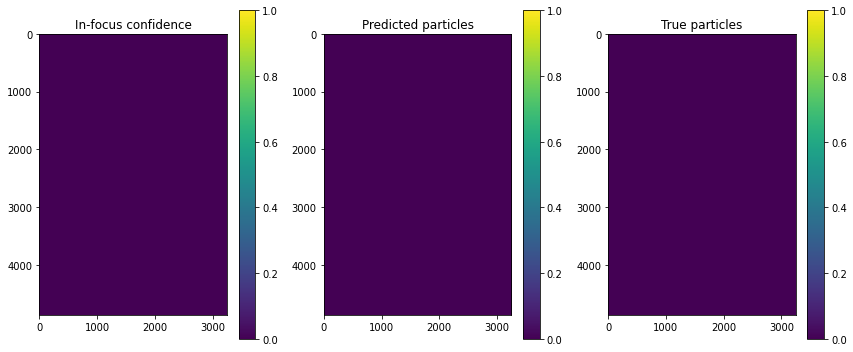

Plane: 361 at z: 0.066055 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0741 holo_csi: 0.0141:  39%|███▉      | 388/1000 [1:42:20<2:55:12, 17.18s/it]

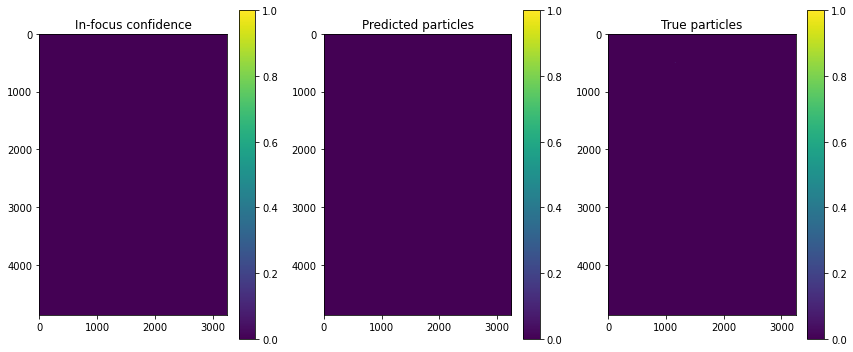

Plane: 362 at z: 0.0662 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0141:  39%|███▉      | 389/1000 [1:42:37<2:55:53, 17.27s/it]  

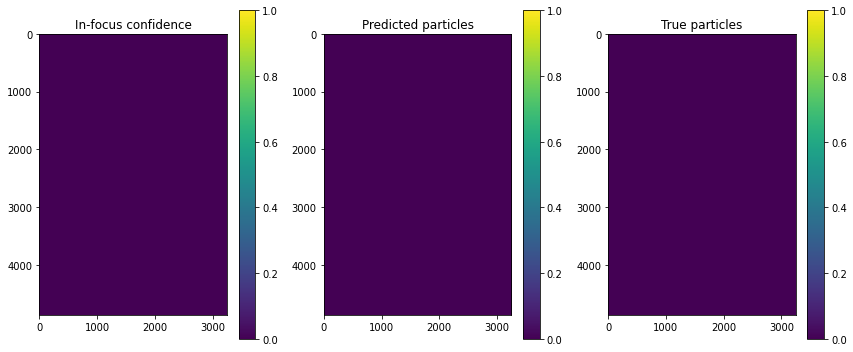

Plane: 363 at z: 0.066344 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  39%|███▉      | 390/1000 [1:42:55<2:56:13, 17.33s/it]

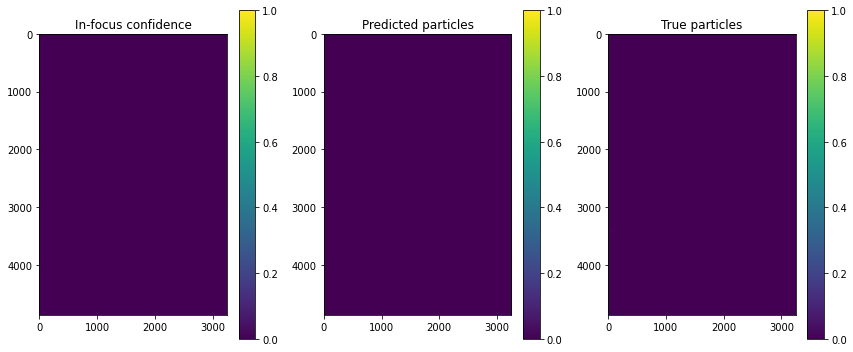

Plane: 364 at z: 0.06648799999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0140:  39%|███▉      | 391/1000 [1:43:12<2:56:28, 17.39s/it]

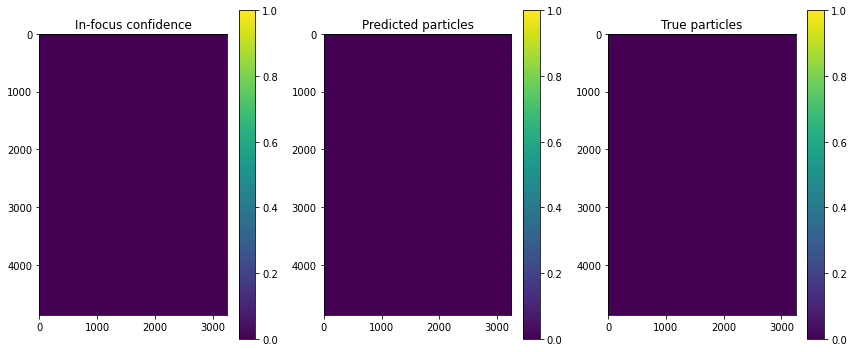

Plane: 365 at z: 0.066632 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0138:  39%|███▉      | 392/1000 [1:43:30<2:57:21, 17.50s/it]           

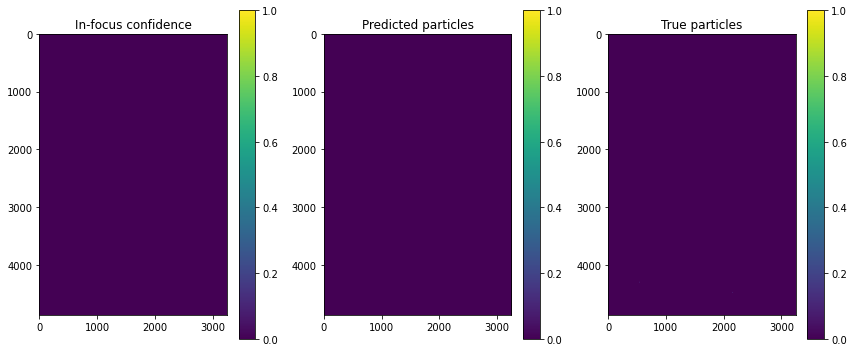

Plane: 366 at z: 0.066776 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0138:  39%|███▉      | 393/1000 [1:43:47<2:56:19, 17.43s/it]

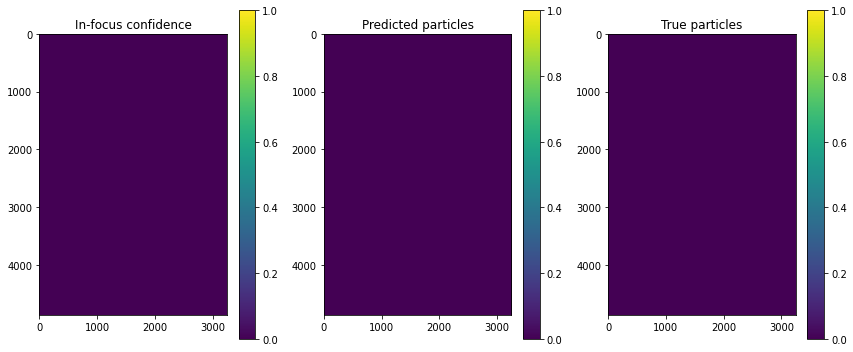

Plane: 367 at z: 0.06692 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0138:  39%|███▉      | 394/1000 [1:44:04<2:55:12, 17.35s/it] 

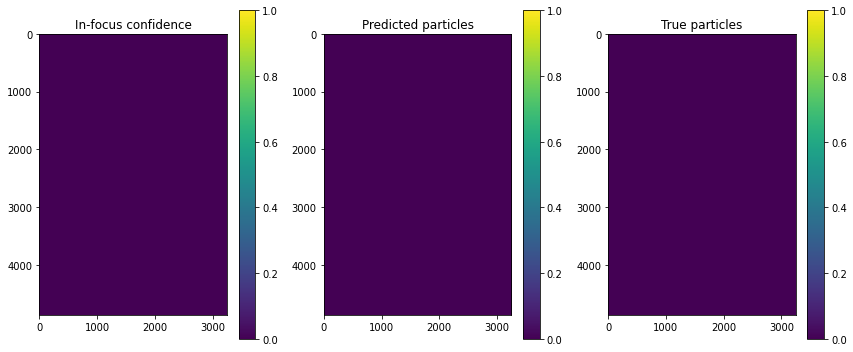

Plane: 368 at z: 0.067064 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0138:  40%|███▉      | 395/1000 [1:44:22<2:55:24, 17.40s/it]

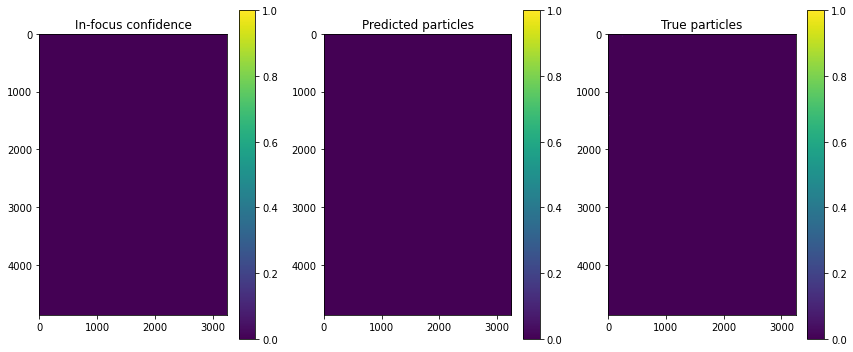

Plane: 369 at z: 0.067207 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0138:  40%|███▉      | 396/1000 [1:44:39<2:54:02, 17.29s/it]

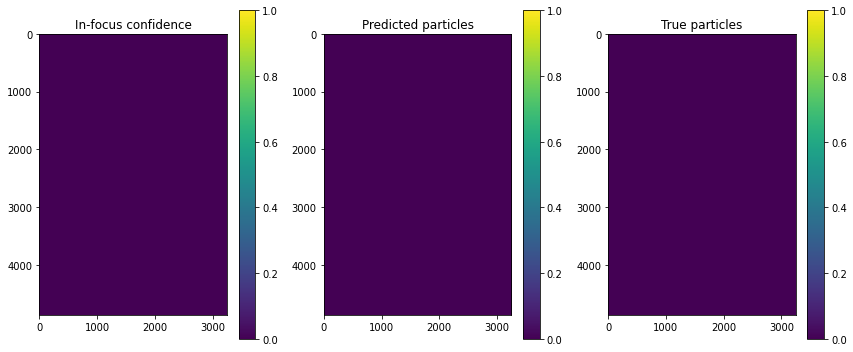

Plane: 370 at z: 0.067352 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0136:  40%|███▉      | 397/1000 [1:44:57<2:54:31, 17.37s/it]

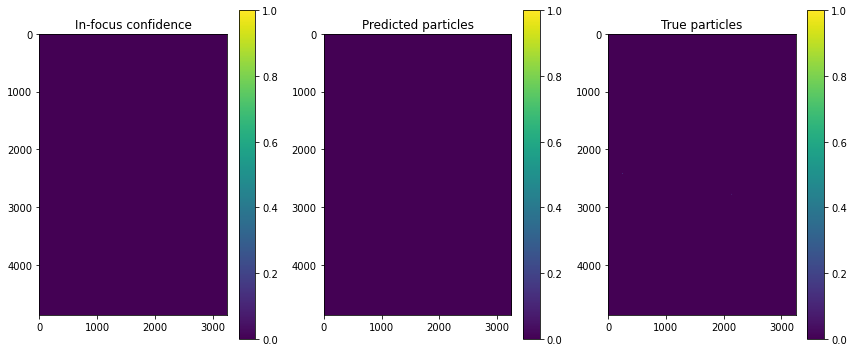

Plane: 371 at z: 0.067496 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0136:  40%|███▉      | 398/1000 [1:45:14<2:53:58, 17.34s/it]

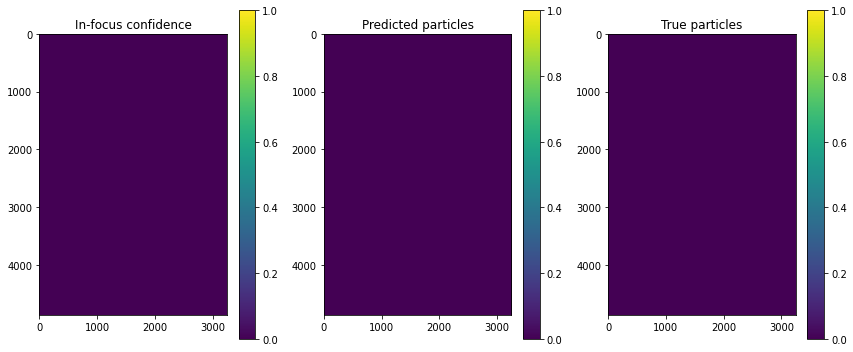

Plane: 372 at z: 0.06763999999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0136:  40%|███▉      | 399/1000 [1:45:31<2:53:35, 17.33s/it]

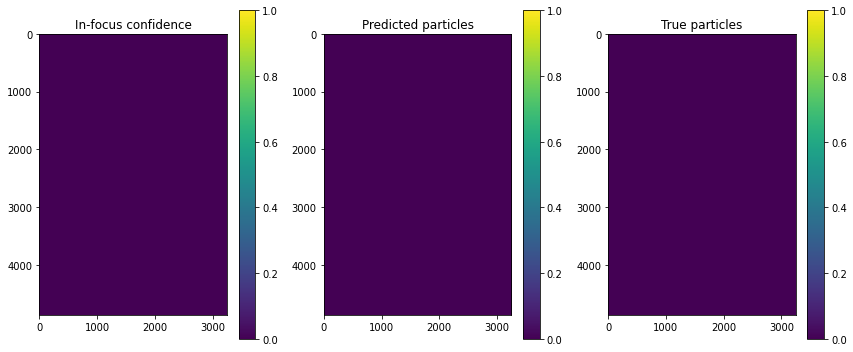

Plane: 373 at z: 0.067784 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0136:  40%|████      | 400/1000 [1:45:48<2:52:57, 17.30s/it]           

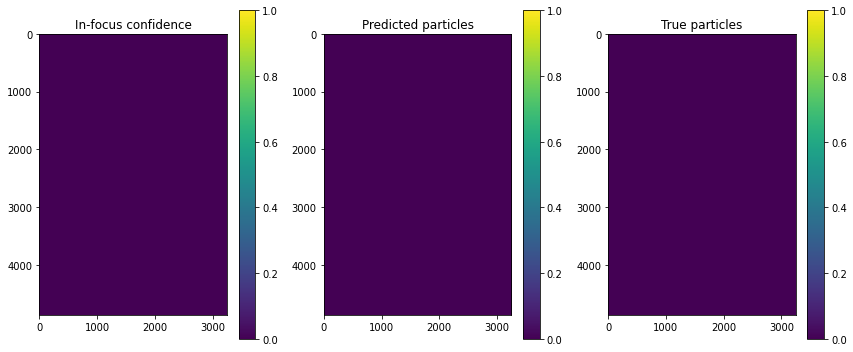

Plane: 374 at z: 0.067928 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0136:  40%|████      | 401/1000 [1:46:06<2:52:42, 17.30s/it]

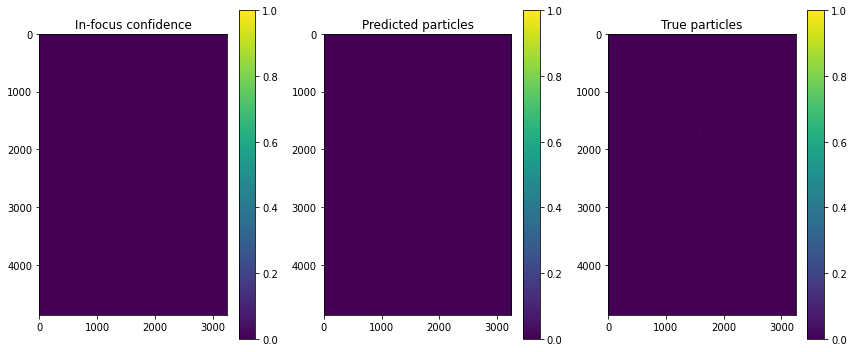

Plane: 375 at z: 0.068072 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.5682 holo_csi: 0.0175:  40%|████      | 402/1000 [1:46:23<2:52:49, 17.34s/it]

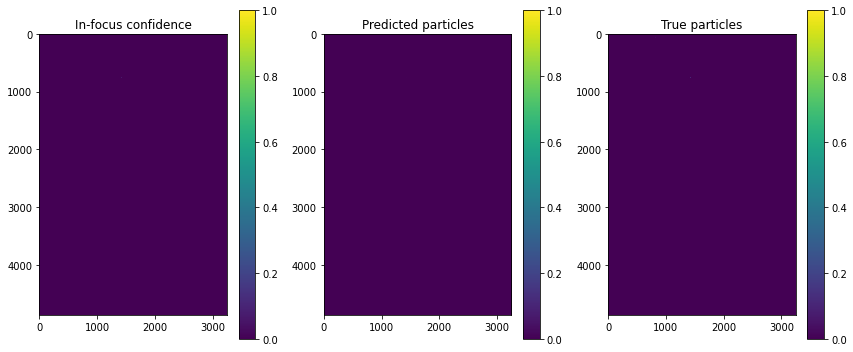

Plane: 376 at z: 0.068216 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0174:  40%|████      | 403/1000 [1:46:41<2:53:13, 17.41s/it]

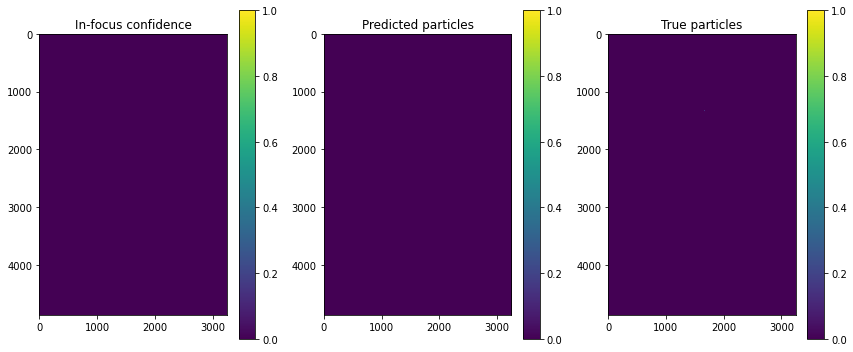

Plane: 377 at z: 0.06835999999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0174:  40%|████      | 404/1000 [1:46:58<2:52:35, 17.38s/it]

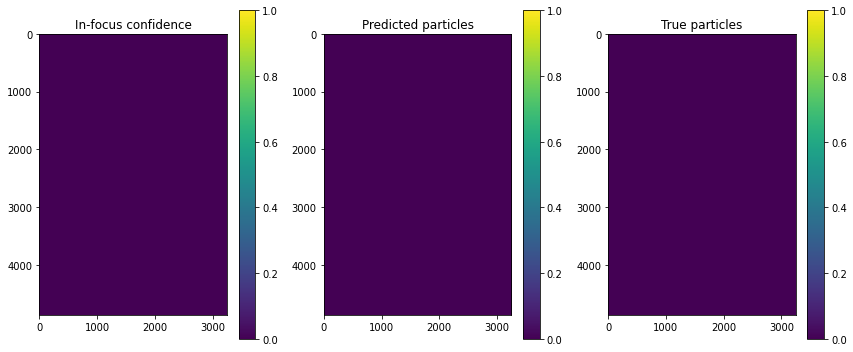

Plane: 378 at z: 0.068504 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0173:  41%|████      | 406/1000 [1:47:16<2:14:47, 13.62s/it]           

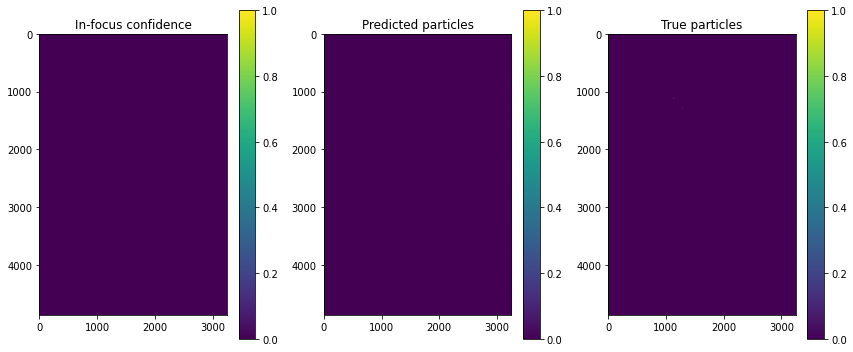

Plane: 379 at z: 0.068648 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0173:  41%|████      | 407/1000 [1:47:33<2:25:01, 14.67s/it]

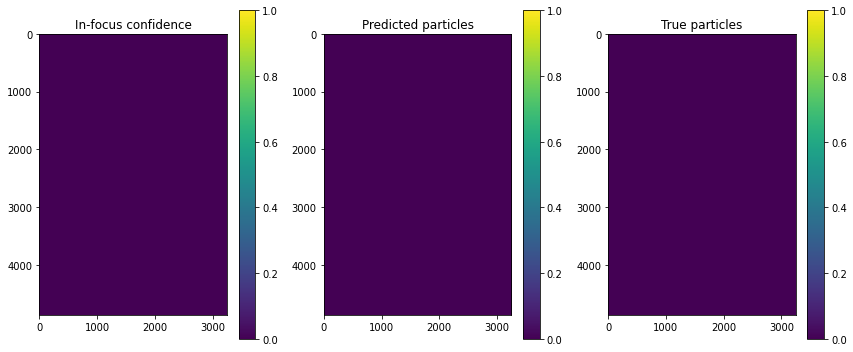

Plane: 380 at z: 0.06879199999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0172:  41%|████      | 408/1000 [1:47:50<2:32:36, 15.47s/it]

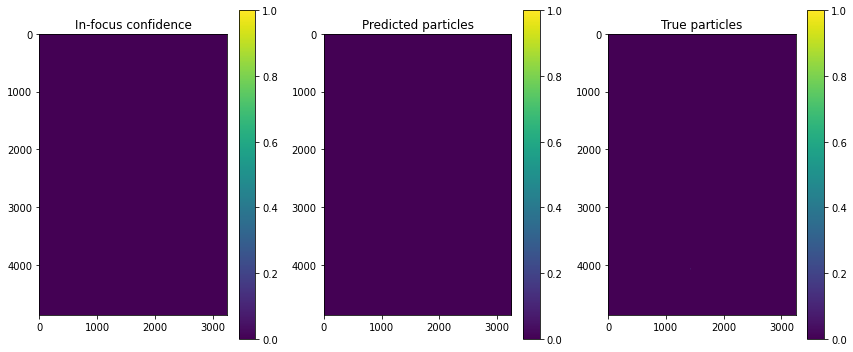

Plane: 381 at z: 0.068936 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0172:  41%|████      | 409/1000 [1:48:07<2:37:43, 16.01s/it]           

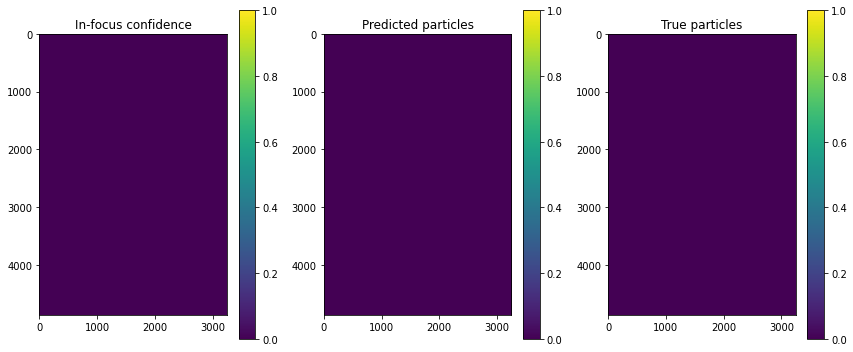

Plane: 382 at z: 0.06908 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0171:  41%|████      | 410/1000 [1:48:25<2:41:57, 16.47s/it] 

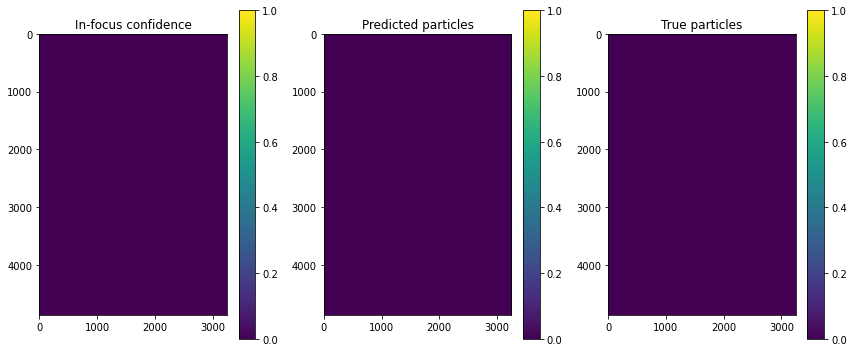

Plane: 383 at z: 0.069224 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0171:  41%|████      | 411/1000 [1:48:42<2:44:01, 16.71s/it]

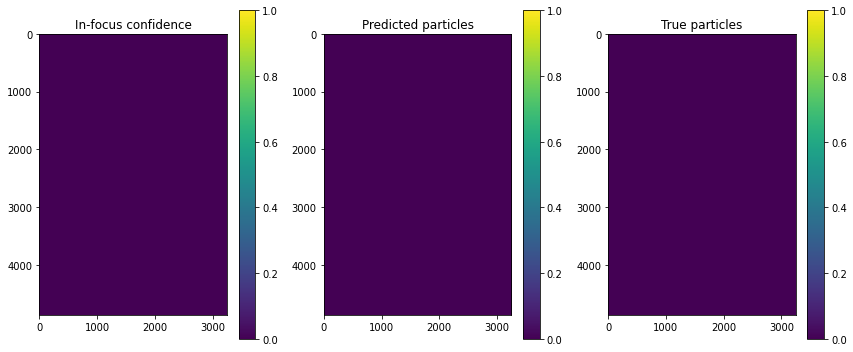

Plane: 384 at z: 0.069368 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0170:  41%|████      | 412/1000 [1:49:00<2:46:11, 16.96s/it]

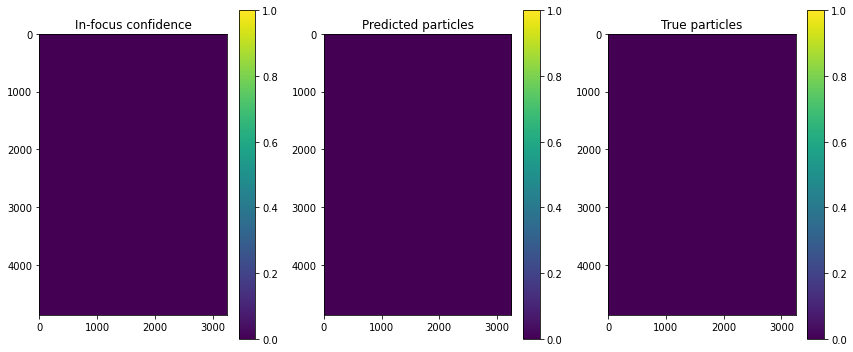

Plane: 385 at z: 0.06951199999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.1509 holo_csi: 0.0181:  41%|████▏     | 413/1000 [1:49:17<2:47:26, 17.11s/it]

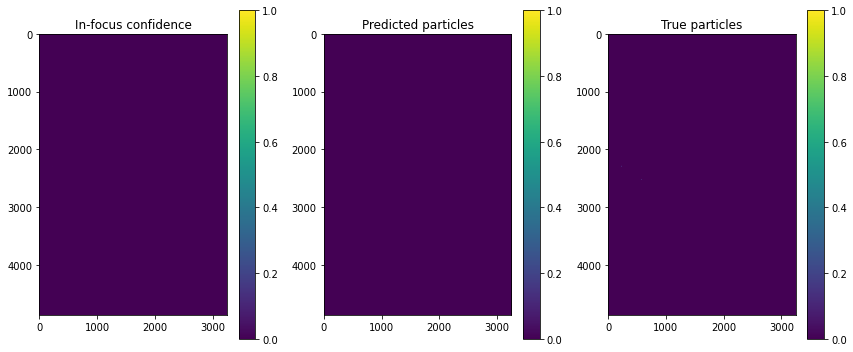

Plane: 386 at z: 0.069656 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0181:  41%|████▏     | 414/1000 [1:49:34<2:47:25, 17.14s/it]           

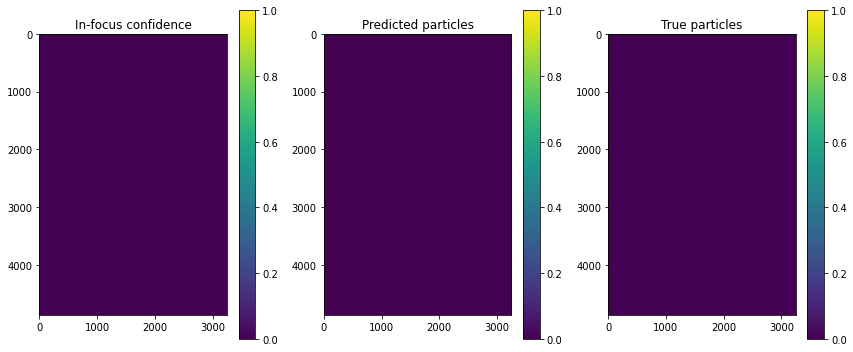

Plane: 387 at z: 0.0698 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0181:  42%|████▏     | 415/1000 [1:49:52<2:47:08, 17.14s/it]  

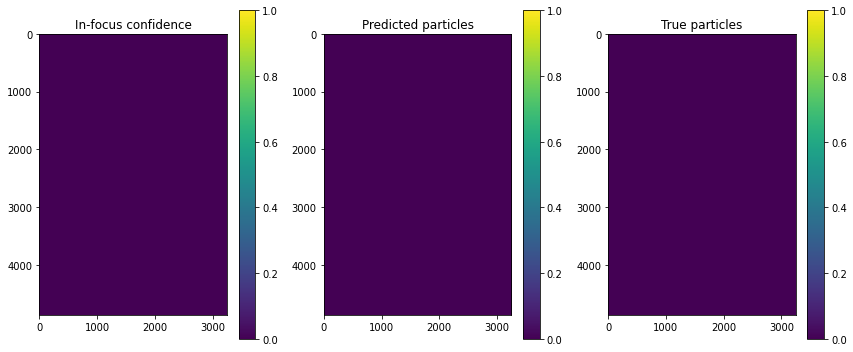

Plane: 388 at z: 0.06994399999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0180:  42%|████▏     | 416/1000 [1:50:09<2:47:12, 17.18s/it]

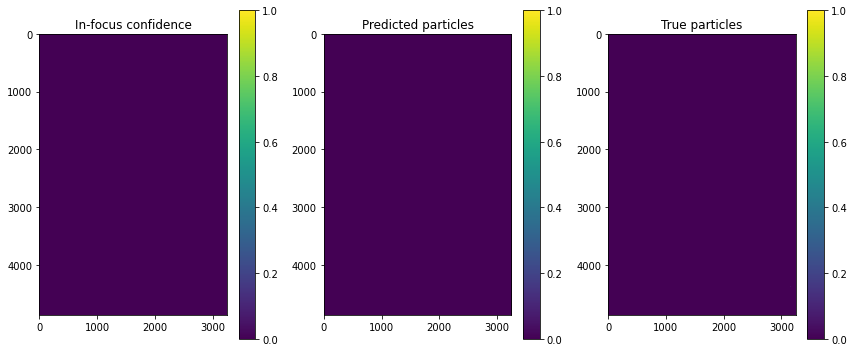

Plane: 389 at z: 0.070088 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0180:  42%|████▏     | 417/1000 [1:50:26<2:47:31, 17.24s/it]           

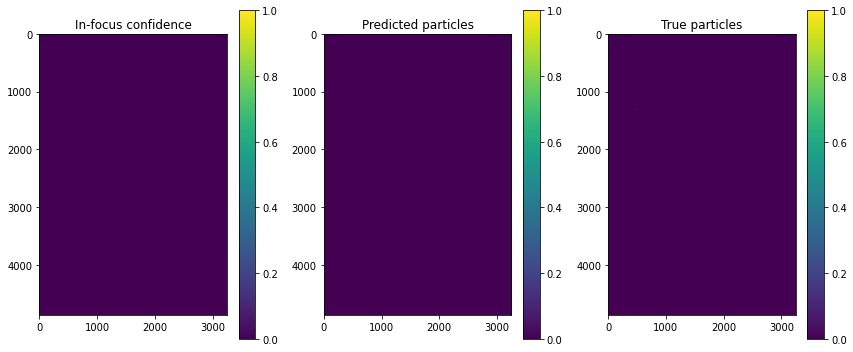

Plane: 390 at z: 0.070231 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0180:  42%|████▏     | 418/1000 [1:50:44<2:47:30, 17.27s/it]

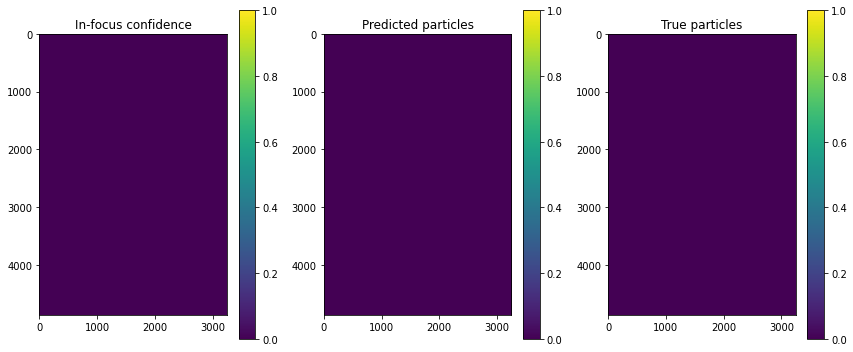

Plane: 391 at z: 0.070376 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0180:  42%|████▏     | 419/1000 [1:51:01<2:47:34, 17.31s/it]

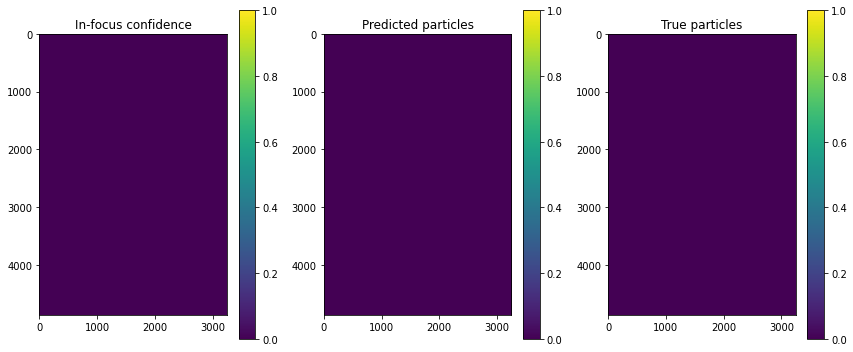

Plane: 392 at z: 0.07052 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0180:  42%|████▏     | 420/1000 [1:51:18<2:46:20, 17.21s/it] 

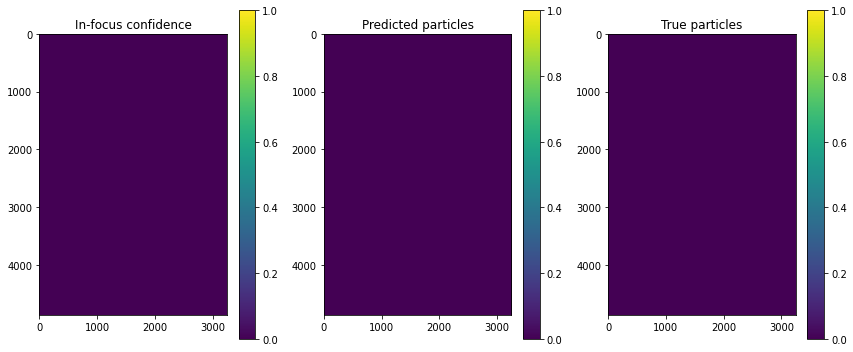

Plane: 393 at z: 0.07066399999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0178:  42%|████▏     | 421/1000 [1:51:35<2:46:13, 17.22s/it]

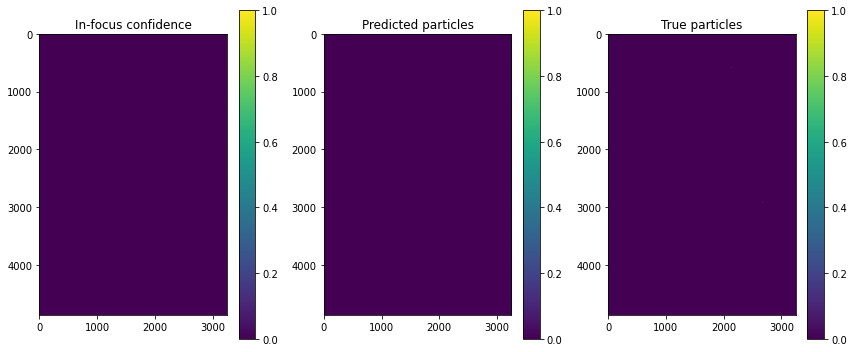

Plane: 394 at z: 0.070808 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0178:  42%|████▏     | 422/1000 [1:51:52<2:45:35, 17.19s/it]           

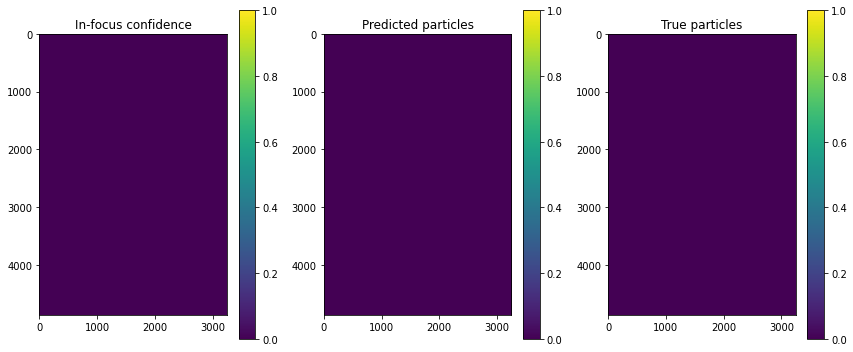

Plane: 395 at z: 0.070952 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0178:  42%|████▏     | 423/1000 [1:52:10<2:45:29, 17.21s/it]

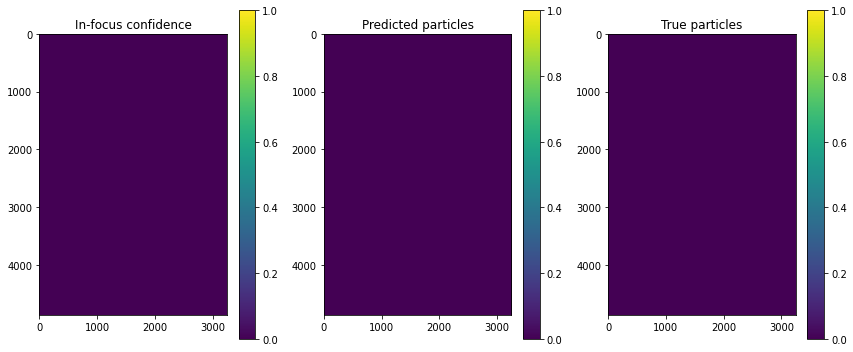

Plane: 396 at z: 0.07109599999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0177:  42%|████▏     | 424/1000 [1:52:27<2:46:02, 17.30s/it]

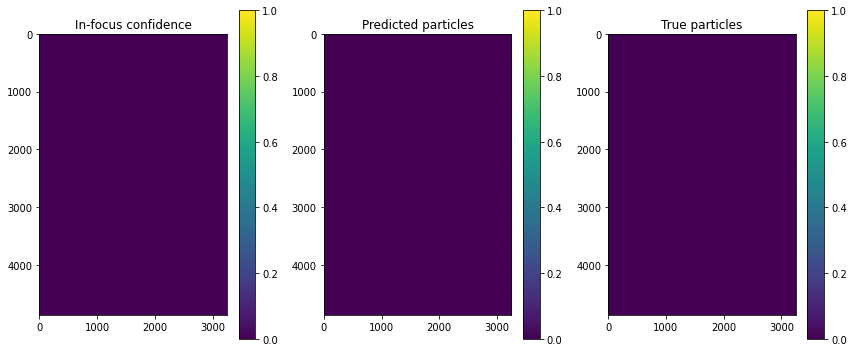

Plane: 397 at z: 0.07124 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0176:  42%|████▎     | 425/1000 [1:52:45<2:46:01, 17.32s/it]            

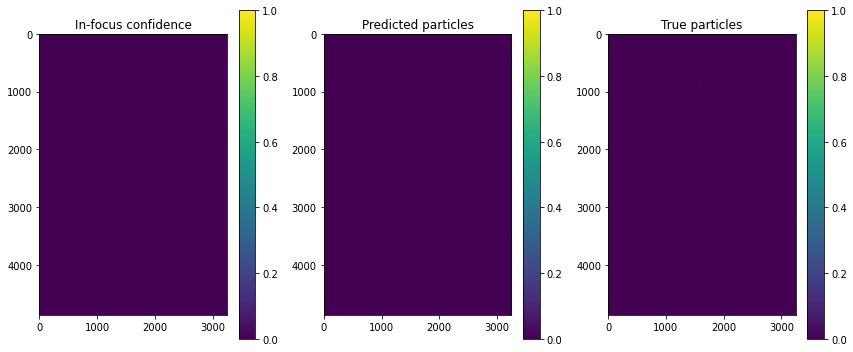

Plane: 398 at z: 0.071383 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0176:  43%|████▎     | 426/1000 [1:53:01<2:44:13, 17.17s/it]

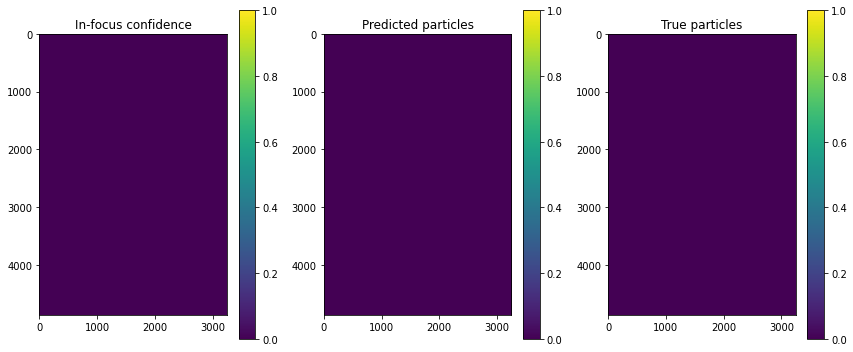

Plane: 399 at z: 0.071528 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0176:  43%|████▎     | 427/1000 [1:53:18<2:41:12, 16.88s/it]

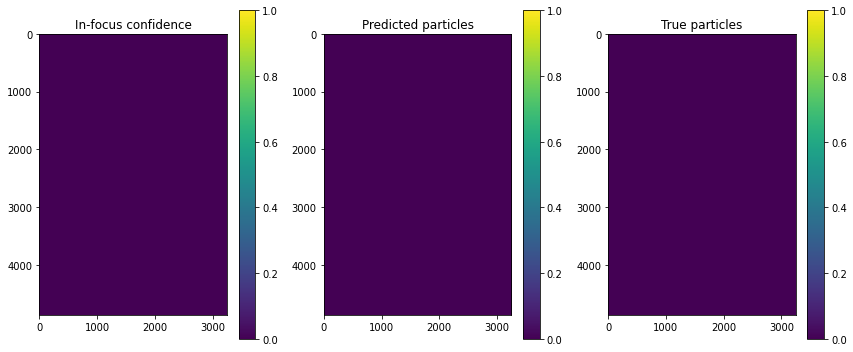

Plane: 400 at z: 0.071672 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0176:  43%|████▎     | 428/1000 [1:53:34<2:39:20, 16.71s/it]

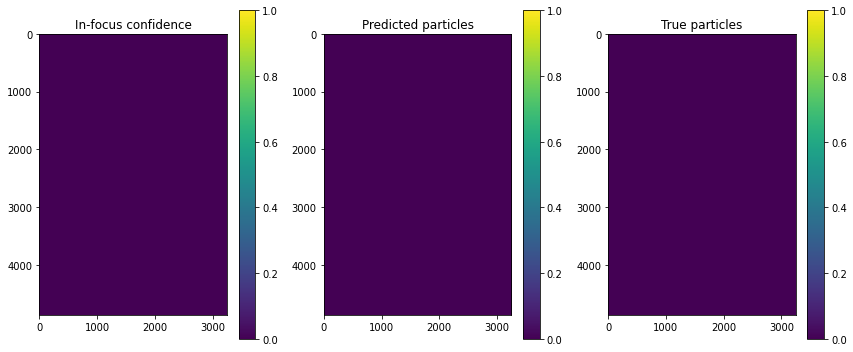

Plane: 401 at z: 0.07181599999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0176:  43%|████▎     | 429/1000 [1:53:50<2:38:17, 16.63s/it]

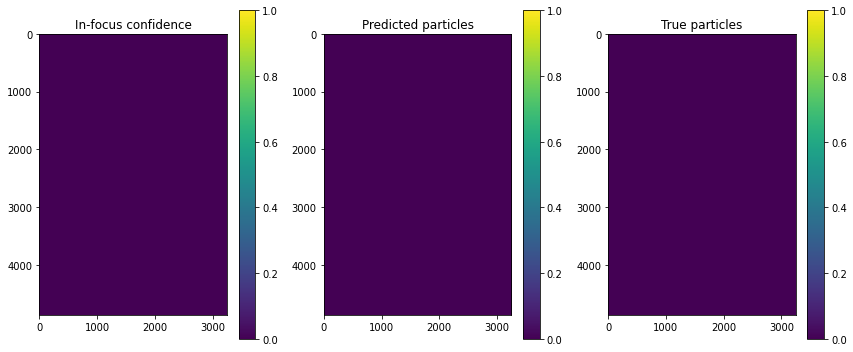

Plane: 402 at z: 0.07196 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0175:  43%|████▎     | 430/1000 [1:54:07<2:38:01, 16.63s/it]            

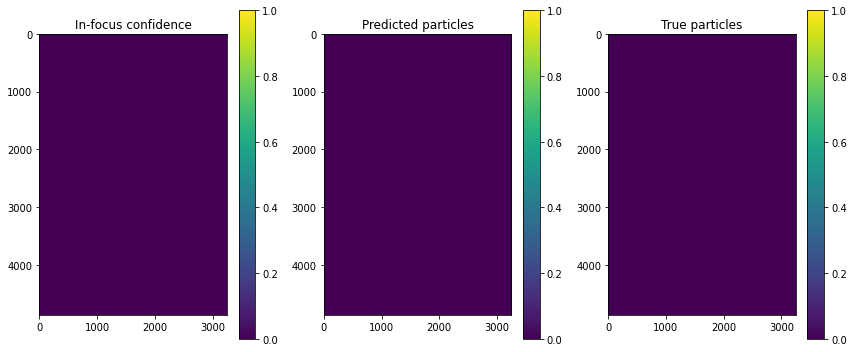

Plane: 403 at z: 0.072104 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0175:  43%|████▎     | 431/1000 [1:54:24<2:38:16, 16.69s/it]

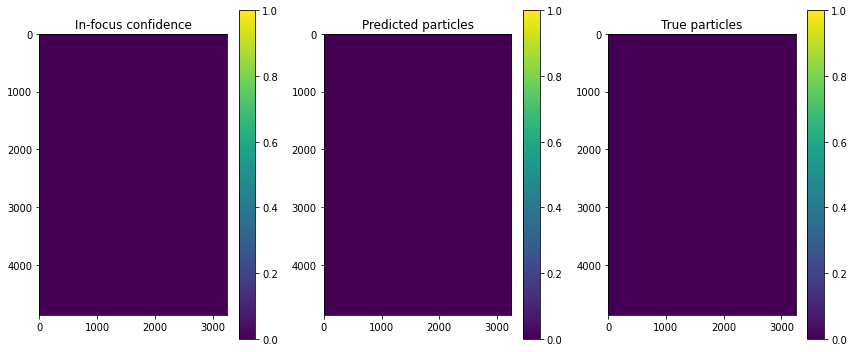

Plane: 404 at z: 0.07224799999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0175:  43%|████▎     | 432/1000 [1:54:40<2:37:59, 16.69s/it]

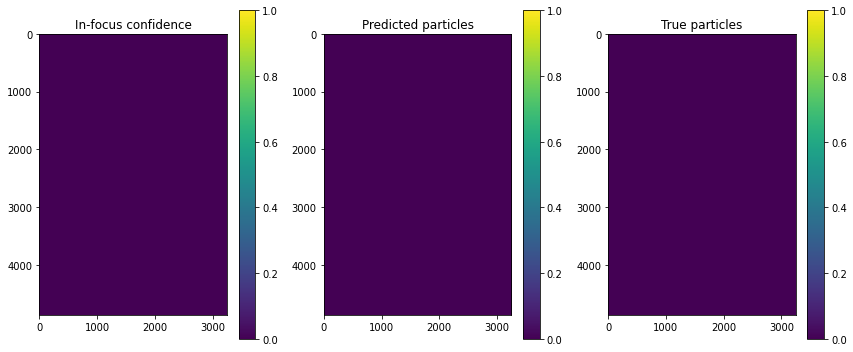

Plane: 405 at z: 0.072392 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0175:  43%|████▎     | 433/1000 [1:54:57<2:36:47, 16.59s/it]           

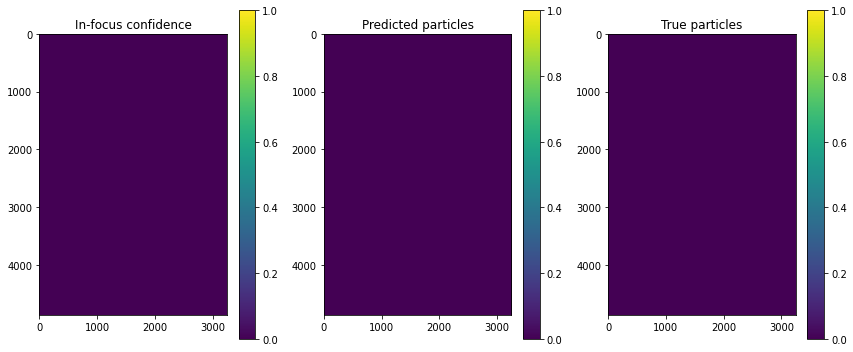

Plane: 406 at z: 0.072535 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0174:  44%|████▎     | 435/1000 [1:55:13<2:01:22, 12.89s/it]

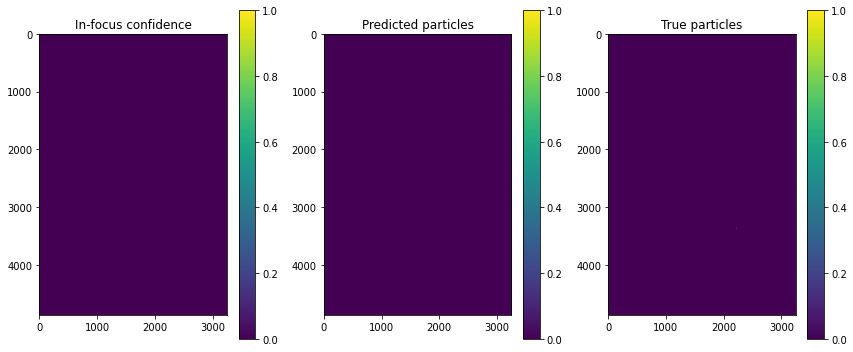

Plane: 407 at z: 0.07268 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0173:  44%|████▎     | 436/1000 [1:55:30<2:11:26, 13.98s/it] 

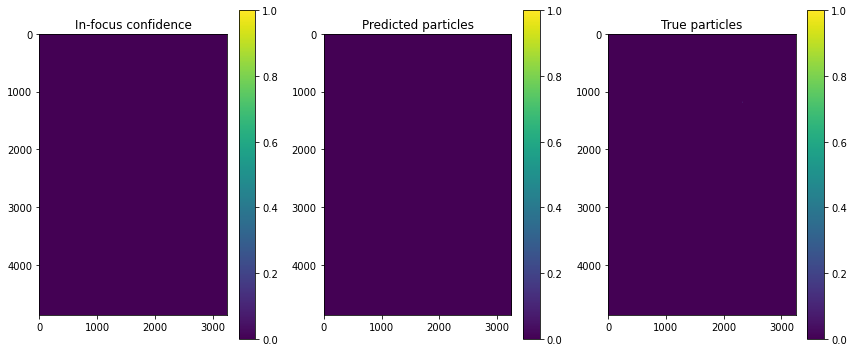

Plane: 408 at z: 0.072824 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0173:  44%|████▎     | 437/1000 [1:55:46<2:18:31, 14.76s/it]

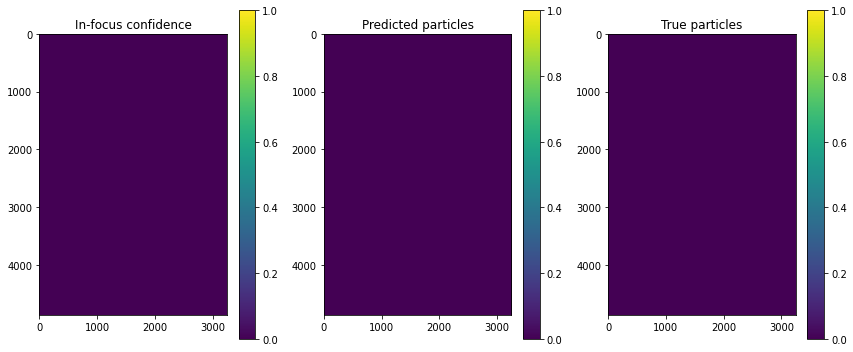

Plane: 409 at z: 0.07296799999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0173:  44%|████▍     | 438/1000 [1:56:03<2:23:22, 15.31s/it]

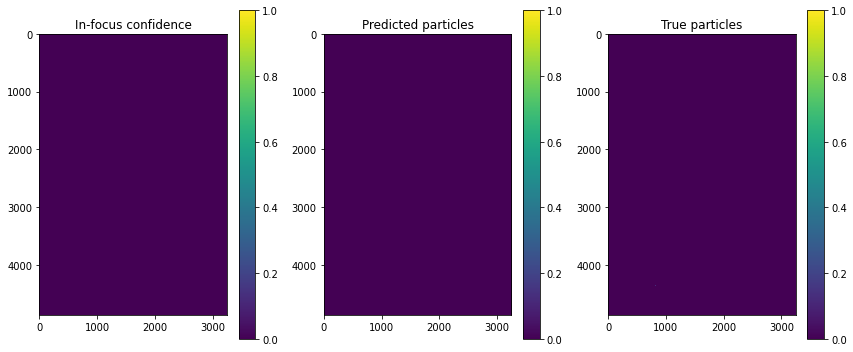

Plane: 410 at z: 0.073112 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0173:  44%|████▍     | 439/1000 [1:56:20<2:27:04, 15.73s/it]           

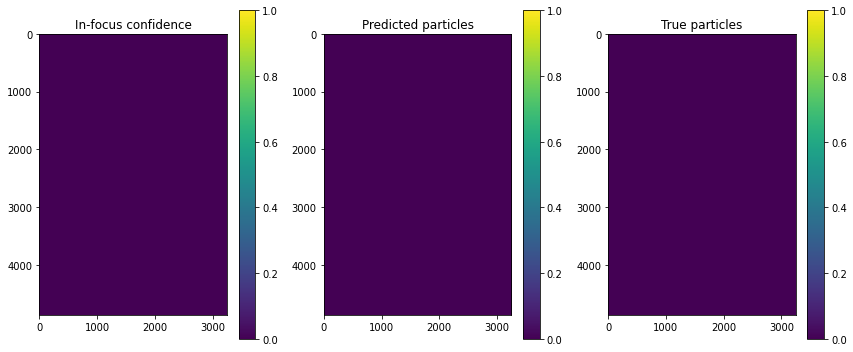

Plane: 411 at z: 0.073256 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0172:  44%|████▍     | 440/1000 [1:56:37<2:30:11, 16.09s/it]

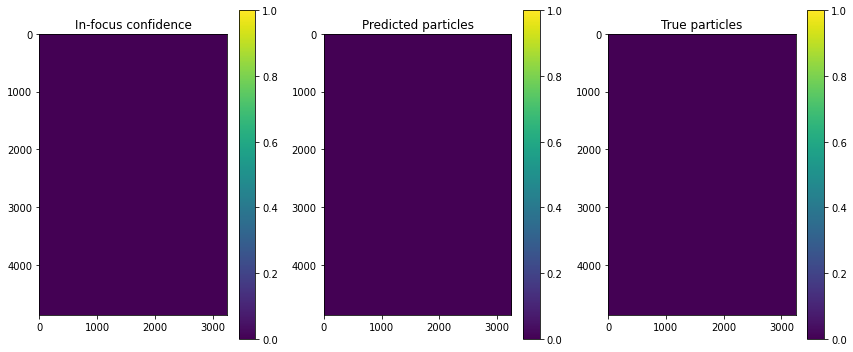

Plane: 412 at z: 0.07339999999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0172:  44%|████▍     | 441/1000 [1:56:53<2:31:34, 16.27s/it]

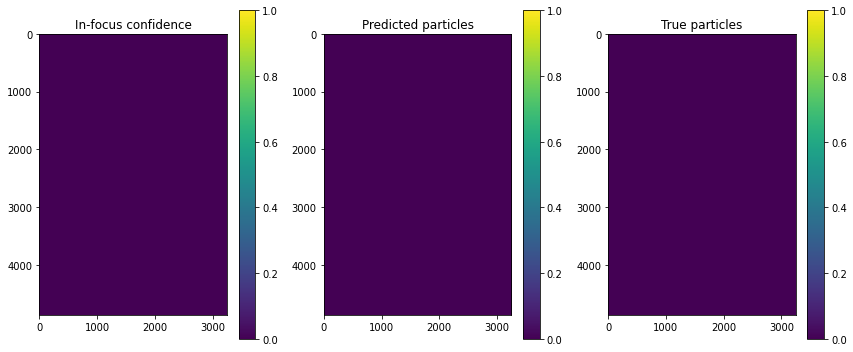

Plane: 413 at z: 0.073544 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0172:  44%|████▍     | 442/1000 [1:57:10<2:32:47, 16.43s/it]           

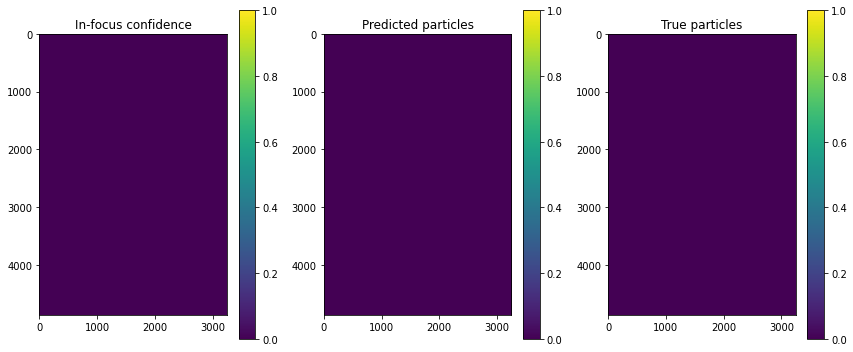

Plane: 414 at z: 0.073687 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0171:  44%|████▍     | 443/1000 [1:57:27<2:33:50, 16.57s/it]

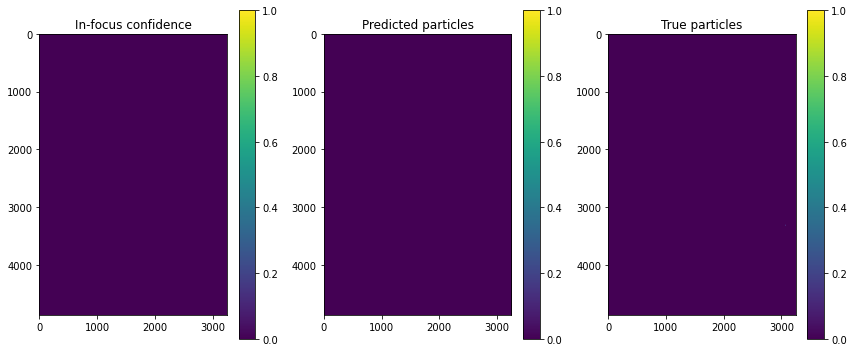

Plane: 415 at z: 0.073832 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0170:  44%|████▍     | 444/1000 [1:57:44<2:34:09, 16.64s/it]

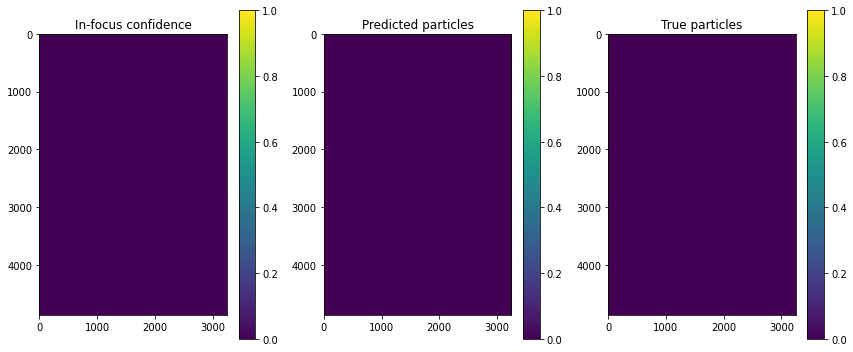

Plane: 416 at z: 0.073976 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0170:  44%|████▍     | 445/1000 [1:58:01<2:34:11, 16.67s/it]

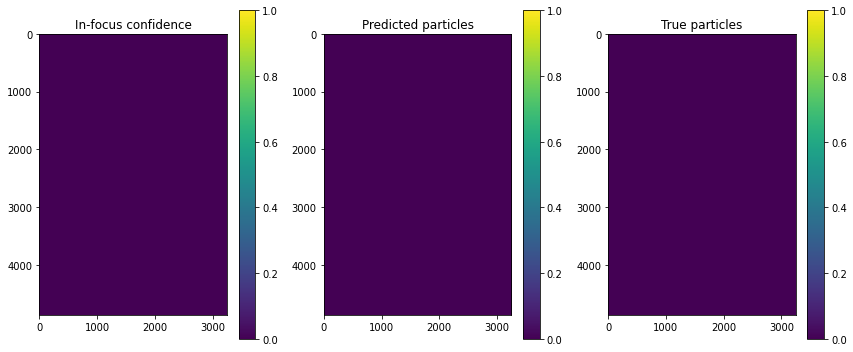

Plane: 417 at z: 0.07411999999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0170:  45%|████▍     | 446/1000 [1:58:17<2:34:21, 16.72s/it]

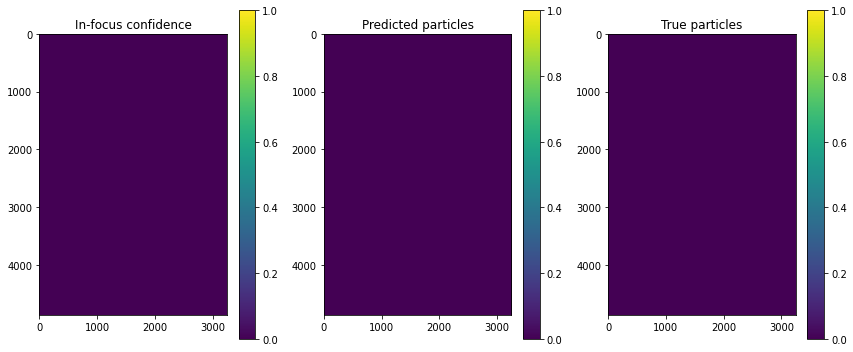

Plane: 418 at z: 0.074264 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0170:  45%|████▍     | 447/1000 [1:58:34<2:33:16, 16.63s/it]           

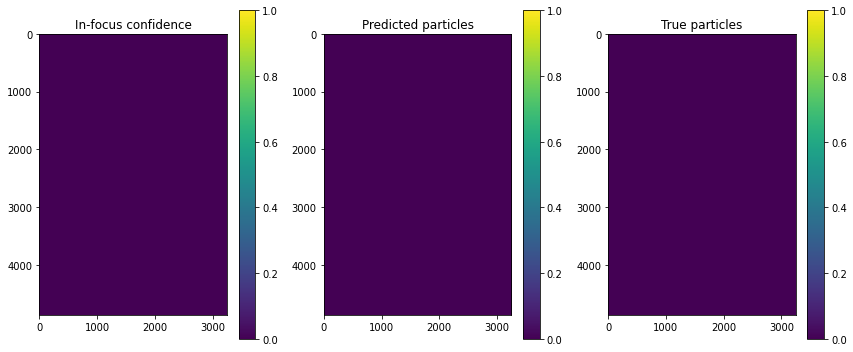

Plane: 419 at z: 0.074407 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0170:  45%|████▍     | 448/1000 [1:58:50<2:32:37, 16.59s/it]

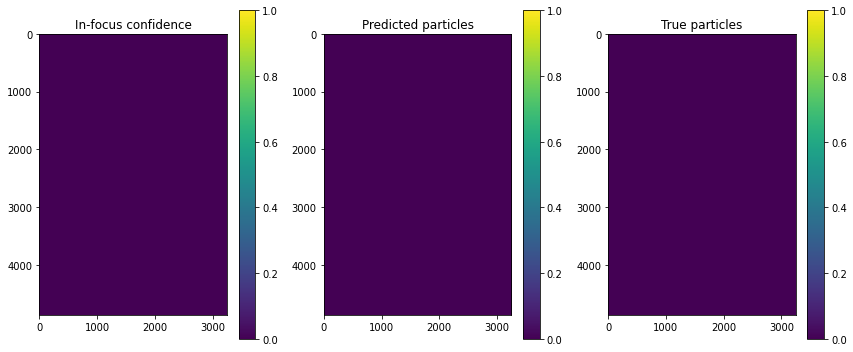

Plane: 420 at z: 0.074552 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0170:  45%|████▍     | 449/1000 [1:59:07<2:32:52, 16.65s/it]

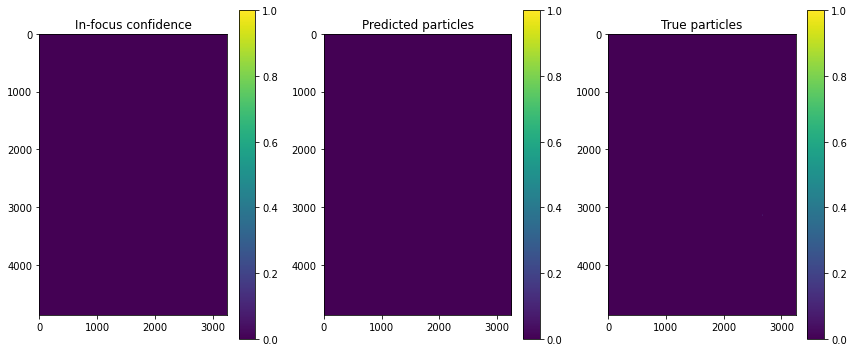

Plane: 421 at z: 0.074696 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0169:  45%|████▌     | 450/1000 [1:59:24<2:33:32, 16.75s/it]

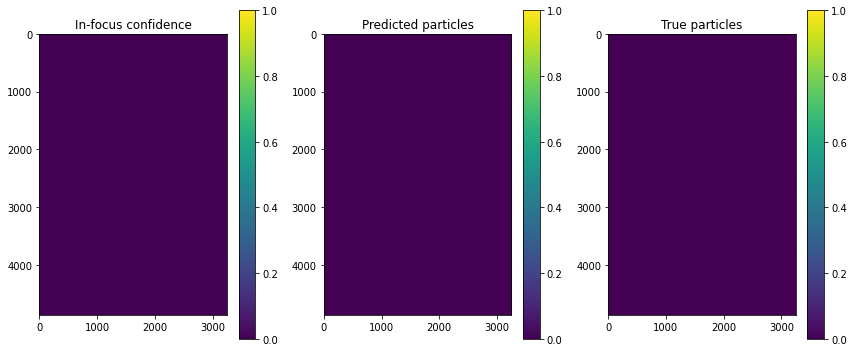

Plane: 422 at z: 0.074839 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0168:  45%|████▌     | 451/1000 [1:59:41<2:32:43, 16.69s/it]

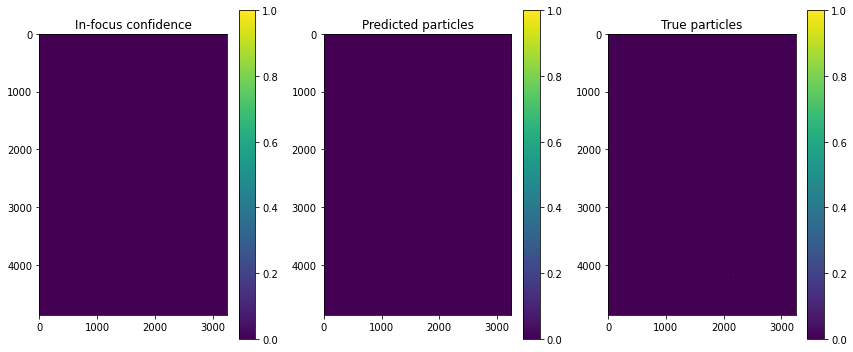

Plane: 423 at z: 0.074984 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0168:  45%|████▌     | 452/1000 [1:59:57<2:32:12, 16.66s/it]

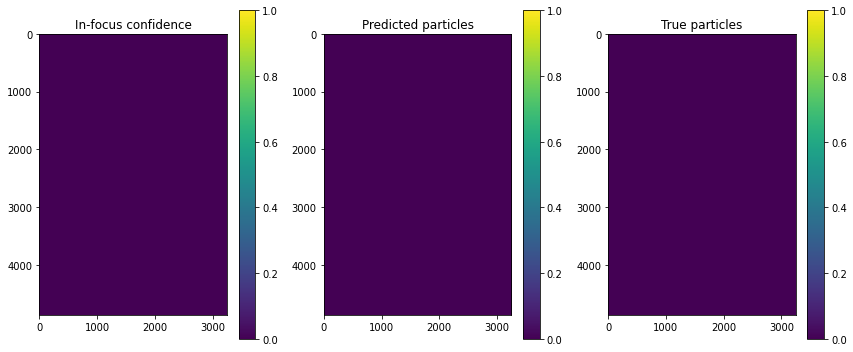

Plane: 424 at z: 0.075128 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0168:  45%|████▌     | 453/1000 [2:00:14<2:32:12, 16.70s/it]

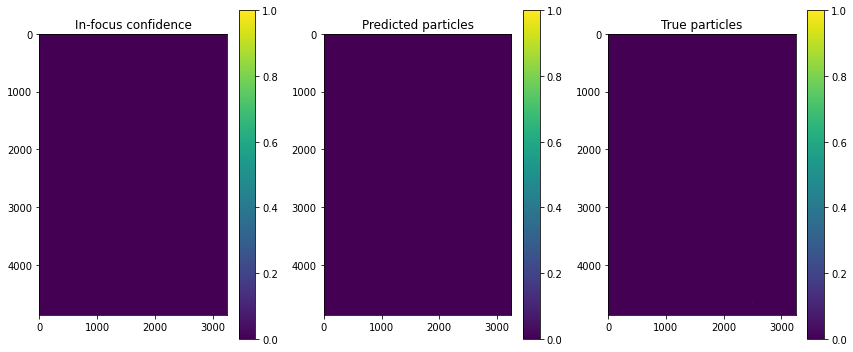

Plane: 425 at z: 0.07527199999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0166:  45%|████▌     | 454/1000 [2:00:31<2:31:55, 16.70s/it]

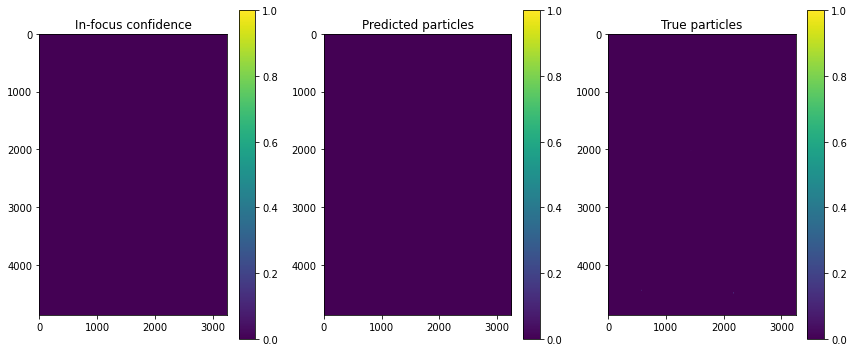

Plane: 426 at z: 0.075416 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0166:  46%|████▌     | 455/1000 [2:00:47<2:30:29, 16.57s/it]           

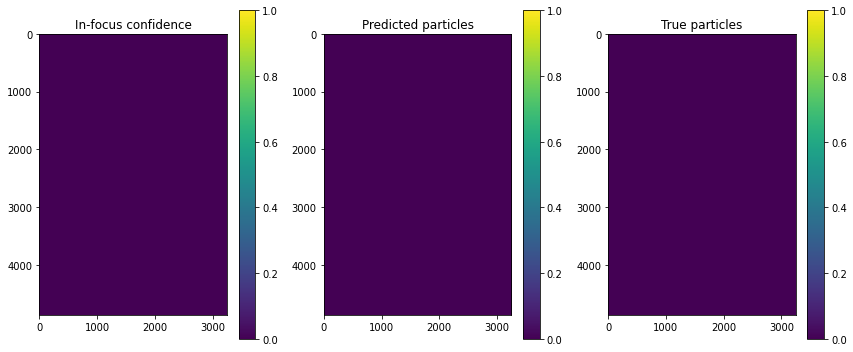

Plane: 427 at z: 0.075559 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0165:  46%|████▌     | 456/1000 [2:01:03<2:29:45, 16.52s/it]

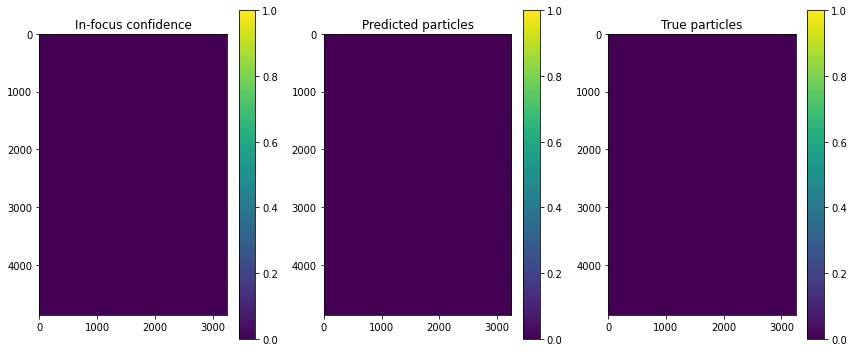

Plane: 428 at z: 0.075704 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0165:  46%|████▌     | 457/1000 [2:01:20<2:28:57, 16.46s/it]

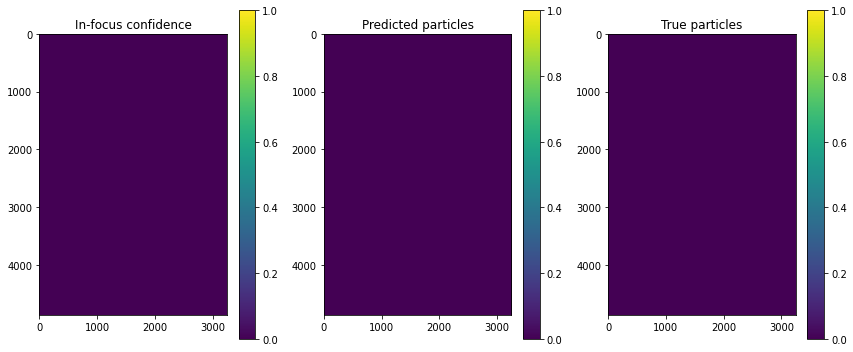

Plane: 429 at z: 0.075848 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0165:  46%|████▌     | 458/1000 [2:01:36<2:28:59, 16.49s/it]

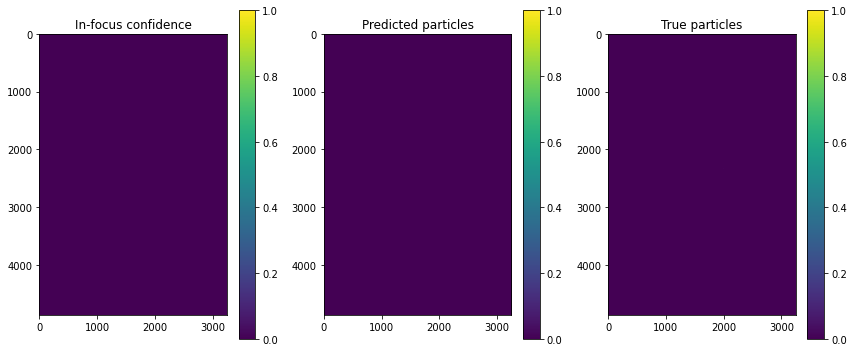

Plane: 430 at z: 0.07599199999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0163:  46%|████▌     | 459/1000 [2:01:53<2:29:34, 16.59s/it]

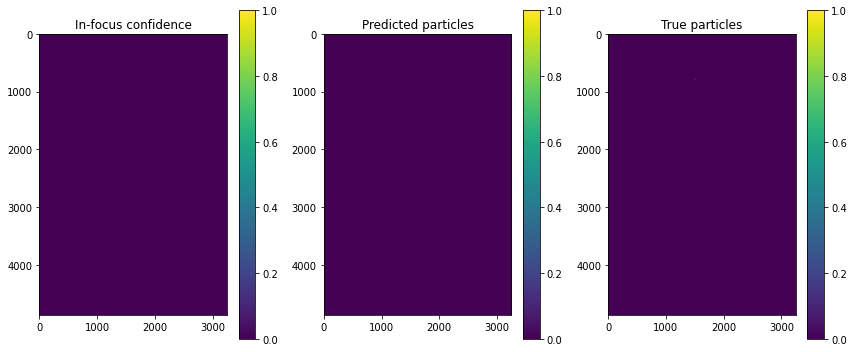

Plane: 431 at z: 0.076136 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0162:  46%|████▌     | 460/1000 [2:02:10<2:29:12, 16.58s/it]           

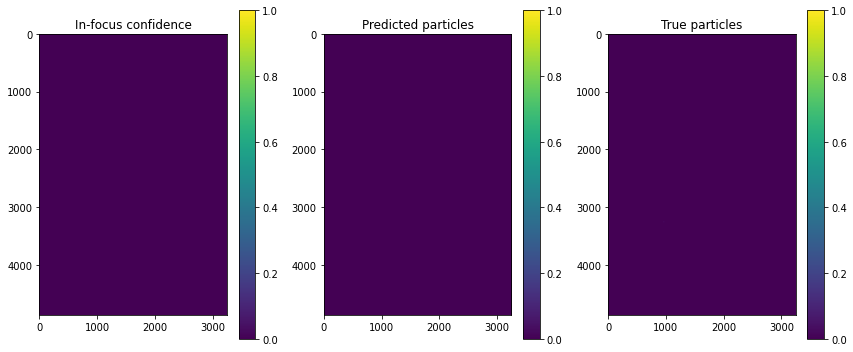

Plane: 432 at z: 0.07628 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0162:  46%|████▌     | 461/1000 [2:02:26<2:28:35, 16.54s/it] 

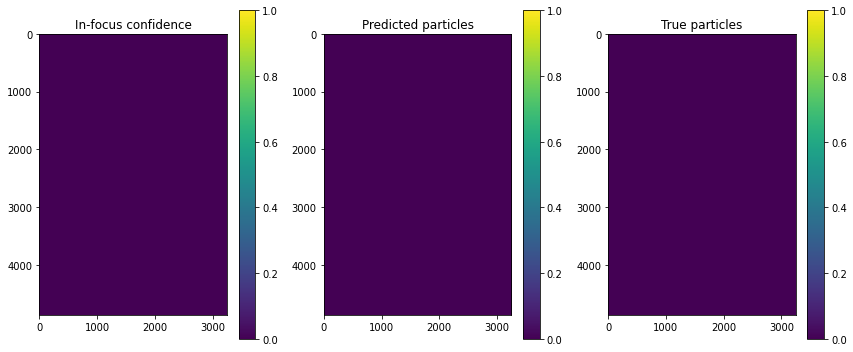

Plane: 433 at z: 0.07642399999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0162:  46%|████▌     | 462/1000 [2:02:42<2:27:59, 16.50s/it]

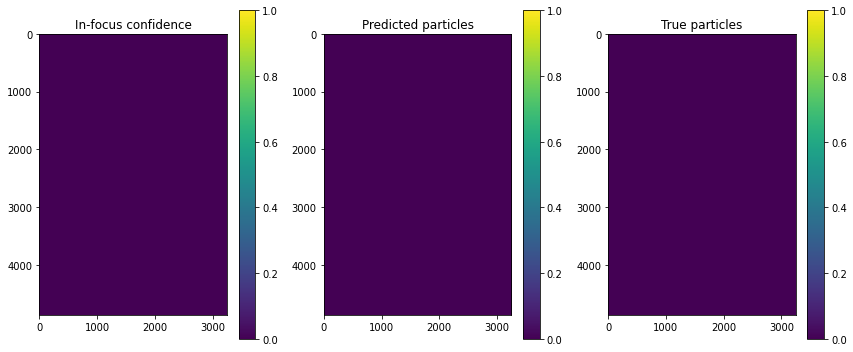

Plane: 434 at z: 0.076568 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0161:  46%|████▋     | 463/1000 [2:02:59<2:28:29, 16.59s/it]           

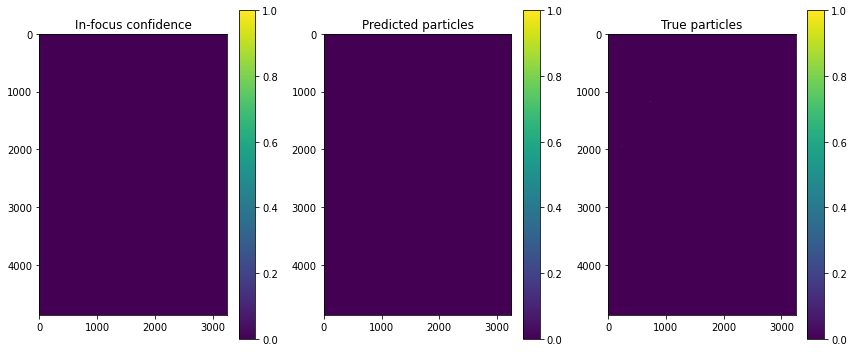

Plane: 435 at z: 0.076711 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0161:  46%|████▋     | 465/1000 [2:03:22<2:11:14, 14.72s/it]

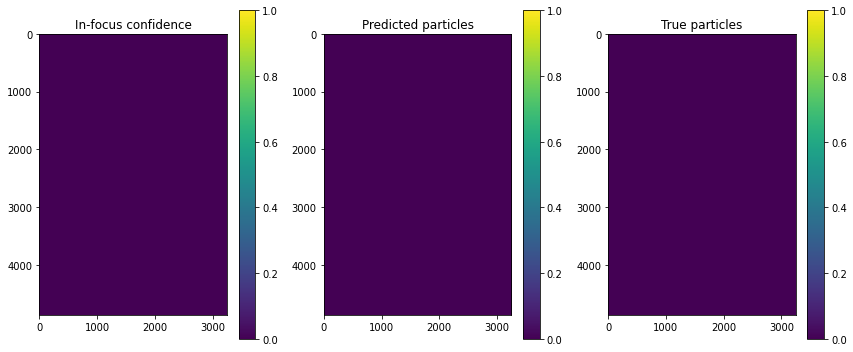

Plane: 436 at z: 0.07685499999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0159:  47%|████▋     | 466/1000 [2:03:39<2:16:47, 15.37s/it]

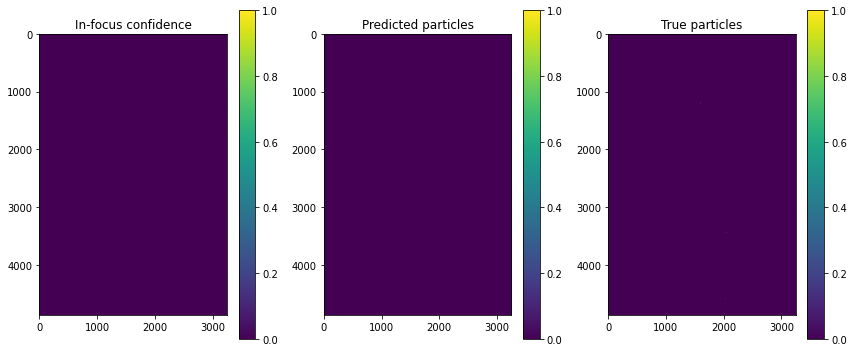

Plane: 437 at z: 0.076999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0159:  47%|████▋     | 467/1000 [2:03:56<2:20:20, 15.80s/it]           

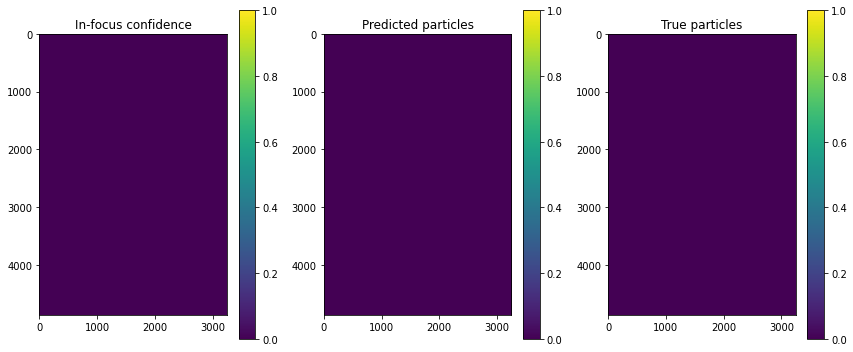

Plane: 438 at z: 0.07714399999999999 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0158:  47%|████▋     | 468/1000 [2:04:17<2:34:46, 17.46s/it]

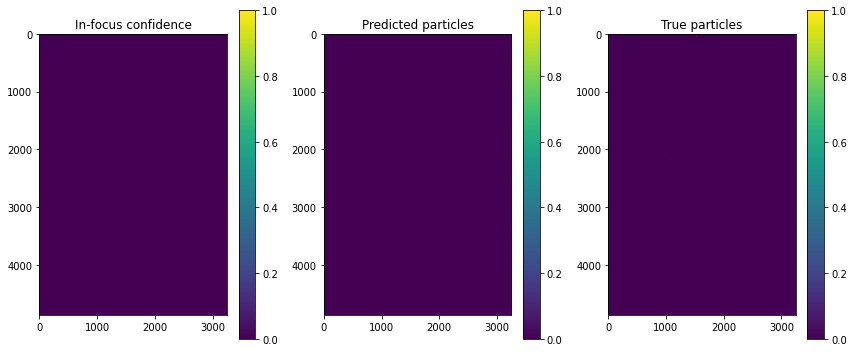

Plane: 439 at z: 0.077288 plane_acc: 1.0000 holo_acc: 1.0000 plane_csi: 0.0000 holo_csi: 0.0158:  47%|████▋     | 469/1000 [2:04:47<3:08:30, 21.30s/it]           

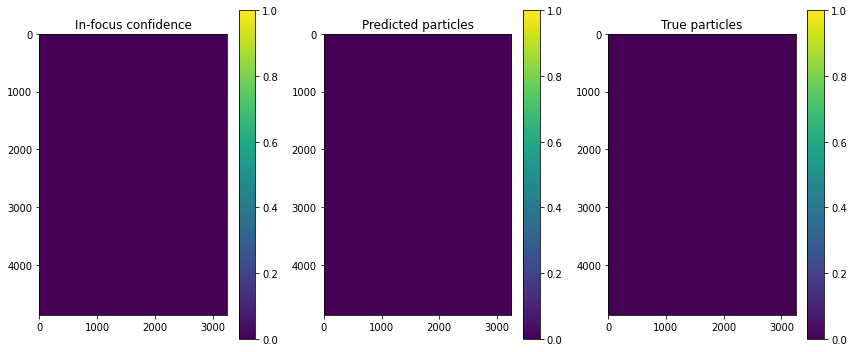

In [ ]:
model.eval()
with torch.no_grad():

    jiter = tqdm.tqdm(
        enumerate(inference_generator), 
        total = len(z_list),
        leave=True
    )

    roc = DistributedROC(thresholds=thresholds, obs_threshold=obs_threshold)
    holo_acc = []
    
    unet_particles = 0
    holo_particles = 0
    for z_idx, results_dict in jiter:

        # Get stuff from the results dictionary
        pred_label = results_dict["pred_output"]
        pred_prob = results_dict["pred_proba"]
        true_label = results_dict["true_output"]
        z_plane = int(results_dict["z_plane"])

        if save_arrays:
            # Save the giant matrices as sparse arrays, as most elements are zero
            save_sparse_csr(f"{prop_data_loc}/prob_{h_idx}_{z_plane}.npz", scipy.sparse.csr_matrix(pred_prob))
            save_sparse_csr(f"{prop_data_loc}/pred_{h_idx}_{z_plane}.npz", scipy.sparse.csr_matrix(pred_label))
            save_sparse_csr(f"{prop_data_loc}/true_{h_idx}_{z_plane}.npz", scipy.sparse.csr_matrix(true_label))

        # Merge the ROC result 
        this_roc = results_dict["roc"]
        roc.merge(this_roc)
        
        # Print some stuff
        #plane = this_roc.binary_metrics()
        #hologram = roc.binary_metrics()
        plane_acc = (pred_label == true_label).mean()
        holo_acc.append(plane_acc)
        
        unet_plane_particles = sum(pred_label)
        holo_plane_particles = sum(true_label)
        unet_particles += unet_plane_particles
        holo_particles += holo_plane_particles
        
        to_print = f"Plane: {z_idx} at z: {z_plane*1e-6}"
        to_print += f" plane_acc: {plane_acc:.4f}"
        to_print += f" holo_acc: {np.mean(holo_acc):.4f}"
        to_print += f" plane_csi: {this_roc.max_csi():.4f}"
        to_print += f" holo_csi: {roc.max_csi():.4f}"
        to_print += f" plane_(unet/suite): {int(unet_plane_particles)} / {int(holo_plane_particles)}"
        to_print += f" holo_(unet/suite): {int(unet_particles)} / {int(holo_particles)}"
        jiter.set_description(to_print)
        jiter.update()
        
        with open(f"{roc_data_loc}/roc_{h_idx}_{z_plane}.pkl", "wb") as fid:
            joblib.dump(results_dict["roc"], fid)

        # Option to plot each result per plane
        if plot:
            fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 5))
            p1 = ax0.imshow(pred_prob, vmin = 0,  vmax = 1)
            ax0.set_title("In-focus confidence")
            fig.colorbar(p1, ax=ax0)

            p2 = ax1.imshow(pred_label, vmin = 0,  vmax = 1)
            ax1.set_title("Predicted particles")
            fig.colorbar(p2, ax=ax1)

            p3 = ax2.imshow(true_label, vmin = 0, vmax = 1)
            ax2.set_title("True particles")
            fig.colorbar(p3, ax=ax2)

            plt.tight_layout()
            plt.show()

In [ ]:
rocs = sorted(glob.glob(f"{roc_data_loc}/roc_{h_idx}_*.pkl"), 
                  key = lambda x: int(x.strip(".pkl").split("_")[-1]))
    
for k, roc_fn in enumerate(rocs):
    with open(roc_fn, "rb") as fid:
        if k == 0:
            roc = joblib.load(fid)
        else:
            roc.merge(joblib.load(fid))

with open(f"{roc_data_loc}/roc_{h_idx}.pkl", "wb") as fid:
    joblib.dump(roc, fid)

roc_curve([roc], [model_name], ["orange"], ["o"], f"{image_data_loc}/roc_comparison_{h_idx}.png")
performance_diagram([roc], [model_name], ["orange"], ["o"], f"{image_data_loc}/images/performance_comparison_{h_idx}.png")